In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

### 데이터 전처리

#### 다중노선

In [2]:
df_m = pd.read_excel('/Users/yurim/Downloads/유리미/전기버스 충전 데이터_기초분석.xlsx', sheet_name='다중노선')

In [4]:
df_m.drop('OUTLET ID', axis=1, inplace=True)
df_m.rename(columns={'OUTLET ID_수정':'OUTLET ID'},inplace=True)

In [5]:
df_m['충전일자'] = pd.to_datetime(df_m['충전일자'])
df_m['충전시작시각'] = pd.to_datetime(df_m['충전시작시각'])
df_m['충전종료시각'] = pd.to_datetime(df_m['충전종료시각'])

In [6]:
#전체 데이터 기준 인터벌 로직2_추가 충전시각 근접 세션 병합(충전구상관X)

def process_cd(df_m):
    def process_vd(df_m):
        df_m = df_m.sort_values(by=['차량번호','충전시작시각', '충전기ID']).reset_index(drop=True)
        df_m['연속여부'] = (df_m['충전기ID'] == df_m['충전기ID'].shift())

        conti = []
        non_conti = []
        group = []

        for index, row in df_m.iterrows():
            if group and (row['충전기ID'] != group[-1]['충전기ID']):
                if len(group) > 1:
                    conti.extend(group)
                else:
                    non_conti.extend(group)
                group = []
            group.append(row)

        if group:
            if len(group) > 1:
                conti.extend(group)
            else:
                non_conti.extend(group)

        df_conti = pd.DataFrame(conti)
        df_non_conti = pd.DataFrame(non_conti)

        df_conti_sort = df_conti.sort_values(by=['차량번호','충전시작시각', '충전기ID']).reset_index(drop=True)

        comss = []
        skip = set()

        for charger_id, group in df_conti_sort.groupby('차량번호'):
            i = 0
            while i < len(group):
                if i in skip:
                    i += 1
                    continue

                crss = group.iloc[i].copy()

                j = i + 1
                while j < len(group):
                    nextss = group.iloc[j]
                    if crss['충전기ID'] == nextss['충전기ID'] and (
                        (nextss['충전시작시각'] - crss['충전시작시각']).total_seconds() / 3600 <= 1 or
                        (nextss['충전시작시각'] - crss['충전종료시각']).total_seconds() / 3600 <= 1):
                        crss['충전시작시각'] = min(crss['충전시작시각'], nextss['충전시작시각'])
                        crss['충전종료시각'] = max(crss['충전종료시각'], nextss['충전종료시각'])
                        crss['충전전력량(kWh)'] += nextss['충전전력량(kWh)']
                        crss['충전 요금(원)'] += nextss['충전 요금(원)']
                        crss['충전시작 SOC(%)'] = min(crss['충전시작 SOC(%)'], nextss['충전시작 SOC(%)'])
                        crss['충전종료 SOC(%)'] = max(crss['충전종료 SOC(%)'], nextss['충전종료 SOC(%)'])
                        skip.add(j)
                        j += 1
                    else:
                        break

                comss.append(crss)
                i = j

        df_conti_ft = pd.DataFrame(comss)

        df_comb = pd.concat([df_non_conti, df_conti_ft], ignore_index=True)
        df_comb = df_comb.sort_values(by=['차량번호', '충전시작시각']).reset_index(drop=True)

        # 추가 병합 로직
        comss = []
        skip = set()

        for charger_id, group in df_comb.groupby('차량번호'):
            i = 0
            while i < len(group):
                if i in skip:
                    i += 1
                    continue

                crss = group.iloc[i].copy()

                j = i + 1
                while j < len(group):
                    nextss = group.iloc[j]
                    if (nextss['충전시작시각'] - crss['충전시작시각']).total_seconds() / 3600 <= 1 or \
                       (nextss['충전시작시각'] - crss['충전종료시각']).total_seconds() / 3600 <= 1:
                        crss['충전시작시각'] = min(crss['충전시작시각'], nextss['충전시작시각'])
                        crss['충전종료시각'] = max(crss['충전종료시각'], nextss['충전종료시각'])
                        crss['충전전력량(kWh)'] += nextss['충전전력량(kWh)']
                        crss['충전 요금(원)'] += nextss['충전 요금(원)']
                        crss['충전시작 SOC(%)'] = min(crss['충전시작 SOC(%)'], nextss['충전시작 SOC(%)'])
                        crss['충전종료 SOC(%)'] = max(crss['충전종료 SOC(%)'], nextss['충전종료 SOC(%)'])
                        skip.add(j)
                        j += 1
                    else:
                        break

                comss.append(crss)
                i = j

        df_fc = pd.DataFrame(comss)

        # 인터벌 계산
        df_fc = df_fc.sort_values(by='충전시작시각').reset_index(drop=True)

        intervals = []
        pet = None

        for index, row in df_fc.iterrows():
            if pet is not None:
                interval = (row['충전시작시각'] - pet).total_seconds() / 3600
                if interval < 24:
                    intervals.append(interval)
                else:
                    intervals.append(None)
            else:
                intervals.append(None)

            pet = row['충전종료시각']

        df_fc['충전 인터벌(시간)'] = intervals

        df_fc['충전소요시간_수정'] = df_fc['충전종료시각'] - df_fc['충전시작시각']
        if '충전소요시간' in df_fc.columns:
            df_fc.drop(columns=['충전소요시간'], inplace=True)

        return df_fc

    result_df = pd.DataFrame()
    for vehicle_id, vehicle_data in df_m.groupby('차량번호'):
        pdt = process_vd(vehicle_data)
        result_df = pd.concat([result_df, pdt], ignore_index=True)

    return result_df

processed_df = process_cd(df_m)


In [7]:
processed_df

차량번호  노선명  충전기ID 충전기ID_충전구              충전시작시각  \
0      경기70바1880    5      4       4_A 2023-01-09 20:05:45   
1      경기70바1880    5      6       6_A 2023-01-10 17:30:36   
2      경기70바1880    5     27      27_A 2023-01-11 08:35:52   
3      경기70바1880    5     28      28_B 2023-01-11 11:30:01   
4      경기70바1880    5     33      33_B 2023-01-12 09:54:30   
...          ...  ...    ...       ...                 ...   
10734  경기70바1941  7-2     36      36_A 2023-12-30 22:43:00   
10735  경기70바1941  7-2     39      39_A 2023-12-31 08:41:39   
10736  경기70바1941  7-2     33      33_A 2023-12-31 12:16:36   
10737  경기70바1941  7-2     33      33_A 2023-12-31 15:41:11   
10738  경기70바1941  7-2      8       8_A 2023-12-31 18:53:30   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-09 20:41:22       76.24      7433           51           95   
1     2023-01-10 17:43:39        7.48      1230           90           95   
2     2023-01-11 09:03:54       79.88      8538           45           91   
3     2023-01-11 12:15:53       67.64      9553           56           95   
4     2023-01-12 10:38:16       67.32     11067           46           86   
...                   ...         ...       ...          ...          ...   
10734 2023-12-31 00:43:00      126.72         0           19           95   
10735 2023-12-31 09:04:07       62.04         0           59           95   
10736 2023-12-31 12:37:08       54.36         0           64           95   
10737 2023-12-31 16:02:05       54.76         0           64           95   
10738 2023-12-31 19:15:47       56.04         0           63           95   

       ...      요금 확인  요금확인셀  급속 충전요금 적용시(347.2원)  SOC 종료-시작  soc 시작 구간  \
0      ...   3623.000      0            12901.952         42          5   
1      ...   1230.000      0             2597.056          5          9   
2      ...   4293.000      0            13957.440         46          4   
3      ...   9553.000      0            23484.608         39          5   
4      ...  11067.000      0            23373.504         40          4   
...    ...        ...    ...                  ...        ...        ...   
10734  ...  13406.976      0            43997.184         76          1   
10735  ...   4526.124      0            10929.856         36          5   
10736  ...   3588.144      0             9832.704         31          6   
10737  ...   4113.936      0            10416.000         31          6   
10738  ...   4747.416      0            10832.640         32          6   

       soc 종료구간 soc 구간   연속여부 충전 인터벌(시간)       충전소요시간_수정  
0             9    5-9  False        NaN 0 days 00:35:37  
1             9    9-9  False  20.820556 0 days 00:13:03  
2             9    4-9  False  14.870278 0 days 00:28:02  
3             9    5-9  False   2.435278 0 days 00:45:52  
4             8    4-8  False  21.643611 0 days 00:43:46  
...         ...    ...    ...        ...             ...  
10734         9    1-9  False   5.979444 0 days 02:00:00  
10735         9    5-9  False   7.977500 0 days 00:22:28  
10736         9    6-9  False   3.208056 0 days 00:20:32  
10737         9    6-9   True   3.067500 0 days 00:20:54  
10738         9    6-9  False   2.856944 0 days 00:22:17  

[10739 rows x 32 columns]

In [8]:
processed_df['충전소요시간_수정'] = processed_df['충전소요시간_수정'].astype(str).str.replace('0 days ', '')
processed_df

차량번호  노선명  충전기ID 충전기ID_충전구              충전시작시각  \
0      경기70바1880    5      4       4_A 2023-01-09 20:05:45   
1      경기70바1880    5      6       6_A 2023-01-10 17:30:36   
2      경기70바1880    5     27      27_A 2023-01-11 08:35:52   
3      경기70바1880    5     28      28_B 2023-01-11 11:30:01   
4      경기70바1880    5     33      33_B 2023-01-12 09:54:30   
...          ...  ...    ...       ...                 ...   
10734  경기70바1941  7-2     36      36_A 2023-12-30 22:43:00   
10735  경기70바1941  7-2     39      39_A 2023-12-31 08:41:39   
10736  경기70바1941  7-2     33      33_A 2023-12-31 12:16:36   
10737  경기70바1941  7-2     33      33_A 2023-12-31 15:41:11   
10738  경기70바1941  7-2      8       8_A 2023-12-31 18:53:30   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-09 20:41:22       76.24      7433           51           95   
1     2023-01-10 17:43:39        7.48      1230           90           95   
2     2023-01-11 09:03:54       79.88      8538           45           91   
3     2023-01-11 12:15:53       67.64      9553           56           95   
4     2023-01-12 10:38:16       67.32     11067           46           86   
...                   ...         ...       ...          ...          ...   
10734 2023-12-31 00:43:00      126.72         0           19           95   
10735 2023-12-31 09:04:07       62.04         0           59           95   
10736 2023-12-31 12:37:08       54.36         0           64           95   
10737 2023-12-31 16:02:05       54.76         0           64           95   
10738 2023-12-31 19:15:47       56.04         0           63           95   

       ...      요금 확인  요금확인셀  급속 충전요금 적용시(347.2원)  SOC 종료-시작  soc 시작 구간  \
0      ...   3623.000      0            12901.952         42          5   
1      ...   1230.000      0             2597.056          5          9   
2      ...   4293.000      0            13957.440         46          4   
3      ...   9553.000      0            23484.608         39          5   
4      ...  11067.000      0            23373.504         40          4   
...    ...        ...    ...                  ...        ...        ...   
10734  ...  13406.976      0            43997.184         76          1   
10735  ...   4526.124      0            10929.856         36          5   
10736  ...   3588.144      0             9832.704         31          6   
10737  ...   4113.936      0            10416.000         31          6   
10738  ...   4747.416      0            10832.640         32          6   

       soc 종료구간 soc 구간   연속여부 충전 인터벌(시간)  충전소요시간_수정  
0             9    5-9  False        NaN   00:35:37  
1             9    9-9  False  20.820556   00:13:03  
2             9    4-9  False  14.870278   00:28:02  
3             9    5-9  False   2.435278   00:45:52  
4             8    4-8  False  21.643611   00:43:46  
...         ...    ...    ...        ...        ...  
10734         9    1-9  False   5.979444   02:00:00  
10735         9    5-9  False   7.977500   00:22:28  
10736         9    6-9  False   3.208056   00:20:32  
10737         9    6-9   True   3.067500   00:20:54  
10738         9    6-9  False   2.856944   00:22:17  

[10739 rows x 32 columns]

In [9]:
df2 = processed_df.copy()

In [10]:
df2['SOC종료-시작_수정'] = processed_df['충전종료 SOC(%)'] - processed_df['충전시작 SOC(%)']
df2.drop(columns=['SOC 종료-시작'], inplace=True)
df2.drop(columns=['soc 시작 구간', 'soc 종료구간', 'soc 구간','충전소요시간(초)', '충전소요시간(분)','연속여부','경부하(원)', '중간부하(원)', '최대부하(원)', '경부하(kWh)', '중간부하(kWh)', '최대부하(kWh)','충전일자', '월', '요일', '시작시간', '요금 확인', '요금확인셀', '급속 충전요금 적용시(347.2원)'], inplace=True)

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10739 entries, 0 to 10738
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   차량번호         10739 non-null  object        
 1   노선명          10739 non-null  object        
 2   충전기ID        10739 non-null  int64         
 3   충전기ID_충전구    10739 non-null  object        
 4   충전시작시각       10739 non-null  datetime64[ns]
 5   충전종료시각       10739 non-null  datetime64[ns]
 6   충전전력량(kWh)   10739 non-null  float64       
 7   충전 요금(원)     10739 non-null  int64         
 8   충전시작 SOC(%)  10739 non-null  int64         
 9   충전종료 SOC(%)  10739 non-null  int64         
 10  충전 인터벌(시간)   10106 non-null  float64       
 11  충전소요시간_수정    10739 non-null  object        
 12  SOC종료-시작_수정  10739 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(5), object(4)
memory usage: 1.1+ MB


In [12]:
df2 = df2[df2['충전전력량(kWh)'] > 0]
df2

차량번호  노선명  충전기ID 충전기ID_충전구              충전시작시각  \
0      경기70바1880    5      4       4_A 2023-01-09 20:05:45   
1      경기70바1880    5      6       6_A 2023-01-10 17:30:36   
2      경기70바1880    5     27      27_A 2023-01-11 08:35:52   
3      경기70바1880    5     28      28_B 2023-01-11 11:30:01   
4      경기70바1880    5     33      33_B 2023-01-12 09:54:30   
...          ...  ...    ...       ...                 ...   
10734  경기70바1941  7-2     36      36_A 2023-12-30 22:43:00   
10735  경기70바1941  7-2     39      39_A 2023-12-31 08:41:39   
10736  경기70바1941  7-2     33      33_A 2023-12-31 12:16:36   
10737  경기70바1941  7-2     33      33_A 2023-12-31 15:41:11   
10738  경기70바1941  7-2      8       8_A 2023-12-31 18:53:30   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-09 20:41:22       76.24      7433           51           95   
1     2023-01-10 17:43:39        7.48      1230           90           95   
2     2023-01-11 09:03:54       79.88      8538           45           91   
3     2023-01-11 12:15:53       67.64      9553           56           95   
4     2023-01-12 10:38:16       67.32     11067           46           86   
...                   ...         ...       ...          ...          ...   
10734 2023-12-31 00:43:00      126.72         0           19           95   
10735 2023-12-31 09:04:07       62.04         0           59           95   
10736 2023-12-31 12:37:08       54.36         0           64           95   
10737 2023-12-31 16:02:05       54.76         0           64           95   
10738 2023-12-31 19:15:47       56.04         0           63           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정  
0             NaN  00:35:37           44  
1       20.820556  00:13:03            5  
2       14.870278  00:28:02           46  
3        2.435278  00:45:52           39  
4       21.643611  00:43:46           40  
...           ...       ...          ...  
10734    5.979444  02:00:00           76  
10735    7.977500  00:22:28           36  
10736    3.208056  00:20:32           31  
10737    3.067500  00:20:54           31  
10738    2.856944  00:22:17           32  

[10738 rows x 13 columns]

In [13]:
dm = {
    'Monday': '월',
    'Tuesday': '화',
    'Wednesday': '수',
    'Thursday': '목',
    'Friday': '금',
    'Saturday': '토',
    'Sunday': '일'
}

df2['충전일자'] = df2['충전시작시각'].dt.date
df2['월'] = df2['충전시작시각'].dt.month
df2['요일'] = df2['충전시작시각'].dt.day_name().map(dm)
df2['주중/주말'] = df2['충전시작시각'].dt.weekday.apply(lambda x: '주말' if x >= 5 else '주중')

df2

차량번호  노선명  충전기ID 충전기ID_충전구              충전시작시각  \
0      경기70바1880    5      4       4_A 2023-01-09 20:05:45   
1      경기70바1880    5      6       6_A 2023-01-10 17:30:36   
2      경기70바1880    5     27      27_A 2023-01-11 08:35:52   
3      경기70바1880    5     28      28_B 2023-01-11 11:30:01   
4      경기70바1880    5     33      33_B 2023-01-12 09:54:30   
...          ...  ...    ...       ...                 ...   
10734  경기70바1941  7-2     36      36_A 2023-12-30 22:43:00   
10735  경기70바1941  7-2     39      39_A 2023-12-31 08:41:39   
10736  경기70바1941  7-2     33      33_A 2023-12-31 12:16:36   
10737  경기70바1941  7-2     33      33_A 2023-12-31 15:41:11   
10738  경기70바1941  7-2      8       8_A 2023-12-31 18:53:30   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-09 20:41:22       76.24      7433           51           95   
1     2023-01-10 17:43:39        7.48      1230           90           95   
2     2023-01-11 09:03:54       79.88      8538           45           91   
3     2023-01-11 12:15:53       67.64      9553           56           95   
4     2023-01-12 10:38:16       67.32     11067           46           86   
...                   ...         ...       ...          ...          ...   
10734 2023-12-31 00:43:00      126.72         0           19           95   
10735 2023-12-31 09:04:07       62.04         0           59           95   
10736 2023-12-31 12:37:08       54.36         0           64           95   
10737 2023-12-31 16:02:05       54.76         0           64           95   
10738 2023-12-31 19:15:47       56.04         0           63           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정        충전일자   월 요일 주중/주말  
0             NaN  00:35:37           44  2023-01-09   1  월    주중  
1       20.820556  00:13:03            5  2023-01-10   1  화    주중  
2       14.870278  00:28:02           46  2023-01-11   1  수    주중  
3        2.435278  00:45:52           39  2023-01-11   1  수    주중  
4       21.643611  00:43:46           40  2023-01-12   1  목    주중  
...           ...       ...          ...         ...  .. ..   ...  
10734    5.979444  02:00:00           76  2023-12-30  12  토    주말  
10735    7.977500  00:22:28           36  2023-12-31  12  일    주말  
10736    3.208056  00:20:32           31  2023-12-31  12  일    주말  
10737    3.067500  00:20:54           31  2023-12-31  12  일    주말  
10738    2.856944  00:22:17           32  2023-12-31  12  일    주말  

[10738 rows x 17 columns]

#### 단일노선

In [14]:
df_s = pd.read_excel('/Users/yurim/Downloads/유리미/전기버스 충전 데이터_기초분석.xlsx', sheet_name='단일노선')

In [15]:
df_s.drop('OUTLET ID', axis=1, inplace=True)
df_s.rename(columns={'OUTLET ID_수정':'OUTLET ID'},inplace=True)

In [16]:
df_s['충전일자'] = pd.to_datetime(df_s['충전일자'])
df_s['충전시작시각'] = pd.to_datetime(df_s['충전시작시각'])
df_s['충전종료시각'] = pd.to_datetime(df_s['충전종료시각'])

In [17]:
df_s

차량번호   노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0       경기70바1907     5      8         B       8_B 2023-01-01 00:00:00   
1       경기70바1963    30      8         A       8_A 2023-01-01 00:00:00   
2       경기70바1904     5     12         B      12_B 2023-01-01 00:00:00   
3       경기70바1915  30-1     12         A      12_A 2023-01-01 00:00:00   
4       경기70바1967    30     25         B      25_B 2023-01-01 00:00:00   
...           ...   ...    ...       ...       ...                 ...   
131590  경기70바1918  30-1     26         A      26_A 2023-12-31 19:59:51   
131591  경기70바1883     5     46         A      46_A 2023-12-31 21:07:43   
131592  경기70바1883     5     46         B      46_B 2023-12-31 21:08:21   
131593  경기70바1650    98     13         B      13_B 2023-12-31 21:47:01   
131594  경기70바1926    42      8         A       8_A 2023-12-31 22:27:08   

                    충전종료시각    충전소요시간  충전전력량(kWh)  충전 요금(원)  ...  시작시간  \
0      2023-01-01 01:24:08  01:24:08     104.600      9121  ...     0   
1      2023-01-01 01:26:31  01:26:31     132.120     11521  ...     0   
2      2023-01-01 00:31:54  00:31:54      50.560      4409  ...     0   
3      2023-01-01 01:32:14  01:32:14     130.720     11399  ...     0   
4      2023-01-01 00:37:22  00:37:22      60.000      5232  ...     0   
...                    ...       ...         ...       ...  ...   ...   
131590 2023-12-31 20:11:31  00:11:40      13.920         0  ...    19   
131591 2023-12-31 21:17:37  00:09:54       8.426         0  ...    21   
131592 2023-12-31 21:17:39  00:09:18       8.033         0  ...    21   
131593 2023-12-31 23:51:28  02:04:27     185.160         0  ...    21   
131594 2023-12-31 22:44:32  00:17:23      24.160         0  ...    22   

        충전소요시간(초)   충전소요시간(분)      요금 확인  요금확인셀  급속 충전요금 적용시(347.2원)  \
0          5048.0   84.133333   9121.000      0           36317.1200   
1          5191.0   86.516667  11521.000      0           45872.0640   
2          1914.0   31.900000   4409.000      0           17554.4320   
3          5534.0   92.233333  11399.000      0           45385.9840   
4          2242.0   37.366667   5232.000      0           20832.0000   
...           ...         ...        ...    ...                  ...   
131590      700.0   11.666667   1763.664      0            4833.0240   
131591      594.0    9.900000   1067.574      0            2925.5072   
131592      558.0    9.300000   1017.781      0            2789.0576   
131593     7467.0  124.450000  19928.508      0           64287.5520   
131594     1043.0   17.383333   2556.128      0            8388.3520   

        SOC 종료-시작  soc 시작 구간 soc 종료구간  soc 구간  
0              82          1        9     1-9  
1              80          1        9     1-9  
2              79          1        9     1-9  
3              80          1        9     1-9  
4              68          2        9     2-9  
...           ...        ...      ...     ...  
131590          6          6        7     6-7  
131591         16          5        6     5-6  
131592         15          5        6     5-6  
131593         80          1        9     1-9  
131594         13          3        4     3-4  

[131595 rows x 31 columns]

In [18]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131595 entries, 0 to 131594
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   차량번호                 131595 non-null  object        
 1   노선명                  131595 non-null  object        
 2   충전기ID                131595 non-null  int64         
 3   OUTLET ID            131595 non-null  object        
 4   충전기ID_충전구            131595 non-null  object        
 5   충전시작시각               131595 non-null  datetime64[ns]
 6   충전종료시각               131595 non-null  datetime64[ns]
 7   충전소요시간               131595 non-null  object        
 8   충전전력량(kWh)           131595 non-null  float64       
 9   충전 요금(원)             131595 non-null  int64         
 10  충전시작 SOC(%)          131595 non-null  int64         
 11  충전종료 SOC(%)          131595 non-null  int64         
 12  경부하(원)               131595 non-null  float64       
 13  중간부하(원)       

In [19]:
df_s = df_s.sort_values(by=['차량번호', '충전시작시각', '충전기ID']).reset_index(drop=True)

intervals = []
pet = None

for index, row in df_s.iterrows():
    if pet is not None:
        interval = (row['충전시작시각'] - pet).total_seconds() / 3600
        if interval < 24:
            intervals.append(interval)
        else:
            intervals.append(None)
    else:
        intervals.append(None)
    
    pet = row['충전종료시각']

df_s['충전 인터벌(시간)'] = intervals

df_s['연속여부'] = (df_s['충전기ID'] == df_s['충전기ID'].shift())

conti = []
non_conti = []
group = []

for index, row in df_s.iterrows():
    if group and row['충전기ID'] != group[-1]['충전기ID']:
        if len(group) > 1:
            conti.extend(group)
        else:
            non_conti.extend(group)
        group = []
    group.append(row)

if group:
    if len(group) > 1:
        conti.extend(group)
    else:
        non_conti.extend(group)

df_conti = pd.DataFrame(conti)
df_non_conti = pd.DataFrame(non_conti)

print("연속되는 경우:")
df_conti

연속되는 경우:


차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
1       경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2       경기70바1254  98      8         B       8_B 2023-01-03 12:01:08   
3       경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
4       경기70바1254  98     41         A      41_A 2023-01-03 16:12:44   
6       경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...           ...  ..    ...       ...       ...                 ...   
131588  경기70바2409  98     19         B      19_B 2023-12-28 12:53:42   
131590  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
131591  경기70바2409  98     33         B      33_B 2023-12-29 08:32:13   
131592  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
131593  경기70바2409  98     33         B      33_B 2023-12-29 12:50:06   

                    충전종료시각    충전소요시간  충전전력량(kWh)  충전 요금(원)  ...  충전소요시간(분)  \
1      2023-01-03 12:30:34  00:29:58       43.92      4282  ...  29.966667   
2      2023-01-03 12:30:31  00:29:23       43.36      4228  ...  29.383333   
3      2023-01-03 16:18:32  00:06:12        9.08      1493  ...   6.200000   
4      2023-01-03 16:25:15  00:12:31       19.16      3150  ...  12.516667   
6      2023-01-04 12:12:15  00:23:11       36.36      4692  ...  23.183333   
...                    ...       ...         ...       ...  ...        ...   
131588 2023-12-28 13:25:48  00:32:05       48.72         0  ...  32.083333   
131590 2023-12-29 08:59:17  00:27:34       41.24         0  ...  27.566667   
131591 2023-12-29 08:59:16  00:27:02       40.96         0  ...  27.033333   
131592 2023-12-29 13:19:17  00:29:38       39.68         0  ...  29.633333   
131593 2023-12-29 13:19:15  00:29:09       43.20         0  ...  29.150000   

           요금 확인  요금확인셀  급속 충전요금 적용시(347.2원)  SOC 종료-시작  soc 시작 구간  soc 종료구간  \
1       4282.000      0            15249.024         35          6         9   
2       4228.000      0            15054.592         35          6         9   
3       1493.000      0             3152.576          8          6         7   
4       3150.000      0             6652.352         12          6         8   
6       4692.000      0            12624.192         29          5         8   
...          ...    ...                  ...        ...        ...       ...   
131588  6172.824      0            16915.584         40          5         9   
131590  5225.108      0            14318.528         34          6         9   
131591  5189.632      0            14221.312         34          6         9   
131592  5027.456      0            13776.896         34          6         9   
131593  5473.440      0            14999.040         34          6         9   

        soc 구간 충전 인터벌(시간)   연속여부  
1          6-9  17.451944  False  
2          6-9  -0.490556   True  
3          6-7   3.696944  False  
4          6-8  -0.096667   True  
6          5-8   9.626389  False  
...        ...        ...    ...  
131588     5-9  -0.535278   True  
131590     6-9  15.070278  False  
131591     6-9  -0.451111   True  
131592     6-9   3.839444   True  
131593     6-9  -0.486389   True  

[104457 rows x 33 columns]

In [20]:
print("\n연속되지 않는 경우:")
df_non_conti


연속되지 않는 경우:


차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0       경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
5       경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
14      경기70바1254  98     33         B      33_B 2023-01-05 07:32:56   
17      경기70바1254  98     26         B      26_B 2023-01-05 15:56:50   
18      경기70바1254  98     21         B      21_B 2023-01-06 00:02:52   
...           ...  ..    ...       ...       ...                 ...   
131570  경기70바2409  98     31         A      31_A 2023-12-24 15:31:31   
131571  경기70바2409  98     40         A      40_A 2023-12-24 23:45:41   
131576  경기70바2409  98     22         A      22_A 2023-12-26 00:37:10   
131589  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
131594  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                    충전종료시각    충전소요시간  충전전력량(kWh)  충전 요금(원)  ...   충전소요시간(분)  \
0      2023-01-02 18:33:29  00:14:01       16.16      2657  ...   14.016667   
5      2023-01-04 02:11:29  02:00:29      183.32     15986  ...  120.483333   
14     2023-01-05 08:31:57  00:59:01       77.00      7143  ...   59.016667   
17     2023-01-05 16:14:04  00:17:14       26.52      4034  ...   17.233333   
18     2023-01-06 01:58:01  01:55:09      177.16     15448  ...  115.150000   
...                    ...       ...         ...       ...  ...         ...   
131570 2023-12-24 16:09:58  00:38:26       58.56         0  ...   38.433333   
131571 2023-12-25 01:39:50  01:54:09      170.48         0  ...  114.150000   
131576 2023-12-26 02:22:33  01:45:23      158.52         0  ...  105.383333   
131589 2023-12-28 17:27:30  00:24:33       37.20         0  ...   24.550000   
131594 2023-12-30 02:25:39  01:46:13      159.28         0  ...  106.216667   

            요금 확인  요금확인셀  급속 충전요금 적용시(347.2원)  SOC 종료-시작  soc 시작 구간  soc 종료구간  \
0        2657.000      0             5610.752          7          8         9   
5       15986.000      0            63648.704         76          1         9   
14       7143.000      0            26734.400         31          6         9   
17       4034.000      0             9207.744         11          6         8   
18      15448.000      0            61509.952         73          2         9   
...           ...    ...                  ...        ...        ...       ...   
131570   9060.460      0            20332.032         24          6         9   
131571  18036.784      0            59190.656         73          2         9   
131576  16771.416      0            55038.144         67          2         9   
131589   8444.400      0            12915.840         16          6         8   
131594  16851.824      0            55302.016         68          2         9   

        soc 구간 충전 인터벌(시간)   연속여부  
0          8-9        NaN  False  
5          1-9   7.762500  False  
14         6-9   5.630833  False  
17         6-8   3.471111  False  
18         2-9   7.813333  False  
...        ...        ...    ...  
131570     6-9   4.012778  False  
131571     2-9   7.595278  False  
131576     2-9   8.588611  False  
131589     6-8   3.618889  False  
131594     2-9  11.336111  False  

[27138 rows x 33 columns]

In [21]:
with pd.ExcelWriter('processed_data.xlsx') as writer:
    df_conti.to_excel(writer, sheet_name='연속 데이터', index=False)
    df_non_conti.to_excel(writer, sheet_name='불연속 데이터', index=False)

In [22]:
#전체 데이터 기준 인터벌 로직2_추가 충전시각 근접 세션 병합(충전구상관X)

def process_cd(df_s):
    def process_vd(df_s):
        df_s = df_s.sort_values(by=['차량번호','충전시작시각', '충전기ID']).reset_index(drop=True)
        df_s['연속여부'] = (df_s['충전기ID'] == df_s['충전기ID'].shift())

        conti = []
        non_conti = []
        group = []

        for index, row in df_s.iterrows():
            if group and (row['충전기ID'] != group[-1]['충전기ID']):
                if len(group) > 1:
                    conti.extend(group)
                else:
                    non_conti.extend(group)
                group = []
            group.append(row)

        if group:
            if len(group) > 1:
                conti.extend(group)
            else:
                non_conti.extend(group)

        df_conti = pd.DataFrame(conti)
        df_non_conti = pd.DataFrame(non_conti)

        df_conti_sort = df_conti.sort_values(by=['차량번호','충전시작시각', '충전기ID']).reset_index(drop=True)

        comss = []
        skip = set()

        for charger_id, group in df_conti_sort.groupby('차량번호'):
            i = 0
            while i < len(group):
                if i in skip:
                    i += 1
                    continue

                crss = group.iloc[i].copy()

                j = i + 1
                while j < len(group):
                    nextss = group.iloc[j]
                    if crss['충전기ID'] == nextss['충전기ID'] and (
                        (nextss['충전시작시각'] - crss['충전시작시각']).total_seconds() / 3600 <= 1 or
                        (nextss['충전시작시각'] - crss['충전종료시각']).total_seconds() / 3600 <= 1):
                        crss['충전시작시각'] = min(crss['충전시작시각'], nextss['충전시작시각'])
                        crss['충전종료시각'] = max(crss['충전종료시각'], nextss['충전종료시각'])
                        crss['충전전력량(kWh)'] += nextss['충전전력량(kWh)']
                        crss['충전 요금(원)'] += nextss['충전 요금(원)']
                        crss['충전시작 SOC(%)'] = min(crss['충전시작 SOC(%)'], nextss['충전시작 SOC(%)'])
                        crss['충전종료 SOC(%)'] = max(crss['충전종료 SOC(%)'], nextss['충전종료 SOC(%)'])
                        skip.add(j)
                        j += 1
                    else:
                        break

                comss.append(crss)
                i = j

        df_conti_ft = pd.DataFrame(comss)

        df_comb = pd.concat([df_non_conti, df_conti_ft], ignore_index=True)
        df_comb = df_comb.sort_values(by=['차량번호', '충전시작시각']).reset_index(drop=True)

        # 추가 병합 로직
        comss = []
        skip = set()

        for charger_id, group in df_comb.groupby('차량번호'):
            i = 0
            while i < len(group):
                if i in skip:
                    i += 1
                    continue

                crss = group.iloc[i].copy()

                j = i + 1
                while j < len(group):
                    nextss = group.iloc[j]
                    if (nextss['충전시작시각'] - crss['충전시작시각']).total_seconds() / 3600 <= 1 or \
                       (nextss['충전시작시각'] - crss['충전종료시각']).total_seconds() / 3600 <= 1:
                        crss['충전시작시각'] = min(crss['충전시작시각'], nextss['충전시작시각'])
                        crss['충전종료시각'] = max(crss['충전종료시각'], nextss['충전종료시각'])
                        crss['충전전력량(kWh)'] += nextss['충전전력량(kWh)']
                        crss['충전 요금(원)'] += nextss['충전 요금(원)']
                        crss['충전시작 SOC(%)'] = min(crss['충전시작 SOC(%)'], nextss['충전시작 SOC(%)'])
                        crss['충전종료 SOC(%)'] = max(crss['충전종료 SOC(%)'], nextss['충전종료 SOC(%)'])
                        skip.add(j)
                        j += 1
                    else:
                        break

                comss.append(crss)
                i = j

        df_fc = pd.DataFrame(comss)

        # 인터벌 계산
        df_fc = df_fc.sort_values(by='충전시작시각').reset_index(drop=True)

        intervals = []
        pet = None

        for index, row in df_fc.iterrows():
            if pet is not None:
                interval = (row['충전시작시각'] - pet).total_seconds() / 3600
                if interval < 120:
                    intervals.append(interval)
                else:
                    intervals.append(None)
            else:
                intervals.append(None)

            pet = row['충전종료시각']

        df_fc['충전 인터벌(시간)'] = intervals

        df_fc['충전소요시간_수정'] = df_fc['충전종료시각'] - df_fc['충전시작시각']
        if '충전소요시간' in df_fc.columns:
            df_fc.drop(columns=['충전소요시간'], inplace=True)

        return df_fc

    result_df = pd.DataFrame()
    for vehicle_id, vehicle_data in df_s.groupby('차량번호'):
        pdt = process_vd(vehicle_data)
        result_df = pd.concat([result_df, pdt], ignore_index=True)

    return result_df

processed_df = process_cd(df_s)


In [23]:
processed_df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80871  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80872  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80873  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80874  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80875  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...      요금 확인  \
0     2023-01-02 18:33:29       16.16      2657           88  ...   2657.000   
1     2023-01-03 12:30:34       87.28      8510           60  ...   4282.000   
2     2023-01-03 16:25:15       28.24      4643           69  ...   1493.000   
3     2023-01-04 02:11:29      183.32     15986           19  ...  15986.000   
4     2023-01-04 12:12:15       72.00      9262           58  ...   4692.000   
...                   ...         ...       ...          ...  ...        ...   
80871 2023-12-28 13:25:49       96.20         0           54  ...   6015.716   
80872 2023-12-28 17:27:30       37.20         0           69  ...   8444.400   
80873 2023-12-29 08:59:17       82.20         0           61  ...   5225.108   
80874 2023-12-29 13:19:17       82.88         0           61  ...   5027.456   
80875 2023-12-30 02:25:39      159.28         0           27  ...  16851.824   

       요금확인셀  급속 충전요금 적용시(347.2원)  SOC 종료-시작  soc 시작 구간  soc 종료구간  soc 구간  \
0          0             5610.752          7          8         9     8-9   
1          0            15249.024         35          6         9     6-9   
2          0             3152.576          8          6         7     6-7   
3          0            63648.704         76          1         9     1-9   
4          0            12624.192         29          5         8     5-8   
...      ...                  ...        ...        ...       ...     ...   
80871      0            16485.056         41          5         9     5-9   
80872      0            12915.840         16          6         8     6-8   
80873      0            14318.528         34          6         9     6-9   
80874      0            13776.896         34          6         9     6-9   
80875      0            55302.016         68          2         9     2-9   

      충전 인터벌(시간)   연속여부       충전소요시간_수정  
0            NaN  False 0 days 00:14:01  
1      17.451944  False 0 days 00:29:58  
2       3.696111  False 0 days 00:12:55  
3       7.762500  False 0 days 02:00:29  
4       9.626389  False 0 days 00:23:11  
...          ...    ...             ...  
80871   3.398611  False 0 days 00:32:37  
80872   3.618611  False 0 days 00:24:34  
80873  15.070278  False 0 days 00:27:34  
80874   3.839167   True 0 days 00:29:39  
80875  11.335556  False 0 days 01:46:14  

[80876 rows x 33 columns]

In [24]:
processed_df['충전소요시간_수정'] = processed_df['충전소요시간_수정'].astype(str).str.replace('0 days ', '')
processed_df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80871  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80872  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80873  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80874  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80875  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...      요금 확인  \
0     2023-01-02 18:33:29       16.16      2657           88  ...   2657.000   
1     2023-01-03 12:30:34       87.28      8510           60  ...   4282.000   
2     2023-01-03 16:25:15       28.24      4643           69  ...   1493.000   
3     2023-01-04 02:11:29      183.32     15986           19  ...  15986.000   
4     2023-01-04 12:12:15       72.00      9262           58  ...   4692.000   
...                   ...         ...       ...          ...  ...        ...   
80871 2023-12-28 13:25:49       96.20         0           54  ...   6015.716   
80872 2023-12-28 17:27:30       37.20         0           69  ...   8444.400   
80873 2023-12-29 08:59:17       82.20         0           61  ...   5225.108   
80874 2023-12-29 13:19:17       82.88         0           61  ...   5027.456   
80875 2023-12-30 02:25:39      159.28         0           27  ...  16851.824   

       요금확인셀  급속 충전요금 적용시(347.2원)  SOC 종료-시작  soc 시작 구간  soc 종료구간  soc 구간  \
0          0             5610.752          7          8         9     8-9   
1          0            15249.024         35          6         9     6-9   
2          0             3152.576          8          6         7     6-7   
3          0            63648.704         76          1         9     1-9   
4          0            12624.192         29          5         8     5-8   
...      ...                  ...        ...        ...       ...     ...   
80871      0            16485.056         41          5         9     5-9   
80872      0            12915.840         16          6         8     6-8   
80873      0            14318.528         34          6         9     6-9   
80874      0            13776.896         34          6         9     6-9   
80875      0            55302.016         68          2         9     2-9   

      충전 인터벌(시간)   연속여부 충전소요시간_수정  
0            NaN  False  00:14:01  
1      17.451944  False  00:29:58  
2       3.696111  False  00:12:55  
3       7.762500  False  02:00:29  
4       9.626389  False  00:23:11  
...          ...    ...       ...  
80871   3.398611  False  00:32:37  
80872   3.618611  False  00:24:34  
80873  15.070278  False  00:27:34  
80874   3.839167   True  00:29:39  
80875  11.335556  False  01:46:14  

[80876 rows x 33 columns]

In [ ]:
processed_df.to_excel('인터벌데이터_재수정.xlsx')

In [25]:
pdf = processed_df.copy()

In [26]:
pdf.columns

Index(['차량번호', '노선명', '충전기ID', 'OUTLET ID', '충전기ID_충전구', '충전시작시각', '충전종료시각',
       '충전전력량(kWh)', '충전 요금(원)', '충전시작 SOC(%)', '충전종료 SOC(%)', '경부하(원)',
       '중간부하(원)', '최대부하(원)', '경부하(kWh)', '중간부하(kWh)', '최대부하(kWh)', '충전일자', '월',
       '요일', '시작시간', '충전소요시간(초)', '충전소요시간(분)', '요금 확인', '요금확인셀',
       '급속 충전요금 적용시(347.2원)', 'SOC 종료-시작', 'soc 시작 구간', 'soc 종료구간', 'soc 구간',
       '충전 인터벌(시간)', '연속여부', '충전소요시간_수정'],
      dtype='object')

In [27]:
pdf['SOC종료-시작_수정'] = processed_df['충전종료 SOC(%)'] - processed_df['충전시작 SOC(%)']
pdf.drop(columns=['SOC 종료-시작'], inplace=True)

In [28]:
pdf.drop(columns=['soc 시작 구간', 'soc 종료구간', 'soc 구간','충전소요시간(초)', '충전소요시간(분)','연속여부','경부하(원)', '중간부하(원)', '최대부하(원)', '경부하(kWh)', '중간부하(kWh)', '최대부하(kWh)','충전일자', '월', '요일', '시작시간', '요금 확인', '요금확인셀', '급속 충전요금 적용시(347.2원)'], inplace=True)

In [29]:
pdf.columns

Index(['차량번호', '노선명', '충전기ID', 'OUTLET ID', '충전기ID_충전구', '충전시작시각', '충전종료시각',
       '충전전력량(kWh)', '충전 요금(원)', '충전시작 SOC(%)', '충전종료 SOC(%)', '충전 인터벌(시간)',
       '충전소요시간_수정', 'SOC종료-시작_수정'],
      dtype='object')

In [30]:
pdf = pdf[pdf['충전전력량(kWh)'] > 0]
pdf

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80871  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80872  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80873  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80874  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80875  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80871 2023-12-28 13:25:49       96.20         0           54           95   
80872 2023-12-28 17:27:30       37.20         0           69           85   
80873 2023-12-29 08:59:17       82.20         0           61           95   
80874 2023-12-29 13:19:17       82.88         0           61           95   
80875 2023-12-30 02:25:39      159.28         0           27           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정  
0             NaN  00:14:01            7  
1       17.451944  00:29:58           35  
2        3.696111  00:12:55           12  
3        7.762500  02:00:29           76  
4        9.626389  00:23:11           29  
...           ...       ...          ...  
80871    3.398611  00:32:37           41  
80872    3.618611  00:24:34           16  
80873   15.070278  00:27:34           34  
80874    3.839167  00:29:39           34  
80875   11.335556  01:46:14           68  

[80848 rows x 14 columns]

In [31]:
dm = {
    'Monday': '월',
    'Tuesday': '화',
    'Wednesday': '수',
    'Thursday': '목',
    'Friday': '금',
    'Saturday': '토',
    'Sunday': '일'
}

pdf['충전일자'] = pdf['충전시작시각'].dt.date
pdf['월'] = pdf['충전시작시각'].dt.month
pdf['요일'] = pdf['충전시작시각'].dt.day_name().map(dm)
pdf['주중/주말'] = pdf['충전시작시각'].dt.weekday.apply(lambda x: '주말' if x >= 5 else '주중')

pdf

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80871  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80872  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80873  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80874  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80875  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80871 2023-12-28 13:25:49       96.20         0           54           95   
80872 2023-12-28 17:27:30       37.20         0           69           85   
80873 2023-12-29 08:59:17       82.20         0           61           95   
80874 2023-12-29 13:19:17       82.88         0           61           95   
80875 2023-12-30 02:25:39      159.28         0           27           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정        충전일자   월 요일 주중/주말  
0             NaN  00:14:01            7  2023-01-02   1  월    주중  
1       17.451944  00:29:58           35  2023-01-03   1  화    주중  
2        3.696111  00:12:55           12  2023-01-03   1  화    주중  
3        7.762500  02:00:29           76  2023-01-04   1  수    주중  
4        9.626389  00:23:11           29  2023-01-04   1  수    주중  
...           ...       ...          ...         ...  .. ..   ...  
80871    3.398611  00:32:37           41  2023-12-28  12  목    주중  
80872    3.618611  00:24:34           16  2023-12-28  12  목    주중  
80873   15.070278  00:27:34           34  2023-12-29  12  금    주중  
80874    3.839167  00:29:39           34  2023-12-29  12  금    주중  
80875   11.335556  01:46:14           68  2023-12-30  12  토    주말  

[80848 rows x 18 columns]

In [55]:
pdf.to_excel('최종_전기버스충전데이터.xlsx', index=False)

In [85]:
df = pd.read_excel('/Users/yurim/Downloads/유리미/최종_전기버스충전데이터.xlsx')

In [60]:
df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80843  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80844  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80845  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80846  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80847  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80843 2023-12-28 13:25:49       96.20         0           54           95   
80844 2023-12-28 17:27:30       37.20         0           69           85   
80845 2023-12-29 08:59:17       82.20         0           61           95   
80846 2023-12-29 13:19:17       82.88         0           61           95   
80847 2023-12-30 02:25:39      159.28         0           27           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정       충전일자   월 요일 주중/주말  
0             NaN  00:14:01            7 2023-01-02   1  월    주중  
1       17.451944  00:29:58           35 2023-01-03   1  화    주중  
2        3.696111  00:12:55           12 2023-01-03   1  화    주중  
3        7.762500  02:00:29           76 2023-01-04   1  수    주중  
4        9.626389  00:23:11           29 2023-01-04   1  수    주중  
...           ...       ...          ...        ...  .. ..   ...  
80843    3.398611  00:32:37           41 2023-12-28  12  목    주중  
80844    3.618611  00:24:34           16 2023-12-28  12  목    주중  
80845   15.070278  00:27:34           34 2023-12-29  12  금    주중  
80846    3.839167  00:29:39           34 2023-12-29  12  금    주중  
80847   11.335556  01:46:14           68 2023-12-30  12  토    주말  

[80848 rows x 18 columns]

In [61]:
df = pd.concat([df,df2])
df

차량번호  노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254   98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254   98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254   98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254   98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254   98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ...    ...       ...       ...                 ...   
10734  경기70바1941  7-2     36       NaN      36_A 2023-12-30 22:43:00   
10735  경기70바1941  7-2     39       NaN      39_A 2023-12-31 08:41:39   
10736  경기70바1941  7-2     33       NaN      33_A 2023-12-31 12:16:36   
10737  경기70바1941  7-2     33       NaN      33_A 2023-12-31 15:41:11   
10738  경기70바1941  7-2      8       NaN       8_A 2023-12-31 18:53:30   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
10734 2023-12-31 00:43:00      126.72         0           19           95   
10735 2023-12-31 09:04:07       62.04         0           59           95   
10736 2023-12-31 12:37:08       54.36         0           64           95   
10737 2023-12-31 16:02:05       54.76         0           64           95   
10738 2023-12-31 19:15:47       56.04         0           63           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정                 충전일자   월 요일 주중/주말  
0             NaN  00:14:01            7  2023-01-02 00:00:00   1  월    주중  
1       17.451944  00:29:58           35  2023-01-03 00:00:00   1  화    주중  
2        3.696111  00:12:55           12  2023-01-03 00:00:00   1  화    주중  
3        7.762500  02:00:29           76  2023-01-04 00:00:00   1  수    주중  
4        9.626389  00:23:11           29  2023-01-04 00:00:00   1  수    주중  
...           ...       ...          ...                  ...  .. ..   ...  
10734    5.979444  02:00:00           76           2023-12-30  12  토    주말  
10735    7.977500  00:22:28           36           2023-12-31  12  일    주말  
10736    3.208056  00:20:32           31           2023-12-31  12  일    주말  
10737    3.067500  00:20:54           31           2023-12-31  12  일    주말  
10738    2.856944  00:22:17           32           2023-12-31  12  일    주말  

[91586 rows x 18 columns]

### 차량별 기초통계(비집계분석)

In [62]:
df

차량번호  노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254   98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254   98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254   98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254   98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254   98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ...    ...       ...       ...                 ...   
10734  경기70바1941  7-2     36       NaN      36_A 2023-12-30 22:43:00   
10735  경기70바1941  7-2     39       NaN      39_A 2023-12-31 08:41:39   
10736  경기70바1941  7-2     33       NaN      33_A 2023-12-31 12:16:36   
10737  경기70바1941  7-2     33       NaN      33_A 2023-12-31 15:41:11   
10738  경기70바1941  7-2      8       NaN       8_A 2023-12-31 18:53:30   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
10734 2023-12-31 00:43:00      126.72         0           19           95   
10735 2023-12-31 09:04:07       62.04         0           59           95   
10736 2023-12-31 12:37:08       54.36         0           64           95   
10737 2023-12-31 16:02:05       54.76         0           64           95   
10738 2023-12-31 19:15:47       56.04         0           63           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정                 충전일자   월 요일 주중/주말  
0             NaN  00:14:01            7  2023-01-02 00:00:00   1  월    주중  
1       17.451944  00:29:58           35  2023-01-03 00:00:00   1  화    주중  
2        3.696111  00:12:55           12  2023-01-03 00:00:00   1  화    주중  
3        7.762500  02:00:29           76  2023-01-04 00:00:00   1  수    주중  
4        9.626389  00:23:11           29  2023-01-04 00:00:00   1  수    주중  
...           ...       ...          ...                  ...  .. ..   ...  
10734    5.979444  02:00:00           76           2023-12-30  12  토    주말  
10735    7.977500  00:22:28           36           2023-12-31  12  일    주말  
10736    3.208056  00:20:32           31           2023-12-31  12  일    주말  
10737    3.067500  00:20:54           31           2023-12-31  12  일    주말  
10738    2.856944  00:22:17           32           2023-12-31  12  일    주말  

[91586 rows x 18 columns]

In [63]:
pdf

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80871  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80872  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80873  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80874  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80875  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80871 2023-12-28 13:25:49       96.20         0           54           95   
80872 2023-12-28 17:27:30       37.20         0           69           85   
80873 2023-12-29 08:59:17       82.20         0           61           95   
80874 2023-12-29 13:19:17       82.88         0           61           95   
80875 2023-12-30 02:25:39      159.28         0           27           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정        충전일자   월 요일 주중/주말  
0             NaN  00:14:01            7  2023-01-02   1  월    주중  
1       17.451944  00:29:58           35  2023-01-03   1  화    주중  
2        3.696111  00:12:55           12  2023-01-03   1  화    주중  
3        7.762500  02:00:29           76  2023-01-04   1  수    주중  
4        9.626389  00:23:11           29  2023-01-04   1  수    주중  
...           ...       ...          ...         ...  .. ..   ...  
80871    3.398611  00:32:37           41  2023-12-28  12  목    주중  
80872    3.618611  00:24:34           16  2023-12-28  12  목    주중  
80873   15.070278  00:27:34           34  2023-12-29  12  금    주중  
80874    3.839167  00:29:39           34  2023-12-29  12  금    주중  
80875   11.335556  01:46:14           68  2023-12-30  12  토    주말  

[80848 rows x 18 columns]

In [64]:
df_pdf = pdf[pdf['노선명'] != '37']

In [65]:
df_pdf

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80871  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80872  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80873  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80874  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80875  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80871 2023-12-28 13:25:49       96.20         0           54           95   
80872 2023-12-28 17:27:30       37.20         0           69           85   
80873 2023-12-29 08:59:17       82.20         0           61           95   
80874 2023-12-29 13:19:17       82.88         0           61           95   
80875 2023-12-30 02:25:39      159.28         0           27           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정        충전일자   월 요일 주중/주말  
0             NaN  00:14:01            7  2023-01-02   1  월    주중  
1       17.451944  00:29:58           35  2023-01-03   1  화    주중  
2        3.696111  00:12:55           12  2023-01-03   1  화    주중  
3        7.762500  02:00:29           76  2023-01-04   1  수    주중  
4        9.626389  00:23:11           29  2023-01-04   1  수    주중  
...           ...       ...          ...         ...  .. ..   ...  
80871    3.398611  00:32:37           41  2023-12-28  12  목    주중  
80872    3.618611  00:24:34           16  2023-12-28  12  목    주중  
80873   15.070278  00:27:34           34  2023-12-29  12  금    주중  
80874    3.839167  00:29:39           34  2023-12-29  12  금    주중  
80875   11.335556  01:46:14           68  2023-12-30  12  토    주말  

[78928 rows x 18 columns]

In [66]:
df_pdf.columns

Index(['차량번호', '노선명', '충전기ID', 'OUTLET ID', '충전기ID_충전구', '충전시작시각', '충전종료시각',
       '충전전력량(kWh)', '충전 요금(원)', '충전시작 SOC(%)', '충전종료 SOC(%)', '충전 인터벌(시간)',
       '충전소요시간_수정', 'SOC종료-시작_수정', '충전일자', '월', '요일', '주중/주말'],
      dtype='object')

In [67]:
df_pdf['충전소요시간_수정'] = pd.to_timedelta(df_pdf['충전소요시간_수정'])
df_pdf['충전소요시간_분'] = df_pdf['충전소요시간_수정'].dt.total_seconds() / 60

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_42028/3039322604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pdf['충전소요시간_수정'] = pd.to_timedelta(df_pdf['충전소요시간_수정'])
/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_42028/3039322604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pdf['충전소요시간_분'] = df_pdf['충전소요시간_수정'].dt.total_seconds() / 60


In [68]:
df['충전소요시간_수정'] = pd.to_timedelta(df['충전소요시간_수정'])
df['충전소요시간_분'] = df['충전소요시간_수정'].dt.total_seconds() / 60

In [69]:
df

차량번호  노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254   98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254   98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254   98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254   98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254   98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ...    ...       ...       ...                 ...   
10734  경기70바1941  7-2     36       NaN      36_A 2023-12-30 22:43:00   
10735  경기70바1941  7-2     39       NaN      39_A 2023-12-31 08:41:39   
10736  경기70바1941  7-2     33       NaN      33_A 2023-12-31 12:16:36   
10737  경기70바1941  7-2     33       NaN      33_A 2023-12-31 15:41:11   
10738  경기70바1941  7-2      8       NaN       8_A 2023-12-31 18:53:30   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
10734 2023-12-31 00:43:00      126.72         0           19           95   
10735 2023-12-31 09:04:07       62.04         0           59           95   
10736 2023-12-31 12:37:08       54.36         0           64           95   
10737 2023-12-31 16:02:05       54.76         0           64           95   
10738 2023-12-31 19:15:47       56.04         0           63           95   

       충전 인터벌(시간)       충전소요시간_수정  SOC종료-시작_수정                 충전일자   월 요일  \
0             NaN 0 days 00:14:01            7  2023-01-02 00:00:00   1  월   
1       17.451944 0 days 00:29:58           35  2023-01-03 00:00:00   1  화   
2        3.696111 0 days 00:12:55           12  2023-01-03 00:00:00   1  화   
3        7.762500 0 days 02:00:29           76  2023-01-04 00:00:00   1  수   
4        9.626389 0 days 00:23:11           29  2023-01-04 00:00:00   1  수   
...           ...             ...          ...                  ...  .. ..   
10734    5.979444 0 days 02:00:00           76           2023-12-30  12  토   
10735    7.977500 0 days 00:22:28           36           2023-12-31  12  일   
10736    3.208056 0 days 00:20:32           31           2023-12-31  12  일   
10737    3.067500 0 days 00:20:54           31           2023-12-31  12  일   
10738    2.856944 0 days 00:22:17           32           2023-12-31  12  일   

      주중/주말    충전소요시간_분  
0        주중   14.016667  
1        주중   29.966667  
2        주중   12.916667  
3        주중  120.483333  
4        주중   23.183333  
...     ...         ...  
10734    주말  120.000000  
10735    주말   22.466667  
10736    주말   20.533333  
10737    주말   20.900000  
10738    주말   22.283333  

[91586 rows x 19 columns]

In [ ]:
result = df.groupby(['차량번호', '충전일자','월', '요일']).agg(
    총충전량=('충전전력량(kWh)', 'sum'),
    총충전시간_분=('충전소요시간_분', 'sum'),
    총충전횟수=('충전전력량(kWh)', 'count')
).reset_index()


result

In [72]:
result2 = df_pdf.groupby(['차량번호', '충전일자','월', '요일']).agg(
    총충전량=('충전전력량(kWh)', 'sum'),
    총충전시간_분=('충전소요시간_분', 'sum'),
    총충전횟수=('충전전력량(kWh)', 'count')
).reset_index()


result2

차량번호        충전일자   월 요일    총충전량     총충전시간_분  총충전횟수
0      경기70바1254  2023-01-02   1  월   16.16   14.016667      1
1      경기70바1254  2023-01-03   1  화  115.52   42.883333      2
2      경기70바1254  2023-01-04   1  수  521.00  292.283333      5
3      경기70바1254  2023-01-05   1  목  182.96  102.433333      3
4      경기70바1254  2023-01-06   1  금  411.60  204.083333      5
...          ...         ...  .. ..     ...         ...    ...
21844  경기70바2409  2023-12-26  12  화  179.52  113.566667      2
21845  경기70바2409  2023-12-27  12  수  246.24  106.683333      3
21846  경기70바2409  2023-12-28  12  목  349.92  179.916667      4
21847  경기70바2409  2023-12-29  12  금  165.08   57.216667      2
21848  경기70바2409  2023-12-30  12  토  159.28  106.233333      1

[21849 rows x 7 columns]

In [509]:
result.to_excel('차량별365일충전량.xlsx')

In [498]:
gr = result.groupby('차량번호').agg({
    '총충전량': 'mean',
    '총충전시간_분': 'mean',
    '총충전횟수':'mean'
}).reset_index()
gr

차량번호        총충전량     총충전시간_분     총충전횟수
0   경기70바1254  196.153785  121.083804  2.096045
1   경기70바1650  232.051871  145.078459  2.405660
2   경기70바1658  157.455952  117.079365  1.111111
3   경기70바1675  237.589887  148.584896  2.240625
4   경기70바1676  178.038068  132.039110  1.102273
..        ...         ...         ...       ...
77  경기70바1967  250.708988  140.715483  4.050296
78  경기70바1968  262.127630  142.139343  4.148485
79  경기70바1969  254.181358  140.409005  3.949254
80  경기70바2408  240.795187  145.509331  2.542254
81  경기70바2409  229.344252  142.392610  2.194969

[82 rows x 4 columns]

In [761]:
gr2 = result.groupby('차량번호').agg({
    '총충전량': 'std',
    '총충전시간_분': 'std',
    '총충전횟수':'std'
}).reset_index()
gr2

차량번호        총충전량    총충전시간_분     총충전횟수
0   경기70바1254  107.804003  66.157866  1.116425
1   경기70바1650  113.139809  76.300363  1.132639
2   경기70바1658   64.975383  55.290250  0.316794
3   경기70바1675  105.581600  72.226972  0.980167
4   경기70바1676   67.999557  53.718565  0.303871
..        ...         ...        ...       ...
89  경기70바1967  100.909155  63.250168  1.416462
90  경기70바1968   94.401437  60.193980  1.385689
91  경기70바1969  102.744410  63.712424  1.388724
92  경기70바2408  115.952862  77.340998  1.090422
93  경기70바2409  101.220741  68.965534  0.919319

[94 rows x 4 columns]

In [762]:
gr3 = result2.groupby('차량번호').agg({
    '총충전량': 'mean',
    '총충전시간_분': 'mean',
    '총충전횟수':'mean'
}).reset_index()
gr3

차량번호        총충전량     총충전시간_분     총충전횟수
0   경기70바1254  196.153785  121.083804  2.096045
1   경기70바1650  232.051871  145.078459  2.405660
2   경기70바1675  237.589887  148.584896  2.240625
3   경기70바1686  234.085742  149.574872  2.556923
4   경기70바1687  238.984856  147.961815  2.544521
..        ...         ...         ...       ...
66  경기70바1967  250.708988  140.715483  4.050296
67  경기70바1968  262.127630  142.139343  4.148485
68  경기70바1969  254.181358  140.409005  3.949254
69  경기70바2408  240.795187  145.509331  2.542254
70  경기70바2409  229.344252  142.392610  2.194969

[71 rows x 4 columns]

In [763]:
gr4 = result2.groupby('차량번호').agg({
    '총충전량': 'std',
    '총충전시간_분': 'std',
    '총충전횟수':'std'
}).reset_index()
gr4

차량번호        총충전량    총충전시간_분     총충전횟수
0   경기70바1254  107.804003  66.157866  1.116425
1   경기70바1650  113.139809  76.300363  1.132639
2   경기70바1675  105.581600  72.226972  0.980167
3   경기70바1686  112.783840  75.486258  1.054381
4   경기70바1687  113.180257  74.791717  1.019435
..        ...         ...        ...       ...
66  경기70바1967  100.909155  63.250168  1.416462
67  경기70바1968   94.401437  60.193980  1.385689
68  경기70바1969  102.744410  63.712424  1.388724
69  경기70바2408  115.952862  77.340998  1.090422
70  경기70바2409  101.220741  68.965534  0.919319

[71 rows x 4 columns]

In [764]:
grf = gr3.merge(gr4, on='차량번호')
grf

차량번호      총충전량_x   총충전시간_분_x   총충전횟수_x      총충전량_y  총충전시간_분_y  \
0   경기70바1254  196.153785  121.083804  2.096045  107.804003  66.157866   
1   경기70바1650  232.051871  145.078459  2.405660  113.139809  76.300363   
2   경기70바1675  237.589887  148.584896  2.240625  105.581600  72.226972   
3   경기70바1686  234.085742  149.574872  2.556923  112.783840  75.486258   
4   경기70바1687  238.984856  147.961815  2.544521  113.180257  74.791717   
..        ...         ...         ...       ...         ...        ...   
66  경기70바1967  250.708988  140.715483  4.050296  100.909155  63.250168   
67  경기70바1968  262.127630  142.139343  4.148485   94.401437  60.193980   
68  경기70바1969  254.181358  140.409005  3.949254  102.744410  63.712424   
69  경기70바2408  240.795187  145.509331  2.542254  115.952862  77.340998   
70  경기70바2409  229.344252  142.392610  2.194969  101.220741  68.965534   

     총충전횟수_y  
0   1.116425  
1   1.132639  
2   0.980167  
3   1.054381  
4   1.019435  
..       ...  
66  1.416462  
67  1.385689  
68  1.388724  
69  1.090422  
70  0.919319  

[71 rows x 7 columns]

In [765]:
grf.to_excel('차량별 기초통계_비집계.xlsx')

### 차고지 기준 충전량 분포(시간대별)

In [121]:
pd.options.display.max_rows = 60

In [112]:
pd.set_option('display.max_rows', None)

In [ ]:
hours = pd.DataFrame({
    '시간': pd.date_range(start='2023-01-01 00:00:00', end='2024-01-01 00:00:00', freq='1H')
})
hours['충전량(kWh)'] = 0
hours['충전대수'] = 0

# 각 충전세션에 대해 시간대별로 분배
for idx, row in df.iterrows():
    start_time = row['충전시작시각']
    end_time = row['충전종료시각']
    total_energy = row['충전전력량(kWh)']
    
    # 충전세션의 전체 시간 (시간 단위)
    total_hours = (end_time - start_time).total_seconds() / 3600.0
    
    # 시간대별 충전량 계산
    current_time = start_time
    while current_time < end_time:
        next_time = current_time + pd.Timedelta(hours=1)
        if next_time > end_time:
            next_time = end_time
        hour_fraction = (next_time - current_time).total_seconds() / 3600.0
        hour_energy = total_energy * hour_fraction / total_hours
        
        hour_idx = hours[hours['시간'] == current_time.replace(minute=0, second=0, microsecond=0)].index
        if not hour_idx.empty:
            hours.loc[hour_idx, '충전량(kWh)'] += hour_energy
            hours.loc[hour_idx, '충전대수'] += 1
        
        current_time = next_time

hours


In [ ]:
# 차량별로 시간대별 충전량 및 충전대수 계산
def calc(df):
    hours = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 12:59:59', freq='1H')
    hd = []

    for vehicle, group in df.groupby('차량번호'):
        vhh = pd.DataFrame({'시간': hours, '충전량(kWh)': 0, '충전대수': 0, '차량번호': vehicle})

        for idx, row in group.iterrows():
            stt = row['충전시작시각']
            edt = row['충전종료시각']
            tte = row['충전전력량(kWh)']

            tth = (edt - stt).total_seconds() / 3600

            crt = stt
            while crt < edt:
                nxt = crt + pd.Timedelta(hours=1)
                if nxt > edt:
                    nxt = edt
                hour_frac = (nxt - crt).total_seconds() / 3600
                hour_energy = tte * hour_frac / tth

                hour_idx = vhh[vhh['시간'] == crt.replace(minute=0, second=0, microsecond=0)].index
                if not hour_idx.empty:
                    vhh.loc[hour_idx, '충전량(kWh)'] += hour_energy
                    vhh.loc[hour_idx, '충전대수'] += 1

                crt = nxt
        
        hd.append(vhh)

    return pd.concat(hd)

# 차량별 시간대별 데이터프레임 생성
h_df = calc(df)

# 전체 차량에 대해 시간대별 평균 충전량과 충전대수 계산
a_h_df = h_df.groupby('시간').agg({
    '충전량(kWh)': 'sum',
    '충전대수': 'sum'
}).reset_index()

a_h_df


In [75]:
h_df['시간대'] = h_df['시간'].dt.hour

# 시간대별 충전량 및 충전대수 합계 계산
sumdf = h_df.groupby('시간대').agg({
    '충전량(kWh)': 'sum',
    '충전대수': 'sum'
}).reset_index()

te = sumdf['충전량(kWh)'].sum()
sumdf['충전량 비율(%)'] = (sumdf['충전량(kWh)'] / te) * 100

sumdf

시간대       충전량(kWh)   충전대수  충전량 비율(%)
0     0  831236.264993  12778  12.988344
1     1  674155.431644  11702  10.533904
2     2  358611.896965   7216   5.603431
3     3  159308.070204   3322   2.489242
4     4   54421.159443   1327   0.850349
5     5   16144.790315    449   0.252268
6     6   46338.781291    953   0.724059
7     7  287203.283643   5526   4.487647
8     8  270477.582080   5078   4.226303
9     9  290812.465395   5880   4.544042
10   10  304578.483412   6260   4.759141
11   11  257965.029795   4901   4.030790
12   12  307750.052939   5712   4.808697
13   13  260717.197796   4901   4.073793
14   14  230933.836195   4527   3.608418
15   15  182393.887101   3693   2.849965
16   16  130141.807873   3201   2.033509
17   17  173794.336280   4283   2.715595
18   18  178550.984159   4285   2.789919
19   19  149045.409092   4157   2.328884
20   20  100547.279484   3347   1.571085
21   21  120868.879710   2837   1.888617
22   22  434719.112102   5375   6.792631
23   23  579147.074087   8445   9.049367

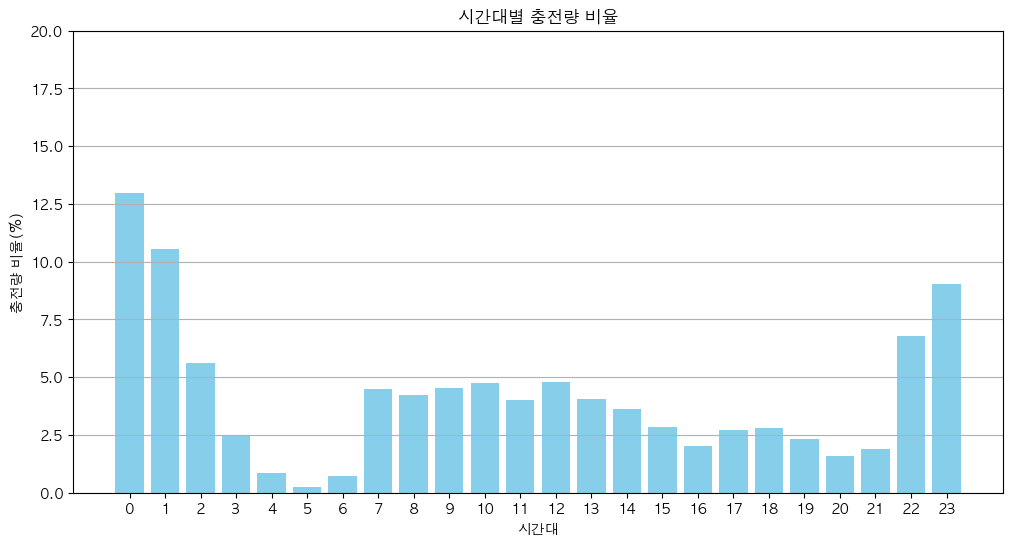

In [483]:
plt.figure(figsize=(12, 6))
plt.bar(sumdf['시간대'], sumdf['충전량 비율(%)'],color='skyblue')
plt.xlabel('시간대')
plt.ylabel('충전량 비율(%)')
plt.title('시간대별 충전량 비율')
plt.xticks(range(0,24,1))
plt.ylim(0,20)
plt.grid(axis='y')
plt.show()

In [446]:
h_df.to_excel('차량별 일자별 시간대별 집계.xlsx', index=False)
a_h_df.to_excel('일자별 시간대별 집계.xlsx', index=False)
sumdf.to_excel('시간대별 집계.xlsx', index=False)

In [24]:
h_df = pd.read_excel('/Users/yurim/Downloads/유리미/차량별 일자별 시간대별 집계.xlsx')

In [27]:
def season(date):
    if date.month in [3,4,5,6]:
        return '춘계'
    elif date.month in [7,8]:
        return '하계'
    elif date.month in [9,10,11]:
        return '추계'
    else:
        return '동계'
    
h_df['계절'] = h_df['시간'].apply(season)
h_df

시간  충전량(kWh)  충전대수       차량번호  시간대  계절
0      2023-01-01 00:00:00       0.0     0  경기70바1254    0  동계
1      2023-01-01 01:00:00       0.0     0  경기70바1254    1  동계
2      2023-01-01 02:00:00       0.0     0  경기70바1254    2  동계
3      2023-01-01 03:00:00       0.0     0  경기70바1254    3  동계
4      2023-01-01 04:00:00       0.0     0  경기70바1254    4  동계
...                    ...       ...   ...        ...  ...  ..
822401 2023-12-31 08:00:00       0.0     0  경기70바2409    8  동계
822402 2023-12-31 09:00:00       0.0     0  경기70바2409    9  동계
822403 2023-12-31 10:00:00       0.0     0  경기70바2409   10  동계
822404 2023-12-31 11:00:00       0.0     0  경기70바2409   11  동계
822405 2023-12-31 12:00:00       0.0     0  경기70바2409   12  동계

[822406 rows x 6 columns]

In [28]:
h_df['시간대'] = h_df['시간'].dt.hour

sumdf = h_df.groupby(['시간대','계절']).agg({
    '충전량(kWh)': 'sum',
}).reset_index()

te = sumdf['충전량(kWh)'].sum()
sumdf['충전량 비율(%)'] = sumdf.groupby(['계절'])['충전량(kWh)'].transform(lambda x: 100*x / x.sum())

sumdf

시간대  계절       충전량(kWh)  충전량 비율(%)
0     0  동계  214707.469279  11.886366
1     0  추계  200866.092366  13.579279
2     0  춘계  288398.736666  14.203041
3     0  하계  127263.966683  11.742638
4     1  동계  153965.854190   8.523664
..  ...  ..            ...        ...
91   22  하계   71679.275673   6.613842
92   23  동계  148710.903662   8.232746
93   23  추계  139354.577443   9.420877
94   23  춘계  199130.415773   9.806761
95   23  하계   91951.177208   8.484330

[96 rows x 4 columns]

In [29]:
a = sumdf.groupby(['계절','시간대']).sum().reset_index()
a

계절  시간대       충전량(kWh)  충전량 비율(%)
0   동계    0  214707.469279  11.886366
1   동계    1  153965.854190   8.523664
2   동계    2   69120.783365   3.826578
3   동계    3   30027.294768   1.662333
4   동계    4   10189.440117   0.564095
..  ..  ...            ...        ...
91  하계   19   36490.364773   3.366964
92  하계   20   22412.833974   2.068031
93  하계   21   21414.399510   1.975905
94  하계   22   71679.275673   6.613842
95  하계   23   91951.177208   8.484330

[96 rows x 4 columns]

In [777]:
a.to_excel('계절별 시간대별 통계.xlsx', index=False)

In [9]:
sumdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시간대        96 non-null     int32  
 1   계절         96 non-null     object 
 2   충전량(kWh)   96 non-null     float64
 3   충전량 비율(%)  96 non-null     float64
dtypes: float64(2), int32(1), object(1)
memory usage: 2.8+ KB


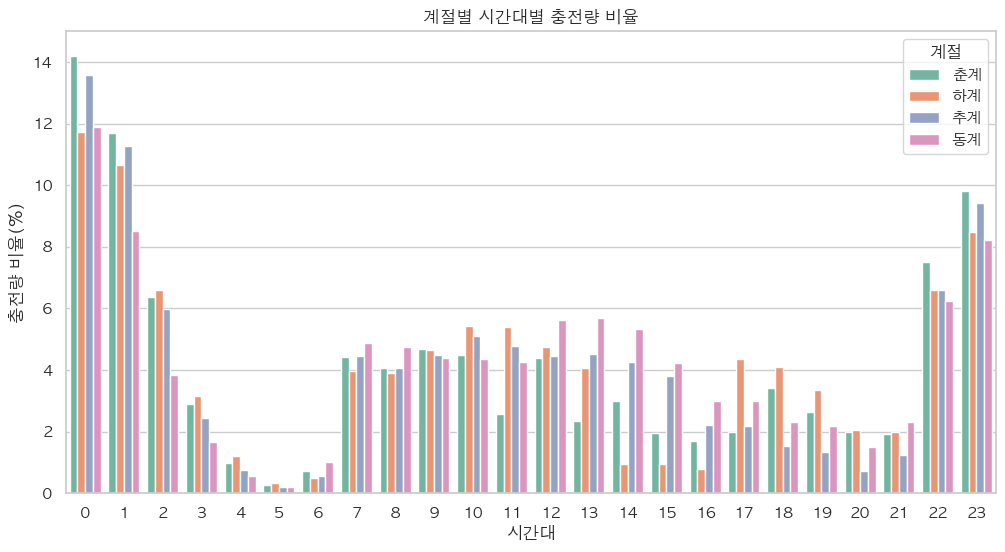

In [11]:
season_order = ['춘계', '하계', '추계', '동계']

sns.set_theme(
    style='whitegrid',
    palette='Set2',
    font='AppleGothic',
    rc={'figure.figsize':(12,6),
        'axes.unicode_minus':False}
)
sns.barplot(x='시간대', y='충전량 비율(%)', data=sumdf, hue='계절', hue_order=season_order)

plt.xlabel('시간대')
plt.ylabel('충전량 비율(%)')
plt.title('계절별 시간대별 충전량 비율')
plt.xticks(range(0,24,1))
plt.ylim(0,15)
plt.show()

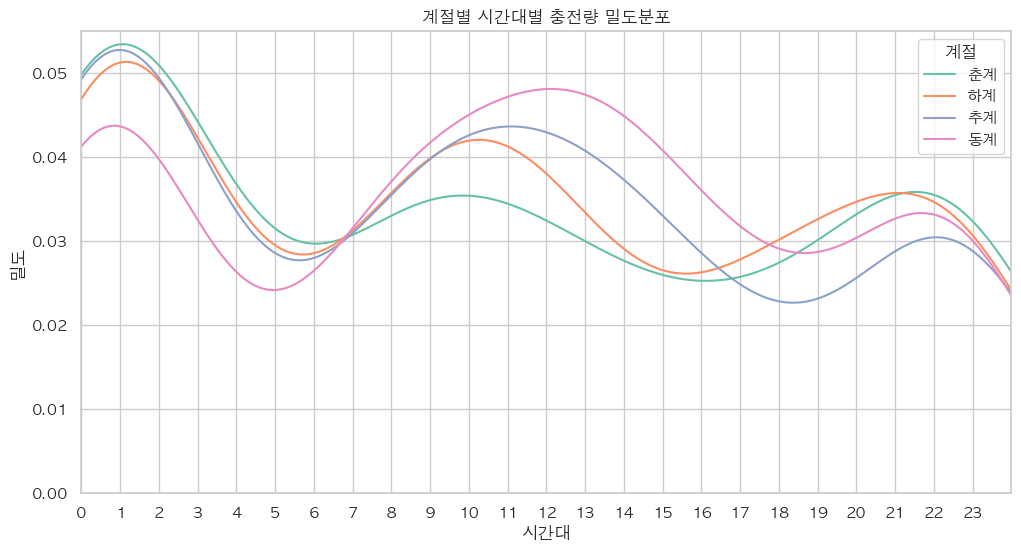

In [35]:
season_order = ['춘계', '하계', '추계', '동계']

sns.set_theme(
    style='whitegrid',
    palette='Set2',
    font='AppleGothic',
    rc={'figure.figsize':(12,6),
        'axes.unicode_minus':False}
)

# 계절별로 KDE Plot 그리기
for season in season_order:
    sns.kdeplot(
        data=sumdf[sumdf['계절'] == season], 
        x='시간대', 
        weights='충전량 비율(%)', 
        label=season, 
        bw_adjust=0.5,
        clip=(0, 24)
    )

plt.xlabel('시간대')
plt.ylabel('밀도')
plt.title('계절별 시간대별 충전량 밀도분포')
plt.xticks(range(0, 24, 1))
plt.xlim(0, 24)
plt.ylim(0, None)
plt.legend(title='계절')
plt.show()


### 전기버스 충전 특성(집계분석) - 단일노선

In [637]:
df_pdf

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80843  경기70바1969  30     10         A      10_A 2023-12-28 16:59:21   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  주말하행첫차  \
0     2023-01-02 18:33:29       16.16      2657           88  ...   06:20   
1     2023-01-03 12:30:34       87.28      8510           60  ...   06:20   
2     2023-01-03 16:25:15       28.24      4643           69  ...   06:20   
3     2023-01-04 02:11:29      183.32     15986           19  ...   06:20   
4     2023-01-04 12:12:15       72.00      9262           58  ...   06:20   
...                   ...         ...       ...          ...  ...     ...   
80843 2023-12-28 17:07:45       13.24         0           87  ...   05:45   
80844 2023-12-29 07:35:58       44.16         0           62  ...   05:45   
80845 2023-12-29 10:38:28       64.56         0           57  ...   05:45   
80846 2023-12-29 16:40:36       21.08         0           63  ...   05:45   
80847 2023-12-30 00:07:47      120.56         0           20  ...   05:45   

       주중상행막차 주말상행막차  주중하행막차 주말하행막차  운행시작시간_주중 운행종료시간_주중 운행시작시간_주말  운행종료시간_주말  \
0       22:10  22:10   23:35  23:35      04:50     23:35     04:50      23:35   
1       22:10  22:10   23:35  23:35      04:50     23:35     04:50      23:35   
2       22:10  22:10   23:35  23:35      04:50     23:35     04:50      23:35   
3       22:10  22:10   23:35  23:35      04:50     23:35     04:50      23:35   
4       22:10  22:10   23:35  23:35      04:50     23:35     04:50      23:35   
...       ...    ...     ...    ...        ...       ...       ...        ...   
80843   22:45  22:45   23:40  23:40      04:50     23:40     04:50      23:40   
80844   22:45  22:45   23:40  23:40      04:50     23:40     04:50      23:40   
80845   22:45  22:45   23:40  23:40      04:50     23:40     04:50      23:40   
80846   22:45  22:45   23:40  23:40      04:50     23:40     04:50      23:40   
80847   22:45  22:45   23:40  23:40      04:50     23:40     04:50      23:40   

         충전소요시간_분  
0       14.016667  
1       29.966667  
2       12.916667  
3      120.483333  
4       23.183333  
...           ...  
80843    8.400000  
80844   15.100000  
80845   22.733333  
80846   14.266667  
80847   82.116667  

[78928 rows x 33 columns]

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)
df

#### 충전빈도 집계

In [731]:
df_pdf['충전일자'] = pd.to_datetime(df_pdf['충전일자'])

/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/397923216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pdf['충전일자'] = pd.to_datetime(df_pdf['충전일자'])


In [644]:
stt = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max'),
]

results = []

for col_name, agg_func in stt:
    temp_df = df_pdf.groupby(['충전일자', '차량번호'])['노선명'].count().reset_index()
    temp_df = temp_df.groupby('충전일자')['노선명'].agg(agg_func).reset_index()
    temp_df.rename(columns={'노선명': col_name}, inplace=True)
    results.append(temp_df)

result = results[0]
for temp_df in results[1:]:
    result = pd.merge(result, temp_df, on='충전일자')

result

충전일자        평균      표준편차  중앙값  최솟값  최댓값
0   2023-01-01  3.340000  1.880187  4.0    1    6
1   2023-01-02  4.079365  1.516592  4.0    1    7
2   2023-01-03  4.107692  1.705900  5.0    1    7
3   2023-01-04  4.646154  1.624334  5.0    1    7
4   2023-01-05  4.196970  1.480329  4.5    1    6
..         ...       ...       ...  ...  ...  ...
360 2023-12-27  4.393443  1.381770  5.0    1    7
361 2023-12-28  4.049180  1.596102  4.0    1    7
362 2023-12-29  3.241379  1.478624  3.0    1    7
363 2023-12-30  3.145833  1.637195  3.0    1    7
364 2023-12-31  2.545455  1.302137  2.0    1    5

[365 rows x 6 columns]

In [645]:
result['월'] = result['충전일자'].dt.month
result

충전일자        평균      표준편차  중앙값  최솟값  최댓값   월
0   2023-01-01  3.340000  1.880187  4.0    1    6   1
1   2023-01-02  4.079365  1.516592  4.0    1    7   1
2   2023-01-03  4.107692  1.705900  5.0    1    7   1
3   2023-01-04  4.646154  1.624334  5.0    1    7   1
4   2023-01-05  4.196970  1.480329  4.5    1    6   1
..         ...       ...       ...  ...  ...  ...  ..
360 2023-12-27  4.393443  1.381770  5.0    1    7  12
361 2023-12-28  4.049180  1.596102  4.0    1    7  12
362 2023-12-29  3.241379  1.478624  3.0    1    7  12
363 2023-12-30  3.145833  1.637195  3.0    1    7  12
364 2023-12-31  2.545455  1.302137  2.0    1    5  12

[365 rows x 7 columns]

In [646]:
#월별 충전빈도
a = result.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a

월        평균      표준편차       중앙값       최솟값       최댓값
0    1  3.962517  1.644741  4.258065  1.000000  6.838710
1    2  3.892579  1.572406  4.035714  1.000000  6.785714
2    3  3.543887  1.514643  3.838710  1.000000  6.483871
3    4  3.320236  1.505716  3.500000  1.000000  6.300000
4    5  3.363391  1.528640  3.596774  1.000000  6.290323
5    6  3.446359  1.522699  3.716667  1.033333  6.300000
6    7  3.550096  1.598447  3.790323  1.000000  6.483871
7    8  3.624888  1.568455  3.935484  1.000000  6.483871
8    9  3.538216  1.583316  3.800000  1.000000  6.400000
9   10  3.200397  1.416747  3.419355  1.000000  5.903226
10  11  3.703544  1.565999  3.933333  1.000000  6.466667
11  12  3.926327  1.617019  4.145161  1.000000  6.709677

In [647]:
#일별 충전빈도
da = result[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da.columns = ['항목', '1일 충전빈도']
da

항목   1일 충전빈도
0    평균  3.587834
1  표준편차  1.553175
2   중앙값  3.830137
3   최솟값  1.002740
4   최댓값  6.452055

#### 충전량 집계

In [648]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df_pdf.groupby(['충전일자', '차량번호'])['충전전력량(kWh)'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전전력량(kWh)'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전전력량(kWh)': col_name}, inplace=True)
    results.append(temp_df)

result2 = results[0]
for temp_df in results[1:]:
    result2 = pd.merge(result2, temp_df, on='충전일자')

result2


충전일자          평균        표준편차       중앙값     최솟값     최댓값
0   2023-01-01  254.318400  117.470820  275.3800   50.56  493.52
1   2023-01-02  303.970794  123.399281  326.1000   13.32  517.76
2   2023-01-03  323.039538  124.815650  349.2000   49.60  563.56
3   2023-01-04  323.801846   95.794624  339.3200  119.44  521.00
4   2023-01-05  313.657879  104.062994  336.2400   81.36  520.20
..         ...         ...         ...       ...     ...     ...
360 2023-12-27  302.141393  104.084163  312.9200    9.48  550.52
361 2023-12-28  294.582885  110.772710  322.9910   13.24  484.56
362 2023-12-29  218.408034  102.338002  225.7800   28.32  464.01
363 2023-12-30  240.904875   93.517143  231.9815  104.92  405.88
364 2023-12-31  162.408386   82.548265  139.7095   27.44  340.12

[365 rows x 6 columns]

In [649]:
result2['월'] = result2['충전일자'].dt.month

In [650]:
#월별 충전량
a2 = result2.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a2

월          평균        표준편차         중앙값        최솟값         최댓값
0    1  296.353431  113.248118  314.843548  52.721935  522.385161
1    2  279.153044  102.854884  291.205179  42.784286  493.481786
2    3  241.834333   96.810427  246.371452  33.975806  455.535484
3    4  225.547615   94.095171  230.087333  32.494667  442.948333
4    5  222.464239   93.370127  231.199677  37.217419  427.980968
5    6  232.289036   97.378975  240.967000  28.753333  446.399667
6    7  240.224419  103.450709  252.435323  28.078387  469.250000
7    8  247.677079  104.327131  262.955323  23.548710  474.605161
8    9  232.434354   97.473098  242.000500  41.988000  441.078000
9   10  214.957794   92.531956  223.377258  18.323226  422.795161
10  11  260.100700  102.694073  273.342167  40.060333  472.902333
11  12  281.646536  109.192591  295.544871  41.790968  502.546871

In [651]:
#일별 충전량
da2 = result2[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da2.columns = ['항목', '1일 충전량']
da2

항목      1일 충전량
0    평균  247.746107
1  표준편차  100.630244
2   중앙값  258.559468
3   최솟값   35.074521
4   최댓값  464.233981

In [652]:
result2.to_excel('365일 충전량 집계.xlsx', index=False)

#### 충전시간 집계

In [653]:
df_pdf.dtypes

차량번호                    object
노선명                     object
충전기ID                    int64
OUTLET ID               object
충전기ID_충전구               object
충전시작시각          datetime64[ns]
충전종료시각          datetime64[ns]
충전전력량(kWh)             float64
충전 요금(원)                 int64
충전시작 SOC(%)              int64
충전종료 SOC(%)              int64
충전 인터벌(시간)             float64
충전소요시간_수정      timedelta64[ns]
SOC종료-시작_수정              int64
충전일자            datetime64[ns]
월                        int32
요일                      object
주중/주말                   object
왕복운행거리                 float64
인가거리                   float64
주중상행첫차                  object
주말상행첫차                  object
주중하행첫차                  object
주말하행첫차                  object
주중상행막차                  object
주말상행막차                  object
주중하행막차                  object
주말하행막차                  object
운행시작시간_주중               object
운행종료시간_주중               object
운행시작시간_주말               object
운행종료시간_주말               object
충전소요시간_분

In [732]:
df_pdf['충전소요시간_수정'] = pd.to_timedelta(df_pdf['충전소요시간_수정'])
df_pdf['충전소요시간_시간'] = df_pdf['충전소요시간_수정'].dt.total_seconds() / 3600

/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/2518718880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pdf['충전소요시간_수정'] = pd.to_timedelta(df_pdf['충전소요시간_수정'])
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/2518718880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pdf['충전소요시간_시간'] = df_pdf['충전소요시간_수정'].dt.total_seconds() / 3600


In [655]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df_pdf.groupby(['충전일자', '차량번호'])['충전소요시간_분'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전소요시간_분'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전소요시간_분': col_name}, inplace=True)
    results.append(temp_df)

result3 = results[0]
for temp_df in results[1:]:
    result3 = pd.merge(result3, temp_df, on='충전일자')

result3

충전일자          평균       표준편차         중앙값        최솟값         최댓값
0   2023-01-01  134.971667  54.587798  154.908333  31.900000  265.650000
1   2023-01-02  136.543915  65.906234  124.316667   9.516667  271.250000
2   2023-01-03  158.089744  66.402326  169.283333  31.466667  310.883333
3   2023-01-04  157.106154  55.970947  166.983333  47.483333  292.283333
4   2023-01-05  169.330556  61.254793  180.416667  51.683333  306.900000
..         ...         ...        ...         ...        ...         ...
360 2023-12-27  152.852459  66.247323  156.983333   6.683333  315.216667
361 2023-12-28  154.641530  69.574818  168.966667   8.400000  314.350000
362 2023-12-29  117.192816  65.183250  125.716667  16.100000  269.266667
363 2023-12-30  125.501389  49.178719  109.366667  51.733333  241.933333
364 2023-12-31   89.226894  52.036233   82.683333  18.183333  209.000000

[365 rows x 6 columns]

In [656]:
#월별 충전시간
result3['월'] = result3['충전일자'].dt.month
a3 = result3.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a3

월          평균       표준편차         중앙값        최솟값         최댓값
0    1  154.430548  64.842937  162.263172  27.829032  305.571505
1    2  153.117974  63.448803  160.542560  20.903571  305.338095
2    3  140.267988  63.762787  144.993280  17.368817  301.226882
3    4  137.273005  65.919023  139.690833  15.887778  308.347222
4    5  137.731288  66.422427  142.777688  20.498387  306.630645
5    6  144.046689  71.761619  144.662500  16.591667  334.505000
6    7  151.146480  77.461837  153.854301  16.901613  353.697312
7    8  154.126042  77.881230  156.065860  13.353226  355.001075
8    9  145.674621  72.464814  146.752778  21.813889  339.600000
9   10  131.414435  66.589138  134.912097  11.043548  302.575806
10  11  143.921335  66.013138  146.612500  21.493889  306.395000
11  12  148.056987  65.870126  152.927419  24.383871  311.832258

In [657]:
#일별 충전시간
da3 = result3[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da3.columns = ['항목', '1일 충전시간(분)']
da3

항목  1일 충전시간(분)
0    평균  145.060711
1  표준편차   68.572792
2   중앙값  148.790023
3   최솟값   18.990822
4   최댓값  319.308174

In [658]:
result3.to_excel('365일 충전시간 집계.xlsx')

In [659]:
da_f = da.merge(da2, on='항목')
da_f = da_f.merge(da3, on='항목')
da_f

항목   1일 충전빈도      1일 충전량  1일 충전시간(분)
0    평균  3.587834  247.746107  145.060711
1  표준편차  1.553175  100.630244   68.572792
2   중앙값  3.830137  258.559468  148.790023
3   최솟값  1.002740   35.074521   18.990822
4   최댓값  6.452055  464.233981  319.308174

In [660]:
da_f.to_excel('전기버스 충전특성 기초통계.xlsx')

In [661]:
a_f = a.merge(a2, on='월')
a_f = a_f.merge(a3, on='월')
a_f

월      평균_x    표준편차_x     중앙값_x     최솟값_x     최댓값_x        평균_y  \
0    1  3.962517  1.644741  4.258065  1.000000  6.838710  296.353431   
1    2  3.892579  1.572406  4.035714  1.000000  6.785714  279.153044   
2    3  3.543887  1.514643  3.838710  1.000000  6.483871  241.834333   
3    4  3.320236  1.505716  3.500000  1.000000  6.300000  225.547615   
4    5  3.363391  1.528640  3.596774  1.000000  6.290323  222.464239   
5    6  3.446359  1.522699  3.716667  1.033333  6.300000  232.289036   
6    7  3.550096  1.598447  3.790323  1.000000  6.483871  240.224419   
7    8  3.624888  1.568455  3.935484  1.000000  6.483871  247.677079   
8    9  3.538216  1.583316  3.800000  1.000000  6.400000  232.434354   
9   10  3.200397  1.416747  3.419355  1.000000  5.903226  214.957794   
10  11  3.703544  1.565999  3.933333  1.000000  6.466667  260.100700   
11  12  3.926327  1.617019  4.145161  1.000000  6.709677  281.646536   

        표준편차_y       중앙값_y      최솟값_y       최댓값_y          평균       표준편차  \
0   113.248118  314.843548  52.721935  522.385161  154.430548  64.842937   
1   102.854884  291.205179  42.784286  493.481786  153.117974  63.448803   
2    96.810427  246.371452  33.975806  455.535484  140.267988  63.762787   
3    94.095171  230.087333  32.494667  442.948333  137.273005  65.919023   
4    93.370127  231.199677  37.217419  427.980968  137.731288  66.422427   
5    97.378975  240.967000  28.753333  446.399667  144.046689  71.761619   
6   103.450709  252.435323  28.078387  469.250000  151.146480  77.461837   
7   104.327131  262.955323  23.548710  474.605161  154.126042  77.881230   
8    97.473098  242.000500  41.988000  441.078000  145.674621  72.464814   
9    92.531956  223.377258  18.323226  422.795161  131.414435  66.589138   
10  102.694073  273.342167  40.060333  472.902333  143.921335  66.013138   
11  109.192591  295.544871  41.790968  502.546871  148.056987  65.870126   

           중앙값        최솟값         최댓값  
0   162.263172  27.829032  305.571505  
1   160.542560  20.903571  305.338095  
2   144.993280  17.368817  301.226882  
3   139.690833  15.887778  308.347222  
4   142.777688  20.498387  306.630645  
5   144.662500  16.591667  334.505000  
6   153.854301  16.901613  353.697312  
7   156.065860  13.353226  355.001075  
8   146.752778  21.813889  339.600000  
9   134.912097  11.043548  302.575806  
10  146.612500  21.493889  306.395000  
11  152.927419  24.383871  311.832258

In [662]:
a_f.to_excel('월별 전기버스 충전특성 기초통계.xlsx', index=False)

#### 계절별 기초통계

In [663]:
result['충전일자'] = pd.to_datetime(result['충전일자'])
result2['충전일자'] = pd.to_datetime(result2['충전일자'])
result3['충전일자'] = pd.to_datetime(result3['충전일자'])

In [664]:
#충전빈도
def season(date):
    if date.month in [3,4,5,6]:
        return '춘계'
    elif date.month in [7,8]:
        return '하계'
    elif date.month in [9,10,11]:
        return '추계'
    else:
        return '동계'
    
result['계절'] = result['충전일자'].apply(season)

sa = result.groupby('계절').agg({
    '평균': 'mean',
    '표준편차': 'mean'
}).reset_index()
sa

계절        평균      표준편차
0  동계  3.928293  1.612688
1  추계  3.477638  1.520864
2  춘계  3.419045  1.517985
3  하계  3.587492  1.583451

In [665]:
#충전량
result2['계절'] = result2['충전일자'].apply(season)

sa2 = result2.groupby('계절').agg({
    '평균': 'mean',
    '표준편차': 'mean'
}).reset_index()
sa2

계절          평균        표준편차
0  동계  285.936491  108.617764
1  추계  235.601574   97.511052
2  춘계  230.560289   95.408373
3  하계  243.950749  103.888920

In [666]:
#충전시간
result3['계절'] = result3['충전일자'].apply(season)

sa3 = result3.groupby('계절').agg({
    '평균': 'mean',
    '표준편차': 'mean'
}).reset_index()
sa3

계절          평균       표준편차
0  동계  151.826854  64.763016
1  추계  140.238749  68.336284
2  춘계  139.816134  66.935745
3  하계  152.636261  77.671533

In [667]:
sa_t = sa.merge(sa2, on='계절')
sa_t = sa_t.merge(sa3, on='계절')
sa_t

계절      평균_x    표준편차_x        평균_y      표준편차_y          평균       표준편차
0  동계  3.928293  1.612688  285.936491  108.617764  151.826854  64.763016
1  추계  3.477638  1.520864  235.601574   97.511052  140.238749  68.336284
2  춘계  3.419045  1.517985  230.560289   95.408373  139.816134  66.935745
3  하계  3.587492  1.583451  243.950749  103.888920  152.636261  77.671533

In [668]:
sa_t.to_excel('계절별 충전 특성 기초통계.xlsx', index=False)

### 차량별 충전빈도 - 단일노선

In [76]:
dfcp = df_pdf.copy()
dfcp

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80871  경기70바2409  98     19         A      19_A 2023-12-28 12:53:12   
80872  경기70바2409  98     23         A      23_A 2023-12-28 17:02:56   
80873  경기70바2409  98     33         A      33_A 2023-12-29 08:31:43   
80874  경기70바2409  98     33         A      33_A 2023-12-29 12:49:38   
80875  경기70바2409  98     16         B      16_B 2023-12-30 00:39:25   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80871 2023-12-28 13:25:49       96.20         0           54           95   
80872 2023-12-28 17:27:30       37.20         0           69           85   
80873 2023-12-29 08:59:17       82.20         0           61           95   
80874 2023-12-29 13:19:17       82.88         0           61           95   
80875 2023-12-30 02:25:39      159.28         0           27           95   

       충전 인터벌(시간)       충전소요시간_수정  SOC종료-시작_수정        충전일자   월 요일 주중/주말  \
0             NaN 0 days 00:14:01            7  2023-01-02   1  월    주중   
1       17.451944 0 days 00:29:58           35  2023-01-03   1  화    주중   
2        3.696111 0 days 00:12:55           12  2023-01-03   1  화    주중   
3        7.762500 0 days 02:00:29           76  2023-01-04   1  수    주중   
4        9.626389 0 days 00:23:11           29  2023-01-04   1  수    주중   
...           ...             ...          ...         ...  .. ..   ...   
80871    3.398611 0 days 00:32:37           41  2023-12-28  12  목    주중   
80872    3.618611 0 days 00:24:34           16  2023-12-28  12  목    주중   
80873   15.070278 0 days 00:27:34           34  2023-12-29  12  금    주중   
80874    3.839167 0 days 00:29:39           34  2023-12-29  12  금    주중   
80875   11.335556 0 days 01:46:14           68  2023-12-30  12  토    주말   

         충전소요시간_분  
0       14.016667  
1       29.966667  
2       12.916667  
3      120.483333  
4       23.183333  
...           ...  
80871   32.616667  
80872   24.566667  
80873   27.566667  
80874   29.650000  
80875  106.233333  

[78928 rows x 19 columns]

In [78]:
dfcp['충전일자'] = pd.to_datetime(dfcp['충전일자'])

In [79]:
dfcp['차량번호'].value_counts()

차량번호
경기70바1923    1589
경기70바1890    1480
경기70바1925    1441
경기70바1914    1431
경기70바1930    1431
             ... 
경기70바1698     664
경기70바1854     642
경기70바1864     606
경기70바1787     485
경기70바1254     371
Name: count, Length: 71, dtype: int64

In [675]:
dftest = dfcp.sort_values(by=['차량번호', '충전시작시각'])

op = dftest.groupby('차량번호').agg(
    충전시작=('충전시작시각', 'min'),
    충전종료=('충전종료시각', 'max'),
    충전세션=('충전시작시각', 'count')
).reset_index()

op['운행기간'] = op['충전종료'] - op['충전시작']

ct = 5
f = op[op['충전세션'] >= ct]

f_df = dftest[dftest['차량번호'].isin(f['차량번호'])]

for v_number, v_data in f_df.groupby('차량번호'):
    print(f"차량번호: {v_number}")
    print(v_data[['차량번호', '충전일자', '충전시작시각', '충전종료시각']])
    print("\n")

f

차량번호: 경기70바1254
          차량번호       충전일자              충전시작시각              충전종료시각
0    경기70바1254 2023-01-02 2023-01-02 18:19:28 2023-01-02 18:33:29
1    경기70바1254 2023-01-03 2023-01-03 12:00:36 2023-01-03 12:30:34
2    경기70바1254 2023-01-03 2023-01-03 16:12:20 2023-01-03 16:25:15
3    경기70바1254 2023-01-04 2023-01-04 00:11:00 2023-01-04 02:11:29
4    경기70바1254 2023-01-04 2023-01-04 11:49:04 2023-01-04 12:12:15
..         ...        ...                 ...                 ...
366  경기70바1254 2023-09-20 2023-09-20 22:55:34 2023-09-21 00:59:18
367  경기70바1254 2023-09-21 2023-09-21 08:53:43 2023-09-21 09:24:39
368  경기70바1254 2023-09-21 2023-09-21 13:12:17 2023-09-21 13:31:35
369  경기70바1254 2023-09-21 2023-09-21 17:30:49 2023-09-21 17:53:44
370  경기70바1254 2023-09-22 2023-09-22 01:13:23 2023-09-22 02:50:03

[371 rows x 4 columns]


차량번호: 경기70바1650
           차량번호       충전일자              충전시작시각              충전종료시각
371   경기70바1650 2023-01-01 2023-01-01 09:08:41 2023-01-01 09:35:14
372   경기70바1650 

차량번호                충전시작                충전종료  충전세션              운행기간
0   경기70바1254 2023-01-02 18:19:28 2023-09-22 02:50:03   371 262 days 08:30:35
1   경기70바1650 2023-01-01 09:08:41 2023-12-31 23:51:28   765 364 days 14:42:47
2   경기70바1675 2023-01-02 14:25:52 2023-12-30 03:52:20   717 361 days 13:26:28
3   경기70바1686 2023-01-01 01:10:09 2023-12-31 00:57:06   831 363 days 23:46:57
4   경기70바1687 2023-01-02 09:26:43 2023-12-30 02:57:34   743 361 days 17:30:51
..        ...                 ...                 ...   ...               ...
66  경기70바1967 2023-01-01 00:00:00 2023-12-31 17:02:26  1369 364 days 17:02:26
67  경기70바1968 2023-01-01 09:15:23 2023-12-30 19:19:40  1369 363 days 10:04:17
68  경기70바1969 2023-01-01 00:00:00 2023-12-30 00:07:47  1323 363 days 00:07:47
69  경기70바2408 2023-01-02 10:56:44 2023-12-29 08:43:45   722 360 days 21:47:01
70  경기70바2409 2023-01-01 00:00:00 2023-12-30 02:25:39   698 363 days 02:25:39

[71 rows x 5 columns]

In [676]:
#노선별 충전일자 확인
dftest = dfcp.sort_values(by=['노선명', '충전시작시각'])

op = dftest.groupby('노선명').agg(
    충전시작=('충전시작시각', 'min'),
    충전종료=('충전종료시각', 'max'),
    충전세션=('충전시작시각', 'count')
).reset_index()

op['운행기간'] = op['충전종료'] - op['충전시작']

ct = 5
f = op[op['충전세션'] >= ct]

f

노선명       충전시작                충전종료   충전세션              운행기간
0    25 2023-01-01 2023-12-31 18:46:09  10164 364 days 18:46:09
1    27 2023-01-01 2023-12-31 18:14:02   2767 364 days 18:14:02
2    30 2023-01-01 2023-12-31 18:10:03  12414 364 days 18:10:03
3  30-1 2023-01-01 2023-12-31 20:11:31  13955 364 days 20:11:31
4    42 2023-01-01 2023-12-31 22:44:32  11135 364 days 22:44:32
5     5 2023-01-01 2023-12-31 21:17:39  15379 364 days 21:17:39
6    98 2023-01-01 2023-12-31 23:51:28  13114 364 days 23:51:28

In [678]:
n = op[(op['충전세션'] >= 5) & (op['운행기간'] >= pd.Timedelta(days=100))]
n

노선명       충전시작                충전종료   충전세션              운행기간
0    25 2023-01-01 2023-12-31 18:46:09  10164 364 days 18:46:09
1    27 2023-01-01 2023-12-31 18:14:02   2767 364 days 18:14:02
2    30 2023-01-01 2023-12-31 18:10:03  12414 364 days 18:10:03
3  30-1 2023-01-01 2023-12-31 20:11:31  13955 364 days 20:11:31
4    42 2023-01-01 2023-12-31 22:44:32  11135 364 days 22:44:32
5     5 2023-01-01 2023-12-31 21:17:39  15379 364 days 21:17:39
6    98 2023-01-01 2023-12-31 23:51:28  13114 364 days 23:51:28

#### 1일 충전시간 분포

In [ ]:
uqv = df['차량번호'].unique()

for vehicle in uqv:
    vhd = df[df['차량번호'] == vehicle]
    
    # 시각화
    g = sns.jointplot(
        x=vhd['충전시작시각'].dt.hour,
        y=vhd['SOC종료-시작_수정'],
        kind='hex', 
        marginal_kws=dict(bins=24, fill=True),
        gridsize=30
    )

    g.figure.set_size_inches(12, 10)
    g.figure.suptitle(f'차량번호 {vehicle}의 1일 충전 시간대 분포', y=1.02)
    g.set_axis_labels('충전시작시각(시)', 'SOC')
    
    plt.xticks(range(0, 24))
    plt.yticks(range(0, 100, 10))

    plt.show()

In [ ]:
uqv = df['차량번호'].unique()

for vehicle in uqv:
    vhd = df[df['차량번호'] == vehicle]
    
    # 시각화
    g = sns.JointGrid(
        x=vhd['충전시작시각'].dt.hour,
        y=vhd['SOC종료-시작_수정']
    )
    g.plot_joint(sns.scatterplot, s=100, alpha=.5, edgecolor='.2', linewidth=.5)
    g.plot_marginals(sns.histplot, kde=True)
    g.figure.set_size_inches(12, 10)
    g.figure.suptitle(f'차량번호 {vehicle}의 1일 충전 시간대 분포', y=1.02)
    g.set_axis_labels('충전시작시각(시)', 'SOC')
    
    plt.xticks(range(0, 24))
    plt.yticks(range(0, 100, 10))

    plt.show()

In [ ]:
df_pdf['시간'] = df_pdf['충전시작시각'].dt.hour

In [680]:
df_pdf.to_excel('시간대 추가.xlsx', index=False)

In [ ]:
df_pdf['충전소요시간_시간'] = df_pdf['충전소요시간_시간'].round(2)


plt.figure(figsize=(10, 6))
sns.histplot(data=df_pdf, x='충전소요시간_시간', hue='차량번호', multiple='stack', binwidth=0.2, shrink=0.8)
plt.xticks(np.arange(0, df['충전소요시간_시간'].max() + 0.5, 0.5))
plt.xlabel('충전 소요시간')
plt.ylabel('빈도')
plt.title('충전시간 빈도')
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/1214711468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pdf['충전소요시간_시간'] = df_pdf['충전소요시간_시간'].round(2)


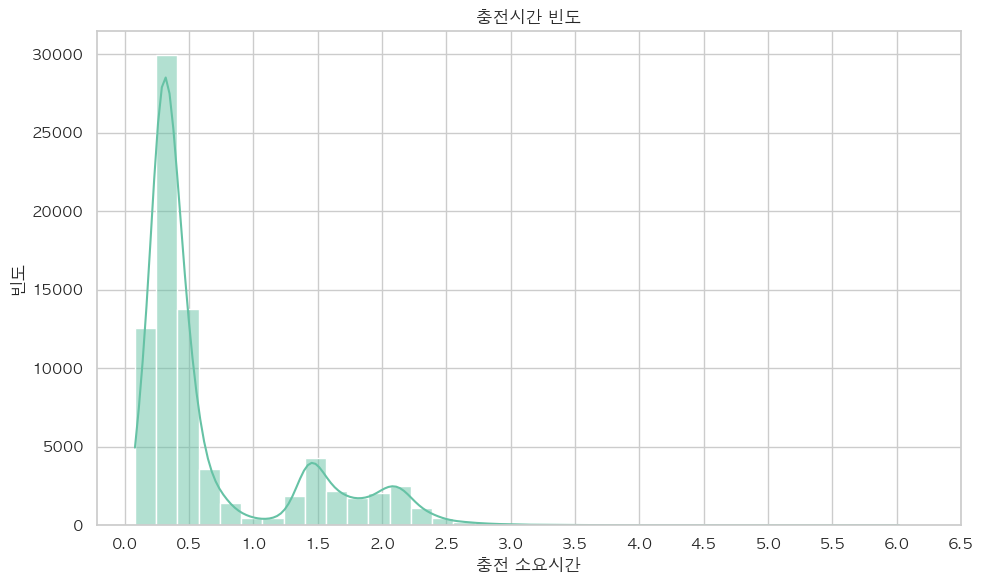

In [683]:
df_pdf['충전소요시간_시간'] = df_pdf['충전소요시간_시간'].round(2)


plt.figure(figsize=(10, 6))
sns.histplot(x=df_pdf['충전소요시간_시간'], bins=36, kde=True, cumulative=False)
plt.xticks(np.arange(0, df_pdf['충전소요시간_시간'].max() + 0.5, 0.5))
plt.xlabel('충전 소요시간')
plt.ylabel('빈도')
plt.title('충전시간 빈도')
plt.tight_layout()
plt.show()


#### 1일 충전시간대분포(uptime/downtime) - 사용X

In [16]:
ss = dfcp.groupby('차량번호').size().reset_index(name='총 충전세션 수')
ss.sort_values(by=['총 충전세션 수'], ascending=False)

차량번호  총 충전세션 수
52  경기70바1923      1589
35  경기70바1890      1480
53  경기70바1925      1441
57  경기70바1930      1431
46  경기70바1914      1431
..        ...       ...
7   경기70바1679       165
8   경기70바1680       145
12  경기70바1684        70
2   경기70바1658        70
6   경기70바1678        58

[82 rows x 2 columns]

In [100]:
df_1 = dfcp[dfcp['차량번호'] == '경기70바1923']

In [101]:
df_1['운행시작시간_주중'] = pd.to_datetime(df_1['운행시작시간_주중']).dt.time
df_1['운행종료시간_주중'] = pd.to_datetime(df_1['운행종료시간_주중']).dt.time
df_1['운행시작시간_주말'] = pd.to_datetime(df_1['운행시작시간_주말']).dt.time
df_1['운행종료시간_주말'] = pd.to_datetime(df_1['운행종료시간_주말']).dt.time

/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/1915959111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['운행시작시간_주중'] = pd.to_datetime(df_1['운행시작시간_주중']).dt.time
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/1915959111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['운행종료시간_주중'] = pd.to_datetime(df_1['운행종료시간_주중']).dt.time
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/1915959111.py:3: SettingWithCopyWarning: 
A value is trying to be s

In [105]:
dfcp['운행시작시간_주중'] = pd.to_datetime(dfcp['운행시작시간_주중']).dt.time
dfcp['운행종료시간_주중'] = pd.to_datetime(dfcp['운행종료시간_주중']).dt.time
dfcp['운행시작시간_주말'] = pd.to_datetime(dfcp['운행시작시간_주말']).dt.time
dfcp['운행종료시간_주말'] = pd.to_datetime(dfcp['운행종료시간_주말']).dt.time

/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/1570348688.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfcp['운행시작시간_주중'] = pd.to_datetime(dfcp['운행시작시간_주중']).dt.time
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/1570348688.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfcp['운행종료시간_주중'] = pd.to_datetime(dfcp['운행종료시간_주중']).dt.time
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/1570348688.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfcp['운행시작시간_주말'] = pd.to_datetime(dfcp['운행시작시간_주말']).dt.time
/var/folde

In [103]:
def create_time_range():
    start = pd.Timestamp('2023-01-01 00:00:00')
    end = pd.Timestamp('2023-12-31 23:59:59')
    time_range = pd.date_range(start=start, end=end, freq='30T')
    return time_range

# 충전 여부
def charging_interval(row):
    time_range = pd.date_range(start=row['충전시작시각'], end=row['충전종료시각'], freq='30T')
    intervals = pd.DataFrame({'timestamp': time_range})
    intervals['차량번호'] = row['차량번호']
    intervals['노선명'] = row['노선명']
    intervals['충전여부'] = 0
    return intervals

charging_intervals_list = df_1.apply(charging_interval, axis=1).tolist()
charging_intervals = pd.concat(charging_intervals_list, ignore_index=True)

full_range = create_time_range()
full_range_df = pd.DataFrame({'timestamp': full_range})
full_range_df['key'] = 0

vehicles = df_1[['차량번호', '노선명']].drop_duplicates()
vehicles['key'] = 0

full_vehicle_range = pd.merge(full_range_df, vehicles, on='key').drop('key', axis=1)

result = pd.merge(full_vehicle_range, charging_intervals, on=['timestamp', '차량번호', '노선명'], how='left')
result['충전여부'] = result['충전여부'].fillna(1).astype(int)


min_start = df_1['충전시작시각'].min().floor('30T')
max_end = df_1['충전종료시각'].max().ceil('30T')
result['분석기간_해당'] = ((result['timestamp'] >= min_start) & (result['timestamp'] <= max_end)).astype(int)
result['충전여부'] = np.where(result['분석기간_해당'] == 0, 99, result['충전여부'])
result = result.drop('분석기간_해당', axis=1)

result

timestamp       차량번호 노선명  충전여부
0     2023-01-01 00:00:00  경기70바1923  42     1
1     2023-01-01 00:30:00  경기70바1923  42     1
2     2023-01-01 01:00:00  경기70바1923  42     1
3     2023-01-01 01:30:00  경기70바1923  42     1
4     2023-01-01 02:00:00  경기70바1923  42     1
...                   ...        ...  ..   ...
17515 2023-12-31 21:30:00  경기70바1923  42    99
17516 2023-12-31 22:00:00  경기70바1923  42    99
17517 2023-12-31 22:30:00  경기70바1923  42    99
17518 2023-12-31 23:00:00  경기70바1923  42    99
17519 2023-12-31 23:30:00  경기70바1923  42    99

[17520 rows x 4 columns]

In [104]:
def is_weekend(timestamp):
    return timestamp.weekday() >= 5

def ctr():
    start = pd.Timestamp('2023-01-01 00:00:00')
    end = pd.Timestamp('2023-12-31 23:59:00')
    tr = pd.date_range(start=start, end=end, freq='30T')
    return tr

def cgi(row):
    tr = pd.date_range(start=row['충전시작시각'].floor('30T'), end=row['충전종료시각'].ceil('30T'), freq='30T')
    intervals = pd.DataFrame({'timestamp': tr})
    intervals['차량번호'] = row['차량번호']
    intervals['노선명'] = row['노선명']
    intervals['충전시작시각'] = row['충전시작시각']
    intervals['충전종료시각'] = row['충전종료시각']
    intervals['충전여부'] = 1
    return intervals

cgi_list = df_1.apply(cgi, axis=1).tolist()
ci = pd.concat(cgi_list, ignore_index=True)

fr = ctr()
fr_df = pd.DataFrame({'timestamp': fr})

v = df_1[['차량번호', '노선명']].drop_duplicates()
v['key'] = 0
fr_df['key'] = 0

fvr = pd.merge(fr_df, v, on='key').drop('key', axis=1)

result = pd.merge(fvr, ci, on=['timestamp', '차량번호', '노선명'], how='left')
result['충전여부'] = result['충전여부'].fillna(0).astype(int)

result['충전시작시각'] = result['충전시작시각'].fillna(pd.NaT)
result['충전종료시각'] = result['충전종료시각'].fillna(pd.NaT)


min_s = df_1['충전시작시각'].min().floor('30T')
max_e = df_1['충전종료시각'].max().ceil('30T')
result['분석기간_해당'] = ((result['timestamp'] >= min_s) & (result['timestamp'] <= max_e)).astype(int)
result['충전여부'] = np.where(result['분석기간_해당'] == 0, 99, result['충전여부'])
result = result.drop('분석기간_해당', axis=1)


def 운행여부(row):
    timestamp = row['timestamp']
    차량번호 = row['차량번호']
    노선명 = row['노선명']

    is_weekend_day = is_weekend(timestamp)
    
    if is_weekend_day:
        운행시작시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행시작시간_주말'].values[0]
        운행종료시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행종료시간_주말'].values[0]
    else:
        운행시작시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행시작시간_주중'].values[0]
        운행종료시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행종료시간_주중'].values[0]
    
    운행시작시각 = datetime.combine(timestamp.date(), time(운행시작시각.hour, 운행시작시각.minute))
    운행종료시각 = datetime.combine(timestamp.date(), time(운행종료시각.hour, 운행종료시각.minute))
    
    if row['충전여부'] == 99:
        return 99
    elif 운행시작시각 <= timestamp <= 운행종료시각:
        return 1
    else:
        return 0

result['운행여부'] = result.apply(운행여부, axis=1)


result

timestamp       차량번호 노선명              충전시작시각  \
0     2023-01-01 00:00:00  경기70바1923  42 2023-01-01 00:29:06   
1     2023-01-01 00:30:00  경기70바1923  42 2023-01-01 00:29:06   
2     2023-01-01 01:00:00  경기70바1923  42 2023-01-01 00:29:06   
3     2023-01-01 01:30:00  경기70바1923  42 2023-01-01 00:29:06   
4     2023-01-01 02:00:00  경기70바1923  42 2023-01-01 00:29:06   
...                   ...        ...  ..                 ...   
17515 2023-12-31 21:30:00  경기70바1923  42                 NaT   
17516 2023-12-31 22:00:00  경기70바1923  42                 NaT   
17517 2023-12-31 22:30:00  경기70바1923  42                 NaT   
17518 2023-12-31 23:00:00  경기70바1923  42                 NaT   
17519 2023-12-31 23:30:00  경기70바1923  42                 NaT   

                   충전종료시각  충전여부  운행여부  
0     2023-01-01 02:01:00     1     0  
1     2023-01-01 02:01:00     1     0  
2     2023-01-01 02:01:00     1     0  
3     2023-01-01 02:01:00     1     0  
4     2023-01-01 02:01:00     1     0  
...                   ...   ...   ...  
17515                 NaT    99    99  
17516                 NaT    99    99  
17517                 NaT    99    99  
17518                 NaT    99    99  
17519                 NaT    99    99  

[17520 rows x 7 columns]

In [106]:
result['충전여부'].value_counts()

충전여부
0     12489
1      4989
99       42
Name: count, dtype: int64

In [107]:
result['운행여부'].value_counts()

운행여부
1     13832
0      3646
99       42
Name: count, dtype: int64

In [59]:
result.to_excel('up_downtime_bus1.xlsx')

In [ ]:
# 차량전체(건수가 많아서 안 돌아감)
def is_weekend(timestamp):
    return timestamp.weekday() >= 5

def ctr():
    start = pd.Timestamp('2023-01-01 00:00:00')
    end = pd.Timestamp('2023-12-31 23:59:00')
    tr = pd.date_range(start=start, end=end, freq='30T')
    return tr

def cgi(row):
    tr = pd.date_range(start=row['충전시작시각'].floor('30T'), end=row['충전종료시각'].ceil('30T'), freq='30T')
    intervals = pd.DataFrame({'timestamp': tr})
    intervals['차량번호'] = row['차량번호']
    intervals['노선명'] = row['노선명']
    intervals['충전시작시각'] = row['충전시작시각']
    intervals['충전종료시각'] = row['충전종료시각']
    intervals['충전여부'] = 1
    return intervals

result_list = []

for 차량번호 in dfcp['차량번호'].unique():
    df_1 = dfcp[dfcp['차량번호'] == 차량번호]
    
    cgi_list = df_1.apply(cgi, axis=1).tolist()
    ci = pd.concat(cgi_list, ignore_index=True)
    
    fr = ctr()
    fr_df = pd.DataFrame({'timestamp': fr})
    
    v = df_1[['차량번호', '노선명']].drop_duplicates()
    v['key'] = 0
    fr_df['key'] = 0
    
    fvr = pd.merge(fr_df, v, on='key').drop('key', axis=1)
    
    result = pd.merge(fvr, ci, on=['timestamp', '차량번호', '노선명'], how='left')
    result['충전여부'] = result['충전여부'].fillna(0).astype(int)
    
    min_s = df_1['충전시작시각'].min().floor('30T')
    max_e = df_1['충전종료시각'].max().ceil('30T')
    result['분석기간_해당'] = ((result['timestamp'] >= min_s) & (result['timestamp'] <= max_e)).astype(int)
    result['충전여부'] = np.where(result['분석기간_해당'] == 0, 99, result['충전여부'])
    result = result.drop('분석기간_해당', axis=1)
    
    def 운행여부(row):
        timestamp = row['timestamp']
        차량번호 = row['차량번호']
        노선명 = row['노선명']

        is_weekend_day = is_weekend(timestamp)
        
        if is_weekend_day:
            운행시작시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행시작시간_주말'].values[0]
            운행종료시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행종료시간_주말'].values[0]
        else:
            운행시작시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행시작시간_주중'].values[0]
            운행종료시각 = df_1.loc[(df_1['차량번호'] == 차량번호) & (df_1['노선명'] == 노선명), '운행종료시간_주중'].values[0]
        
        운행시작시각 = datetime.combine(timestamp.date(), time(운행시작시각.hour, 운행시작시각.minute))
        운행종료시각 = datetime.combine(timestamp.date(), time(운행종료시각.hour, 운행종료시각.minute))
        
        if row['충전여부'] == 99:
            return 99
        elif 운행시작시각 <= timestamp <= 운행종료시각:
            return 1
        else:
            return 0

    result['운행여부'] = result.apply(운행여부, axis=1)

    result_list.append(result)


final_result = pd.concat(result_list, ignore_index=True)

final_result


In [275]:
df['운행시작시간_주중'] = pd.to_datetime(df['운행시작시간_주중']).dt.time
df['운행종료시간_주중'] = pd.to_datetime(df['운행종료시간_주중']).dt.time
df['운행시작시간_주말'] = pd.to_datetime(df['운행시작시간_주말']).dt.time
df['운행종료시간_주말'] = pd.to_datetime(df['운행종료시간_주말']).dt.time

/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/842345918.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['운행시작시간_주중'] = pd.to_datetime(df['운행시작시간_주중']).dt.time
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/842345918.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['운행종료시간_주중'] = pd.to_datetime(df['운행종료시간_주중']).dt.time
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/842345918.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['운행시작시간_주말'] = pd.to_datetime(df['운행시작시간_주말']).dt.time
/var/folders/6f/g2t6ql1s1

In [371]:
def is_uptime(row):
    if row['주중/주말'] == '주중':
        return row['운행시작시간_주중'] <= row['충전시작시각'].time() <= row['운행종료시간_주중']
    else:
        return row['운행시작시간_주말'] <= row['충전시작시각'].time() <= row['운행종료시간_주말']

# 시간대별 충전량 계산 함수
def calculate(df):
    df['Uptime'] = df.apply(is_uptime, axis=1)

    df_uptime = df[df['Uptime']]

    hours = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:59:59', freq='1H')
    hourly_data = []

    for vehicle, group in df_uptime.groupby('차량번호'):
        vehicle_hours = pd.DataFrame({'시간': hours, '충전량(kWh)': 0, '충전대수': 0, '차량번호': vehicle})

        for idx, row in group.iterrows():
            stt = row['충전시작시각']
            edt = row['충전종료시각']
            tte = row['충전전력량(kWh)']

            tth = (edt - stt).total_seconds() / 3600

            crt = stt
            while crt < edt:
                nxt = crt + pd.Timedelta(hours=1)
                if nxt > edt:
                    nxt = edt
                hour_frac = (nxt - crt).total_seconds() / 3600
                hour_e = tte * hour_frac / tth

                hour_idx = vehicle_hours[vehicle_hours['시간'] == crt.replace(minute=0, second=0, microsecond=0)].index
                if not hour_idx.empty:
                    vehicle_hours.loc[hour_idx, '충전량(kWh)'] += hour_e
                    vehicle_hours.loc[hour_idx, '충전대수'] += 1

                crt = nxt
        
        hourly_data.append(vehicle_hours)

    return pd.concat(hourly_data)

# 차량별 시간대별 데이터프레임 생성
hourly_df = calculate(df)

# Uptime 중 차량별 시간대별 충전량 비율 계산
hourly_df['충전량 비율(%)'] = hourly_df.groupby('차량번호')['충전량(kWh)'].transform(lambda x: x / x.sum() * 100)

hourly_df


/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/3801642150.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16.16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vehicle_hours.loc[hour_idx, '충전량(kWh)'] += hour_energy
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/3801642150.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[80.56]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vehicle_hours.loc[hour_idx, '충전량(kWh)'] += hour_energy
/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/3801642150.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[101.88]' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

시간  충전량(kWh)  충전대수       차량번호  충전량 비율(%)
0    2023-01-01 00:00:00       0.0     0  경기70바1254        0.0
1    2023-01-01 01:00:00       0.0     0  경기70바1254        0.0
2    2023-01-01 02:00:00       0.0     0  경기70바1254        0.0
3    2023-01-01 03:00:00       0.0     0  경기70바1254        0.0
4    2023-01-01 04:00:00       0.0     0  경기70바1254        0.0
...                  ...       ...   ...        ...        ...
8755 2023-12-31 19:00:00       0.0     0  경기70바2409        0.0
8756 2023-12-31 20:00:00       0.0     0  경기70바2409        0.0
8757 2023-12-31 21:00:00       0.0     0  경기70바2409        0.0
8758 2023-12-31 22:00:00       0.0     0  경기70바2409        0.0
8759 2023-12-31 23:00:00       0.0     0  경기70바2409        0.0

[718320 rows x 5 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


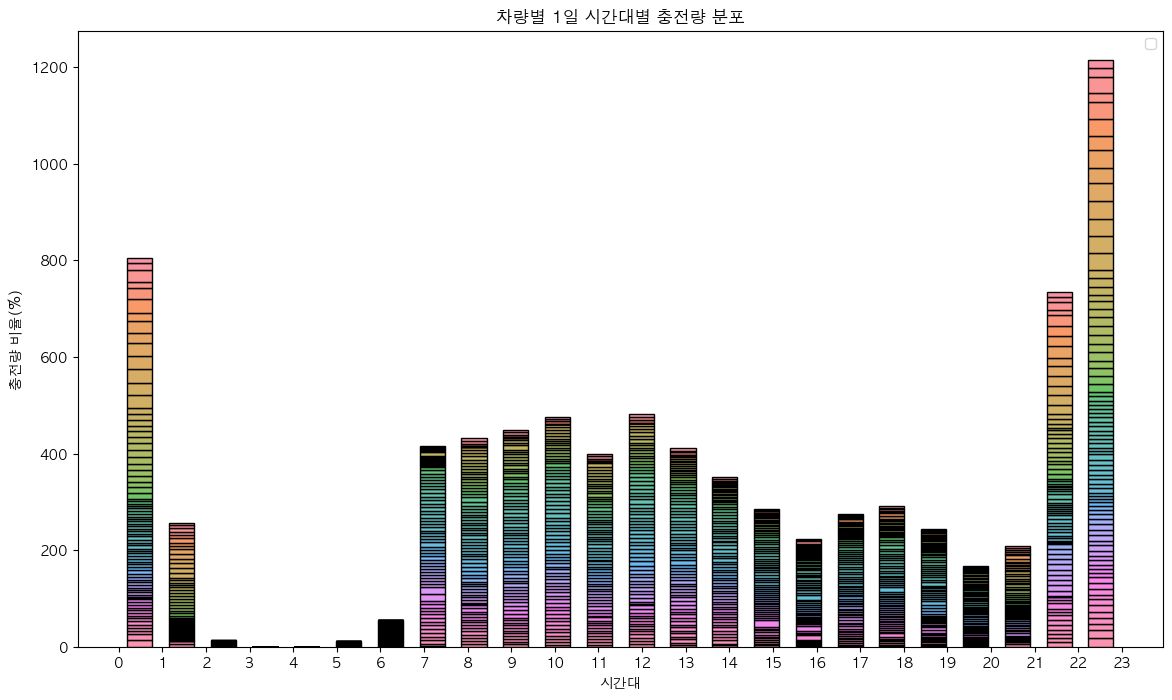

In [376]:
hourly_df['시간대'] = hourly_df['시간'].dt.hour

plt.figure(figsize=(14, 8))
sns.histplot(data=hourly_df, x='시간대', weights='충전량 비율(%)', hue='차량번호', multiple='stack', bins=24, shrink=0.6)
plt.title('차량별 1일 시간대별 충전량 분포')
plt.xlabel('시간대')
plt.ylabel('충전량 비율(%)')
plt.xticks(range(24), labels=[f'{i}' for i in range(24)])
plt.legend()
plt.show()

#### 충전간격 분포

In [686]:
df_pdf['차량번호'].value_counts()

차량번호
경기70바1923    1589
경기70바1890    1480
경기70바1925    1441
경기70바1930    1431
경기70바1914    1431
             ... 
경기70바1698     664
경기70바1854     642
경기70바1864     606
경기70바1787     485
경기70바1254     371
Name: count, Length: 71, dtype: int64

In [ ]:
df_pdf['충전 인터벌(시간)'] = df_pdf['충전 인터벌(시간)'].round(1)


plt.figure(figsize=(10, 6))
sns.histplot(data=df_pdf, x='충전 인터벌(시간)', hue='차량번호', multiple='stack', binwidth=0.5, shrink=0.8)
plt.xticks(np.arange(0, df_pdf['충전 인터벌(시간)'].max() + 1, 1))
plt.xlabel('충전 인터벌(시간)')
plt.ylabel('빈도')
plt.title('차량별 충전 인터벌 빈도')
plt.legend(title='차량번호')
plt.tight_layout()
plt.show()


/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/2845609453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pdf['충전 인터벌(시간)'] = df_pdf['충전 인터벌(시간)'].round(1)


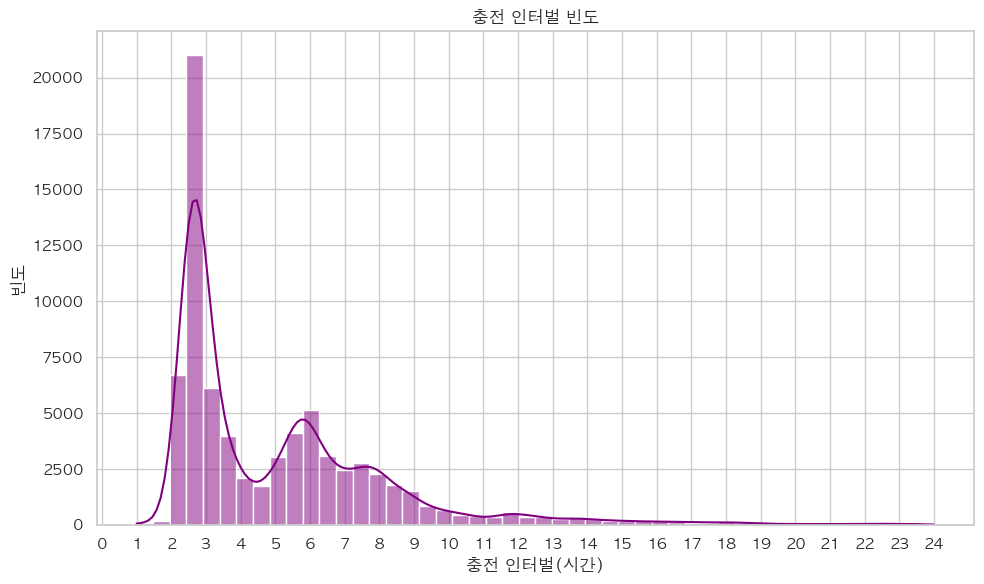

In [688]:
df_pdf['충전 인터벌(시간)'] = df_pdf['충전 인터벌(시간)'].round(1)


plt.figure(figsize=(10, 6))
sns.histplot(x=df_pdf['충전 인터벌(시간)'], bins=48, kde=True, cumulative=False, color='purple')
plt.xticks(np.arange(0, df_pdf['충전 인터벌(시간)'].max() + 1, 1))
plt.xlabel('충전 인터벌(시간)')
plt.ylabel('빈도')
plt.title('충전 인터벌 빈도')
plt.tight_layout()
plt.show()


In [746]:
df_route=df_pdf.copy()

In [747]:
df_route

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80843  경기70바1969  30     10         A      10_A 2023-12-28 16:59:21   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  주중상행막차  \
0     2023-01-02 18:33:29       16.16      2657           88  ...   22:10   
1     2023-01-03 12:30:34       87.28      8510           60  ...   22:10   
2     2023-01-03 16:25:15       28.24      4643           69  ...   22:10   
3     2023-01-04 02:11:29      183.32     15986           19  ...   22:10   
4     2023-01-04 12:12:15       72.00      9262           58  ...   22:10   
...                   ...         ...       ...          ...  ...     ...   
80843 2023-12-28 17:07:45       13.24         0           87  ...   22:45   
80844 2023-12-29 07:35:58       44.16         0           62  ...   22:45   
80845 2023-12-29 10:38:28       64.56         0           57  ...   22:45   
80846 2023-12-29 16:40:36       21.08         0           63  ...   22:45   
80847 2023-12-30 00:07:47      120.56         0           20  ...   22:45   

       주말상행막차 주중하행막차  주말하행막차 운행시작시간_주중  운행종료시간_주중 운행시작시간_주말 운행종료시간_주말  \
0       22:10  23:35   23:35     04:50      23:35     04:50     23:35   
1       22:10  23:35   23:35     04:50      23:35     04:50     23:35   
2       22:10  23:35   23:35     04:50      23:35     04:50     23:35   
3       22:10  23:35   23:35     04:50      23:35     04:50     23:35   
4       22:10  23:35   23:35     04:50      23:35     04:50     23:35   
...       ...    ...     ...       ...        ...       ...       ...   
80843   22:45  23:40   23:40     04:50      23:40     04:50     23:40   
80844   22:45  23:40   23:40     04:50      23:40     04:50     23:40   
80845   22:45  23:40   23:40     04:50      23:40     04:50     23:40   
80846   22:45  23:40   23:40     04:50      23:40     04:50     23:40   
80847   22:45  23:40   23:40     04:50      23:40     04:50     23:40   

         충전소요시간_분  충전소요시간_시간  
0       14.016667   0.233611  
1       29.966667   0.499444  
2       12.916667   0.215278  
3      120.483333   2.008056  
4       23.183333   0.386389  
...           ...        ...  
80843    8.400000   0.140000  
80844   15.100000   0.251667  
80845   22.733333   0.378889  
80846   14.266667   0.237778  
80847   82.116667   1.368611  

[78928 rows x 34 columns]

In [710]:
df_pdf.to_excel('단일노선데이터시각화용.xlsx', index=False)

In [ ]:
df_route['충전 인터벌(시간)'] = df_route['충전 인터벌(시간)'].round(1)

plt.figure(figsize=(12, 6))
sns.histplot(data=df_route, x='충전 인터벌(시간)', hue='노선명', multiple='stack')
plt.xticks(np.arange(0, df_route['충전 인터벌(시간)'].max()+1, 1))
plt.xlabel('충전 인터벌(시간)')
plt.ylabel('빈도')
plt.title('노선별 충전 인터벌 빈도')
plt.tight_layout()
plt.show()

In [12]:
df_route['충전 인터벌(시간)']

0              NaN
1        17.451944
2         3.696111
3         7.762500
4         9.626389
           ...    
80843          NaN
80844    14.218611
80845     2.662778
80846     5.797778
80847     6.084444
Name: 충전 인터벌(시간), Length: 78928, dtype: float64

In [11]:
df_route = df.copy()

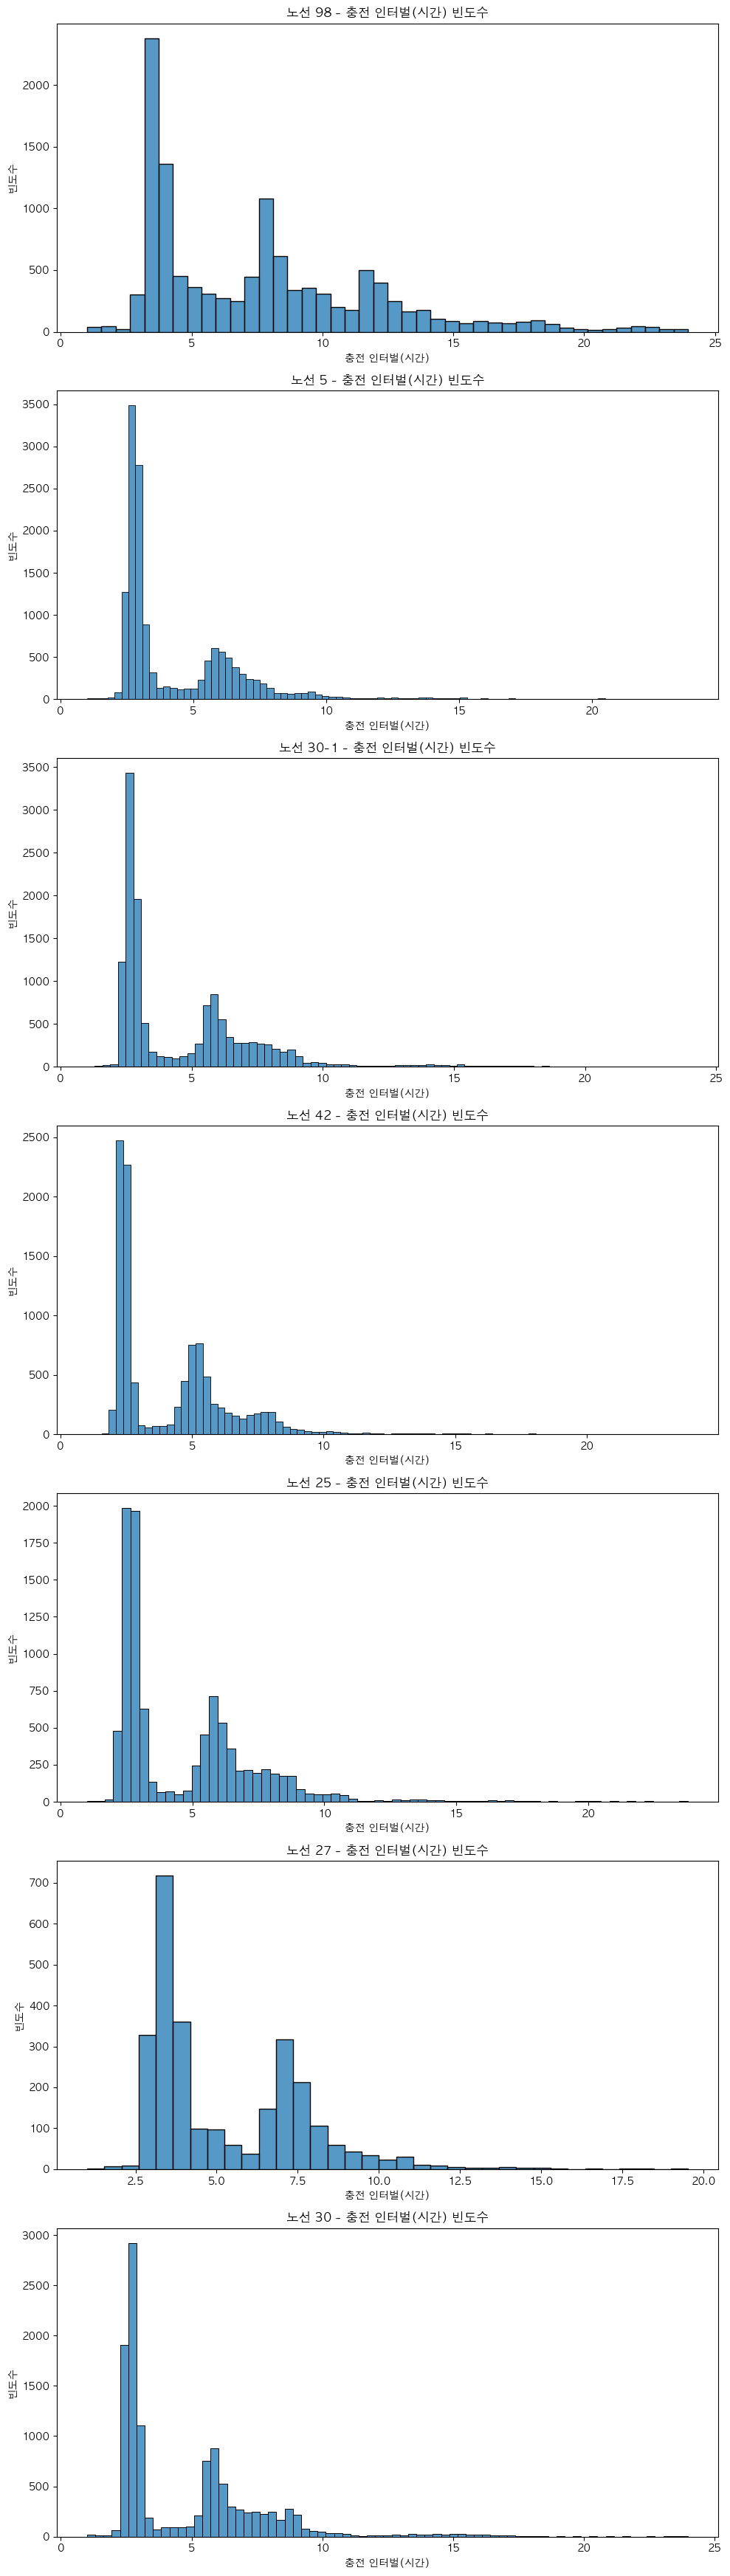

In [13]:
df_route = df.copy()
df_route = df_route.dropna(subset=['충전 인터벌(시간)'])

def plot_route(df_route):
    routes = df_route['노선명'].unique()
    num_routes = len(routes)

    plt.figure(figsize=(10, 5 * num_routes))
    
    for i, route in enumerate(routes, 1):
        plt.subplot(num_routes, 1, i)
        route_data = df_route[df_route['노선명'] == route]
        
        sns.histplot(route_data['충전 인터벌(시간)'], kde=False)
        plt.title(f'노선 {route} - 충전 인터벌(시간) 빈도수')
        plt.ylabel('빈도수')
    
    plt.tight_layout()
    plt.show()

plot_route(df_route)


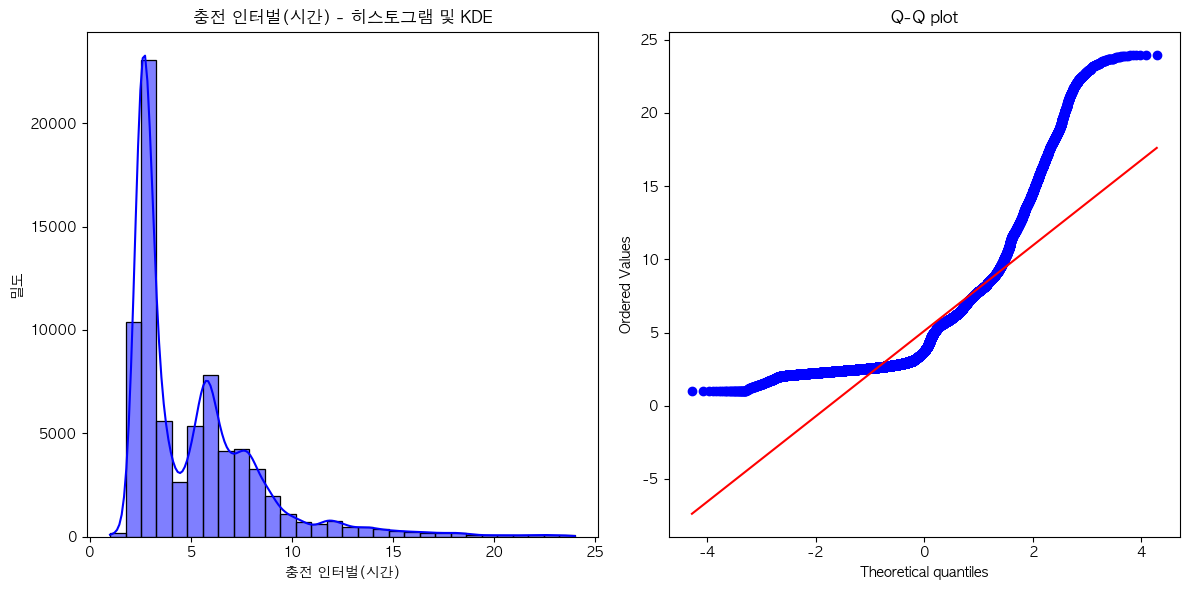

In [14]:
from scipy import stats

df_route = df.copy()
df_route = df_route.dropna(subset=['충전 인터벌(시간)'])

def pdqq(df_route):
    charge_intervals = df_route['충전 인터벌(시간)']

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(charge_intervals, kde=True, color='blue', bins=30)
    plt.title('충전 인터벌(시간) - 히스토그램 및 KDE')
    plt.xlabel('충전 인터벌(시간)')
    plt.ylabel('밀도')
    
    plt.subplot(1, 2, 2)
    stats.probplot(charge_intervals, dist="norm", plot=plt)
    plt.title('Q-Q plot')
    
    plt.tight_layout()
    plt.show()


pdqq(df_route)


In [784]:
df_r = df_pdf.dropna(subset=['충전 인터벌(시간)'])
df_r['충전인터벌 빈도'] = df_r['충전 인터벌(시간)'].apply(np.floor).astype(int)

fbr = df_r.groupby('노선명')['충전인터벌 빈도'].value_counts().unstack(fill_value=0)

fbr

/var/folders/6f/g2t6ql1s1rb55v035fwt5fcr0000gn/T/ipykernel_21507/2522241306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_r['충전인터벌 빈도'] = df_r['충전 인터벌(시간)'].apply(np.floor).astype(int)


충전인터벌 빈도  1     2     3     4     5     6     7     8    9    10  ...   14  \
노선명                                                               ...        
25        29  4484   781   209  1477  1050   632   533  170  149  ...   23   
27         7   191  1162   230   107   264   467   144   69   52  ...    4   
30        43  5451   865   304  1794  1181   764   735  263  119  ...   77   
30-1      37  6340  1126   395  1889  1285   929   696  203  106  ...   69   
42        46  5378   240  1112  1941   627   632   325   97   68  ...   27   
5         52  6911  2140   478  1515  1628   757   272  268   91  ...   55   
98        79   120  3449  1066   600   479  1304  1053  613  407  ...  198   

충전인터벌 빈도   15   16   17   18  19  20  21  22  23  
노선명                                               
25         19   20   16    9   7  10   8   7   5  
27          4    1    1    1   2   0   0   0   0  
30         68   50   25   13   7   4   6   4  13  
30-1       58   41   34   13   9  11   8   9   9  
42         21    8    5   10   4   4   4   6   4  
5          40   30   20   15  10  20  11   6  15  
98        129  142  141  149  54  36  55  80  34  

[7 rows x 23 columns]

In [785]:
fbr.to_excel('노선별 충전인터벌.xlsx', index=False)

### 노선별 충전 특성

In [692]:
df_route['노선명'].value_counts()

노선명
5       15379
30-1    13955
98      13114
30      12414
42      11135
25      10164
27       2767
Name: count, dtype: int64

In [693]:
#충전량
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
]

results = []

for col_name, agg_func in statistics:
    temp_df = df_route.groupby(['충전일자','차량번호','노선명'])['충전전력량(kWh)'].sum().reset_index()
    temp_df = temp_df.groupby('노선명')['충전전력량(kWh)'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전전력량(kWh)': col_name}, inplace=True)
    results.append(temp_df)

result5 = results[0]
for temp_df in results[1:]:
    result5 = pd.merge(result5, temp_df, on='노선명')

result5

노선명          평균        표준편차
0    25  270.462374   99.174854
1    27  272.640736  102.386631
2    30  250.759637  100.978564
3  30-1  254.011358  102.110351
4    42  249.318180  104.894225
5     5  251.779421  108.935949
6    98  229.749303  110.671000

In [694]:
#충전빈도
results = []

for col_name, agg_func in statistics:
    temp_df = df_route.groupby(['충전일자','차량번호','노선명'])['충전기ID_충전구'].count().reset_index()
    temp_df = temp_df.groupby(['노선명'])['충전기ID_충전구'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전기ID_충전구': col_name}, inplace=True)
    results.append(temp_df)

result6 = results[0]
for temp_df in results[1:]:
    result6 = pd.merge(result6, temp_df, on='노선명')

result6

노선명        평균      표준편차
0    25  4.098387  1.350301
1    27  3.969871  0.982876
2    30  3.957284  1.418297
3  30-1  4.026255  1.500996
4    42  4.225806  1.692433
5     5  3.971849  1.659456
6    98  2.357785  1.060311

In [695]:
df_route['충전소요시간_수정'] = pd.to_timedelta(df_route['충전소요시간_수정'])
df_route['충전소요시간_분'] = df_route['충전소요시간_수정'].dt.total_seconds() / 60

In [696]:
#충전시간
results = []

for col_name, agg_func in statistics:
    temp_df = df_route.groupby(['충전일자','차량번호','노선명'])['충전소요시간_분'].sum().reset_index()
    temp_df = temp_df.groupby('노선명')['충전소요시간_분'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전소요시간_분': col_name}, inplace=True)
    results.append(temp_df)

result7 = results[0]
for temp_df in results[1:]:
    result7 = pd.merge(result7, temp_df, on='노선명')

result7

노선명          평균       표준편차
0    25  150.367863  65.856004
1    27  161.211621  69.632536
2    30  139.175603  64.061123
3  30-1  148.160646  70.196686
4    42  145.013238  69.920942
5     5  143.547228  70.259003
6    98  143.608876  74.415361

In [697]:
daily_stats = df_route.groupby(['충전일자','차량번호','노선명']).agg({
    '충전전력량(kWh)': 'sum',
    '충전기ID_충전구': 'count',
    '충전소요시간_분': 'sum'
}).reset_index()


agg_funcs = {
    '충전전력량(kWh)': ['mean', 'std'],
    '충전기ID_충전구': ['mean', 'std'], 
    '충전소요시간_분': ['mean', 'std']
}

route_stats = daily_stats.groupby('노선명').agg(agg_funcs)


route_stats.columns = ['_'.join(col).strip() for col in route_stats.columns.values]
route_stats.reset_index(inplace=True)

route_stats

노선명  충전전력량(kWh)_mean  충전전력량(kWh)_std  충전기ID_충전구_mean  충전기ID_충전구_std  \
0    25       270.462374       99.174854        4.098387       1.350301   
1    27       272.640736      102.386631        3.969871       0.982876   
2    30       250.759637      100.978564        3.957284       1.418297   
3  30-1       254.011358      102.110351        4.026255       1.500996   
4    42       249.318180      104.894225        4.225806       1.692433   
5     5       251.779421      108.935949        3.971849       1.659456   
6    98       229.749303      110.671000        2.357785       1.060311   

   충전소요시간_분_mean  충전소요시간_분_std  
0     150.367863     65.856004  
1     161.211621     69.632536  
2     139.175603     64.061123  
3     148.160646     70.196686  
4     145.013238     69.920942  
5     143.547228     70.259003  
6     143.608876     74.415361

In [698]:
route_stats.to_excel('노선별 충전 특성.xlsx', index=False)

### 운행횟수 및 주행거리

In [10]:
#주행거리
dis = pd.read_excel('/Users/yurim/Downloads/유리미/주행거리 및 운행횟수.xlsx', sheet_name='Sheet1')
dis

일자  경기70바1254  경기70바1650  경기70바1658  경기70바1675  경기70바1676  \
0   2023-01-01       0.00     203.80      55.90       0.00       0.00   
1   2023-01-02       0.00     203.80     335.40     203.80       0.00   
2   2023-01-03     203.80       0.00     335.40     203.80     237.95   
3   2023-01-04     203.80     203.80     279.50     203.80       0.00   
4   2023-01-05     254.75     254.75     279.50     203.80     237.95   
..         ...        ...        ...        ...        ...        ...   
360 2023-12-27     225.25       0.00       0.00     203.64     237.95   
361 2023-12-28     225.25       0.00     237.95     254.55     237.95   
362 2023-12-29      30.50     244.98       0.00     254.55     237.95   
363 2023-12-30       0.00       0.00       0.00       0.00       0.00   
364 2023-12-31       0.00     203.64       0.00       0.00       0.00   

     경기70바1677  경기70바1678  경기70바1679  경기70바1680  ...  경기70바1962  경기70바1963  \
0         0.00       0.00     237.95     237.95  ...     261.84       0.00   
1         0.00       0.00     237.95       0.00  ...     261.84     261.84   
2         0.00     237.95     237.95       0.00  ...     261.84     261.84   
3       190.36       0.00     190.36     237.95  ...     261.84     261.84   
4       237.95     237.95       0.00     237.95  ...     261.84     261.84   
..         ...        ...        ...        ...  ...        ...        ...   
360     237.95     225.25     225.25     225.25  ...     261.78     261.78   
361     237.95     225.25     225.25     225.25  ...     261.78     261.78   
362     237.95     225.25     225.25     225.25  ...     261.78     261.78   
363     237.95     225.25       0.00     135.15  ...       0.00     174.52   
364     237.95     225.25     225.25     225.25  ...     261.78       0.00   

     경기70바1964  경기70바1965  경기70바1966  경기70바1967  경기70바1968  경기70바1969  \
0       261.84     261.84     261.84       0.00     261.84       0.00   
1       261.84     261.84     261.84     261.84     130.92     261.84   
2       261.84     261.84     261.84     261.84     261.84     261.84   
3       261.84     261.84       0.00     261.84     261.84     261.84   
4       261.84     261.84     261.84       0.00     261.84     261.84   
..         ...        ...        ...        ...        ...        ...   
360     261.78     261.78     261.78     261.78     261.78       0.00   
361     261.78     261.78       0.00     261.78     261.78       0.00   
362     130.89     261.78     261.78     261.78     261.78     261.78   
363     261.78     261.78       0.00     261.78     261.78       0.00   
364       0.00       0.00     261.78     261.78       0.00       0.00   

     경기70바2408  경기70바2409  
0         0.00       0.00  
1       203.80     203.80  
2       203.80     203.80  
3         0.00     203.80  
4       203.80       0.00  
..         ...        ...  
360     254.55     254.55  
361       0.00     254.55  
362      50.91     254.55  
363       0.00       0.00  
364       0.00       0.00  

[365 rows x 83 columns]

In [11]:
dis.columns

Index(['일자', '경기70바1254', '경기70바1650', '경기70바1658', '경기70바1675', '경기70바1676',
       '경기70바1677', '경기70바1678', '경기70바1679', '경기70바1680', '경기70바1681',
       '경기70바1682', '경기70바1683', '경기70바1684', '경기70바1685', '경기70바1686',
       '경기70바1687', '경기70바1690', '경기70바1695', '경기70바1696', '경기70바1697',
       '경기70바1698', '경기70바1699', '경기70바1779', '경기70바1784', '경기70바1785',
       '경기70바1787', '경기70바1854', '경기70바1862', '경기70바1864', '경기70바1876',
       '경기70바1879', '경기70바1881', '경기70바1883', '경기70바1884', '경기70바1885',
       '경기70바1890', '경기70바1891', '경기70바1895', '경기70바1898', '경기70바1899',
       '경기70바1902', '경기70바1903', '경기70바1904', '경기70바1907', '경기70바1912',
       '경기70바1913', '경기70바1914', '경기70바1915', '경기70바1916', '경기70바1917',
       '경기70바1918', '경기70바1919', '경기70바1923', '경기70바1925', '경기70바1926',
       '경기70바1927', '경기70바1928', '경기70바1930', '경기70바1931', '경기70바1932',
       '경기70바1933', '경기70바1935', '경기70바1936', '경기70바1938', '경기70바1939',
       '경기70바1940', '경기70바1942', '경기70바1943', '경기70바1947',

In [12]:
dis = dis.melt(id_vars='일자', value_vars=['경기70바1254', '경기70바1650', '경기70바1658', '경기70바1675', '경기70바1676',
       '경기70바1677', '경기70바1678', '경기70바1679', '경기70바1680', '경기70바1681',
       '경기70바1682', '경기70바1683', '경기70바1684', '경기70바1685', '경기70바1686',
       '경기70바1687', '경기70바1690', '경기70바1695', '경기70바1696', '경기70바1697',
       '경기70바1698', '경기70바1699', '경기70바1779', '경기70바1784', '경기70바1785',
       '경기70바1787', '경기70바1854', '경기70바1862', '경기70바1864', '경기70바1876',
       '경기70바1879', '경기70바1881', '경기70바1883', '경기70바1884', '경기70바1885',
       '경기70바1890', '경기70바1891', '경기70바1895', '경기70바1898', '경기70바1899',
       '경기70바1902', '경기70바1903', '경기70바1904', '경기70바1907', '경기70바1912',
       '경기70바1913', '경기70바1914', '경기70바1915', '경기70바1916', '경기70바1917',
       '경기70바1918', '경기70바1919', '경기70바1923', '경기70바1925', '경기70바1926',
       '경기70바1927', '경기70바1928', '경기70바1930', '경기70바1931', '경기70바1932',
       '경기70바1933', '경기70바1935', '경기70바1936', '경기70바1938', '경기70바1939',
       '경기70바1940', '경기70바1942', '경기70바1943', '경기70바1947', '경기70바1948',
       '경기70바1951', '경기70바1953', '경기70바1962', '경기70바1963', '경기70바1964',
       '경기70바1965', '경기70바1966', '경기70바1967', '경기70바1968', '경기70바1969',
       '경기70바2408', '경기70바2409'])

In [13]:
dis

일자   variable   value
0     2023-01-01  경기70바1254    0.00
1     2023-01-02  경기70바1254    0.00
2     2023-01-03  경기70바1254  203.80
3     2023-01-04  경기70바1254  203.80
4     2023-01-05  경기70바1254  254.75
...          ...        ...     ...
29925 2023-12-27  경기70바2409  254.55
29926 2023-12-28  경기70바2409  254.55
29927 2023-12-29  경기70바2409  254.55
29928 2023-12-30  경기70바2409    0.00
29929 2023-12-31  경기70바2409    0.00

[29930 rows x 3 columns]

In [14]:
dis.rename(columns={'variable':'차량번호'}, inplace=True)
dis.rename(columns={'value':'주행거리'}, inplace=True)

In [15]:
dis

일자       차량번호    주행거리
0     2023-01-01  경기70바1254    0.00
1     2023-01-02  경기70바1254    0.00
2     2023-01-03  경기70바1254  203.80
3     2023-01-04  경기70바1254  203.80
4     2023-01-05  경기70바1254  254.75
...          ...        ...     ...
29925 2023-12-27  경기70바2409  254.55
29926 2023-12-28  경기70바2409  254.55
29927 2023-12-29  경기70바2409  254.55
29928 2023-12-30  경기70바2409    0.00
29929 2023-12-31  경기70바2409    0.00

[29930 rows x 3 columns]

In [16]:
#운행횟수
rou = pd.read_excel('/Users/yurim/Downloads/유리미/주행거리 및 운행횟수.xlsx', sheet_name='Sheet2')
rou

일자  경기70바1254  경기70바1650  경기70바1658  경기70바1675  경기70바1676  \
0   2023-01-01       0.00       4.00        1.0        0.0        0.0   
1   2023-01-02       0.00       4.00        6.0        4.0        0.0   
2   2023-01-03       4.00       0.00        6.0        4.0        5.0   
3   2023-01-04       4.00       4.00        5.0        4.0        0.0   
4   2023-01-05       5.00       5.00        5.0        4.0        5.0   
..         ...        ...        ...        ...        ...        ...   
360 2023-12-27       5.00       0.00        0.0        4.0        5.0   
361 2023-12-28       5.00       0.00        5.0        5.0        5.0   
362 2023-12-29       0.69       4.82        0.0        5.0        5.0   
363 2023-12-30       0.00       0.00        0.0        0.0        0.0   
364 2023-12-31       0.00       4.00        0.0        0.0        0.0   

     경기70바1677  경기70바1678  경기70바1679  경기70바1680  ...  경기70바1962  경기70바1963  \
0          0.0        0.0        5.0        5.0  ...        6.0        0.0   
1          0.0        0.0        5.0        0.0  ...        6.0        6.0   
2          0.0        5.0        5.0        0.0  ...        6.0        6.0   
3          4.0        0.0        4.0        5.0  ...        6.0        6.0   
4          5.0        5.0        0.0        5.0  ...        6.0        6.0   
..         ...        ...        ...        ...  ...        ...        ...   
360        5.0        5.0        5.0        5.0  ...        6.0        6.0   
361        5.0        5.0        5.0        5.0  ...        6.0        6.0   
362        5.0        5.0        5.0        5.0  ...        6.0        6.0   
363        5.0        5.0        0.0        3.0  ...        0.0        4.0   
364        5.0        5.0        5.0        5.0  ...        6.0        0.0   

     경기70바1964  경기70바1965  경기70바1966  경기70바1967  경기70바1968  경기70바1969  \
0          6.0        6.0        6.0        0.0        6.0        0.0   
1          6.0        6.0        6.0        6.0        3.0        6.0   
2          6.0        6.0        6.0        6.0        6.0        6.0   
3          6.0        6.0        0.0        6.0        6.0        6.0   
4          6.0        6.0        6.0        0.0        6.0        6.0   
..         ...        ...        ...        ...        ...        ...   
360        6.0        6.0        6.0        6.0        6.0        0.0   
361        6.0        6.0        0.0        6.0        6.0        0.0   
362        3.0        6.0        6.0        6.0        6.0        6.0   
363        6.0        6.0        0.0        6.0        6.0        0.0   
364        0.0        0.0        6.0        6.0        0.0        0.0   

     경기70바2408  경기70바2409  
0          0.0        0.0  
1          4.0        4.0  
2          4.0        4.0  
3          0.0        4.0  
4          4.0        0.0  
..         ...        ...  
360        5.0        5.0  
361        0.0        5.0  
362        1.0        5.0  
363        0.0        0.0  
364        0.0        0.0  

[365 rows x 83 columns]

In [17]:
rou = rou.melt(id_vars='일자', value_vars=['경기70바1254', '경기70바1650', '경기70바1658', '경기70바1675', '경기70바1676',
       '경기70바1677', '경기70바1678', '경기70바1679', '경기70바1680', '경기70바1681',
       '경기70바1682', '경기70바1683', '경기70바1684', '경기70바1685', '경기70바1686',
       '경기70바1687', '경기70바1690', '경기70바1695', '경기70바1696', '경기70바1697',
       '경기70바1698', '경기70바1699', '경기70바1779', '경기70바1784', '경기70바1785',
       '경기70바1787', '경기70바1854', '경기70바1862', '경기70바1864', '경기70바1876',
       '경기70바1879', '경기70바1881', '경기70바1883', '경기70바1884', '경기70바1885',
       '경기70바1890', '경기70바1891', '경기70바1895', '경기70바1898', '경기70바1899',
       '경기70바1902', '경기70바1903', '경기70바1904', '경기70바1907', '경기70바1912',
       '경기70바1913', '경기70바1914', '경기70바1915', '경기70바1916', '경기70바1917',
       '경기70바1918', '경기70바1919', '경기70바1923', '경기70바1925', '경기70바1926',
       '경기70바1927', '경기70바1928', '경기70바1930', '경기70바1931', '경기70바1932',
       '경기70바1933', '경기70바1935', '경기70바1936', '경기70바1938', '경기70바1939',
       '경기70바1940', '경기70바1942', '경기70바1943', '경기70바1947', '경기70바1948',
       '경기70바1951', '경기70바1953', '경기70바1962', '경기70바1963', '경기70바1964',
       '경기70바1965', '경기70바1966', '경기70바1967', '경기70바1968', '경기70바1969',
       '경기70바2408', '경기70바2409'])
rou

일자   variable  value
0     2023-01-01  경기70바1254    0.0
1     2023-01-02  경기70바1254    0.0
2     2023-01-03  경기70바1254    4.0
3     2023-01-04  경기70바1254    4.0
4     2023-01-05  경기70바1254    5.0
...          ...        ...    ...
29925 2023-12-27  경기70바2409    5.0
29926 2023-12-28  경기70바2409    5.0
29927 2023-12-29  경기70바2409    5.0
29928 2023-12-30  경기70바2409    0.0
29929 2023-12-31  경기70바2409    0.0

[29930 rows x 3 columns]

In [18]:
rou.rename(columns={'variable':'차량번호'}, inplace=True)
rou.rename(columns={'value':'운행횟수'}, inplace=True)
rou

일자       차량번호  운행횟수
0     2023-01-01  경기70바1254   0.0
1     2023-01-02  경기70바1254   0.0
2     2023-01-03  경기70바1254   4.0
3     2023-01-04  경기70바1254   4.0
4     2023-01-05  경기70바1254   5.0
...          ...        ...   ...
29925 2023-12-27  경기70바2409   5.0
29926 2023-12-28  경기70바2409   5.0
29927 2023-12-29  경기70바2409   5.0
29928 2023-12-30  경기70바2409   0.0
29929 2023-12-31  경기70바2409   0.0

[29930 rows x 3 columns]

In [19]:
disf = dis.groupby(['차량번호','일자']).agg(주행거리 = ('주행거리','sum')).reset_index()
rouf = rou.groupby(['차량번호','일자']).agg(운행횟수 = ('운행횟수','sum')).reset_index()

In [20]:
mg = disf.merge(rouf, on=['차량번호','일자'])
mg

차량번호         일자    주행거리  운행횟수
0      경기70바1254 2023-01-01    0.00   0.0
1      경기70바1254 2023-01-02    0.00   0.0
2      경기70바1254 2023-01-03  203.80   4.0
3      경기70바1254 2023-01-04  203.80   4.0
4      경기70바1254 2023-01-05  254.75   5.0
...          ...        ...     ...   ...
29925  경기70바2409 2023-12-27  254.55   5.0
29926  경기70바2409 2023-12-28  254.55   5.0
29927  경기70바2409 2023-12-29  254.55   5.0
29928  경기70바2409 2023-12-30    0.00   0.0
29929  경기70바2409 2023-12-31    0.00   0.0

[29930 rows x 4 columns]

In [21]:
mg.rename(columns={'일자':'충전일자'}, inplace=True)


In [22]:
df = df.merge(mg, on=['차량번호','충전일자'])
df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
78923  경기70바1969  30     10         A      10_A 2023-12-28 16:59:21   
78924  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
78925  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
78926  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
78927  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  충전소요시간_수정  \
0     2023-01-02 18:33:29       16.16      2657           88  ...   00:14:01   
1     2023-01-03 12:30:34       87.28      8510           60  ...   00:29:58   
2     2023-01-03 16:25:15       28.24      4643           69  ...   00:12:55   
3     2023-01-04 02:11:29      183.32     15986           19  ...   02:00:29   
4     2023-01-04 12:12:15       72.00      9262           58  ...   00:23:11   
...                   ...         ...       ...          ...  ...        ...   
78923 2023-12-28 17:07:45       13.24         0           87  ...   00:08:24   
78924 2023-12-29 07:35:58       44.16         0           62  ...   00:15:06   
78925 2023-12-29 10:38:28       64.56         0           57  ...   00:22:44   
78926 2023-12-29 16:40:36       21.08         0           63  ...   00:14:16   
78927 2023-12-30 00:07:47      120.56         0           20  ...   01:22:07   

       SOC종료-시작_수정       충전일자   월 요일  주중/주말 왕복운행거리  인가거리    주행거리  운행횟수  
0                7 2023-01-02   1  월     주중  50.90  50.9    0.00   0.0  
1               35 2023-01-03   1  화     주중  50.90  50.9  203.80   4.0  
2               12 2023-01-03   1  화     주중  50.90  50.9  203.80   4.0  
3               76 2023-01-04   1  수     주중  50.90  50.9  203.80   4.0  
4               29 2023-01-04   1  수     주중  50.90  50.9  203.80   4.0  
...            ...        ...  .. ..    ...    ...   ...     ...   ...  
78923            8 2023-12-28  12  목     주중  43.63  43.6    0.00   0.0  
78924           26 2023-12-29  12  금     주중  43.63  43.6  261.78   6.0  
78925           38 2023-12-29  12  금     주중  43.63  43.6  261.78   6.0  
78926           24 2023-12-29  12  금     주중  43.63  43.6  261.78   6.0  
78927           75 2023-12-29  12  금     주중  43.63  43.6  261.78   6.0  

[78928 rows x 22 columns]

In [23]:
aa = df.groupby('노선명')['주행거리'].mean().reset_index()
print(aa)
print(aa['주행거리'].mean())

    노선명        주행거리
0    25  272.698474
1    27  242.410249
2    30  245.633249
3  30-1  248.132682
4    42  263.901375
5     5  231.874347
6    98  203.456454
244.0152615627872


### 배터리용량별 기초통계 비교

#### 일자분리

In [11]:
b = pd.read_excel('/Users/yurim/Downloads/유리미/차량별배터리용량.xlsx')
b

차량번호   노선명 차량정보(기업, 예, 현대)               차종 배터리용량(kWh)
0   경기70바1254    98          에디슨모터스  이-화이버드(eFIBIRD)     272kwh
1   경기70바1650    98          에디슨모터스  이-화이버드(eFIBIRD)     272kwh
2   경기70바1658    37          에디슨모터스  이-화이버드(eFIBIRD)     272kwh
3   경기70바1675    98          에디슨모터스  이-화이버드(eFIBIRD)     272kwh
4   경기70바1676    37          에디슨모터스  이-화이버드(eFIBIRD)     272kwh
..        ...   ...             ...              ...        ...
89  경기70바1929   7-2          에디슨모터스  이-화이버드(eFIBIRD)     204kwh
90  경기70바1934     5          에디슨모터스  이-화이버드(eFIBIRD)     204kwh
91  경기70바1941   7-2          에디슨모터스  이-화이버드(eFIBIRD)     204kwh
92  경기70바1889    42          에디슨모터스  이-화이버드(eFIBIRD)     204kwh
93  경기70바1900  25,5          에디슨모터스  이-화이버드(eFIBIRD)     204kwh

[94 rows x 5 columns]

In [12]:
b['배터리용량(kWh)'] = b['배터리용량(kWh)'].str.extract(r'(\d+)')

In [13]:
b

차량번호   노선명 차량정보(기업, 예, 현대)               차종 배터리용량(kWh)
0   경기70바1254    98          에디슨모터스  이-화이버드(eFIBIRD)        272
1   경기70바1650    98          에디슨모터스  이-화이버드(eFIBIRD)        272
2   경기70바1658    37          에디슨모터스  이-화이버드(eFIBIRD)        272
3   경기70바1675    98          에디슨모터스  이-화이버드(eFIBIRD)        272
4   경기70바1676    37          에디슨모터스  이-화이버드(eFIBIRD)        272
..        ...   ...             ...              ...        ...
89  경기70바1929   7-2          에디슨모터스  이-화이버드(eFIBIRD)        204
90  경기70바1934     5          에디슨모터스  이-화이버드(eFIBIRD)        204
91  경기70바1941   7-2          에디슨모터스  이-화이버드(eFIBIRD)        204
92  경기70바1889    42          에디슨모터스  이-화이버드(eFIBIRD)        204
93  경기70바1900  25,5          에디슨모터스  이-화이버드(eFIBIRD)        204

[94 rows x 5 columns]

In [14]:
b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   차량번호             94 non-null     object
 1   노선명              94 non-null     object
 2   차량정보(기업, 예, 현대)  94 non-null     object
 3   차종               94 non-null     object
 4   배터리용량(kWh)       94 non-null     object
dtypes: object(5)
memory usage: 3.8+ KB


In [ ]:
df = pd.read_excel('/Users/yurim/Downloads/유리미/최종_전기버스충전데이터.xlsx')

In [4]:
df.drop(['Unnamed: 0','index'], axis=1, inplace=True)
df = df[df['노선명'] != '37']
df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80843  경기70바1969  30     10         A      10_A 2023-12-28 16:59:21   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80843 2023-12-28 17:07:45       13.24         0           87           95   
80844 2023-12-29 07:35:58       44.16         0           62           88   
80845 2023-12-29 10:38:28       64.56         0           57           95   
80846 2023-12-29 16:40:36       21.08         0           63           87   
80847 2023-12-30 00:07:47      120.56         0           20           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정       충전일자   월 요일 주중/주말  왕복운행거리  인가거리  
0             NaN  00:14:01            7 2023-01-02   1  월    주중   50.90  50.9  
1       17.451944  00:29:58           35 2023-01-03   1  화    주중   50.90  50.9  
2        3.696111  00:12:55           12 2023-01-03   1  화    주중   50.90  50.9  
3        7.762500  02:00:29           76 2023-01-04   1  수    주중   50.90  50.9  
4        9.626389  00:23:11           29 2023-01-04   1  수    주중   50.90  50.9  
...           ...       ...          ...        ...  .. ..   ...     ...   ...  
80843         NaN  00:08:24            8 2023-12-28  12  목    주중   43.63  43.6  
80844   14.218611  00:15:06           26 2023-12-29  12  금    주중   43.63  43.6  
80845    2.662778  00:22:44           38 2023-12-29  12  금    주중   43.63  43.6  
80846    5.797778  00:14:16           24 2023-12-29  12  금    주중   43.63  43.6  
80847    6.084444  01:22:07           75 2023-12-29  12  금    주중   43.63  43.6  

[78928 rows x 20 columns]

In [257]:
cross = df[(df['충전시작시각'].dt.date != df['충전종료시각'].dt.date)]

def split_chss(row):
    start = row['충전시작시각']
    end = row['충전종료시각']
    energy = row['충전전력량(kWh)']
    results = []

    mid = start.replace(hour=23, minute=59, second=59, microsecond=999999) + timedelta(microseconds=1)
    dura_1 = (mid - start).total_seconds() / (end - start).total_seconds()
    energy_1 = energy * dura_1

    row1 = row.copy()
    row1['충전종료시각'] = mid
    row1['충전전력량(kWh)'] = energy_1
    results.append(row1)

    row2 = row.copy()
    row2['충전시작시각'] = mid
    row2['충전전력량(kWh)'] = energy * (1 - dura_1)
    results.append(row2)

    return results

split_s = cross.apply(lambda row: split_chss(row) if row['차량번호'] in df['차량번호'].unique() else [row], axis=1)

split_df = pd.DataFrame([item for sublist in split_s for item in sublist])

final_df = pd.concat([df[~df.index.isin(cross.index)], split_df]).reset_index(drop=True)

final_df


차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
84918  경기70바1969  30     31         B      31_B 2023-12-24 00:00:00   
84919  경기70바1969  30      9         A       9_A 2023-12-24 23:26:08   
84920  경기70바1969  30      9         A       9_A 2023-12-25 00:00:00   
84921  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   
84922  경기70바1969  30      2         B       2_B 2023-12-30 00:00:00   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29   16.160000      2657           88           95   
1     2023-01-03 12:30:34   87.280000      8510           60           95   
2     2023-01-03 16:25:15   28.240000      4643           69           81   
3     2023-01-04 02:11:29  183.320000     15986           19           95   
4     2023-01-04 12:12:15   72.000000      9262           58           87   
...                   ...         ...       ...          ...          ...   
84918 2023-12-24 01:11:50  107.051105         0           21           95   
84919 2023-12-25 00:00:00   50.494622         0           20           95   
84920 2023-12-25 00:48:12   71.865378         0           20           95   
84921 2023-12-30 00:00:00  109.132860         0           20           95   
84922 2023-12-30 00:07:47   11.427140         0           20           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정       충전일자   월 요일 주중/주말  왕복운행거리  인가거리  
0             NaN  00:14:01            7 2023-01-02   1  월    주중   50.90  50.9  
1       17.451944  00:29:58           35 2023-01-03   1  화    주중   50.90  50.9  
2        3.696111  00:12:55           12 2023-01-03   1  화    주중   50.90  50.9  
3        7.762500  02:00:29           76 2023-01-04   1  수    주중   50.90  50.9  
4        9.626389  00:23:11           29 2023-01-04   1  수    주중   50.90  50.9  
...           ...       ...          ...        ...  .. ..   ...     ...   ...  
84918    5.901389  01:20:41           74 2023-12-23  12  토    주말   43.63  43.6  
84919    5.877778  01:22:04           75 2023-12-24  12  일    주말   43.63  43.6  
84920    5.877778  01:22:04           75 2023-12-24  12  일    주말   43.63  43.6  
84921    6.084444  01:22:07           75 2023-12-29  12  금    주중   43.63  43.6  
84922    6.084444  01:22:07           75 2023-12-29  12  금    주중   43.63  43.6  

[84923 rows x 20 columns]

In [258]:
final_df.drop(['충전소요시간_수정', '충전 요금(원)', '충전 인터벌(시간)', '충전일자', '왕복운행거리', '인가거리'], axis=1, inplace=True)

In [259]:
final_df['충전일자'] = final_df['충전시작시각'].dt.date
final_df['충전소요시간'] = final_df['충전종료시각'] - final_df['충전시작시각']
final_df['충전소요시간'] = pd.to_timedelta(final_df['충전소요시간'])
final_df['충전소요시간_분'] = final_df['충전소요시간'].dt.total_seconds() / 60

In [260]:
final_df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
84918  경기70바1969  30     31         B      31_B 2023-12-24 00:00:00   
84919  경기70바1969  30      9         A       9_A 2023-12-24 23:26:08   
84920  경기70바1969  30      9         A       9_A 2023-12-25 00:00:00   
84921  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   
84922  경기70바1969  30      2         B       2_B 2023-12-30 00:00:00   

                   충전종료시각  충전전력량(kWh)  충전시작 SOC(%)  충전종료 SOC(%)  SOC종료-시작_수정  \
0     2023-01-02 18:33:29   16.160000           88           95            7   
1     2023-01-03 12:30:34   87.280000           60           95           35   
2     2023-01-03 16:25:15   28.240000           69           81           12   
3     2023-01-04 02:11:29  183.320000           19           95           76   
4     2023-01-04 12:12:15   72.000000           58           87           29   
...                   ...         ...          ...          ...          ...   
84918 2023-12-24 01:11:50  107.051105           21           95           74   
84919 2023-12-25 00:00:00   50.494622           20           95           75   
84920 2023-12-25 00:48:12   71.865378           20           95           75   
84921 2023-12-30 00:00:00  109.132860           20           95           75   
84922 2023-12-30 00:07:47   11.427140           20           95           75   

        월 요일 주중/주말        충전일자          충전소요시간    충전소요시간_분  
0       1  월    주중  2023-01-02 0 days 00:14:01   14.016667  
1       1  화    주중  2023-01-03 0 days 00:29:58   29.966667  
2       1  화    주중  2023-01-03 0 days 00:12:55   12.916667  
3       1  수    주중  2023-01-04 0 days 02:00:29  120.483333  
4       1  수    주중  2023-01-04 0 days 00:23:11   23.183333  
...    .. ..   ...         ...             ...         ...  
84918  12  토    주말  2023-12-24 0 days 01:11:50   71.833333  
84919  12  일    주말  2023-12-24 0 days 00:33:52   33.866667  
84920  12  일    주말  2023-12-25 0 days 00:48:12   48.200000  
84921  12  금    주중  2023-12-29 0 days 01:14:20   74.333333  
84922  12  금    주중  2023-12-30 0 days 00:07:47    7.783333  

[84923 rows x 17 columns]

In [22]:
b.drop(['노선명','차량정보(기업, 예, 현대)','차종'], axis=1, inplace=True)
b

차량번호 배터리용량(kWh)
0   경기70바1254        272
1   경기70바1650        272
2   경기70바1658        272
3   경기70바1675        272
4   경기70바1676        272
..        ...        ...
89  경기70바1929        204
90  경기70바1934        204
91  경기70바1941        204
92  경기70바1889        204
93  경기70바1900        204

[94 rows x 2 columns]

In [ ]:
df = final_df.merge(b, on='차량번호')
df

In [5]:
df['충전일자'] = pd.to_datetime(df['충전일자'])

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_49371/2458881834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['충전일자'] = pd.to_datetime(df['충전일자'])


In [265]:
df1 = df[df['배터리용량(kWh)'] == '272']
df2 = df[df['배터리용량(kWh)'] == '204']

In [266]:
df1

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
15840  경기70바1695   5     15         A      15_A 2023-12-27 00:00:00   
15841  경기70바1695   5     15         B      15_B 2023-12-27 22:46:21   
15842  경기70바1695   5     15         B      15_B 2023-12-28 00:00:00   
15843  경기70바1695   5     28         B      28_B 2023-12-29 23:44:04   
15844  경기70바1695   5     28         B      28_B 2023-12-30 00:00:00   

                   충전종료시각  충전전력량(kWh)  충전시작 SOC(%)  충전종료 SOC(%)  SOC종료-시작_수정  \
0     2023-01-02 18:33:29   16.160000           88           95            7   
1     2023-01-03 12:30:34   87.280000           60           95           35   
2     2023-01-03 16:25:15   28.240000           69           81           12   
3     2023-01-04 02:11:29  183.320000           19           95           76   
4     2023-01-04 12:12:15   72.000000           58           87           29   
...                   ...         ...          ...          ...          ...   
15840 2023-12-27 00:20:39   30.681740           23           95           72   
15841 2023-12-28 00:00:00  110.063947           28           95           67   
15842 2023-12-28 00:31:10   46.576053           28           95           67   
15843 2023-12-30 00:00:00   24.063475           40           95           55   
15844 2023-12-30 01:09:21  104.736525           40           95           55   

        월 요일 주중/주말       충전일자          충전소요시간    충전소요시간_분 배터리용량(kWh)  
0       1  월    주중 2023-01-02 0 days 00:14:01   14.016667        272  
1       1  화    주중 2023-01-03 0 days 00:29:58   29.966667        272  
2       1  화    주중 2023-01-03 0 days 00:12:55   12.916667        272  
3       1  수    주중 2023-01-04 0 days 02:00:29  120.483333        272  
4       1  수    주중 2023-01-04 0 days 00:23:11   23.183333        272  
...    .. ..   ...        ...             ...         ...        ...  
15840  12  화    주중 2023-12-27 0 days 00:20:39   20.650000        272  
15841  12  수    주중 2023-12-27 0 days 01:13:39   73.650000        272  
15842  12  수    주중 2023-12-28 0 days 00:31:10   31.166667        272  
15843  12  금    주중 2023-12-29 0 days 00:15:56   15.933333        272  
15844  12  금    주중 2023-12-30 0 days 01:09:21   69.350000        272  

[15845 rows x 18 columns]

In [267]:
df2

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
15845  경기70바1876   5     24         A      24_A 2023-01-02 08:59:07   
15846  경기70바1876   5     24         A      24_A 2023-01-02 11:44:19   
15847  경기70바1876   5     30         A      30_A 2023-01-02 14:51:23   
15848  경기70바1876   5     41         A      41_A 2023-01-02 18:00:50   
15849  경기70바1876   5     29         A      29_A 2023-01-02 21:08:05   
...          ...  ..    ...       ...       ...                 ...   
84918  경기70바1969  30     31         B      31_B 2023-12-24 00:00:00   
84919  경기70바1969  30      9         A       9_A 2023-12-24 23:26:08   
84920  경기70바1969  30      9         A       9_A 2023-12-25 00:00:00   
84921  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   
84922  경기70바1969  30      2         B       2_B 2023-12-30 00:00:00   

                   충전종료시각  충전전력량(kWh)  충전시작 SOC(%)  충전종료 SOC(%)  SOC종료-시작_수정  \
15845 2023-01-02 09:17:09   54.360000           38           71           33   
15846 2023-01-02 12:07:32   69.720000           33           75           42   
15847 2023-01-02 15:17:20   78.480000           41           89           48   
15848 2023-01-02 18:25:05   71.280000           52           95           43   
15849 2023-01-02 21:19:40   17.200000           53           64           11   
...                   ...         ...          ...          ...          ...   
84918 2023-12-24 01:11:50  107.051105           21           95           74   
84919 2023-12-25 00:00:00   50.494622           20           95           75   
84920 2023-12-25 00:48:12   71.865378           20           95           75   
84921 2023-12-30 00:00:00  109.132860           20           95           75   
84922 2023-12-30 00:07:47   11.427140           20           95           75   

        월 요일 주중/주말       충전일자          충전소요시간   충전소요시간_분 배터리용량(kWh)  
15845   1  월    주중 2023-01-02 0 days 00:18:02  18.033333        204  
15846   1  월    주중 2023-01-02 0 days 00:23:13  23.216667        204  
15847   1  월    주중 2023-01-02 0 days 00:25:57  25.950000        204  
15848   1  월    주중 2023-01-02 0 days 00:24:15  24.250000        204  
15849   1  월    주중 2023-01-02 0 days 00:11:35  11.583333        204  
...    .. ..   ...        ...             ...        ...        ...  
84918  12  토    주말 2023-12-24 0 days 01:11:50  71.833333        204  
84919  12  일    주말 2023-12-24 0 days 00:33:52  33.866667        204  
84920  12  일    주말 2023-12-25 0 days 00:48:12  48.200000        204  
84921  12  금    주중 2023-12-29 0 days 01:14:20  74.333333        204  
84922  12  금    주중 2023-12-30 0 days 00:07:47   7.783333        204  

[69078 rows x 18 columns]

In [43]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20

In [268]:
stt = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max'),
]

results = []

for col_name, agg_func in stt:
    temp_df = df1.groupby(['충전일자', '차량번호'])['노선명'].count().reset_index()
    temp_df = temp_df.groupby('충전일자')['노선명'].agg(agg_func).reset_index()
    temp_df.rename(columns={'노선명': col_name}, inplace=True)
    results.append(temp_df)

result = results[0]
for temp_df in results[1:]:
    result = pd.merge(result, temp_df, on='충전일자')

result

충전일자        평균      표준편차  중앙값  최솟값  최댓값
0   2023-01-01  2.083333  0.996205  2.0    1    4
1   2023-01-02  3.105263  1.048530  3.0    1    5
2   2023-01-03  3.210526  1.474937  4.0    1    5
3   2023-01-04  3.789474  1.272746  4.0    1    5
4   2023-01-05  3.473684  1.020263  4.0    1    5
..         ...       ...       ...  ...  ...  ...
360 2023-12-27  3.500000  0.966092  4.0    1    5
361 2023-12-28  3.312500  1.447699  4.0    1    5
362 2023-12-29  2.166667  0.857493  2.0    1    4
363 2023-12-30  2.500000  1.400549  3.0    1    5
364 2023-12-31  2.090909  1.136182  2.0    1    4

[365 rows x 6 columns]

In [208]:
#월별 충전빈도
result['월'] = result['충전일자'].dt.month
a1 = result.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a1

월        평균      표준편차       중앙값       최솟값       최댓값
0    1  3.017502  1.140944  3.225806  1.161290  4.677419
1    2  2.866017  1.095493  3.035714  1.178571  4.428571
2    3  2.347996  0.990833  2.403226  1.000000  4.000000
3    4  2.084571  0.902816  2.066667  1.033333  3.666667
4    5  2.074357  0.889711  2.016129  1.000000  3.645161
5    6  2.352442  1.039423  2.416667  1.000000  4.133333
6    7  2.488333  1.100612  2.564516  1.000000  4.354839
7    8  2.579965  1.074814  2.548387  1.064516  4.419355
8    9  2.412023  1.076934  2.333333  1.066667  4.266667
9   10  2.165153  0.885997  2.096774  1.000000  3.709677
10  11  2.666492  1.086547  2.800000  1.066667  4.300000
11  12  3.039218  1.194596  3.274194  1.064516  4.741935

In [176]:
da1_1 = result[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da1_1.columns = ['항목', '1일 충전빈도']
da1_1

항목   1일 충전빈도
0    평균  2.506308
1  표준편차  1.039584
2   중앙값  2.563014
3   최솟값  1.052055
4   최댓값  4.194521

In [269]:
stt = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max'),
]

results = []

for col_name, agg_func in stt:
    temp_df = df2.groupby(['충전일자', '차량번호'])['노선명'].count().reset_index()
    temp_df = temp_df.groupby('충전일자')['노선명'].agg(agg_func).reset_index()
    temp_df.rename(columns={'노선명': col_name}, inplace=True)
    results.append(temp_df)

result = results[0]
for temp_df in results[1:]:
    result = pd.merge(result, temp_df, on='충전일자')

result

충전일자        평균      표준편차  중앙값  최솟값  최댓값
0   2023-01-01  3.736842  1.926826  5.0    1    6
1   2023-01-02  4.688889  1.578581  5.0    1    7
2   2023-01-03  4.571429  1.825742  5.0    1    7
3   2023-01-04  5.061224  1.853017  6.0    1    7
4   2023-01-05  4.693878  1.660874  5.0    1    7
..         ...       ...       ...  ...  ...  ...
360 2023-12-27  4.833333  1.575522  5.0    1    7
361 2023-12-28  4.437500  1.785357  5.0    1    7
362 2023-12-29  3.750000  1.496119  4.0    1    7
363 2023-12-30  3.121951  1.805479  3.0    1    7
364 2023-12-31  2.611111  1.358103  2.5    1    5

[365 rows x 6 columns]

In [270]:
#월별 충전빈도
result['월'] = result['충전일자'].dt.month
a1 = result.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a1

월        평균      표준편차       중앙값       최솟값       최댓값
0    1  4.389546  1.793398  4.935484  1.000000  7.000000
1    2  4.372565  1.651768  4.785714  1.000000  6.892857
2    3  4.089655  1.491983  4.451613  1.096774  6.709677
3    4  3.871600  1.466424  4.066667  1.000000  6.400000
4    5  3.940581  1.496285  4.354839  1.032258  6.516129
5    6  3.960530  1.539288  4.300000  1.000000  6.366667
6    7  4.064100  1.646956  4.548387  1.000000  6.548387
7    8  4.107905  1.630684  4.435484  1.000000  6.709677
8    9  4.026046  1.645933  4.616667  1.000000  6.633333
9   10  3.676514  1.443073  3.887097  1.000000  6.032258
10  11  4.157995  1.648967  4.583333  1.033333  6.700000
11  12  4.299749  1.759832  4.854839  1.032258  6.903226

In [271]:
da2_1 = result[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da2_1.columns = ['항목', '1일 충전빈도']
da2_1

항목   1일 충전빈도
0    평균  4.078155
1  표준편차  1.601086
2   중앙값  4.483562
3   최솟값  1.016438
4   최댓값  6.616438

In [209]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df1.groupby(['충전일자', '차량번호'])['충전전력량(kWh)'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전전력량(kWh)'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전전력량(kWh)': col_name}, inplace=True)
    results.append(temp_df)

result2 = results[0]
for temp_df in results[1:]:
    result2 = pd.merge(result2, temp_df, on='충전일자')

result2


충전일자          평균        표준편차         중앙값         최솟값         최댓값
0   2023-01-01  204.340675   81.531089  197.372849   72.200000  369.440000
1   2023-01-02  259.343620  130.327840  258.760000   14.240000  517.760000
2   2023-01-03  290.138927  129.179061  261.370000   78.520000  563.560000
3   2023-01-04  306.240445   97.999864  309.320000  141.840000  465.670000
4   2023-01-05  289.396859   96.512815  328.040000  161.600000  485.960000
..         ...         ...         ...         ...         ...         ...
360 2023-12-27  271.140070   97.975844  287.335624   20.807682  415.954035
361 2023-12-28  279.117854  114.383022  329.470972   32.160000  373.680000
362 2023-12-29  156.077750   66.789854  152.320000   50.040000  289.720000
363 2023-12-30  238.007800  105.344934  231.967122   61.614391  378.040000
364 2023-12-31  164.892978   91.156643  167.041522   24.688559  329.351180

[365 rows x 6 columns]

In [210]:
result2['월'] = result2['충전일자'].dt.month
a2 = result2.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a2

월          평균        표준편차         중앙값        최솟값         최댓값
0    1  264.131635  106.099967  262.979187  68.333273  457.123717
1    2  241.881445   93.884389  241.157586  65.614829  414.920009
2    3  200.663205   91.068468  193.776777  38.768823  378.073813
3    4  184.489626   85.895801  186.750170  37.971694  345.976923
4    5  178.690380   85.648497  181.320778  33.890594  340.788346
5    6  197.260681   86.478587  194.630913  49.168297  358.336696
6    7  208.111693   92.443330  209.559686  49.391300  370.880129
7    8  209.262135   93.125619  203.546983  54.383898  380.277344
8    9  195.824972   88.580997  189.954198  49.960135  355.332012
9   10  185.936242   85.946233  190.592458  31.483659  331.610715
10  11  227.261840   92.330811  231.572032  63.469005  390.925821
11  12  258.176104  100.501627  267.329932  69.254913  423.041426

In [182]:
da1_2 = result2[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da1_2.columns = ['항목', '1일 충전량']
da1_2

항목      1일 충전량
0    평균  212.525773
1  표준편차   91.855328
2   중앙값  212.662772
3   최솟값   50.862985
4   최댓값  378.823463

In [272]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df2.groupby(['충전일자', '차량번호'])['충전전력량(kWh)'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전전력량(kWh)'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전전력량(kWh)': col_name}, inplace=True)
    results.append(temp_df)

result2 = results[0]
for temp_df in results[1:]:
    result2 = pd.merge(result2, temp_df, on='충전일자')

result2


충전일자          평균        표준편차         중앙값        최솟값         최댓값
0   2023-01-01  248.970090  114.568799  276.036339  50.560000  490.080000
1   2023-01-02  314.193387  111.950685  326.100000  13.320000  507.820000
2   2023-01-03  306.968237  125.380439  341.680000  40.610342  546.960000
3   2023-01-04  310.225277  101.075037  335.970000  60.938824  441.516959
4   2023-01-05  297.563676  113.502058  315.870000   8.302098  451.440000
..         ...         ...         ...         ...        ...         ...
360 2023-12-27  293.508150  101.872089  314.060000   9.480000  475.180000
361 2023-12-28  289.578711  107.451971  316.720000  13.240000  465.338683
362 2023-12-29  223.657045  105.653126  237.592814  22.750776  464.010000
363 2023-12-30  213.552835  101.532147  210.560000  11.427140  405.880000
364 2023-12-31  161.718931   84.951124  137.701256  27.440000  340.120000

[365 rows x 6 columns]

In [273]:
result2['월'] = result2['충전일자'].dt.month
a2 = result2.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a2

월          평균        표준편차         중앙값        최솟값         최댓값
0    1  286.424546  112.948340  308.473177  31.397218  492.411023
1    2  272.555929   98.854339  287.423644  29.312014  464.904196
2    3  239.288365   86.217898  247.862261  43.712888  423.575245
3    4  221.616766   84.014751  225.572542  32.421934  404.047325
4    5  220.345386   81.808259  228.339198  33.101817  394.840449
5    6  227.852262   87.421485  238.412791  32.231630  411.944805
6    7  236.570291   90.026490  246.067284  40.957764  418.088600
7    8  243.653068   94.233061  256.749202  30.907794  427.497298
8    9  226.274209   88.244449  236.953725  38.612522  408.488693
9   10  208.753196   80.516790  215.148381  28.219381  371.632755
10  11  251.725793   95.265013  265.241005  41.169881  434.665049
11  12  270.272451  107.320719  288.160754  28.056164  467.299577

In [274]:
da2_2 = result2[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da2_2.columns = ['항목', '1일 충전량']
da2_2

항목      1일 충전량
0    평균  241.973050
1  표준편차   92.223317
2   중앙값  253.556361
3   최솟값   34.193861
4   최댓값  426.431197

In [211]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df1.groupby(['충전일자', '차량번호'])['충전소요시간_분'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전소요시간_분'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전소요시간_분': col_name}, inplace=True)
    results.append(temp_df)

result3 = results[0]
for temp_df in results[1:]:
    result3 = pd.merge(result3, temp_df, on='충전일자')

result3


충전일자          평균       표준편차         중앙값        최솟값         최댓값
0   2023-01-01  120.268056  37.508875  124.775000  45.833333  177.650000
1   2023-01-02  120.054386  64.764188  109.083333   9.516667  228.766667
2   2023-01-03  151.196491  72.259748  127.216667  42.883333  310.883333
3   2023-01-04  155.917544  57.026808  169.066667  47.483333  259.566667
4   2023-01-05  163.354386  61.821008  186.350000  51.966667  301.100000
..         ...         ...        ...         ...        ...         ...
360 2023-12-27  152.659375  63.809497  167.633333  14.033333  247.683333
361 2023-12-28  159.433333  63.317171  167.366667  28.183333  275.683333
362 2023-12-29   88.928704  53.498289   84.958333  18.166667  207.166667
363 2023-12-30  132.489286  50.491289  128.316667  41.600000  198.766667
364 2023-12-31  107.962121  68.043989   94.016667  17.150000  237.433333

[365 rows x 6 columns]

In [212]:
result3['월'] = result3['충전일자'].dt.month
a3 = result3.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a3

월          평균       표준편차         중앙값        최솟값         최댓값
0    1  145.949008  62.176877  146.636559  34.923118  268.520968
1    2  142.519068  58.806919  143.147321  35.906548  255.560119
2    3  125.674267  59.426320  124.595161  22.777957  242.939785
3    4  119.703227  57.647787  124.358333  20.980000  224.925000
4    5  119.175588  59.603478  124.163441  20.325269  233.158065
5    6  132.158832  63.448719  132.053056  26.985000  256.678889
6    7  138.935634  67.762358  142.076075  29.798387  266.229032
7    8  137.969249  67.303013  140.823656  26.972581  260.998925
8    9  128.948117  63.584158  127.595833  24.947222  245.964444
9   10  121.241432  59.260324  124.508871  19.816667  227.172581
10  11  135.372808  60.642632  136.660278  30.452778  248.342222
11  12  146.100360  61.935814  147.377688  39.029570  258.736022

In [188]:
da1_3 = result3[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da1_3.columns = ['항목', '1일 충전시간(분)']
da1_3

항목  1일 충전시간(분)
0    평균  132.773795
1  표준편차   61.829606
2   중앙값  134.476096
3   최솟값   27.696667
4   최댓값  249.105251

In [275]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df2.groupby(['충전일자', '차량번호'])['충전소요시간_분'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전소요시간_분'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전소요시간_분': col_name}, inplace=True)
    results.append(temp_df)

result3 = results[0]
for temp_df in results[1:]:
    result3 = pd.merge(result3, temp_df, on='충전일자')

result3


충전일자          평균       표준편차         중앙값        최솟값         최댓값
0   2023-01-01  124.507456  50.960325  128.150000  31.900000  250.416667
1   2023-01-02  139.831852  58.532531  142.466667  10.233333  258.566667
2   2023-01-03  145.367007  60.552637  158.783333  26.750000  265.200000
3   2023-01-04  147.171088  52.390998  150.483333  40.050000  251.666667
4   2023-01-05  156.503061  60.420117  168.366667   5.450000  266.350000
..         ...         ...        ...         ...        ...         ...
360 2023-12-27  144.973958  57.740842  145.591667   6.683333  299.183333
361 2023-12-28  147.216667  57.858986  156.358333   8.400000  284.933333
362 2023-12-29  119.269697  63.634069  122.333333  15.183333  269.266667
363 2023-12-30  110.882927  47.790985  103.016667   7.783333  241.933333
364 2023-12-31   85.539352  50.088399   80.316667  18.183333  209.000000

[365 rows x 6 columns]

In [276]:
result3['월'] = result3['충전일자'].dt.month
a3 = result3.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a3

월          평균       표준편차         중앙값        최솟값         최댓값
0    1  145.629544  59.710297  149.683333  20.831183  277.929032
1    2  145.804929  56.689535  148.186905  19.698214  268.994643
2    3  135.108266  53.296093  136.947849  21.953226  252.385484
3    4  131.845432  55.531127  130.509167  16.498889  266.046111
4    5  132.990370  54.877799  133.306989  20.497849  256.424194
5    6  137.198444  60.185282  135.553611  19.141667  282.190556
6    7  145.522615  61.860901  145.967204  27.298925  289.660215
7    8  148.426811  65.224261  147.894086  19.194624  301.217742
8    9  139.031467  61.774513  137.181944  24.805556  294.726667
9   10  124.437477  54.968545  124.090054  13.956989  255.088172
10  11  135.551872  55.970831  134.764722  26.190000  256.912222
11  12  138.253015  57.373705  139.967742  16.526882  265.790323

In [277]:
da2_3 = result3[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da2_3.columns = ['항목', '1일 충전시간(분)']
da2_3

항목  1일 충전시간(분)
0    평균  138.281549
1  표준편차   58.131011
2   중앙값  138.638607
3   최솟값   20.544338
4   최댓값  272.277991

In [222]:
#272
da_f1 = da1_1.merge(da1_2, on='항목')
da_f1 = da_f1.merge(da1_3, on='항목')
da_f1

da_f1.to_excel('272_일일기초통계.xlsx', index=False)

In [278]:
#204
da_f2 = da2_1.merge(da2_2, on='항목')
da_f2 = da_f2.merge(da2_3, on='항목')
da_f2

da_f2.to_excel('204_일일기초통계.xlsx', index=False)

In [224]:
#272
a_f = a1.merge(a2, on='월')
a_f = a_f.merge(a3, on='월')
a_f

a_f.to_excel('272_월별기초통계.xlsx', index=False)

In [279]:
#204
a_f2 = a1.merge(a2, on='월')
a_f2 = a_f2.merge(a3, on='월')
a_f2

a_f2.to_excel('204_월별기초통계.xlsx', index=False)

#### 일자미분리

In [3]:
df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80843  경기70바1969  30     10         A      10_A 2023-12-28 16:59:21   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80843 2023-12-28 17:07:45       13.24         0           87           95   
80844 2023-12-29 07:35:58       44.16         0           62           88   
80845 2023-12-29 10:38:28       64.56         0           57           95   
80846 2023-12-29 16:40:36       21.08         0           63           87   
80847 2023-12-30 00:07:47      120.56         0           20           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정       충전일자   월 요일 주중/주말  왕복운행거리  인가거리  
0             NaN  00:14:01            7 2023-01-02   1  월    주중   50.90  50.9  
1       17.451944  00:29:58           35 2023-01-03   1  화    주중   50.90  50.9  
2        3.696111  00:12:55           12 2023-01-03   1  화    주중   50.90  50.9  
3        7.762500  02:00:29           76 2023-01-04   1  수    주중   50.90  50.9  
4        9.626389  00:23:11           29 2023-01-04   1  수    주중   50.90  50.9  
...           ...       ...          ...        ...  .. ..   ...     ...   ...  
80843         NaN  00:08:24            8 2023-12-28  12  목    주중   43.63  43.6  
80844   14.218611  00:15:06           26 2023-12-29  12  금    주중   43.63  43.6  
80845    2.662778  00:22:44           38 2023-12-29  12  금    주중   43.63  43.6  
80846    5.797778  00:14:16           24 2023-12-29  12  금    주중   43.63  43.6  
80847    6.084444  01:22:07           75 2023-12-29  12  금    주중   43.63  43.6  

[78928 rows x 20 columns]

In [228]:
b

차량번호 배터리용량(kWh)
0   경기70바1254        272
1   경기70바1650        272
2   경기70바1658        272
3   경기70바1675        272
4   경기70바1676        272
..        ...        ...
89  경기70바1929        204
90  경기70바1934        204
91  경기70바1941        204
92  경기70바1889        204
93  경기70바1900        204

[94 rows x 2 columns]

In [18]:
df = df.merge(b, on='차량번호')

In [6]:
df['충전소요시간_수정'] = pd.to_timedelta(df['충전소요시간_수정'])
df['충전소요시간_분'] = df['충전소요시간_수정'].dt.total_seconds() / 60

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_49371/78058979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['충전소요시간_수정'] = pd.to_timedelta(df['충전소요시간_수정'])
/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_49371/78058979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['충전소요시간_분'] = df['충전소요시간_수정'].dt.total_seconds() / 60


In [239]:
df1 = df[df['배터리용량(kWh)'] == '272']
df2 = df[df['배터리용량(kWh)'] == '204']

In [ ]:
stt = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max'),
]

results = []

for col_name, agg_func in stt:
    temp_df = df1.groupby(['충전일자', '차량번호'])['노선명'].count().reset_index()
    temp_df = temp_df.groupby('충전일자')['노선명'].agg(agg_func).reset_index()
    temp_df.rename(columns={'노선명': col_name}, inplace=True)
    results.append(temp_df)

result = results[0]
for temp_df in results[1:]:
    result = pd.merge(result, temp_df, on='충전일자')

result

da1_1 = result[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da1_1.columns = ['항목', '1일 충전빈도']
da1_1

In [233]:
result['월'] = result['충전일자'].dt.month
a1 = result.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a1

월        평균      표준편차       중앙값       최솟값       최댓값
0    1  2.861084  1.049994  3.016129  1.161290  4.387097
1    2  2.690070  0.983756  2.928571  1.107143  4.250000
2    3  2.216610  0.881544  2.193548  1.032258  3.741935
3    4  1.944838  0.821533  1.883333  1.000000  3.466667
4    5  1.975766  0.807565  1.919355  1.000000  3.419355
5    6  2.196049  0.958306  2.150000  1.033333  3.933333
6    7  2.371226  1.035985  2.387097  1.000000  4.193548
7    8  2.445257  1.018556  2.564516  1.032258  4.193548
8    9  2.317206  0.997518  2.266667  1.000000  4.100000
9   10  2.014679  0.856400  2.048387  1.000000  3.548387
10  11  2.485872  1.000895  2.566667  1.066667  4.066667
11  12  2.939472  1.085596  3.112903  1.096774  4.580645

In [234]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df1.groupby(['충전일자', '차량번호'])['충전전력량(kWh)'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전전력량(kWh)'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전전력량(kWh)': col_name}, inplace=True)
    results.append(temp_df)

result2 = results[0]
for temp_df in results[1:]:
    result2 = pd.merge(result2, temp_df, on='충전일자')

result2


da1_2 = result2[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da1_2.columns = ['항목', '1일 충전량']
da1_2

항목      1일 충전량
0    평균  229.902207
1  표준편차  102.263843
2   중앙값  236.718640
3   최솟값   59.922847
4   최댓값  418.933849

In [235]:
result2['월'] = result2['충전일자'].dt.month
a2 = result2.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a2

월          평균        표준편차         중앙값        최솟값         최댓값
0    1  279.750563  108.825599  294.674032  97.890968  469.682258
1    2  260.504774  102.576658  269.320536  80.580714  453.411071
2    3  223.062338   98.205565  230.448387  52.060000  412.954194
3    4  204.643066   92.450101  209.778333  49.682667  380.744667
4    5  201.379189   91.157016  206.450161  53.282258  374.329032
5    6  212.496637  100.272998  219.534333  51.875000  413.360000
6    7  224.435378  109.029217  227.727742  50.358065  432.098710
7    8  226.535712  107.678819  230.431613  51.552581  417.279032
8    9  212.295774  102.924999  210.979333  51.696333  409.053333
9   10  200.182199  102.797715  207.779355  25.792258  381.730968
10  11  239.723456  104.186252  246.414000  66.943667  430.687333
11  12  275.151523  106.793997  288.299952  88.729968  453.860806

In [240]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df1.groupby(['충전일자', '차량번호'])['충전소요시간_분'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전소요시간_분'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전소요시간_분': col_name}, inplace=True)
    results.append(temp_df)

result3 = results[0]
for temp_df in results[1:]:
    result3 = pd.merge(result3, temp_df, on='충전일자')

result3


da1_3 = result3[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da1_3.columns = ['항목', '1일 충전시간(분)']
da1_3

항목  1일 충전시간(분)
0    평균  143.970179
1  표준편차   71.158135
2   중앙값  149.054954
3   최솟값   30.524977
4   최댓값  279.173333

In [241]:
result3['월'] = result3['충전일자'].dt.month
a3 = result3.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a3

월          평균       표준편차         중앙값        최솟값         최댓값
0    1  155.222056  66.407215  164.404032  44.987634  276.617204
1    2  153.624335  66.644135  159.903869  37.213690  280.556548
2    3  139.964003  67.773059  147.406989  26.091935  271.405376
3    4  132.908640  64.003961  139.533056  28.977222  256.212222
4    5  134.173724  65.622829  140.675000  31.972581  258.717204
5    6  142.484567  75.519229  144.403889  26.530000  299.397778
6    7  150.170228  81.821177  152.689247  26.980645  312.846237
7    8  149.623705  80.004452  155.912097  24.686022  291.533333
8    9  140.153836  74.370864  138.713056  26.257222  282.623333
9   10  130.690256  71.424960  136.296505  14.937634  259.657527
10  11  143.137499  69.527275  148.335000  32.024444  271.951111
11  12  155.868862  70.302554  160.622581  46.019892  288.486022

In [242]:
#272
da_f1 = da1_1.merge(da1_2, on='항목')
da_f1 = da_f1.merge(da1_3, on='항목')
da_f1

da_f1.to_excel('272_일일기초통계_미분리.xlsx')

In [243]:
#272
a_f = a1.merge(a2, on='월')
a_f = a_f.merge(a3, on='월')
a_f

a_f.to_excel('272_월별기초통계_미분리.xlsx')

In [244]:
stt = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max'),
]

results = []

for col_name, agg_func in stt:
    temp_df = df2.groupby(['충전일자', '차량번호'])['노선명'].count().reset_index()
    temp_df = temp_df.groupby('충전일자')['노선명'].agg(agg_func).reset_index()
    temp_df.rename(columns={'노선명': col_name}, inplace=True)
    results.append(temp_df)

result = results[0]
for temp_df in results[1:]:
    result = pd.merge(result, temp_df, on='충전일자')

result

da2_1 = result[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da2_1.columns = ['항목', '1일 충전빈도']
da2_1

항목   1일 충전빈도
0    평균  4.029373
1  표준편차  1.468562
2   중앙값  4.306849
3   최솟값  1.019178
4   최댓값  6.452055

In [245]:
result['월'] = result['충전일자'].dt.month
a1 = result.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a1

월        평균      표준편차       중앙값       최솟값       최댓값
0    1  4.377187  1.631818  4.806452  1.000000  6.838710
1    2  4.325207  1.498599  4.660714  1.035714  6.785714
2    3  3.996441  1.395789  4.209677  1.064516  6.483871
3    4  3.814566  1.356321  4.000000  1.033333  6.300000
4    5  3.844323  1.400979  3.983871  1.000000  6.290323
5    6  3.911084  1.417250  4.000000  1.033333  6.300000
6    7  3.979435  1.529922  4.306452  1.000000  6.483871
7    8  4.057756  1.499179  4.322581  1.032258  6.483871
8    9  4.014511  1.489530  4.350000  1.000000  6.400000
9   10  3.620285  1.318147  3.838710  1.000000  5.903226
10  11  4.157913  1.468937  4.516667  1.000000  6.466667
11  12  4.275321  1.614596  4.709677  1.032258  6.709677

In [247]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df2.groupby(['충전일자', '차량번호'])['충전전력량(kWh)'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전전력량(kWh)'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전전력량(kWh)': col_name}, inplace=True)
    results.append(temp_df)

result2 = results[0]
for temp_df in results[1:]:
    result2 = pd.merge(result2, temp_df, on='충전일자')

result2


da2_2 = result2[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da2_2.columns = ['항목', '1일 충전량']
da2_2

항목      1일 충전량
0    평균  254.358060
1  표준편차   98.334629
2   중앙값  266.556832
3   최솟값   53.743836
4   최댓값  457.078466

In [248]:
result2['월'] = result2['충전일자'].dt.month
a2 = result2.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a2

월          평균        표준편차         중앙값        최솟값         최댓값
0    1  302.684312  113.842419  322.243548  59.901613  518.892903
1    2  286.162048  101.440249  304.621250  67.007857  485.113214
2    3  248.428098   94.765107  260.610484  58.028387  450.600968
3    4  233.080008   92.740274  239.585333  50.288000  438.640000
4    5  229.982258   91.462589  238.938710  60.572903  424.942903
5    6  239.614255   94.838392  248.355500  52.185333  442.402000
6    7  246.223212   99.780486  259.223226  39.550323  457.073226
7    8  255.768293  101.639073  273.734032  39.846452  467.070968
8    9  240.389279   92.752948  250.870500  65.105333  429.903333
9   10  220.142654   87.543675  227.054516  42.065806  411.074516
10  11  267.722678  100.173706  281.539000  60.587667  466.327667
11  12  283.995951  108.923198  294.109629  51.495484  493.966452

In [249]:
statistics = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max')
]

results = []

for col_name, agg_func in statistics:
    temp_df = df2.groupby(['충전일자', '차량번호'])['충전소요시간_분'].sum().reset_index()
    temp_df = temp_df.groupby('충전일자')['충전소요시간_분'].agg(agg_func).reset_index()
    temp_df.rename(columns={'충전소요시간_분': col_name}, inplace=True)
    results.append(temp_df)

result3 = results[0]
for temp_df in results[1:]:
    result3 = pd.merge(result3, temp_df, on='충전일자')

result3


da2_3 = result3[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
da2_3.columns = ['항목', '1일 충전시간(분)']
da2_3

항목  1일 충전시간(분)
0    평균  145.572853
1  표준편차   67.199454
2   중앙값  146.862580
3   최솟값   27.998584
4   최댓값  309.963973

In [250]:
result3['월'] = result3['충전일자'].dt.month
a3 = result3.groupby('월')[['평균', '표준편차', '중앙값', '최솟값', '최댓값']].mean().reset_index()
a3

월          평균       표준편차         중앙값        최솟값         최댓값
0    1  154.195001  64.209520  160.868280  32.918817  298.746774
1    2  153.139834  62.106941  160.125893  35.199405  296.233333
2    3  140.542870  61.825749  143.362634  29.495161  289.433333
3    4  138.836963  66.079477  137.241667  22.481667  305.677778
4    5  139.044432  65.844052  141.329301  29.439247  296.270968
5    6  144.596228  70.267036  144.016667  28.798889  321.711667
6    7  151.709343  75.305978  149.783602  23.616667  343.429032
7    8  156.009094  76.767339  155.423925  22.951075  346.173656
8    9  147.983948  71.019242  147.200000  32.880000  332.696111
9   10  131.638023  64.606880  131.102419  20.633871  296.680108
10  11  144.253492  64.500227  144.786944  29.207222  298.125556
11  12  145.443726  63.467160  147.934946  29.102151  293.652688

In [254]:
#204
da_f2 = da2_1.merge(da2_2, on='항목')
da_f2 = da_f2.merge(da2_3, on='항목')
da_f2

da_f2.to_excel('204_일일기초통계_미분리.xlsx', index=False)

In [253]:
#204
a_f2 = a1.merge(a2, on='월')
a_f2 = a_f2.merge(a3, on='월')
a_f2

a_f2.to_excel('204_월별기초통계_미분리.xlsx', index=False)

### 정규성검정

In [ ]:
df

In [86]:
stt = [
    ('평균', 'mean'),
    ('표준편차', 'std'),
    ('중앙값','median'),
    ('최솟값', 'min'),
    ('최댓값', 'max'),
    ('분산', 'var')
]

results = []

for col_name, agg_func in stt:
    temp_df = df.groupby(['충전일자', '차량번호'])['노선명'].count().reset_index()
    temp_df = temp_df.groupby('충전일자')['노선명'].agg(agg_func).reset_index()
    temp_df.rename(columns={'노선명': col_name}, inplace=True)
    results.append(temp_df)

result = results[0]
for temp_df in results[1:]:
    result = pd.merge(result, temp_df, on='충전일자')

result


충전일자        평균      표준편차  중앙값  최솟값  최댓값        분산
0   2023-01-01  3.185185  1.894123  3.0    1    6  3.587701
1   2023-01-02  3.867647  1.647290  4.0    1    7  2.713565
2   2023-01-03  3.900000  1.810997  4.5    1    7  3.279710
3   2023-01-04  4.428571  1.765789  5.0    1    7  3.118012
4   2023-01-05  3.958333  1.631015  4.0    1    6  2.660211
..         ...       ...       ...  ...  ...  ...       ...
360 2023-12-27  4.119403  1.590906  4.0    1    7  2.530981
361 2023-12-28  3.968254  1.635969  4.0    1    7  2.676395
362 2023-12-29  3.166667  1.508919  3.0    1    7  2.276836
363 2023-12-30  3.060000  1.658743  3.0    1    7  2.751429
364 2023-12-31  2.545455  1.302137  2.0    1    5  1.695560

[365 rows x 7 columns]

In [87]:
da = result[['평균', '표준편차', '중앙값', '최솟값', '최댓값','분산']].mean().reset_index()
da.columns = ['항목', '1일 충전빈도']
da

항목   1일 충전빈도
0    평균  3.416404
1  표준편차  1.629210
2   중앙값  3.628767
3   최솟값  1.000000
4   최댓값  6.452055
5    분산  2.680783

In [88]:
dft = df.groupby(['충전일자', '차량번호'])['노선명'].count().reset_index()
dft = dft.groupby('충전일자')['노선명'].mean().reset_index()
dft

충전일자       노선명
0   2023-01-01  3.185185
1   2023-01-02  3.867647
2   2023-01-03  3.900000
3   2023-01-04  4.428571
4   2023-01-05  3.958333
..         ...       ...
360 2023-12-27  4.119403
361 2023-12-28  3.968254
362 2023-12-29  3.166667
363 2023-12-30  3.060000
364 2023-12-31  2.545455

[365 rows x 2 columns]

In [89]:
dft['노선명'].std()

0.38824787613727557

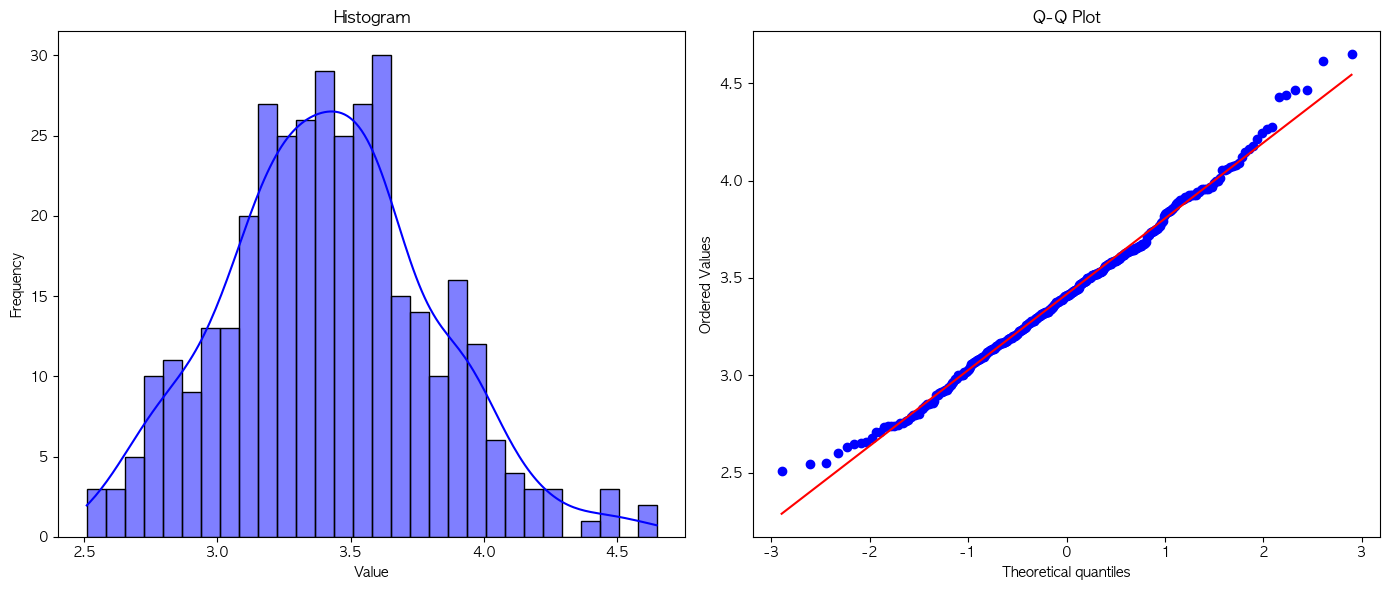

Statistic: 0.9932, p-value: 0.0959
Statistic: 0.3893
Critical Values and Significance Levels:
Critical Value: 0.5700, Significance Level: 15.0%
Critical Value: 0.6490, Significance Level: 10.0%
Critical Value: 0.7790, Significance Level: 5.0%
Critical Value: 0.9080, Significance Level: 2.5%
Critical Value: 1.0800, Significance Level: 1.0%
Shapiro-Wilk Test: 귀무가설 채택.
Anderson-Darling Test: 귀무가설 채택.


In [90]:
from scipy.stats import shapiro, anderson, probplot

data = result['평균']

plt.figure(figsize=(14, 6))

# 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(data, kde=True, bins=30, color='blue')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Q-Q 플롯
plt.subplot(1, 2, 2)
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat_shapiro, p_value_shapiro = shapiro(data)
print(f"Statistic: {stat_shapiro:.4f}, p-value: {p_value_shapiro:.4f}")

# Anderson-Darling Test
result_anderson = anderson(data)
print(f"Statistic: {result_anderson.statistic:.4f}")
print("Critical Values and Significance Levels:")
for crit_val, sig_level in zip(result_anderson.critical_values, result_anderson.significance_level):
    print(f"Critical Value: {crit_val:.4f}, Significance Level: {sig_level}%")

alpha = 0.05
if p_value_shapiro > alpha:
    print("Shapiro-Wilk Test: 귀무가설 채택.")
else:
    print("Shapiro-Wilk Test: 귀무가설 기각.")

if result_anderson.statistic < result_anderson.critical_values[2]:  # 보통 5% 유의수준 사용
    print("Anderson-Darling Test: 귀무가설 채택.")
else:
    print("Anderson-Darling Test: 귀무가설 기각.")


### 배터리용량 노선별 분리

In [46]:
df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
5      경기70바1254  98     33         A      33_A 2023-01-04 15:42:40   
...          ...  ..    ...       ...       ...                 ...   
80842  경기70바1969  30      9         A       9_A 2023-12-27 11:34:54   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  충전 인터벌(시간)  \
1     2023-01-03 12:30:34       87.28      8510           60  ...        17.0   
2     2023-01-03 16:25:15       28.24      4643           69  ...         4.0   
3     2023-01-04 02:11:29      183.32     15986           19  ...         8.0   
4     2023-01-04 12:12:15       72.00      9262           58  ...        10.0   
5     2023-01-04 16:01:06       56.08      5692           59  ...         4.0   
...                   ...         ...       ...          ...  ...         ...   
80842 2023-12-27 11:56:24       18.76         0           63  ...        18.0   
80844 2023-12-29 07:35:58       44.16         0           62  ...        14.0   
80845 2023-12-29 10:38:28       64.56         0           57  ...         3.0   
80846 2023-12-29 16:40:36       21.08         0           63  ...         6.0   
80847 2023-12-30 00:07:47      120.56         0           20  ...         6.0   

            충전소요시간_수정 SOC종료-시작_수정       충전일자   월  요일 주중/주말 왕복운행거리  인가거리  \
1     0 days 00:29:58          35 2023-01-03   1   화    주중  50.90  50.9   
2     0 days 00:12:55          12 2023-01-03   1   화    주중  50.90  50.9   
3     0 days 02:00:29          76 2023-01-04   1   수    주중  50.90  50.9   
4     0 days 00:23:11          29 2023-01-04   1   수    주중  50.90  50.9   
5     0 days 00:18:26          22 2023-01-04   1   수    주중  50.90  50.9   
...               ...         ...        ...  ..  ..   ...    ...   ...   
80842 0 days 00:21:30          32 2023-12-27  12   수    주중  43.63  43.6   
80844 0 days 00:15:06          26 2023-12-29  12   금    주중  43.63  43.6   
80845 0 days 00:22:44          38 2023-12-29  12   금    주중  43.63  43.6   
80846 0 days 00:14:16          24 2023-12-29  12   금    주중  43.63  43.6   
80847 0 days 01:22:07          75 2023-12-29  12   금    주중  43.63  43.6   

         충전소요시간_분  
1       29.966667  
2       12.916667  
3      120.483333  
4       23.183333  
5       18.433333  
...           ...  
80842   21.500000  
80844   15.100000  
80845   22.733333  
80846   14.266667  
80847   82.116667  

[74790 rows x 21 columns]

In [ ]:
df = df.merge(b, on='차량번호')

In [31]:
df.columns

Index(['차량번호', '노선명', '충전기ID', 'OUTLET ID', '충전기ID_충전구', '충전시작시각', '충전종료시각',
       '충전전력량(kWh)', '충전 요금(원)', '충전시작 SOC(%)', '충전종료 SOC(%)', '충전 인터벌(시간)',
       '충전소요시간_수정', 'SOC종료-시작_수정', '충전일자', '월', '요일', '주중/주말', '왕복운행거리',
       '인가거리', '배터리용량(kWh)', '충전소요시간_분'],
      dtype='object')

In [41]:
pd.set_option('display.max_rows', None)

In [ ]:
bttc = df.groupby(['노선명','차량번호'])['배터리용량(kWh)'].agg(['min']).reset_index()
bttc

### 충전 인터벌 패턴 분석

In [125]:
pdf['충전일자'] = pd.to_datetime(pdf['충전일자'])
pdf = pdf[pdf['노선명'] != '37']
pdf['충전소요시간_수정'] = pd.to_timedelta(pdf['충전소요시간_수정'])
pdf['충전소요시간_분'] = pdf['충전소요시간_수정'].dt.total_seconds() / 60

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_23991/3981371199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['충전소요시간_수정'] = pd.to_timedelta(pdf['충전소요시간_수정'])
/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_23991/3981371199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['충전소요시간_분'] = pdf['충전소요시간_수정'].dt.total_seconds() / 60


#### 노선별

In [45]:
df['충전 인터벌(시간)'].value_counts(dropna=False)

충전 인터벌(시간)
3.0     26448
6.0      9706
2.0      8986
5.0      5544
7.0      5191
4.0      5144
8.0      5028
9.0      2635
10.0     1275
12.0     1041
11.0      745
13.0      626
14.0      566
15.0      386
16.0      313
17.0      259
18.0      239
19.0      133
1.0       106
22.0      101
20.0      100
23.0       97
21.0       82
24.0       39
Name: count, dtype: int64

In [52]:
df['충전 인터벌(시간)'] = df['충전 인터벌(시간)'].round()
intvc = df.groupby(['노선명', '충전 인터벌(시간)']).size().reset_index(name='빈도')

intvc

노선명  충전 인터벌(시간)    빈도
0    25         1.0    10
1    25         2.0  1488
2    25         3.0  3684
3    25         4.0   211
4    25         5.0   595
..   ..         ...   ...
159  98        20.0    38
160  98        21.0    44
161  98        22.0    72
162  98        23.0    56
163  98        24.0    18

[164 rows x 3 columns]

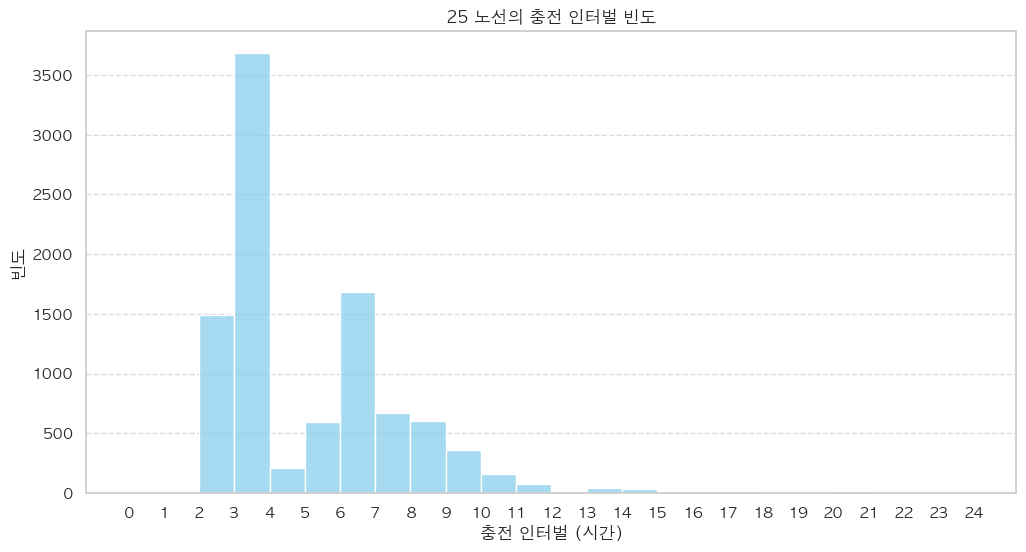

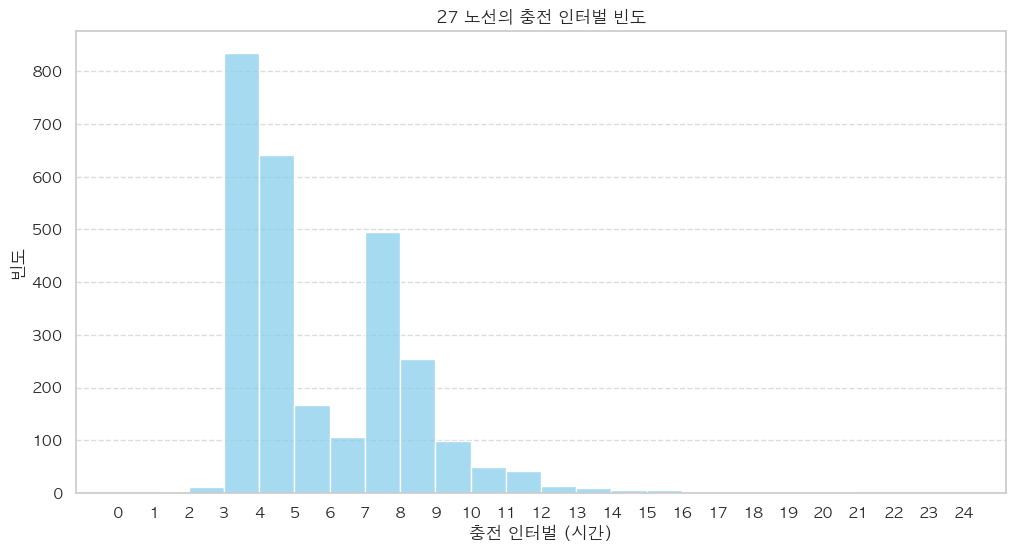

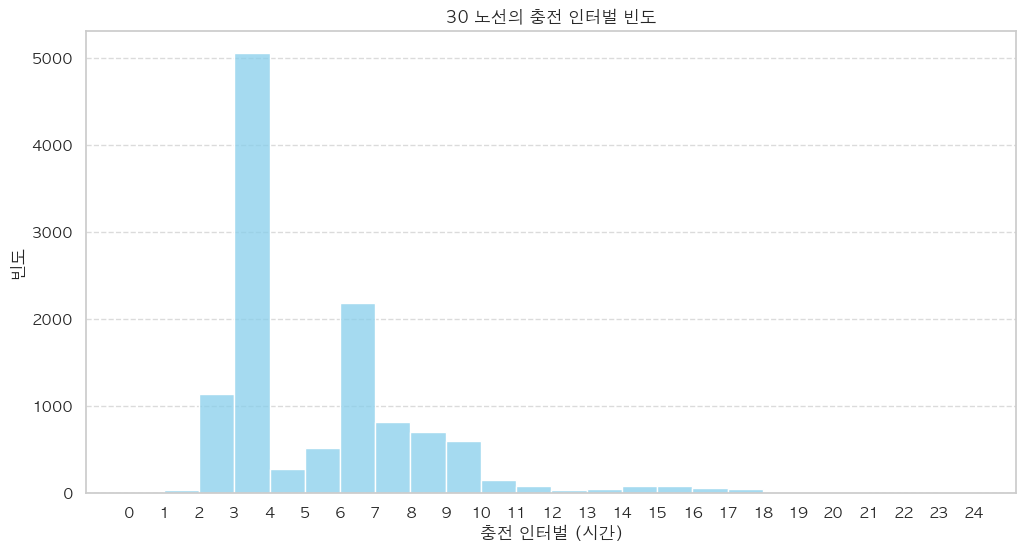

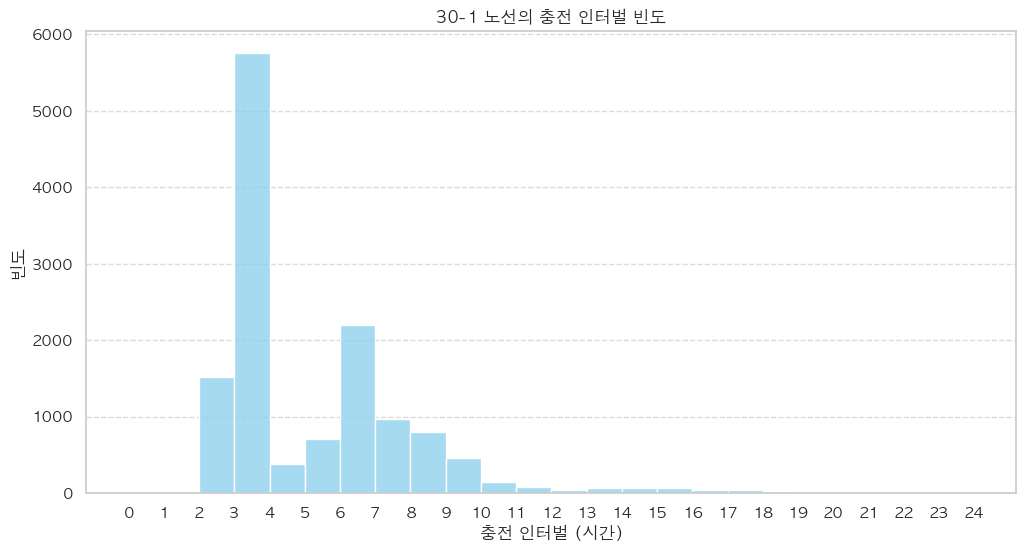

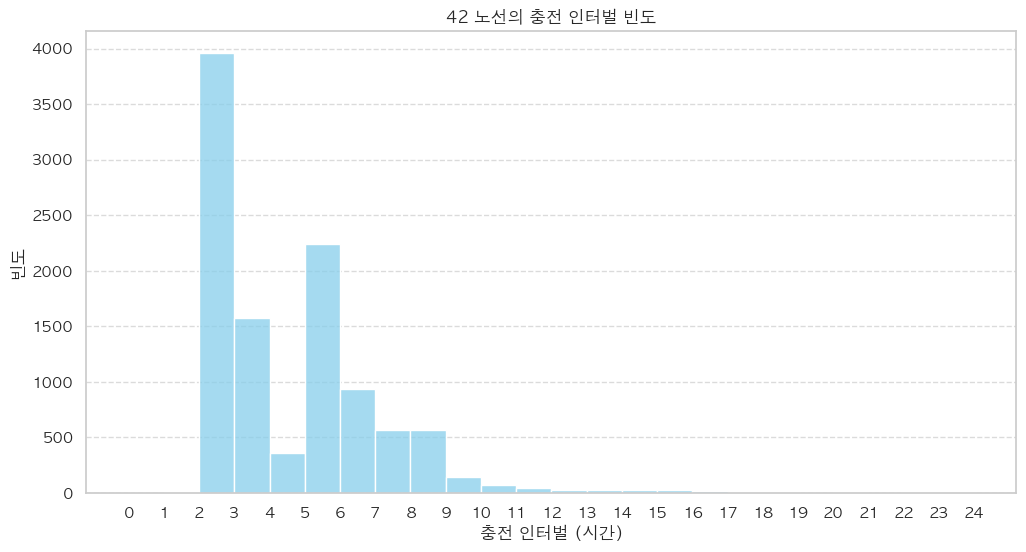

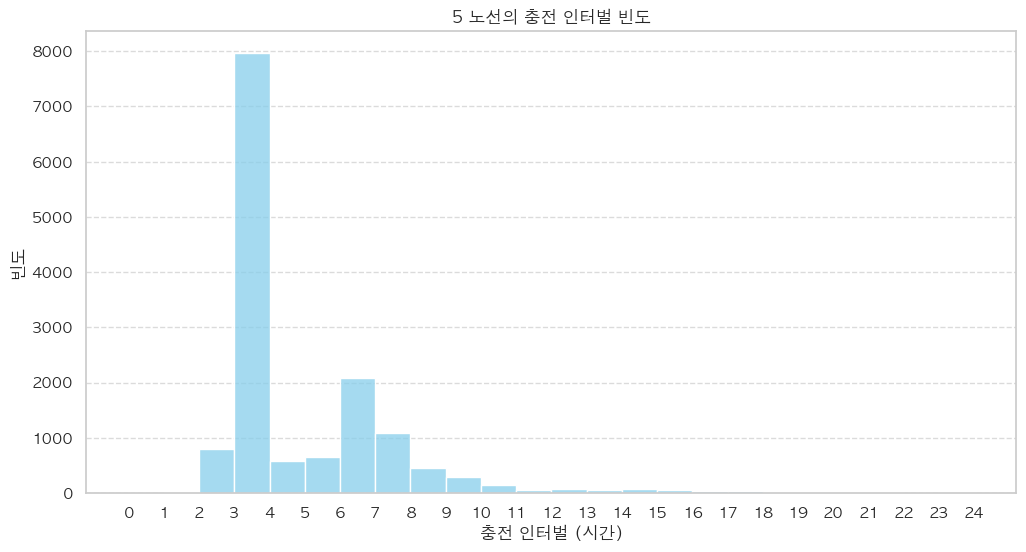

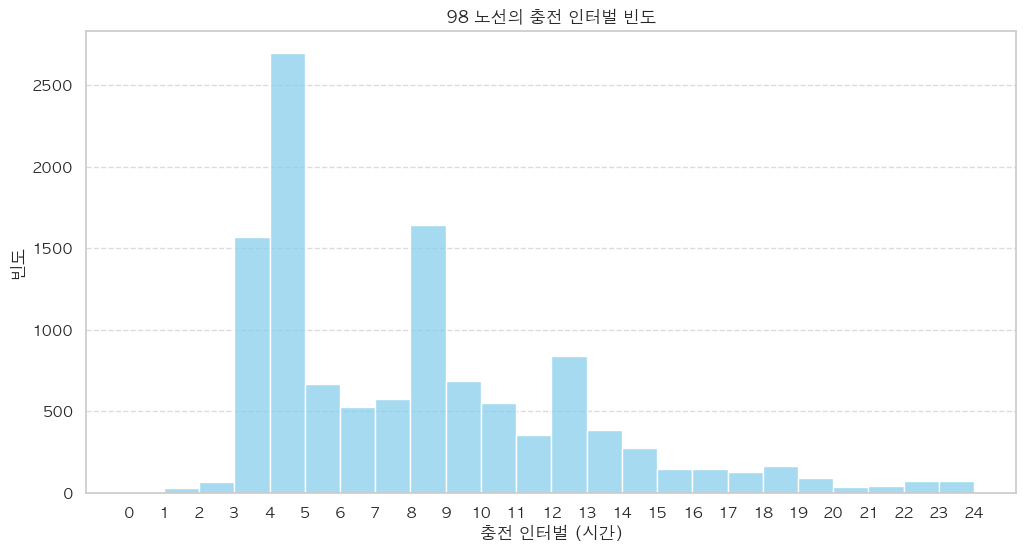

In [61]:
uniq = intvc['노선명'].unique()

for route in uniq:
    data = intvc[intvc['노선명'] == route]

    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=data,
        x='충전 인터벌(시간)',
        weights='빈도',
        bins=range(0, 25),
        kde=False,
        color='skyblue'
    )
    plt.title(f'{route} 노선의 충전 인터벌 빈도')
    plt.xlabel('충전 인터벌 (시간)')
    plt.ylabel('빈도')
    plt.grid(False)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(0, 25, 1))
    #plt.yticks(range(0, 8000, 1000))
    plt.show()


In [65]:
uniq = intvc['노선명'].unique()

with PdfPages('노선별_충전인터벌빈도.pdf') as pdf:
    for route in uniq:
        data = intvc[intvc['노선명'] == route]

        plt.figure(figsize=(12, 6))
        sns.histplot(
            data=data,
            x='충전 인터벌(시간)',
            weights='빈도',
            bins=range(0, 25),
            kde=False,
            color='skyblue'
        )
        plt.title(f'{route} 노선의 충전 인터벌 빈도')
        plt.xlabel('충전 인터벌 (시간)')
        plt.ylabel('빈도')
        plt.grid(False)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(range(0, 25, 1))
        #plt.yticks(range(0, 8000, 1000))
        
        pdf.savefig()
        plt.close()

print("저장됨")


저장됨


#### 노선 - 차량별

In [53]:
vintvc = df.groupby(['노선명', '차량번호', '충전 인터벌(시간)']).size().reset_index(name='빈도')
vintvc

노선명       차량번호  충전 인터벌(시간)   빈도
0     25  경기70바1931         1.0    3
1     25  경기70바1931         2.0  199
2     25  경기70바1931         3.0  452
3     25  경기70바1931         4.0   35
4     25  경기70바1931         5.0   74
...   ..        ...         ...  ...
1467  98  경기70바2409        20.0    3
1468  98  경기70바2409        21.0    4
1469  98  경기70바2409        22.0    5
1470  98  경기70바2409        23.0    7
1471  98  경기70바2409        24.0    3

[1472 rows x 4 columns]

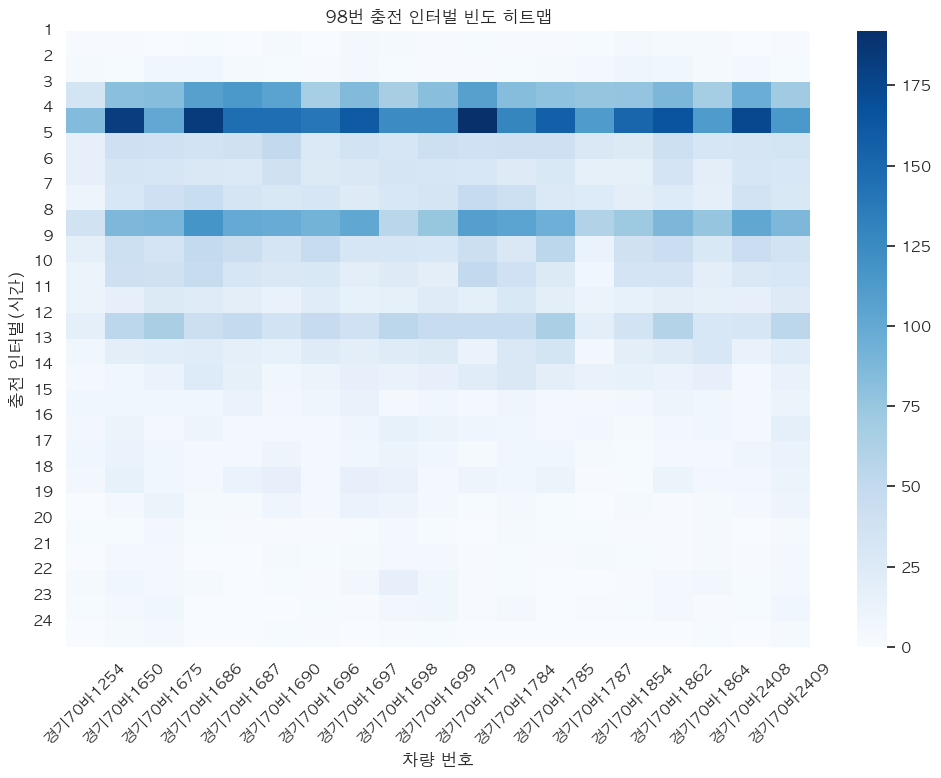

In [56]:
vintvc_98 = vintvc[vintvc['노선명'] == '98']

df_98 = vintvc_98.pivot(index='충전 인터벌(시간)', columns='차량번호', values='빈도').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(df_98, cmap="Blues", fmt="g") 
plt.title('98번 충전 인터벌 빈도 히트맵')
plt.xlabel('차량 번호')
plt.ylabel('충전 인터벌(시간)')

plt.yticks(ticks=range(len(df_98.index)), labels=[int(i) for i in df_98.index])

plt.xticks(rotation=45)
plt.show()


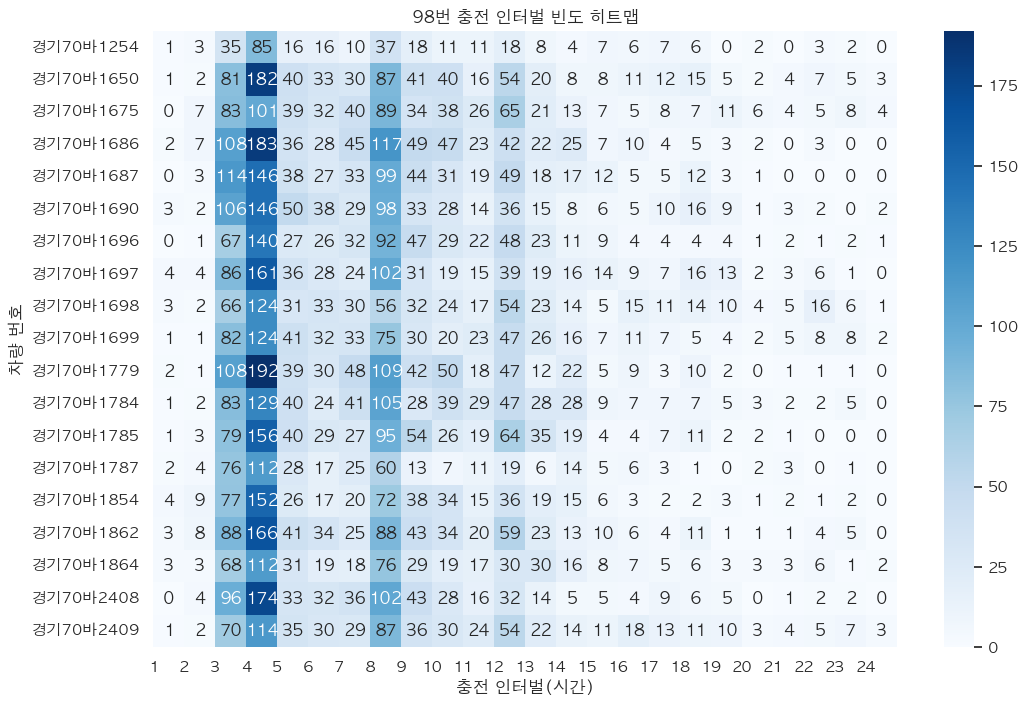

In [188]:
df_98_transposed = vintvc_98.pivot(index='차량번호', columns='충전 인터벌(시간)', values='빈도').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(df_98_transposed, cmap="Blues", annot=True, fmt="g")
plt.title('98번 충전 인터벌 빈도 히트맵')
plt.xlabel('충전 인터벌(시간)')
plt.ylabel('차량 번호')

plt.xticks(ticks=range(len(df_98_transposed.columns)), labels=[int(i) for i in df_98_transposed.columns], rotation=0)
plt.yticks(rotation=0)
plt.show()


In [ ]:
df_98_per = df_98_transposed.div(df_98_transposed.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(df_98_per, cmap="Blues", annot=True, fmt=".0f")
plt.xlabel('충전 인터벌(시간)')
plt.ylabel('차량 번호')

plt.xticks(ticks=range(len(df_98_per.columns)), labels=[int(i) for i in df_98_per.columns], rotation=0)
plt.yticks(rotation=0)
plt.show()

In [ ]:
for route in vintvc['노선명'].unique():
    route_data = vintvc[vintvc['노선명'] == route]
    plt.figure(figsize=(12, 6))
    sns.histplot(data=route_data, x='충전 인터벌(시간)', hue='차량번호', weights='빈도', multiple='stack', bins=range(0, 25), kde=False)
    plt.title(f'{route} 노선 차량별 충전 인터벌 빈도')
    plt.xlabel('충전 인터벌 (시간)')
    plt.ylabel('빈도')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(0, 25, 1))
    plt.show()

In [ ]:
vintvc = df.groupby(['노선명', '차량번호', '충전 인터벌(시간)']).size().reset_index(name='빈도')
 
with PdfPages('노선별차량별_충전인터벌_stack.pdf') as pdf:
    for route in vintvc['노선명'].unique():
        route_data = vintvc[vintvc['노선명'] == route]
        
        plt.figure(figsize=(12, 6))
        sns.histplot(data=route_data, x='충전 인터벌(시간)', hue='차량번호', weights='빈도', multiple='stack', bins=range(0, 25), kde=False)
        plt.title(f'{route} 노선 차량별 충전 인터벌 빈도')
        plt.xlabel('충전 인터벌 (시간)')
        plt.ylabel('빈도')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(range(0, 25, 1))
        
        pdf.savefig()
        plt.close()

print("저장됨")

In [ ]:
palette = sns.color_palette("tab10", len(vintvc['노선명'].unique()))  
rcolors = dict(zip(vintvc['노선명'].unique(), palette)) 

for route in vintvc['노선명'].unique():
    data = vintvc[vintvc['노선명'] == route]
    venum = data['차량번호'].unique()
    
    max_freq = data.groupby('차량번호')['빈도'].max().max()

    fig, axes = plt.subplots(nrows=len(venum), figsize=(12, 6 * len(venum)), sharex=True)
    fig.suptitle(f'{route} 노선 차량별 충전 인터벌 빈도', fontsize=16)
    
    color = rcolors[route]
    
    for ax, vehicle in zip(axes, venum):
        vedata = data[data['차량번호'] == vehicle]
        sns.histplot(
            data=vedata,
            x='충전 인터벌(시간)',
            weights='빈도',
            bins=range(0, 25),
            kde=False,
            ax=ax,
            color=color
        )
        ax.set_title(f'차량번호: {vehicle}')
        ax.set_xlabel('충전 인터벌 (시간)')
        ax.set_ylabel('빈도')
        ax.set_ylim(0, max_freq + 100)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [51]:
palette = sns.color_palette("tab10", len(vintvc['노선명'].unique()))
rcolors = dict(zip(vintvc['노선명'].unique(), palette))

with PdfPages('노선별차량별_충전인터벌.pdf') as pdf:
    for route in vintvc['노선명'].unique():
        data = vintvc[vintvc['노선명'] == route]
        venum = data['차량번호'].unique()

        max_freq = data.groupby('차량번호')['빈도'].max().max()

        fig, axes = plt.subplots(nrows=len(venum), figsize=(12, 6 * len(venum)), sharex=True)
        fig.suptitle(f'{route} 노선 차량별 충전 인터벌 빈도', fontsize=16)

        color = rcolors[route]

        if len(venum) == 1:
            axes = [axes]

        for ax, vehicle in zip(axes, venum):
            vedata = data[data['차량번호'] == vehicle]
            sns.histplot(
                data=vedata,
                x='충전 인터벌(시간)',
                weights='빈도',
                bins=range(0, 25),
                kde=False,
                ax=ax,
                color=color
            )
            ax.set_title(f'차량번호: {vehicle}')
            ax.set_xlabel('충전 인터벌 (시간)')
            ax.set_ylabel('빈도')
            ax.set_ylim(0, max_freq + 100)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.set_xticks(range(0, 25, 1))

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        pdf.savefig(fig)  
        plt.close(fig) 

print("저장됨")


저장됨


### GMM

In [11]:
df['노선명'].value_counts()

노선명
5       15379
30-1    13955
98      13114
30      12414
42      11135
25      10164
27       2767
Name: count, dtype: int64

In [12]:
df.columns

Index(['차량번호', '노선명', '충전기ID', 'OUTLET ID', '충전기ID_충전구', '충전시작시각', '충전종료시각',
       '충전전력량(kWh)', '충전 요금(원)', '충전시작 SOC(%)', '충전종료 SOC(%)', '충전 인터벌(시간)',
       '충전소요시간_수정', 'SOC종료-시작_수정', '충전일자', '월', '요일', '주중/주말', '왕복운행거리',
       '인가거리', '충전소요시간_분'],
      dtype='object')

In [ ]:
df['충전 인터벌(시간)'] = pd.to_numeric(df['충전 인터벌(시간)'], errors='coerce')

df = df.dropna(subset=['노선명', '충전 인터벌(시간)'])

routes = df['노선명'].unique()

def fit_gmm_by_route(route_name, df):
    route_data = df[df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    gmm = GaussianMixture(n_components=4, random_state=42) 
    gmm.fit(route_data)
    
    x = np.linspace(min(route_data), max(route_data), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(route_data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
    plt.plot(x, pdf, label='GMM', color='red')
    plt.title(f'GMM Fit for Route: {route_name}')
    plt.xlabel('Charging Interval (hours)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

for route in routes:
    fit_gmm_by_route(route, df)

In [ ]:
def compute_bic_and_best_component(route_name, df):
    route_data = df[df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    bic_scores = []
    n_components_range = range(1, 21) 
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(route_data)
        bic_scores.append(gmm.bic(route_data))
    
    best_n_components = n_components_range[np.argmin(bic_scores)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic_scores, marker='o', color='blue')
    plt.title(f'BIC Scores for Route: {route_name}')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Score')
    plt.axvline(best_n_components, color='red', linestyle='--', label=f'Best n_components: {best_n_components}')
    plt.legend()
    plt.show()
    
    print(f"Route: {route_name}, Best number of components: {best_n_components}")

for route in routes:
    compute_bic_and_best_component(route, df)


In [ ]:
df['충전 인터벌(시간)'] = pd.to_numeric(df['충전 인터벌(시간)'], errors='coerce')

df = df.dropna(subset=['노선명', '충전 인터벌(시간)'])

routes = df['노선명'].unique()

def fit_gmm_by_route(route_name, df):
    route_data = df[df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    gmm = GaussianMixture(n_components=4, random_state=42) 
    gmm.fit(route_data)
    
    x = np.linspace(min(route_data), max(route_data), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(route_data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
    plt.plot(x, pdf, label='GMM', color='red')
    plt.title(f'GMM Fit for Route: {route_name}')
    plt.xlabel('Charging Interval (hours)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

for route in routes:
    fit_gmm_by_route(route, df)

In [ ]:
df['충전 인터벌(시간)'] = pd.to_numeric(df['충전 인터벌(시간)'], errors='coerce')

df = df.dropna(subset=['노선명', '충전 인터벌(시간)'])

routes = df['노선명'].unique()

def fit_gmm_by_route(route_name, df):
    route_data = df[df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    gmm = GaussianMixture(n_components=9, random_state=42) 
    gmm.fit(route_data)
    
    x = np.linspace(min(route_data), max(route_data), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(route_data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
    plt.plot(x, pdf, label='GMM', color='red')
    plt.title(f'GMM Fit for Route: {route_name}')
    plt.xlabel('Charging Interval (hours)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

for route in routes:
    fit_gmm_by_route(route, df)

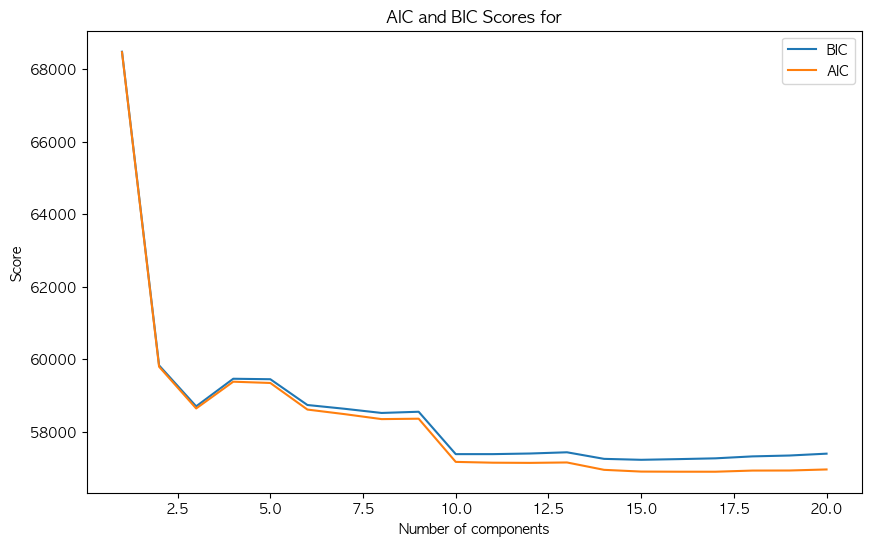

최적의 군집 개수: 15


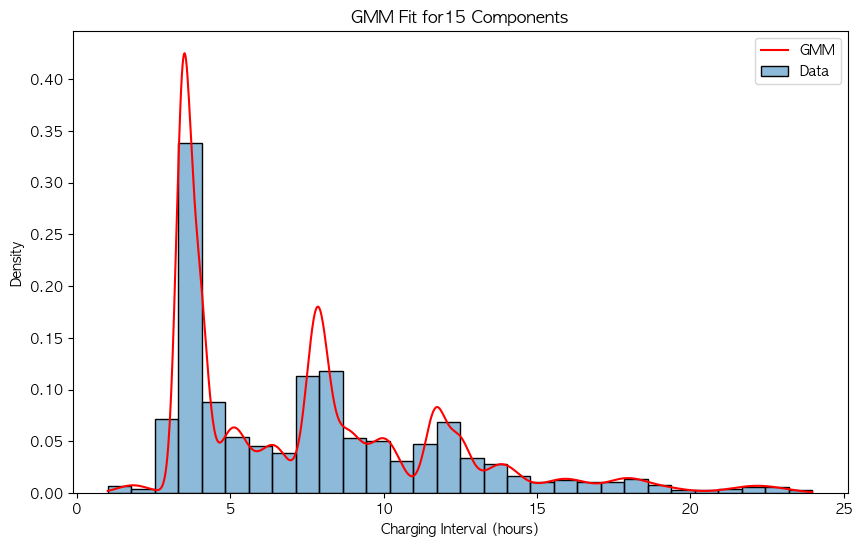

In [23]:
dff = df.copy()

dff['충전 인터벌(시간)'] = pd.to_numeric(dff['충전 인터벌(시간)'], errors='coerce')
dff = dff.dropna(subset=['노선명', '충전 인터벌(시간)'])

route_98_data = dff[dff['노선명'] == '98']['충전 인터벌(시간)'].values.reshape(-1, 1)

n_components = np.arange(1, 21)  
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(route_98_data) for n in n_components]

plt.figure(figsize=(10, 6))
plt.plot(n_components, [m.bic(route_98_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(route_98_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores for')
plt.show()

best_n_components = n_components[np.argmin([m.bic(route_98_data) for m in models])]
print(f'최적의 군집 개수: {best_n_components}')

def fit_gmm_for_route_98(best_n_components, route_data):
    gmm = GaussianMixture(n_components=best_n_components, random_state=42)
    gmm.fit(route_data)
    
    x = np.linspace(min(route_data), max(route_data), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(route_data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
    plt.plot(x, pdf, label='GMM', color='red')
    plt.title(f'GMM Fit for{best_n_components} Components')
    plt.xlabel('Charging Interval (hours)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

fit_gmm_for_route_98(best_n_components, route_98_data)


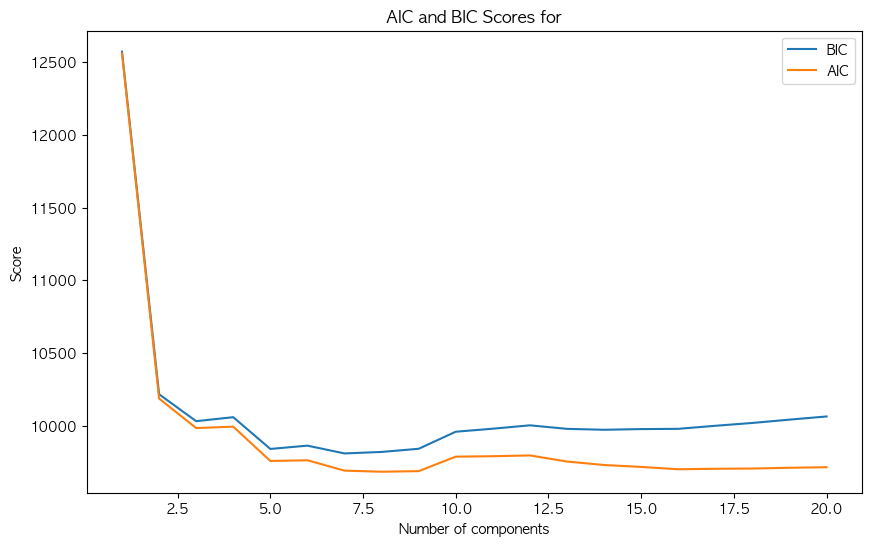

최적의 군집 개수: 7


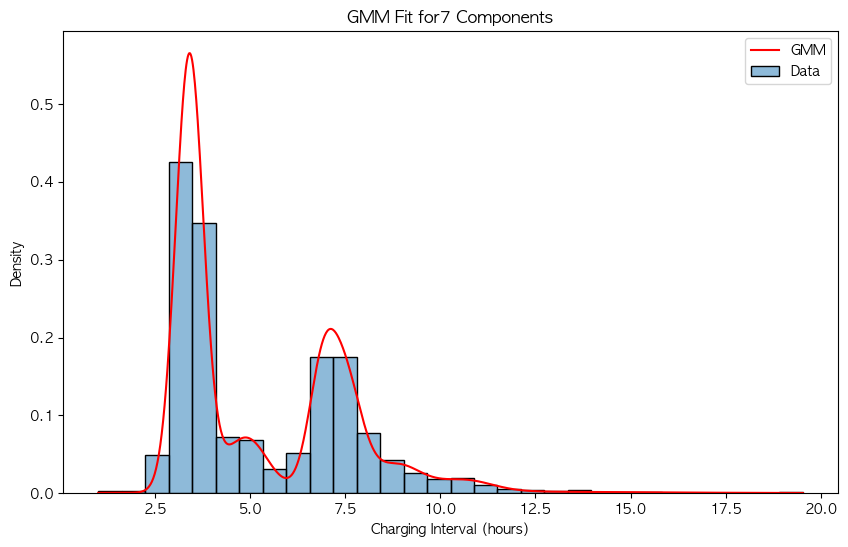

In [24]:
dff = df.copy()

dff['충전 인터벌(시간)'] = pd.to_numeric(dff['충전 인터벌(시간)'], errors='coerce')
dff = dff.dropna(subset=['노선명', '충전 인터벌(시간)'])

route_27_data = dff[dff['노선명'] == '27']['충전 인터벌(시간)'].values.reshape(-1, 1)

n_components = np.arange(1, 21)  
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(route_27_data) for n in n_components]

plt.figure(figsize=(10, 6))
plt.plot(n_components, [m.bic(route_27_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(route_27_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores for')
plt.show()

best_n_components = n_components[np.argmin([m.bic(route_27_data) for m in models])]
print(f'최적의 군집 개수: {best_n_components}')


def fit_gmm_for_route_98(best_n_components, route_data):
    gmm = GaussianMixture(n_components=best_n_components, random_state=42)
    gmm.fit(route_data)
    
    x = np.linspace(min(route_data), max(route_data), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(route_data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
    plt.plot(x, pdf, label='GMM', color='red')
    plt.title(f'GMM Fit for{best_n_components} Components')
    plt.xlabel('Charging Interval (hours)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

fit_gmm_for_route_98(best_n_components, route_27_data)


In [ ]:
df['충전 인터벌(시간)'] = pd.to_numeric(df['충전 인터벌(시간)'], errors='coerce')
df = df.dropna(subset=['충전 인터벌(시간)'])

chargei = df['충전 인터벌(시간)'].values.reshape(-1, 1)

scaler = StandardScaler()
chis = scaler.fit_transform(chargei)

bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42, weight_concentration_prior_type='dirichlet_process')
bgmm.fit(chis)

n_clusters = len(np.unique(bgmm.predict(chis)))
print(f'추정된 군집 개수: {n_clusters}')

log_llh = bgmm.score_samples(chis).sum()

n_features = chis.shape[1]
n_com = len(bgmm.weights_)
n_par = (n_com - 1) + n_com * (n_features + (n_features * (n_features + 1) / 2))  # weights + means + covariances

bic_score = -2 * log_llh + n_par * np.log(len(chis))
print(f'BIC 점수: {bic_score}')

x = np.linspace(min(chis), max(chis), 1000).reshape(-1, 1)
logprob = bgmm.score_samples(x)
pdf = np.exp(logprob)

x_original = scaler.inverse_transform(x)

plt.figure(figsize=(10, 6))
plt.hist(df['충전 인터벌(시간)'], bins=30, density=True, color='skyblue', label='Data')
plt.plot(x_original, pdf, label='BGMM', color='red')
plt.title(f'BGMM 적합 결과')
plt.xlabel('충전 인터벌 (시간)')
plt.ylabel('밀도')
plt.legend()
plt.show()


In [151]:
np.round(bgmm.weights_, 2)

array([0.48, 0.02, 0.02, 0.19, 0.07, 0.19, 0.  , 0.  , 0.03, 0.  ])

In [86]:
df.columns

Index(['차량번호', '노선명', '충전기ID', 'OUTLET ID', '충전기ID_충전구', '충전시작시각', '충전종료시각',
       '충전전력량(kWh)', '충전 요금(원)', '충전시작 SOC(%)', '충전종료 SOC(%)', '충전 인터벌(시간)',
       '충전소요시간_수정', 'SOC종료-시작_수정', '충전일자', '월', '요일', '주중/주말', '왕복운행거리',
       '인가거리', '충전소요시간_분'],
      dtype='object')

In [ ]:
df['충전 인터벌(시간)'] = pd.to_numeric(df['충전 인터벌(시간)'], errors='coerce')
df = df.dropna(subset=['충전 인터벌(시간)'])

routes = df['노선명'].unique()

with PdfPages('BGMM_result.pdf') as pdf_pages:
    for route in routes:
        route_df = df[df['노선명'] == route]
        chargei = route_df['충전 인터벌(시간)'].values.reshape(-1, 1)

        scaler = StandardScaler()
        chis = scaler.fit_transform(chargei)

        bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42, weight_concentration_prior_type='dirichlet_process')
        bgmm.fit(chis)

        n_clusters = len(np.unique(bgmm.predict(chis)))
        print(f'노선 {route}의 추정된 군집 개수: {n_clusters}')

        log_llh = bgmm.score_samples(chis).sum()
        n_features = chis.shape[1]
        n_com = len(bgmm.weights_)
        n_par = (n_com - 1) + n_com * (n_features + (n_features * (n_features + 1) / 2))  
        bic_score = -2 * log_llh + n_par * np.log(len(chis))
        print(f'노선 {route}의 BIC 점수: {bic_score}')

        x = np.linspace(min(chis), max(chis), 1000).reshape(-1, 1)
        logprob = bgmm.score_samples(x)
        pdf = np.exp(logprob)

        x_original = scaler.inverse_transform(x)

        plt.figure(figsize=(10, 6))
        plt.hist(route_df['충전 인터벌(시간)'], bins=30, density=True, color='skyblue', label='Data')
        plt.plot(x_original, pdf, label='BGMM', color='red')
        plt.title(f'노선 {route}의 BGMM 적합 결과')
        plt.xlabel('충전 인터벌 (시간)')
        plt.ylabel('밀도')
        plt.legend()
        
        pdf_pages.savefig()
        plt.show()
        plt.close()


In [96]:
def ehdi(route_df, bgmm, scaler, n_std=1):
    chargei = route_df['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    chis = scaler.transform(chargei)
    
    means = bgmm.means_.flatten() 
    covariances = bgmm.covariances_.flatten()  
    std_devs = np.sqrt(covariances)  
    
    sorted_indices = np.argsort(bgmm.weights_)[-2:]  
    
    filtered_data_list = []
    
    for idx in sorted_indices:
        mean = means[idx]
        std_dev = std_devs[idx]
        
        lower_bound = mean - n_std * std_dev
        upper_bound = mean + n_std * std_dev
        
        lower_bound_original = scaler.inverse_transform([[lower_bound]])[0][0]
        upper_bound_original = scaler.inverse_transform([[upper_bound]])[0][0]
        
        condition = (route_df['충전 인터벌(시간)'] >= lower_bound_original) & \
                    (route_df['충전 인터벌(시간)'] <= upper_bound_original)
        filtered_data = route_df[condition]
        filtered_data_list.append(filtered_data)
    
    final_filtered_data = pd.concat(filtered_data_list)
    
    return final_filtered_data

for route in ['98', '27']:
    route_df = df[df['노선명'] == route]
    chargei = route_df['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    scaler = StandardScaler()
    chis = scaler.fit_transform(chargei)
    
    bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42, weight_concentration_prior_type='dirichlet_process')
    bgmm.fit(chis)
    
    filtered_data = ehdi(route_df, bgmm, scaler)
    
    result = filtered_data[['차량번호', '충전시작시각', '충전종료시각', '충전시작 SOC(%)', '충전종료 SOC(%)', '충전 인터벌(시간)']]
    
    print(f"노선 {route}의 분석 결과:")
    print(result)


노선 98의 분석 결과:
            차량번호              충전시작시각              충전종료시각  충전시작 SOC(%)  \
3      경기70바1254 2023-01-04 00:11:00 2023-01-04 02:11:29           19   
11     경기70바1254 2023-01-06 00:02:52 2023-01-06 01:58:01           22   
57     경기70바1254 2023-01-25 20:24:58 2023-01-25 20:44:51           26   
62     경기70바1254 2023-01-27 00:33:05 2023-01-27 02:24:47           24   
96     경기70바1254 2023-02-06 22:27:52 2023-02-07 00:29:07           18   
...          ...                 ...                 ...          ...   
13101  경기70바2409 2023-12-25 15:32:14 2023-12-25 16:01:51           60   
13106  경기70바2409 2023-12-27 20:56:32 2023-12-27 21:37:04           39   
13109  경기70바2409 2023-12-28 12:53:12 2023-12-28 13:25:49           54   
13110  경기70바2409 2023-12-28 17:02:56 2023-12-28 17:27:30           69   
13112  경기70바2409 2023-12-29 12:49:38 2023-12-29 13:19:17           61   

       충전종료 SOC(%)  충전 인터벌(시간)  
3               95    7.762500  
11              95    7.813333  
57        

/opt/anaconda3/envs/da/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/anaconda3/envs/da/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [98]:
# 노선별 확률밀도가 높은 구간에 해당하는 데이터 추출
def ehdi(route_df, bgmm, scaler, n_std=1):
    chargei = route_df['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    chis = scaler.transform(chargei)
    
    # 각 컴포넌트의 평균 분산 추출
    means = bgmm.means_.flatten()  # 컴포넌트의 평균값들
    covariances = bgmm.covariances_.flatten()  # 컴포넌트의 분산(표준편차^2)
    std_devs = np.sqrt(covariances)  # 표준편차
    
    # 가장 높은 확률밀도를 가진 컴포넌트 2개의 평균과 표준편차 기반 범위 설정
    sorted_indices = np.argsort(bgmm.weights_)[-2:]  # 상위 2개의 컴포넌트 선택
    
    filtered_data_list = []
    
    for idx in sorted_indices:
        mean = means[idx]
        std_dev = std_devs[idx]
        
        # 확률밀도가 높은 범위: 평균 ± n_std * 표준편차
        lower_bound = mean - n_std * std_dev
        upper_bound = mean + n_std * std_dev
        
        # 스케일링 되기 전의 원본 값 범위로 변환
        lower_bound_original = scaler.inverse_transform([[lower_bound]])[0][0]
        upper_bound_original = scaler.inverse_transform([[upper_bound]])[0][0]
        
        condition = (route_df['충전 인터벌(시간)'] >= lower_bound_original) & \
                    (route_df['충전 인터벌(시간)'] <= upper_bound_original)
        filtered_data = route_df[condition]
        filtered_data_list.append(filtered_data)
    
    final_filtered_data = pd.concat(filtered_data_list)
    
    return final_filtered_data


for route in ['98', '27']:
    route_df = df[df['노선명'] == route]
    chargei = route_df['충전 인터벌(시간)'].values.reshape(-1, 1)

    scaler = StandardScaler()
    chis = scaler.fit_transform(chargei)
    
    bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42, weight_concentration_prior_type='dirichlet_process')
    bgmm.fit(chis)
    
    filtered_data = ehdi(route_df, bgmm, scaler)
    
    result = filtered_data[['차량번호', '충전시작시각', '충전종료시각', '충전시작 SOC(%)', '충전종료 SOC(%)', '충전 인터벌(시간)']]

    result.to_csv(f'BGMM_route_{route}_result.csv', index=False, encoding='utf-8-sig')
    
    print(f"노선 {route}의 분석 결과가 BGMM_route_{route}_result.csv 파일로 저장되었습니다.")


/opt/anaconda3/envs/da/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


노선 98의 분석 결과가 BGMM_route_98_result.csv 파일로 저장되었습니다.
노선 27의 분석 결과가 BGMM_route_27_result.csv 파일로 저장되었습니다.


/opt/anaconda3/envs/da/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [99]:
gup = pd.read_csv('BGMM_route_98_result.csv')
ech = pd.read_csv('BGMM_route_27_result.csv')

In [100]:
gup

차량번호               충전시작시각               충전종료시각  충전시작 SOC(%)  \
0     경기70바1254  2023-01-04 00:11:00  2023-01-04 02:11:29           19   
1     경기70바1254  2023-01-06 00:02:52  2023-01-06 01:58:01           22   
2     경기70바1254  2023-01-25 20:24:58  2023-01-25 20:44:51           26   
3     경기70바1254  2023-01-27 00:33:05  2023-01-27 02:24:47           24   
4     경기70바1254  2023-02-06 22:27:52  2023-02-07 00:29:07           18   
...         ...                  ...                  ...          ...   
4400  경기70바2409  2023-12-25 15:32:14  2023-12-25 16:01:51           60   
4401  경기70바2409  2023-12-27 20:56:32  2023-12-27 21:37:04           39   
4402  경기70바2409  2023-12-28 12:53:12  2023-12-28 13:25:49           54   
4403  경기70바2409  2023-12-28 17:02:56  2023-12-28 17:27:30           69   
4404  경기70바2409  2023-12-29 12:49:38  2023-12-29 13:19:17           61   

      충전종료 SOC(%)  충전 인터벌(시간)  
0              95    7.762500  
1              95    7.813333  
2              50    7.777778  
3              95    7.764722  
4              95    7.709167  
...           ...         ...  
4400           91    3.898611  
4401           65    3.531111  
4402           95    3.398611  
4403           85    3.618611  
4404           95    3.839167  

[4405 rows x 6 columns]

In [192]:
g1

차량번호              충전시작시각               충전종료시각  충전시작 SOC(%)  \
1535  경기70바1254 2023-01-03 16:12:20  2023-01-03 16:25:15           69   
1536  경기70바1254 2023-01-04 15:42:40  2023-01-04 16:01:06           59   
1537  경기70바1254 2023-01-04 23:53:07  2023-01-05 01:55:05           18   
1538  경기70바1254 2023-01-05 12:02:23  2023-01-05 12:28:34           63   
1539  경기70바1254 2023-01-05 15:56:50  2023-01-05 16:14:04           69   
...         ...                 ...                  ...          ...   
4400  경기70바2409 2023-12-25 15:32:14  2023-12-25 16:01:51           60   
4401  경기70바2409 2023-12-27 20:56:32  2023-12-27 21:37:04           39   
4402  경기70바2409 2023-12-28 12:53:12  2023-12-28 13:25:49           54   
4403  경기70바2409 2023-12-28 17:02:56  2023-12-28 17:27:30           69   
4404  경기70바2409 2023-12-29 12:49:38  2023-12-29 13:19:17           61   

      충전종료 SOC(%)  충전 인터벌(시간)  시간대  soc량  
1535           81    3.696111   16    12  
1536           81    3.506944   15    22  
1537           95    3.682778   23    77  
1538           95    3.507222   12    32  
1539           80    3.471111   15    11  
...           ...         ...  ...   ...  
4400           91    3.898611   15    31  
4401           65    3.531111   20    26  
4402           95    3.398611   12    41  
4403           85    3.618611   17    16  
4404           95    3.839167   12    34  

[2870 rows x 8 columns]

In [109]:
g1 = gup[gup['충전 인터벌(시간)'] < 4]
g1['충전 인터벌(시간)'].mean()

3.606112369337979

In [181]:
g1['시간대'].value_counts().head(5)

시간대
12    405
23    355
0     318
22    300
13    261
Name: count, dtype: int64

In [182]:
g1['시간대'].value_counts()

시간대
12    405
23    355
0     318
22    300
13    261
21    204
14    190
15    177
17    171
16    147
18     72
20     59
19     54
1      53
8      27
11     25
7      17
9      11
10     10
4      10
2       3
5       1
Name: count, dtype: int64

In [230]:
q = g1[g1['시간대'].isin([12,13,14])]

In [193]:
q = g1[g1['시간대'] == 12]
q

차량번호              충전시작시각               충전종료시각  충전시작 SOC(%)  \
1538  경기70바1254 2023-01-05 12:02:23  2023-01-05 12:28:34           63   
1540  경기70바1254 2023-01-06 12:26:02  2023-01-06 12:53:18           62   
1558  경기70바1254 2023-01-25 12:06:09  2023-01-25 12:38:18           57   
1559  경기70바1254 2023-01-26 12:20:47  2023-01-26 12:54:49           53   
1561  경기70바1254 2023-01-27 12:24:45  2023-01-27 12:51:55           58   
...         ...                 ...                  ...          ...   
4377  경기70바2409 2023-11-17 12:38:14  2023-11-17 13:01:35           65   
4388  경기70바2409 2023-12-06 12:08:22  2023-12-06 12:47:35           57   
4390  경기70바2409 2023-12-08 12:21:36  2023-12-08 12:49:32           69   
4402  경기70바2409 2023-12-28 12:53:12  2023-12-28 13:25:49           54   
4404  경기70바2409 2023-12-29 12:49:38  2023-12-29 13:19:17           61   

      충전종료 SOC(%)  충전 인터벌(시간)  시간대  soc량  
1538           95    3.507222   12    32  
1540           95    3.898889   12    33  
1558           95    3.790833   12    38  
1559           95    3.644167   12    42  
1561           91    3.800833   12    33  
...           ...         ...  ...   ...  
4377           95    3.598889   12    30  
4388           95    3.476389   12    38  
4390           95    3.354167   12    26  
4402           95    3.398611   12    41  
4404           95    3.839167   12    34  

[405 rows x 8 columns]

In [231]:
q['soc량'].mean()

25.214953271028037

In [104]:
g2 = gup[gup['충전 인터벌(시간)'] > 6]
g2['충전 인터벌(시간)'].mean()

7.889965074194717

In [180]:
g2['시간대'].value_counts().head(5)

시간대
20    205
21    204
23    175
22    169
19    156
Name: count, dtype: int64

In [142]:
g2['시간대'].value_counts()

시간대
20    205
21    204
23    175
22    169
19    156
18    133
0     128
17     83
10     57
16     52
9      51
1      33
11     31
8      22
12     10
2       7
13      4
7       4
15      3
4       3
14      3
5       1
6       1
Name: count, dtype: int64

In [224]:
w = g2[g2['시간대'].isin([21,22,23])]
w

차량번호              충전시작시각               충전종료시각  충전시작 SOC(%)  \
4     경기70바1254 2023-02-06 22:27:52  2023-02-07 00:29:07           18   
5     경기70바1254 2023-02-08 23:03:47  2023-02-09 01:11:28           14   
6     경기70바1254 2023-02-09 22:53:31  2023-02-10 00:43:31           25   
7     경기70바1254 2023-02-13 23:46:11  2023-02-14 01:27:56           31   
9     경기70바1254 2023-02-16 21:01:27  2023-02-16 21:14:46           36   
...         ...                 ...                  ...          ...   
1527  경기70바2409 2023-12-04 23:46:33  2023-12-05 01:37:07           23   
1529  경기70바2409 2023-12-09 21:21:17  2023-12-09 21:50:46           29   
1530  경기70바2409 2023-12-12 22:47:01  2023-12-13 00:44:43           20   
1531  경기70바2409 2023-12-17 21:54:59  2023-12-18 00:01:08           14   
1533  경기70바2409 2023-12-24 23:45:41  2023-12-25 01:39:50           22   

      충전종료 SOC(%)  충전 인터벌(시간)  시간대  soc량  
4              95    7.709167   22    77  
5              95    7.860833   23    81  
6              95    7.499444   22    70  
7              95    7.648611   23    64  
9              45    8.090278   21     9  
...           ...         ...  ...   ...  
1527           95    7.699444   23    72  
1529           47    7.903889   21    18  
1530           95    8.244167   22    75  
1531           95    7.863611   21    81  
1533           95    7.595278   23    73  

[548 rows x 8 columns]

In [225]:
w['soc량'].mean()

61.083941605839414

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/697313406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['충전시작시각'] = pd.to_datetime(g1['충전시작시각'])
/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/697313406.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['시간대'] = g1['충전시작시각'].dt.hour


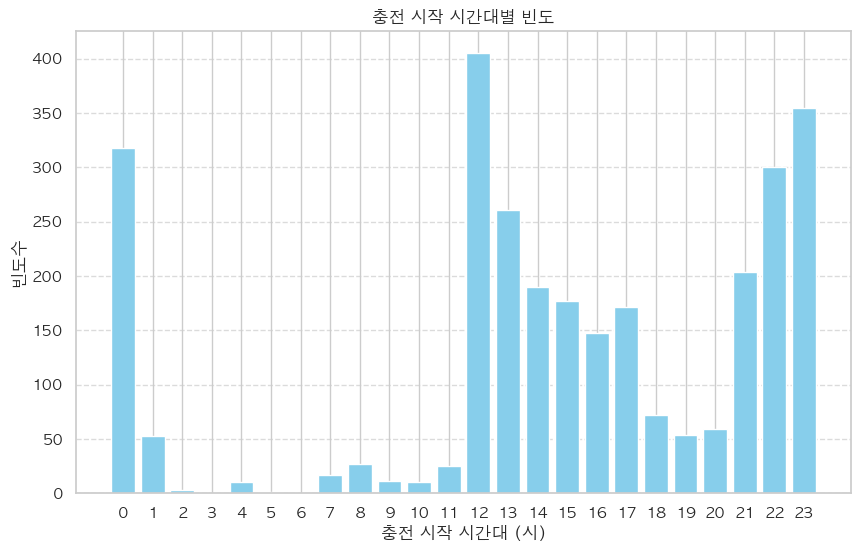

In [131]:
def pctd(g1):
    g1['충전시작시각'] = pd.to_datetime(g1['충전시작시각'])
    
    g1['시간대'] = g1['충전시작시각'].dt.hour
    
    time_d = g1['시간대'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(time_d.index, time_d.values, color='skyblue')
    plt.xlabel('충전 시작 시간대 (시)')
    plt.ylabel('빈도수')
    plt.title('충전 시작 시간대별 빈도')
    plt.xticks(range(0, 24)) 
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

pctd(g1)

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/1293460006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['충전시작시각'] = pd.to_datetime(g2['충전시작시각'])
/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/1293460006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['시간대'] = g2['충전시작시각'].dt.hour


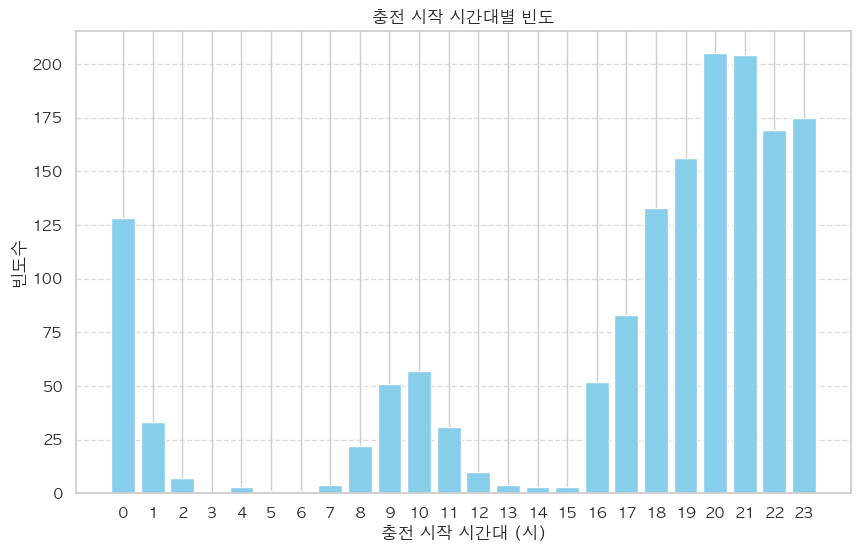

In [132]:
def pctd(g2):
    g2['충전시작시각'] = pd.to_datetime(g2['충전시작시각'])
    
    g2['시간대'] = g2['충전시작시각'].dt.hour
    
    time_d = g2['시간대'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(time_d.index, time_d.values, color='skyblue')
    plt.xlabel('충전 시작 시간대 (시)')
    plt.ylabel('빈도수')
    plt.title('충전 시작 시간대별 빈도')
    plt.xticks(range(0, 24)) 
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

pctd(g2)

In [153]:
print(g1.count())
print(g2.count())

차량번호           2870
충전시작시각         2870
충전종료시각         2870
충전시작 SOC(%)    2870
충전종료 SOC(%)    2870
충전 인터벌(시간)     2870
시간대            2870
soc량           2870
dtype: int64
차량번호           1535
충전시작시각         1535
충전종료시각         1535
충전시작 SOC(%)    1535
충전종료 SOC(%)    1535
충전 인터벌(시간)     1535
시간대            1535
soc량           1535
dtype: int64


In [143]:
g1['soc량'].mean()

43.24285714285714

In [184]:
g1['soc량'].value_counts().head(20)

soc량
81    140
79    115
78    115
80    109
82    104
83     77
77     70
84     67
20     65
28     65
25     63
18     63
29     62
11     62
30     60
10     60
27     59
24     59
19     59
15     59
Name: count, dtype: int64

In [144]:
g2['soc량'].mean()

38.744625407166126

In [185]:
g2['soc량'].value_counts().head(20)

soc량
10    56
5     56
79    54
80    52
8     51
77    50
78    49
9     49
11    49
81    44
13    42
6     41
12    41
7     41
14    40
16    39
76    38
4     35
22    33
17    32
Name: count, dtype: int64

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/2090418060.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['soc량'] = g1['충전종료 SOC(%)'] - g1['충전시작 SOC(%)']


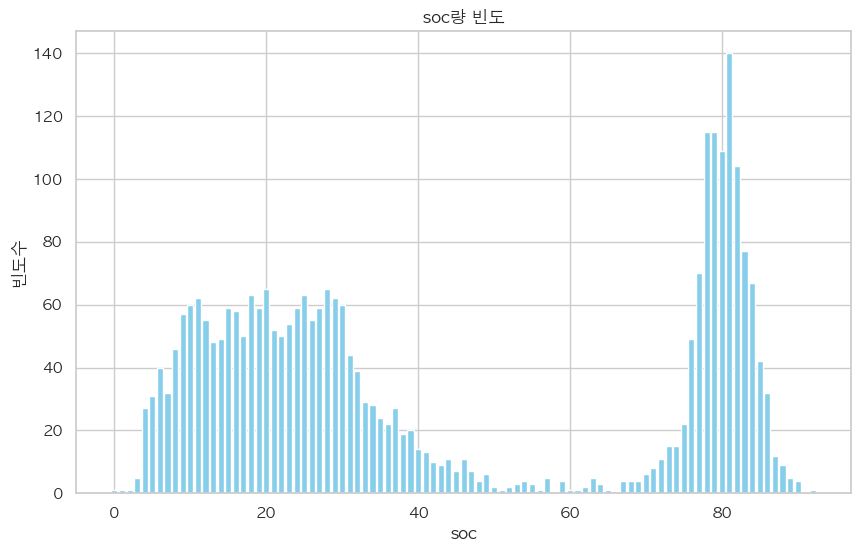

In [136]:
def pctd(g1):
    
    g1['soc량'] = g1['충전종료 SOC(%)'] - g1['충전시작 SOC(%)']
    soc = g1['soc량'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(soc.index, soc.values, color='skyblue')
    plt.xlabel('soc')
    plt.ylabel('빈도수')
    plt.title('soc량 빈도')
    plt.show()

pctd(g1)

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/1861471990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['soc량'] = g2['충전종료 SOC(%)'] - g2['충전시작 SOC(%)']


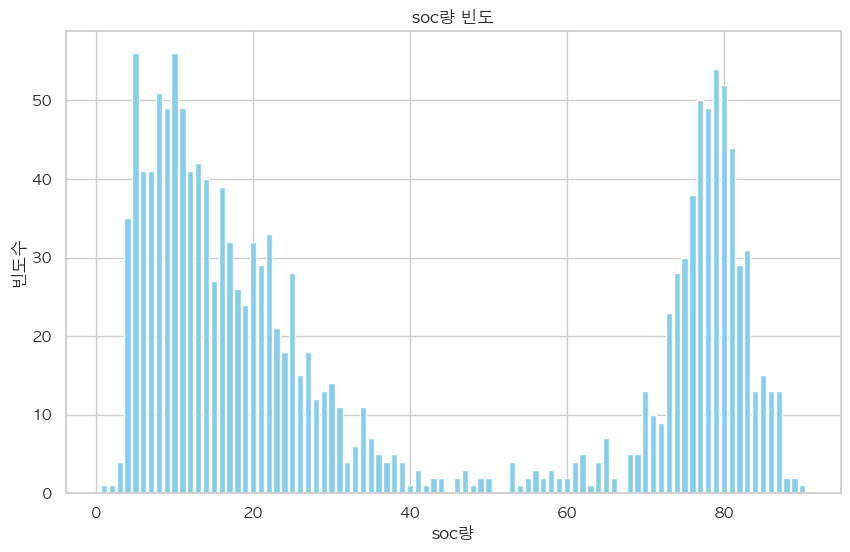

In [186]:
def pctd(g2):
    
    g2['soc량'] = g2['충전종료 SOC(%)'] - g2['충전시작 SOC(%)']
    soc = g2['soc량'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(soc.index, soc.values, color='skyblue')
    plt.xlabel('soc량')
    plt.ylabel('빈도수')
    plt.title('soc량 빈도')
    plt.show()

pctd(g2)

In [187]:
g2

차량번호              충전시작시각               충전종료시각  충전시작 SOC(%)  \
0     경기70바1254 2023-01-04 00:11:00  2023-01-04 02:11:29           19   
1     경기70바1254 2023-01-06 00:02:52  2023-01-06 01:58:01           22   
2     경기70바1254 2023-01-25 20:24:58  2023-01-25 20:44:51           26   
3     경기70바1254 2023-01-27 00:33:05  2023-01-27 02:24:47           24   
4     경기70바1254 2023-02-06 22:27:52  2023-02-07 00:29:07           18   
...         ...                 ...                  ...          ...   
1530  경기70바2409 2023-12-12 22:47:01  2023-12-13 00:44:43           20   
1531  경기70바2409 2023-12-17 21:54:59  2023-12-18 00:01:08           14   
1532  경기70바2409 2023-12-22 00:02:11  2023-12-22 02:13:40           11   
1533  경기70바2409 2023-12-24 23:45:41  2023-12-25 01:39:50           22   
1534  경기70바2409 2023-12-27 16:50:35  2023-12-27 17:24:40           32   

      충전종료 SOC(%)  충전 인터벌(시간)  시간대  soc량  
0              95    7.762500    0    76  
1              95    7.813333    0    73  
2              50    7.777778   20    24  
3              95    7.764722    0    71  
4              95    7.709167   22    77  
...           ...         ...  ...   ...  
1530           95    8.244167   22    75  
1531           95    7.863611   21    81  
1532           95    7.954722    0    84  
1533           95    7.595278   23    73  
1534           71    7.914722   16    39  

[1535 rows x 8 columns]

In [190]:
g1.to_csv('98_1.csv')
g2.to_csv('98_2.csv')

In [120]:
ech

차량번호               충전시작시각               충전종료시각  충전시작 SOC(%)  \
0     경기70바1942  2023-01-01 07:15:53  2023-01-01 07:39:41           55   
1     경기70바1942  2023-01-03 01:20:11  2023-01-03 02:49:04           16   
2     경기70바1942  2023-01-04 22:37:07  2023-01-05 00:05:27           16   
3     경기70바1942  2023-01-07 21:49:54  2023-01-07 22:36:38           16   
4     경기70바1942  2023-01-11 21:59:29  2023-01-11 23:26:36           17   
...         ...                  ...                  ...          ...   
1489  경기70바1943  2023-12-29 16:17:31  2023-12-29 16:43:32           51   
1490  경기70바1943  2023-12-29 20:22:15  2023-12-29 20:30:59           53   
1491  경기70바1943  2023-12-30 17:25:27  2023-12-30 17:52:58           48   
1492  경기70바1943  2023-12-30 21:20:58  2023-12-30 21:49:26           45   
1493  경기70바1943  2023-12-31 00:54:11  2023-12-31 02:14:39           19   

      충전종료 SOC(%)  충전 인터벌(시간)  
0              95    7.096667  
1              95    7.197222  
2              95    6.975000  
3              95    6.794167  
4              95    7.063056  
...           ...         ...  
1489           95    3.687222  
1490           61    3.645278  
1491           95    3.076667  
1492           71    3.466667  
1493           95    3.079167  

[1494 rows x 6 columns]

In [129]:
e1 = ech[ech['충전 인터벌(시간)'] < 4]
e1['충전 인터벌(시간)'].mean()

3.4042894524959744

In [162]:
e1

차량번호              충전시작시각               충전종료시각  충전시작 SOC(%)  \
528   경기70바1942 2023-01-01 14:27:30  2023-01-01 15:03:43           63   
529   경기70바1942 2023-01-02 13:31:14  2023-01-02 13:52:22           60   
530   경기70바1942 2023-01-04 11:24:38  2023-01-04 11:31:16           63   
531   경기70바1942 2023-01-04 14:54:50  2023-01-04 15:38:37           41   
532   경기70바1942 2023-01-06 18:08:38  2023-01-06 18:37:18           53   
...         ...                 ...                  ...          ...   
1489  경기70바1943 2023-12-29 16:17:31  2023-12-29 16:43:32           51   
1490  경기70바1943 2023-12-29 20:22:15  2023-12-29 20:30:59           53   
1491  경기70바1943 2023-12-30 17:25:27  2023-12-30 17:52:58           48   
1492  경기70바1943 2023-12-30 21:20:58  2023-12-30 21:49:26           45   
1493  경기70바1943 2023-12-31 00:54:11  2023-12-31 02:14:39           19   

      충전종료 SOC(%)  충전 인터벌(시간)  시간대  
528            95    3.397500   14  
529            95    3.046944   13  
530            74    3.682500   11  
531            95    3.392778   14  
532            79    3.506944   18  
...           ...         ...  ...  
1489           95    3.687222   16  
1490           61    3.645278   20  
1491           95    3.076667   17  
1492           71    3.466667   21  
1493           95    3.079167    0  

[966 rows x 7 columns]

In [130]:
e2 = ech[ech['충전 인터벌(시간)'] > 6]
e2['충전 인터벌(시간)'].mean()

7.199318707912457

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/1374888987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e1['충전시작시각'] = pd.to_datetime(e1['충전시작시각'])
/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/1374888987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e1['시간대'] = e1['충전시작시각'].dt.hour


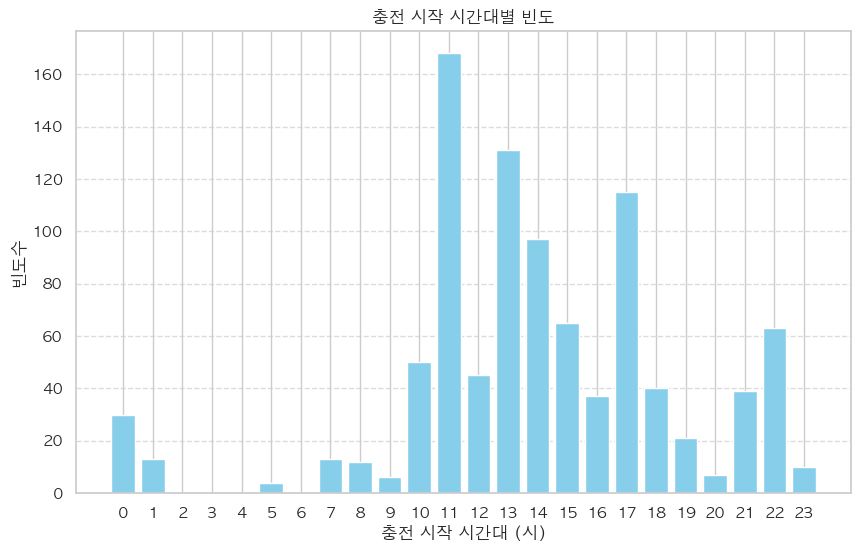

In [234]:
def pctd(e1):
    e1['충전시작시각'] = pd.to_datetime(e1['충전시작시각'])
    e1['시간대'] = e1['충전시작시각'].dt.hour
    
    time_distribution = e1['시간대'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(time_distribution.index, time_distribution.values, color='skyblue')
    plt.xlabel('충전 시작 시간대 (시)')
    plt.ylabel('빈도수')
    plt.title('충전 시작 시간대별 빈도')
    plt.xticks(range(0, 24))  
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

pctd(e1)


/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/2517170210.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e2['충전시작시각'] = pd.to_datetime(e2['충전시작시각'])
/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/2517170210.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e2['시간대'] = e2['충전시작시각'].dt.hour


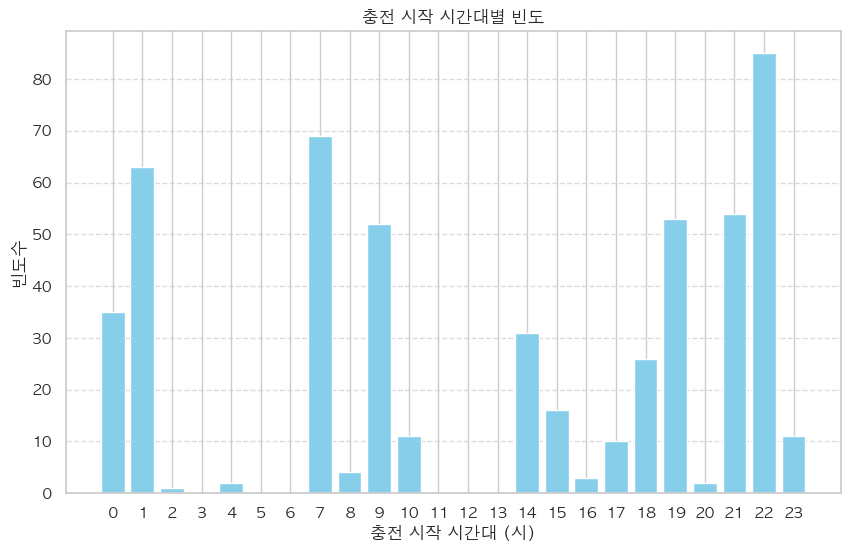

In [158]:
def pctd(e2):

    e2['충전시작시각'] = pd.to_datetime(e2['충전시작시각'])
    
    e2['시간대'] = e2['충전시작시각'].dt.hour

    time_distribution = e2['시간대'].value_counts().sort_index()
    

    plt.figure(figsize=(10, 6))
    plt.bar(time_distribution.index, time_distribution.values, color='skyblue')
    plt.xlabel('충전 시작 시간대 (시)')
    plt.ylabel('빈도수')
    plt.title('충전 시작 시간대별 빈도')
    plt.xticks(range(0, 24)) 
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

pctd(e2)


/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/3378608586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e1['soc량'] = e1['충전종료 SOC(%)'] - e1['충전시작 SOC(%)']


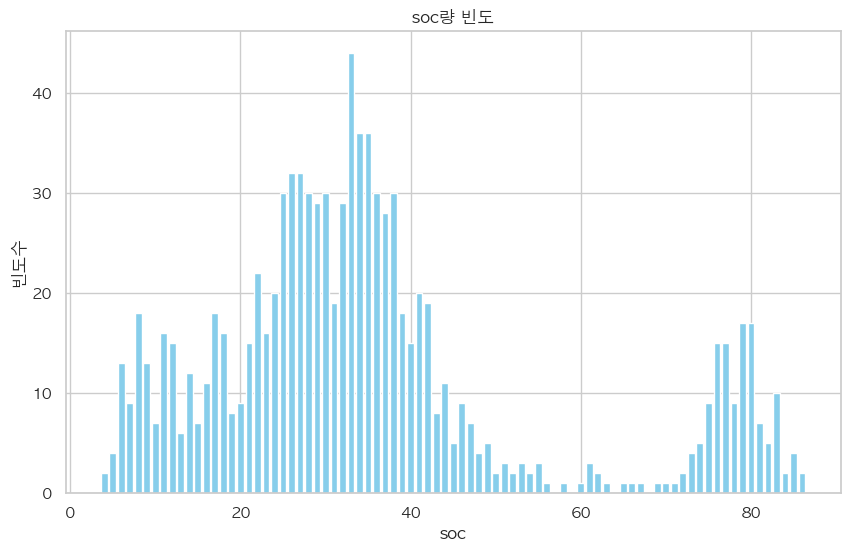

In [165]:
def pctd(g1):
    
    e1['soc량'] = e1['충전종료 SOC(%)'] - e1['충전시작 SOC(%)']
    soc = e1['soc량'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(soc.index, soc.values, color='skyblue')
    plt.xlabel('soc')
    plt.ylabel('빈도수')
    plt.title('soc량 빈도')
    plt.show()

pctd(e1)

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_33138/1947360361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e2['soc량'] = e2['충전종료 SOC(%)'] - e2['충전시작 SOC(%)']


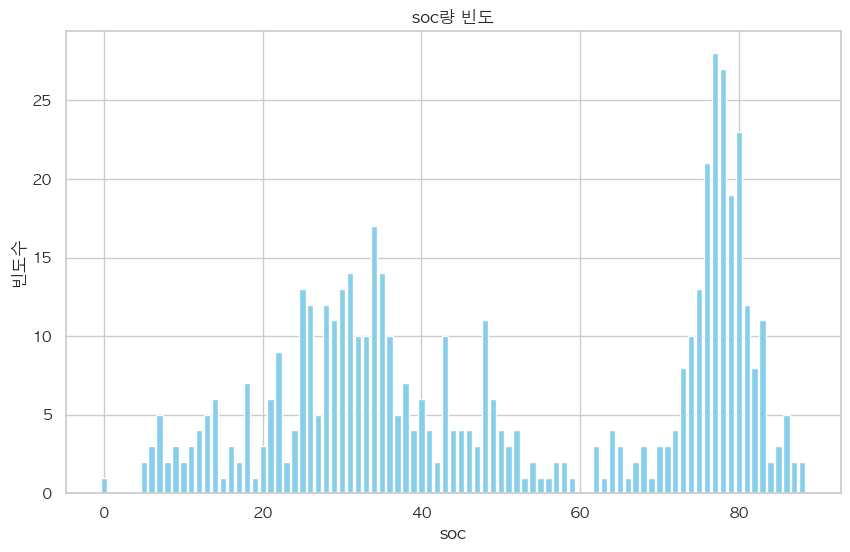

In [166]:
def pctd(g1):
    
    e2['soc량'] = e2['충전종료 SOC(%)'] - e2['충전시작 SOC(%)']
    soc = e2['soc량'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(soc.index, soc.values, color='skyblue')
    plt.xlabel('soc')
    plt.ylabel('빈도수')
    plt.title('soc량 빈도')
    plt.show()

pctd(e2)

In [155]:
print(e1.count())
print(e2.count())

차량번호           966
충전시작시각         966
충전종료시각         966
충전시작 SOC(%)    966
충전종료 SOC(%)    966
충전 인터벌(시간)     966
dtype: int64
차량번호           528
충전시작시각         528
충전종료시각         528
충전시작 SOC(%)    528
충전종료 SOC(%)    528
충전 인터벌(시간)     528
dtype: int64


In [163]:
e1['시간대'].value_counts()

시간대
11    168
13    131
17    115
14     97
15     65
22     63
10     50
12     45
18     40
21     39
16     37
0      30
19     21
7      13
1      13
8      12
23     10
20      7
9       6
5       4
Name: count, dtype: int64

In [246]:
z = e1[e1['시간대'].isin([11,12,13,14])]
z

차량번호              충전시작시각               충전종료시각  충전시작 SOC(%)  \
528   경기70바1942 2023-01-01 14:27:30  2023-01-01 15:03:43           63   
529   경기70바1942 2023-01-02 13:31:14  2023-01-02 13:52:22           60   
530   경기70바1942 2023-01-04 11:24:38  2023-01-04 11:31:16           63   
531   경기70바1942 2023-01-04 14:54:50  2023-01-04 15:38:37           41   
534   경기70바1942 2023-01-07 14:46:03  2023-01-07 15:02:15           63   
...         ...                 ...                  ...          ...   
1475  경기70바1943 2023-12-21 11:49:26  2023-12-21 12:20:02           41   
1478  경기70바1943 2023-12-25 11:27:50  2023-12-25 12:19:38           46   
1481  경기70바1943 2023-12-26 13:39:34  2023-12-26 14:03:26           53   
1484  경기70바1943 2023-12-27 13:05:01  2023-12-27 13:27:51           56   
1487  경기70바1943 2023-12-28 11:14:16  2023-12-28 12:01:28           42   

      충전종료 SOC(%)  충전 인터벌(시간)  시간대  soc량  
528            95    3.397500   14    32  
529            95    3.046944   13    35  
530            74    3.682500   11    11  
531            95    3.392778   14    54  
534            91    3.522500   14    28  
...           ...         ...  ...   ...  
1475           95    3.553611   11    54  
1478           95    3.066667   11    49  
1481           95    3.125000   13    42  
1484           95    3.643889   13    39  
1487           84    3.398056   11    42  

[441 rows x 8 columns]

In [247]:
z['soc량'].mean()

32.26077097505669

In [164]:
e2['시간대'].value_counts()

시간대
22    85
7     69
1     63
21    54
19    53
9     52
0     35
14    31
18    26
15    16
23    11
10    11
17    10
8      4
16     3
20     2
4      2
2      1
Name: count, dtype: int64

In [248]:
x = e1[e1['시간대'].isin([22,21,1,0,23])]
x

차량번호              충전시작시각               충전종료시각  충전시작 SOC(%)  \
533   경기70바1942 2023-01-06 21:41:06  2023-01-06 21:49:23           44   
547   경기70바1942 2023-01-18 00:45:08  2023-01-18 02:10:31           19   
553   경기70바1942 2023-01-21 21:11:51  2023-01-21 21:19:08           53   
556   경기70바1942 2023-01-24 22:18:52  2023-01-24 23:52:01           12   
564   경기70바1942 2023-01-26 22:35:44  2023-01-26 23:57:48           22   
...         ...                 ...                  ...          ...   
1483  경기70바1943 2023-12-26 21:35:08  2023-12-26 22:25:16           48   
1485  경기70바1943 2023-12-27 21:25:23  2023-12-27 21:37:51           54   
1486  경기70바1943 2023-12-28 01:01:54  2023-12-28 02:36:46           20   
1492  경기70바1943 2023-12-30 21:20:58  2023-12-30 21:49:26           45   
1493  경기70바1943 2023-12-31 00:54:11  2023-12-31 02:14:39           19   

      충전종료 SOC(%)  충전 인터벌(시간)  시간대  soc량  
533            52    3.063333   21     8  
547            95    3.237222    0    76  
553            60    3.619722   21     7  
556            95    3.745556   22    83  
564            95    3.557778   22    73  
...           ...         ...  ...   ...  
1483           95    3.352500   21    47  
1485           65    3.747500   21    11  
1486           95    3.400833    1    75  
1492           71    3.466667   21    26  
1493           95    3.079167    0    76  

[155 rows x 8 columns]

In [249]:
x['soc량'].mean()

67.2258064516129

In [171]:
e1['soc량'].mean()

35.45962732919255

In [172]:
e2['soc량'].mean()

50.62310606060606

In [169]:
e1['soc량'].value_counts().head(10)

soc량
33    44
35    36
34    36
26    32
27    32
25    30
30    30
28    30
38    30
36    30
Name: count, dtype: int64

In [170]:
e2['soc량'].value_counts().head(10)

soc량
77    28
78    27
80    23
76    21
79    19
34    17
35    14
31    14
30    13
25    13
Name: count, dtype: int64

In [189]:
e1.to_csv('27_.csv')
e2.to_csv('27_2.csv')

---------------------

In [65]:
mg

차량번호       충전일자    주행거리  운행횟수
0      경기70바1254 2023-01-01    0.00   0.0
1      경기70바1254 2023-01-02    0.00   0.0
2      경기70바1254 2023-01-03  203.80   4.0
3      경기70바1254 2023-01-04  203.80   4.0
4      경기70바1254 2023-01-05  254.75   5.0
...          ...        ...     ...   ...
29925  경기70바2409 2023-12-27  254.55   5.0
29926  경기70바2409 2023-12-28  254.55   5.0
29927  경기70바2409 2023-12-29  254.55   5.0
29928  경기70바2409 2023-12-30    0.00   0.0
29929  경기70바2409 2023-12-31    0.00   0.0

[29930 rows x 4 columns]

In [68]:
df = df.merge(mg, on=['차량번호','충전일자'])
df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
1      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
2      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
3      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
4      경기70바1254  98     33         A      33_A 2023-01-04 15:42:40   
...          ...  ..    ...       ...       ...                 ...   
74785  경기70바1969  30      9         A       9_A 2023-12-27 11:34:54   
74786  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
74787  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
74788  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
74789  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  \
0     2023-01-03 12:30:34       87.28      8510           60  ...   
1     2023-01-03 16:25:15       28.24      4643           69  ...   
2     2023-01-04 02:11:29      183.32     15986           19  ...   
3     2023-01-04 12:12:15       72.00      9262           58  ...   
4     2023-01-04 16:01:06       56.08      5692           59  ...   
...                   ...         ...       ...          ...  ...   
74785 2023-12-27 11:56:24       18.76         0           63  ...   
74786 2023-12-29 07:35:58       44.16         0           62  ...   
74787 2023-12-29 10:38:28       64.56         0           57  ...   
74788 2023-12-29 16:40:36       21.08         0           63  ...   
74789 2023-12-30 00:07:47      120.56         0           20  ...   

       SOC종료-시작_수정       충전일자   월  요일 주중/주말  왕복운행거리  인가거리    충전소요시간_분    주행거리  \
0               35 2023-01-03   1   화    주중   50.90  50.9   29.966667  203.80   
1               12 2023-01-03   1   화    주중   50.90  50.9   12.916667  203.80   
2               76 2023-01-04   1   수    주중   50.90  50.9  120.483333  203.80   
3               29 2023-01-04   1   수    주중   50.90  50.9   23.183333  203.80   
4               22 2023-01-04   1   수    주중   50.90  50.9   18.433333  203.80   
...            ...        ...  ..  ..   ...     ...   ...         ...     ...   
74785           32 2023-12-27  12   수    주중   43.63  43.6   21.500000    0.00   
74786           26 2023-12-29  12   금    주중   43.63  43.6   15.100000  261.78   
74787           38 2023-12-29  12   금    주중   43.63  43.6   22.733333  261.78   
74788           24 2023-12-29  12   금    주중   43.63  43.6   14.266667  261.78   
74789           75 2023-12-29  12   금    주중   43.63  43.6   82.116667  261.78   

       운행횟수  
0       4.0  
1       4.0  
2       4.0  
3       4.0  
4       4.0  
...     ...  
74785   0.0  
74786   6.0  
74787   6.0  
74788   6.0  
74789   6.0  

[74790 rows x 23 columns]

In [69]:
df.to_excel('노선특성데이터.xlsx')

----------------

In [13]:
df = pd.read_excel('노선특성데이터.xlsx')
df

Unnamed: 0       차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구  \
0               0  경기70바1254  98      8         A       8_A   
1               1  경기70바1254  98     41         B      41_B   
2               2  경기70바1254  98     45         B      45_B   
3               3  경기70바1254  98     21         A      21_A   
4               4  경기70바1254  98     33         A      33_A   
...           ...        ...  ..    ...       ...       ...   
74785       74785  경기70바1969  30      9         A       9_A   
74786       74786  경기70바1969  30     14         A      14_A   
74787       74787  경기70바1969  30     14         A      14_A   
74788       74788  경기70바1969  30      6         B       6_B   
74789       74789  경기70바1969  30      2         B       2_B   

                   충전시작시각              충전종료시각  충전전력량(kWh)  충전 요금(원)  ...  \
0     2023-01-03 12:00:36 2023-01-03 12:30:34       87.28      8510  ...   
1     2023-01-03 16:12:20 2023-01-03 16:25:15       28.24      4643  ...   
2     2023-01-04 00:11:00 2023-01-04 02:11:29      183.32     15986  ...   
3     2023-01-04 11:49:04 2023-01-04 12:12:15       72.00      9262  ...   
4     2023-01-04 15:42:40 2023-01-04 16:01:06       56.08      5692  ...   
...                   ...                 ...         ...       ...  ...   
74785 2023-12-27 11:34:54 2023-12-27 11:56:24       18.76         0  ...   
74786 2023-12-29 07:20:52 2023-12-29 07:35:58       44.16         0  ...   
74787 2023-12-29 10:15:44 2023-12-29 10:38:28       64.56         0  ...   
74788 2023-12-29 16:26:20 2023-12-29 16:40:36       21.08         0  ...   
74789 2023-12-29 22:45:40 2023-12-30 00:07:47      120.56         0  ...   

       SOC종료-시작_수정       충전일자   월  요일  주중/주말 왕복운행거리  인가거리    충전소요시간_분    주행거리  \
0               35 2023-01-03   1   화     주중  50.90  50.9   29.966667  203.80   
1               12 2023-01-03   1   화     주중  50.90  50.9   12.916667  203.80   
2               76 2023-01-04   1   수     주중  50.90  50.9  120.483333  203.80   
3               29 2023-01-04   1   수     주중  50.90  50.9   23.183333  203.80   
4               22 2023-01-04   1   수     주중  50.90  50.9   18.433333  203.80   
...            ...        ...  ..  ..    ...    ...   ...         ...     ...   
74785           32 2023-12-27  12   수     주중  43.63  43.6   21.500000    0.00   
74786           26 2023-12-29  12   금     주중  43.63  43.6   15.100000  261.78   
74787           38 2023-12-29  12   금     주중  43.63  43.6   22.733333  261.78   
74788           24 2023-12-29  12   금     주중  43.63  43.6   14.266667  261.78   
74789           75 2023-12-29  12   금     주중  43.63  43.6   82.116667  261.78   

       운행횟수  
0       4.0  
1       4.0  
2       4.0  
3       4.0  
4       4.0  
...     ...  
74785   0.0  
74786   6.0  
74787   6.0  
74788   6.0  
74789   6.0  

[74790 rows x 24 columns]

In [14]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [154]:
df_test = df.copy()

df_test['충전시작시각'] = pd.to_datetime(df_test['충전시작시각'])
df_test['충전종료시각'] = pd.to_datetime(df_test['충전종료시각'])

df_test['충전시작일자'] = df_test['충전시작시각'].dt.date
df_test['충전종료일자'] = df_test['충전종료시각'].dt.date

df_test['충전일자'] = df_test.apply(lambda row: pd.date_range(row['충전시작일자'], row['충전종료일자'], freq='D'), axis=1)

df_test = df_test.explode('충전일자')

df_test['충전일자'] = pd.to_datetime(df_test['충전일자'])
charge_freq = df_test.groupby(['차량번호', '충전일자']).size().reset_index(name='충전빈도')

low_freq_days = charge_freq[charge_freq['충전빈도'] <= 2.5]

filtered_df = df_test.merge(low_freq_days[['차량번호', '충전일자']], on=['차량번호', '충전일자'], how='left', indicator=True)
filtered_df = filtered_df[filtered_df['_merge'] == 'left_only'].drop('_merge', axis=1)

filtered_df = filtered_df.sort_values(by=['차량번호', '충전일자', '충전시작시각'])

bgmm_df = filtered_df[['차량번호', '노선명', '충전 인터벌(시간)', '충전일자']]

bgmm_df

차량번호 노선명  충전 인터벌(시간)       충전일자
3      경기70바1254  98    7.762500 2023-01-04
4      경기70바1254  98    9.626389 2023-01-04
5      경기70바1254  98    3.506944 2023-01-04
6      경기70바1254  98    4.047222 2023-01-04
7      경기70바1254  98    3.682778 2023-01-04
...          ...  ..         ...        ...
14967  경기70바2409  98    3.531111 2023-12-27
14968  경기70바2409  98    3.226111 2023-12-28
14969  경기70바2409  98    6.598611 2023-12-28
14970  경기70바2409  98    3.398611 2023-12-28
14971  경기70바2409  98    3.618611 2023-12-28

[76552 rows x 4 columns]

In [160]:
df_test2 = df.copy()

df_test2['충전일자'] = df_test2['충전시작시각'].dt.date

charge_freq = df_test2.groupby(['차량번호', '충전일자']).size().reset_index(name='충전빈도')

low_freq_days = charge_freq[charge_freq['충전빈도'] <= 2.5]

filtered_df = df_test2.merge(low_freq_days[['차량번호', '충전일자']], on=['차량번호', '충전일자'], how='left', indicator=True)
filtered_df = filtered_df[filtered_df['_merge'] == 'left_only'].drop('_merge', axis=1)

filtered_df = filtered_df.sort_values(by=['차량번호', '충전일자', '충전시작시각'])

bgmm_df = filtered_df[['차량번호', '노선명', '충전 인터벌(시간)', '충전일자']]

bgmm_df

차량번호 노선명  충전 인터벌(시간)        충전일자
3      경기70바1254  98    7.762500  2023-01-04
4      경기70바1254  98    9.626389  2023-01-04
5      경기70바1254  98    3.506944  2023-01-04
6      경기70바1254  98    4.047222  2023-01-04
7      경기70바1254  98    3.682778  2023-01-04
...          ...  ..         ...         ...
13106  경기70바2409  98    3.531111  2023-12-27
13107  경기70바2409  98    3.226111  2023-12-28
13108  경기70바2409  98    6.598611  2023-12-28
13109  경기70바2409  98    3.398611  2023-12-28
13110  경기70바2409  98    3.618611  2023-12-28

[70724 rows x 4 columns]

/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_23991/1348009215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgmm_df['충전 인터벌(시간)'] = pd.to_numeric(bgmm_df['충전 인터벌(시간)'], errors='coerce')
/opt/anaconda3/envs/da/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


추정된 군집 개수: 10
BIC 점수: 108657.85551511658


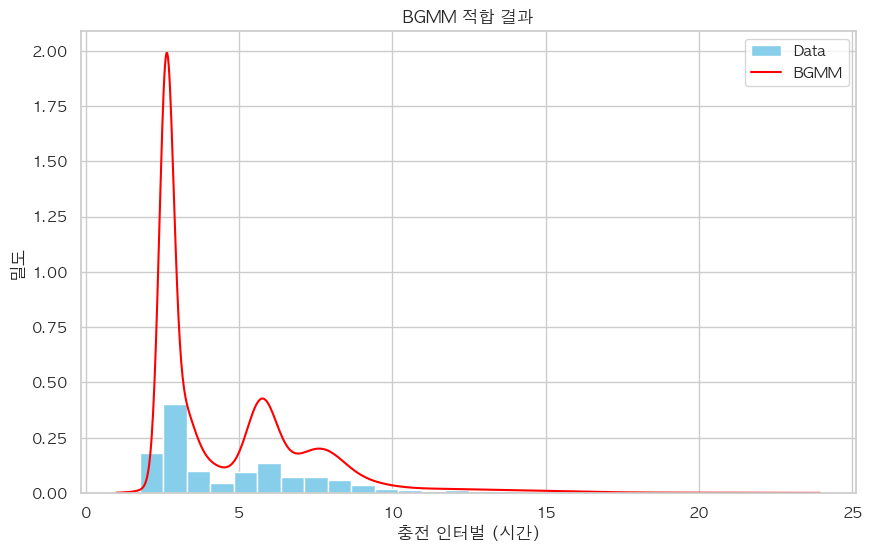

In [161]:
bgmm_df['충전 인터벌(시간)'] = pd.to_numeric(bgmm_df['충전 인터벌(시간)'], errors='coerce')
bgmm_df = bgmm_df.dropna(subset=['충전 인터벌(시간)'])

charge_intervals = bgmm_df['충전 인터벌(시간)'].values.reshape(-1, 1)

scaler = StandardScaler()
charge_intervals_scaled = scaler.fit_transform(charge_intervals)

bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42, weight_concentration_prior_type='dirichlet_process')
bgmm.fit(charge_intervals_scaled)

n_clusters = len(np.unique(bgmm.predict(charge_intervals_scaled)))
print(f'추정된 군집 개수: {n_clusters}')

log_llh = bgmm.score_samples(charge_intervals_scaled).sum()

n_features = charge_intervals_scaled.shape[1]
n_com = len(bgmm.weights_)
n_par = (n_com - 1) + n_com * (n_features + (n_features * (n_features + 1) / 2))  # weights + means + covariances

bic_score = -2 * log_llh + n_par * np.log(len(charge_intervals_scaled))
print(f'BIC 점수: {bic_score}')

x = np.linspace(min(charge_intervals_scaled), max(charge_intervals_scaled), 1000).reshape(-1, 1)
logprob = bgmm.score_samples(x)
pdf = np.exp(logprob)

x_original = scaler.inverse_transform(x)

plt.figure(figsize=(10, 6))
plt.hist(df['충전 인터벌(시간)'], bins=30, density=True, color='skyblue', label='Data')
plt.plot(x_original, pdf, label='BGMM', color='red')
plt.title(f'BGMM 적합 결과')
plt.xlabel('충전 인터벌 (시간)')
plt.ylabel('밀도')
plt.legend()
plt.show()

In [ ]:
bgmm_df['충전 인터벌(시간)'] = pd.to_numeric(df['충전 인터벌(시간)'], errors='coerce')
bgmm_df = bgmm_df.dropna(subset=['충전 인터벌(시간)'])

routes = bgmm_df['노선명'].unique()

for route in routes:
    route_df = bgmm_df[bgmm_df['노선명'] == route]
    charge_intervals = route_df['충전 인터벌(시간)'].values.reshape(-1, 1)

    scaler = StandardScaler()
    charge_intervals_scaled = scaler.fit_transform(charge_intervals)

    bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42, weight_concentration_prior_type='dirichlet_process')
    bgmm.fit(charge_intervals_scaled)

    n_clusters = len(np.unique(bgmm.predict(charge_intervals_scaled)))
    print(f'노선 {route}의 추정된 군집 개수: {n_clusters}')

    log_llh = bgmm.score_samples(charge_intervals_scaled).sum()
    n_features = charge_intervals_scaled.shape[1]
    n_com = len(bgmm.weights_)
    n_par = (n_com - 1) + n_com * (n_features + (n_features * (n_features + 1) / 2))  
    bic_score = -2 * log_llh + n_par * np.log(len(charge_intervals_scaled))
    print(f'노선 {route}의 BIC 점수: {bic_score}')

    x = np.linspace(min(charge_intervals_scaled), max(charge_intervals_scaled), 1000).reshape(-1, 1)
    logprob = bgmm.score_samples(x)
    pdf = np.exp(logprob)

    x_original = scaler.inverse_transform(x)

    plt.figure(figsize=(10, 6))
    plt.hist(route_df['충전 인터벌(시간)'], bins=30, density=True, color='skyblue', label='Data')
    plt.plot(x_original, pdf, label='BGMM', color='red')
    plt.title(f'노선 {route}의 BGMM 적합 결과')
    plt.xlabel('충전 인터벌 (시간)')
    plt.ylabel('밀도')
    plt.legend()
    plt.show()


------------------

#### 로그노말분포

In [3]:
df = pd.read_excel('/Users/yurim/Downloads/유리미/최종_전기버스충전데이터.xlsx')
df.drop(['Unnamed: 0','index'], axis=1, inplace=True)
df = df[df['노선명'] != '37']
df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
0      경기70바1254  98      1         A       1_A 2023-01-02 18:19:28   
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
...          ...  ..    ...       ...       ...                 ...   
80843  경기70바1969  30     10         A      10_A 2023-12-28 16:59:21   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  충전종료 SOC(%)  \
0     2023-01-02 18:33:29       16.16      2657           88           95   
1     2023-01-03 12:30:34       87.28      8510           60           95   
2     2023-01-03 16:25:15       28.24      4643           69           81   
3     2023-01-04 02:11:29      183.32     15986           19           95   
4     2023-01-04 12:12:15       72.00      9262           58           87   
...                   ...         ...       ...          ...          ...   
80843 2023-12-28 17:07:45       13.24         0           87           95   
80844 2023-12-29 07:35:58       44.16         0           62           88   
80845 2023-12-29 10:38:28       64.56         0           57           95   
80846 2023-12-29 16:40:36       21.08         0           63           87   
80847 2023-12-30 00:07:47      120.56         0           20           95   

       충전 인터벌(시간) 충전소요시간_수정  SOC종료-시작_수정       충전일자   월 요일 주중/주말  왕복운행거리  인가거리  
0             NaN  00:14:01            7 2023-01-02   1  월    주중   50.90  50.9  
1       17.451944  00:29:58           35 2023-01-03   1  화    주중   50.90  50.9  
2        3.696111  00:12:55           12 2023-01-03   1  화    주중   50.90  50.9  
3        7.762500  02:00:29           76 2023-01-04   1  수    주중   50.90  50.9  
4        9.626389  00:23:11           29 2023-01-04   1  수    주중   50.90  50.9  
...           ...       ...          ...        ...  .. ..   ...     ...   ...  
80843         NaN  00:08:24            8 2023-12-28  12  목    주중   43.63  43.6  
80844   14.218611  00:15:06           26 2023-12-29  12  금    주중   43.63  43.6  
80845    2.662778  00:22:44           38 2023-12-29  12  금    주중   43.63  43.6  
80846    5.797778  00:14:16           24 2023-12-29  12  금    주중   43.63  43.6  
80847    6.084444  01:22:07           75 2023-12-29  12  금    주중   43.63  43.6  

[78928 rows x 20 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78928 entries, 0 to 80847
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   차량번호         78928 non-null  object        
 1   노선명          78928 non-null  object        
 2   충전기ID        78928 non-null  int64         
 3   OUTLET ID    78928 non-null  object        
 4   충전기ID_충전구    78928 non-null  object        
 5   충전시작시각       78928 non-null  datetime64[ns]
 6   충전종료시각       78928 non-null  datetime64[ns]
 7   충전전력량(kWh)   78928 non-null  float64       
 8   충전 요금(원)     78928 non-null  int64         
 9   충전시작 SOC(%)  78928 non-null  int64         
 10  충전종료 SOC(%)  78928 non-null  int64         
 11  충전 인터벌(시간)   74790 non-null  float64       
 12  충전소요시간_수정    78928 non-null  object        
 13  SOC종료-시작_수정  78928 non-null  int64         
 14  충전일자         78928 non-null  datetime64[ns]
 15  월            78928 non-null  int64         
 16  요일       

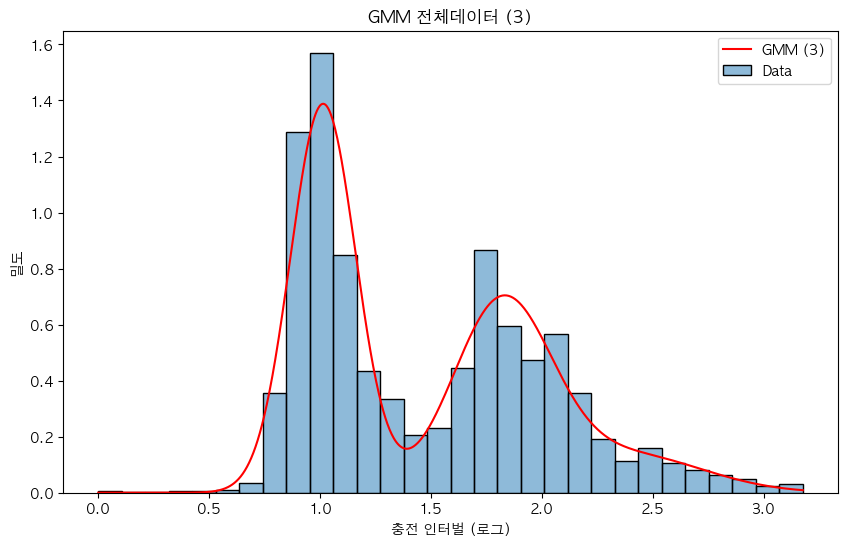

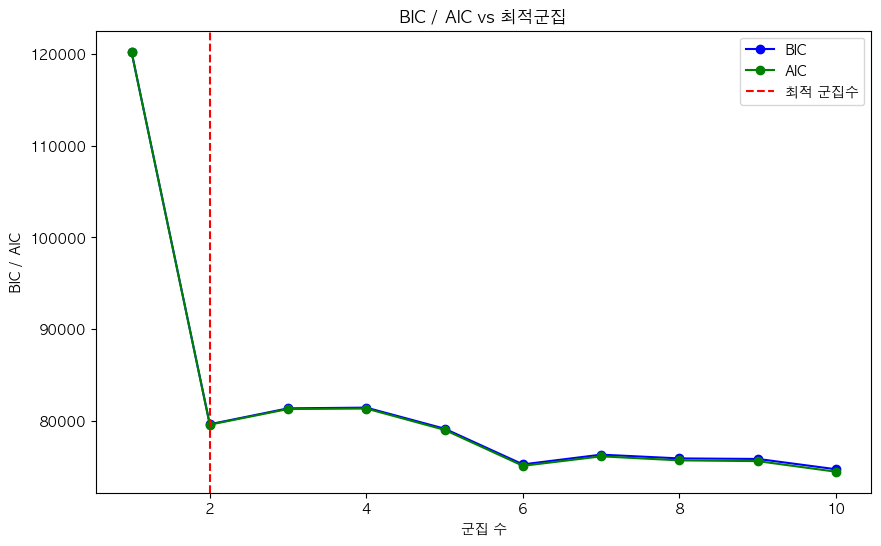

In [32]:
gmm_df = df.copy()

gmm_df['충전 인터벌(시간)'] = pd.to_numeric(gmm_df['충전 인터벌(시간)'], errors='coerce')
gmm_df = gmm_df.dropna(subset=['노선명', '충전 인터벌(시간)'])
gmm_df['충전 인터벌(시간)'] = np.log(gmm_df['충전 인터벌(시간)'])

data = gmm_df['충전 인터벌(시간)'].values.reshape(-1, 1)

ncr = range(1, 11)
bics = []
aics = []
models = []

for nc in ncr:
    gmm = GaussianMixture(n_components=nc, random_state=42)
    gmm.fit(data)
    bics.append(gmm.bic(data))
    aics.append(gmm.aic(data))
    models.append(gmm)

bic_diffs = np.diff(bics)

onc = np.argmax(bic_diffs) + 1

best = models[onc]

x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
logprob = best.score_samples(x)
pdf = np.exp(logprob)

plt.figure(figsize=(10, 6))
sns.histplot(data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
plt.plot(x, pdf, label=f'GMM ({onc + 1})', color='red')
plt.title(f'GMM 전체데이터 ({onc + 1})')
plt.xlabel('충전 인터벌 (로그)')
plt.ylabel('밀도')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ncr, bics, label='BIC', marker='o', color='blue')
plt.plot(ncr, aics, label='AIC', marker='o', color='green')
plt.axvline(x=onc, color='red', linestyle='--', label='최적 군집수')
plt.xlabel('군집 수')
plt.ylabel('BIC / AIC')
plt.title('BIC / AIC vs 최적군집')
plt.legend()
plt.show()

In [97]:
from matplotlib.backends.backend_pdf import PdfPages
gmm_df = df.copy()

gmm_df['충전 인터벌(시간)'] = pd.to_numeric(gmm_df['충전 인터벌(시간)'], errors='coerce')
gmm_df = gmm_df.dropna(subset=['노선명', '충전 인터벌(시간)'])
gmm_df['충전 인터벌(시간)'] = np.log(gmm_df['충전 인터벌(시간)'])

routes = gmm_df['노선명'].unique()

def fit_gmm_bic(route_name, gmm_df, pdf_writer, rth=0.05):
    route_data = gmm_df[gmm_df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    ncr = range(1, 11)
    bics = []
    aics = []
    models = []
    
    for nc in ncr:
        gmm = GaussianMixture(n_components=nc, random_state=42)
        gmm.fit(route_data)
        bics.append(gmm.bic(route_data))
        aics.append(gmm.aic(route_data))
        models.append(gmm)
    
    bic_rr = np.diff(bics) / np.array(bics[:-1])
    onc = np.argmax(bic_rr > -rth)
    best = models[onc]
    
    x = np.linspace(min(route_data), max(route_data), 1000).reshape(-1, 1)
    logprob = best.score_samples(x)
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(route_data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
    plt.plot(x, pdf, label=f'GMM ({onc+1})', color='red')
    plt.title(f'노선별 GMM : {route_name} ({onc+1})')
    plt.xlabel('충전 인터벌 (로그)')
    plt.ylabel('밀도')
    plt.legend()
    pdf_writer.savefig()
    #plt.show()
    plt.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ncr, bics, label='BIC', marker='o', color='blue')
    plt.plot(ncr, aics, label='AIC', marker='o', color='green')
    plt.axvline(x=onc+1, color='red', linestyle='--', label='최적 군집수')
    plt.xlabel('군집 수')
    plt.ylabel('BIC/AIC')
    plt.title(f'BIC/AIC 노선 : {route_name}')
    plt.legend()
    pdf_writer.savefig()
    plt.close()
    #plt.show()

with PdfPages('logGMM.pdf') as pdf_writer:    
    for route in routes:
        fit_gmm_bic(route, gmm_df, pdf_writer, rth=0.05)

print('save')


save


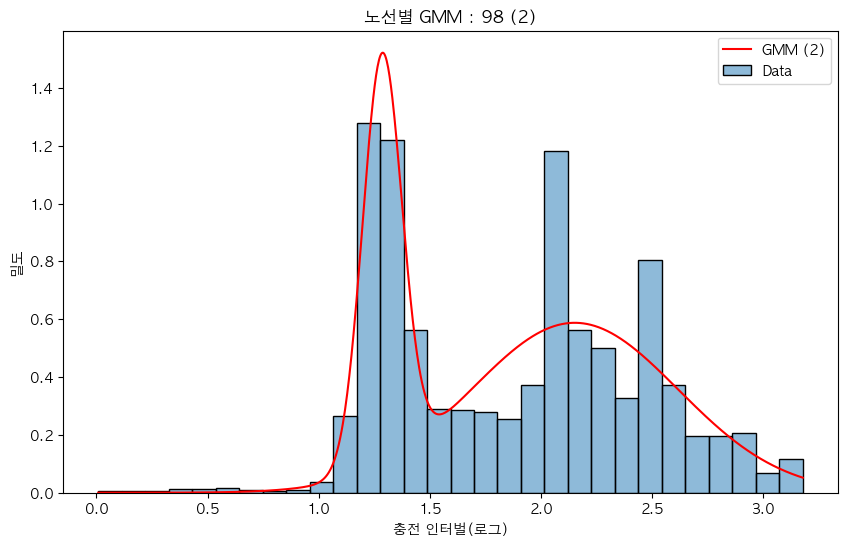

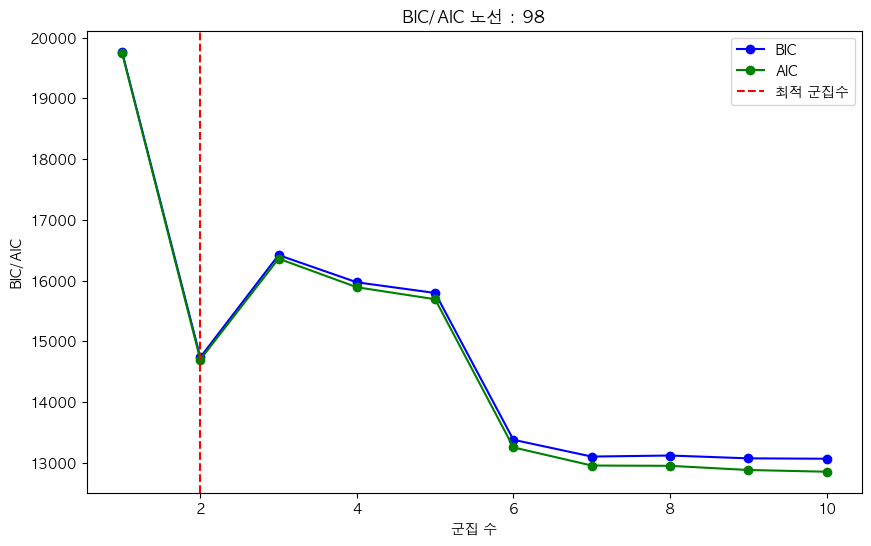

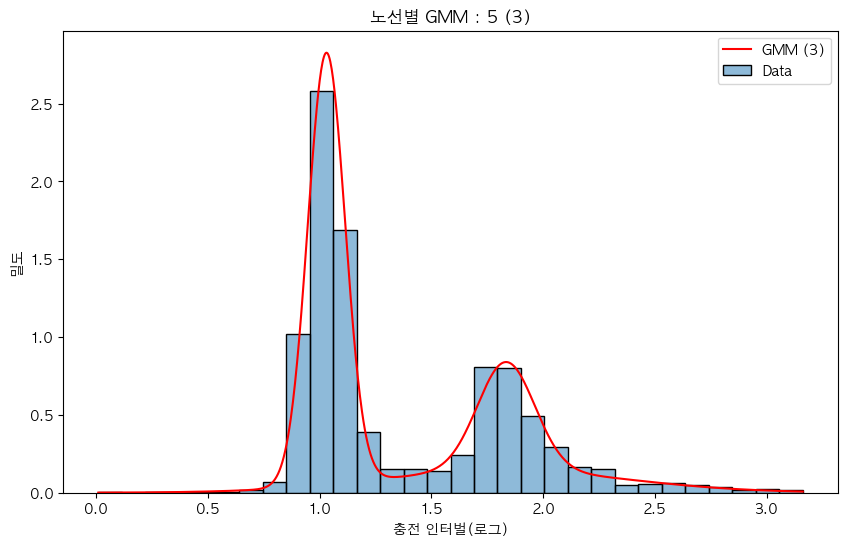

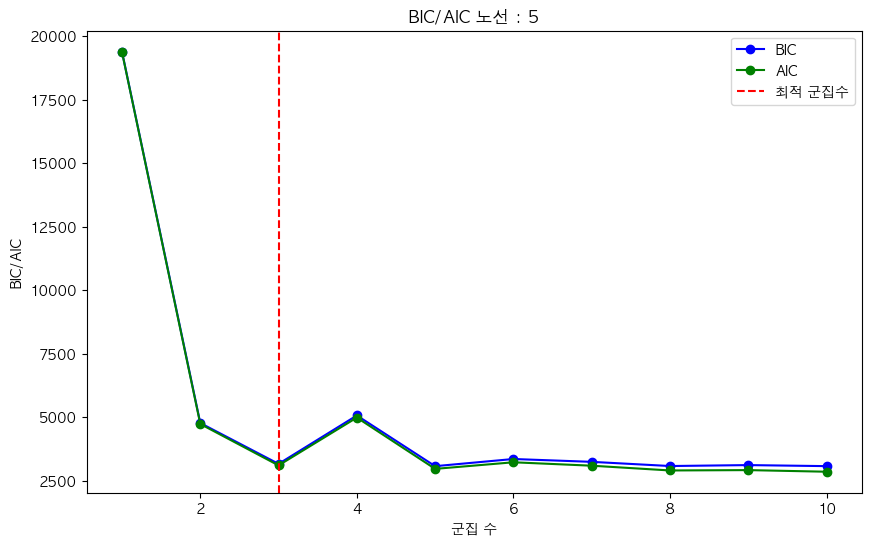

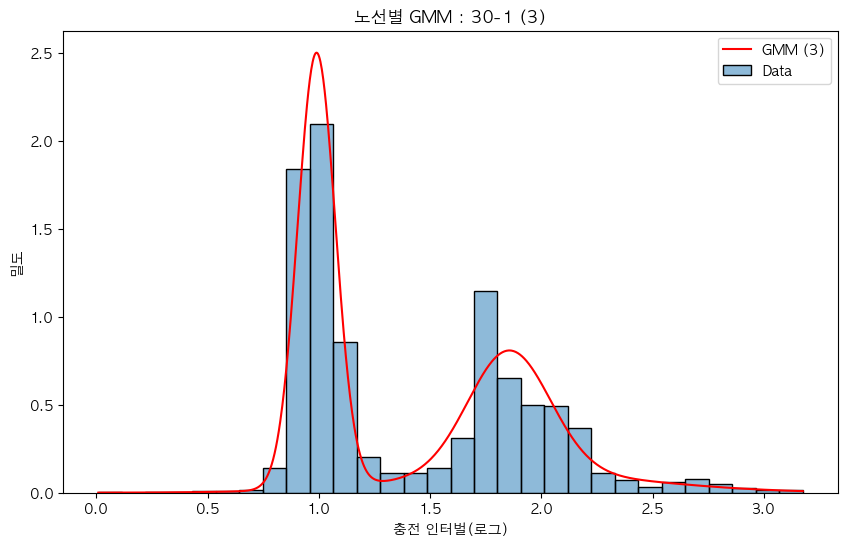

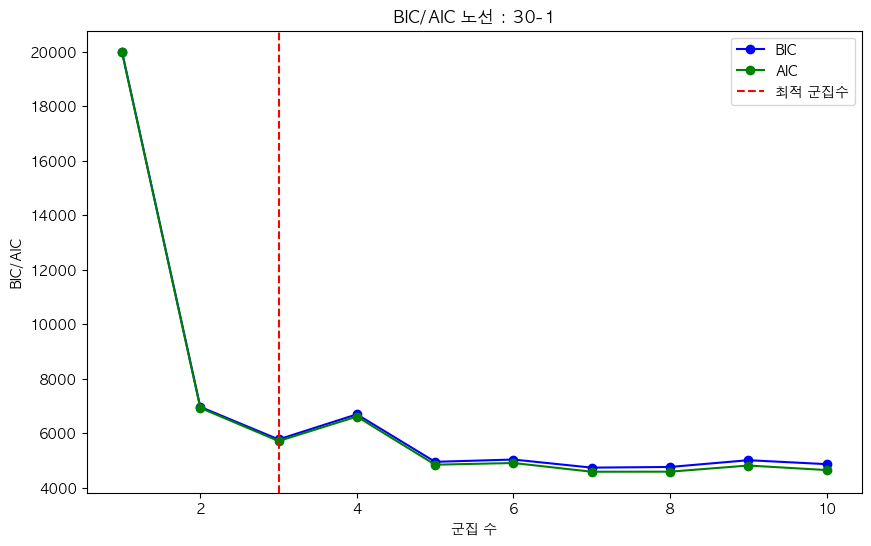

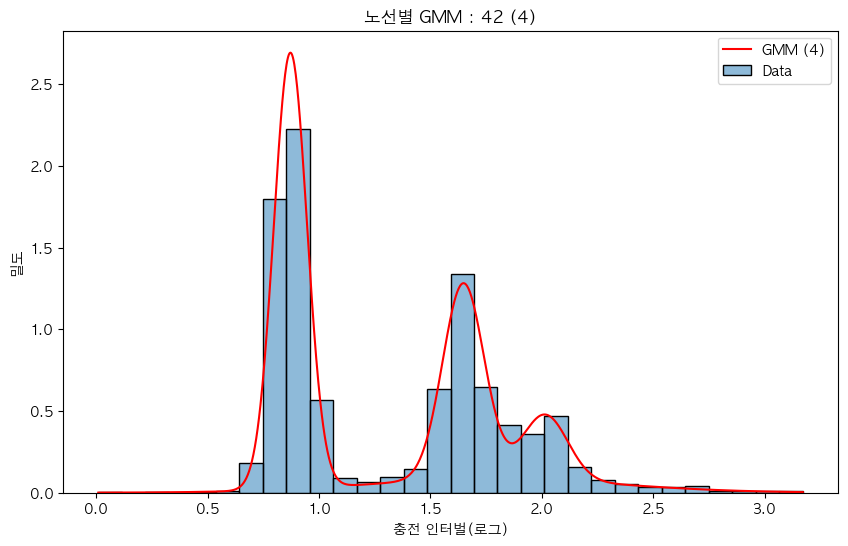

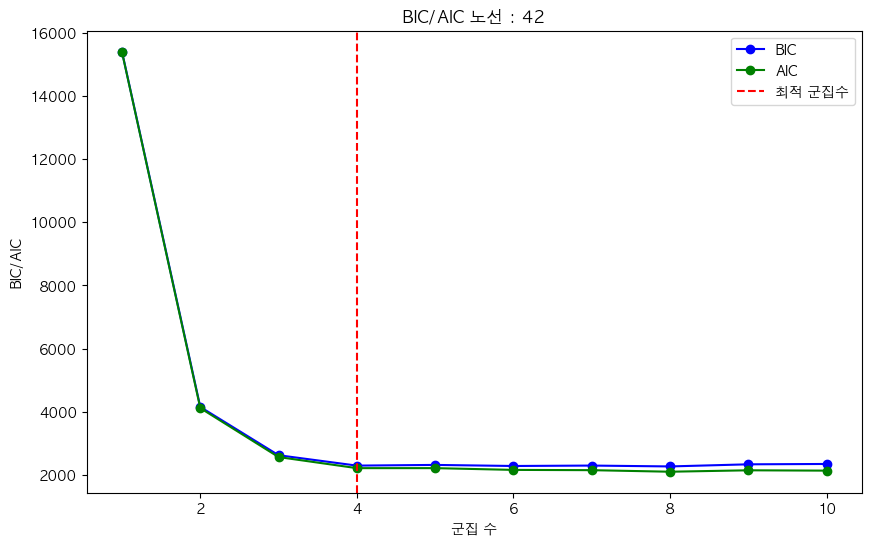

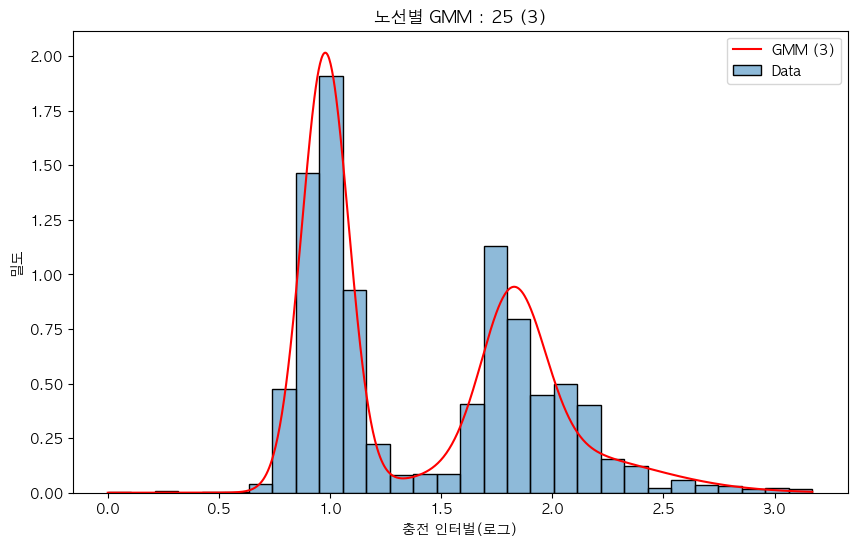

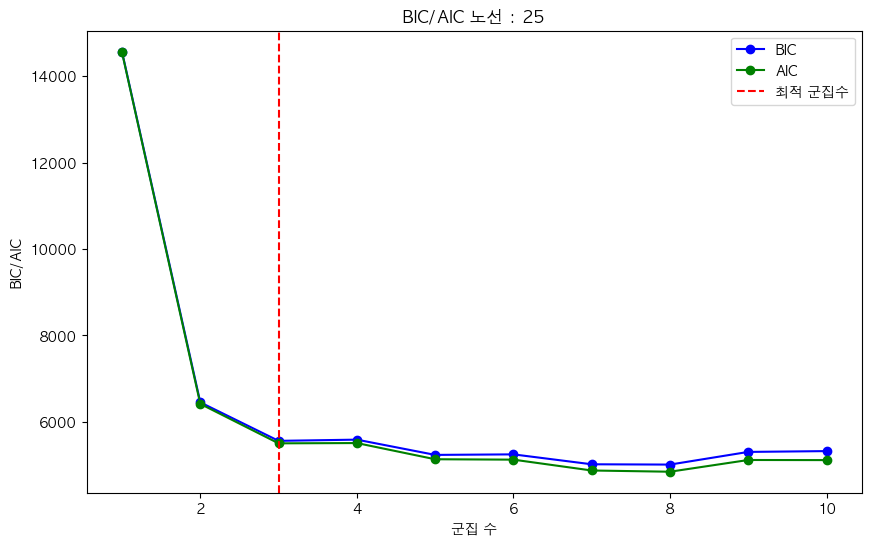

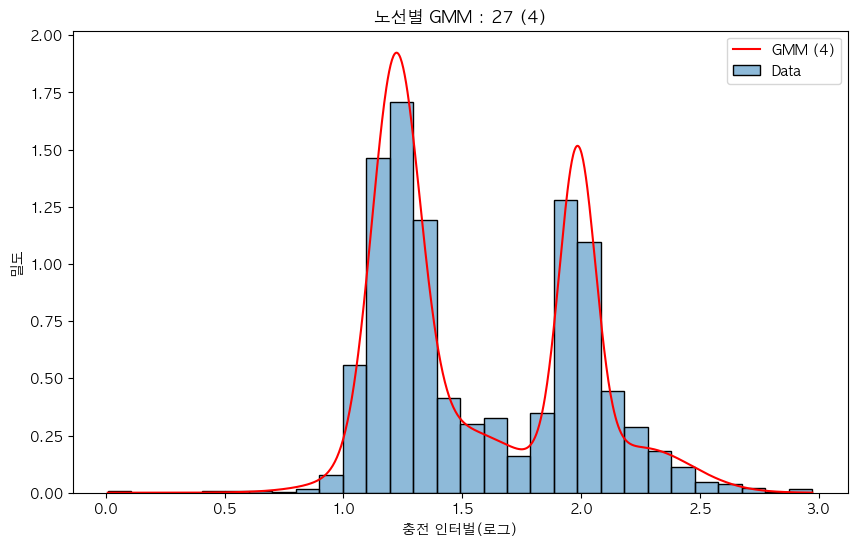

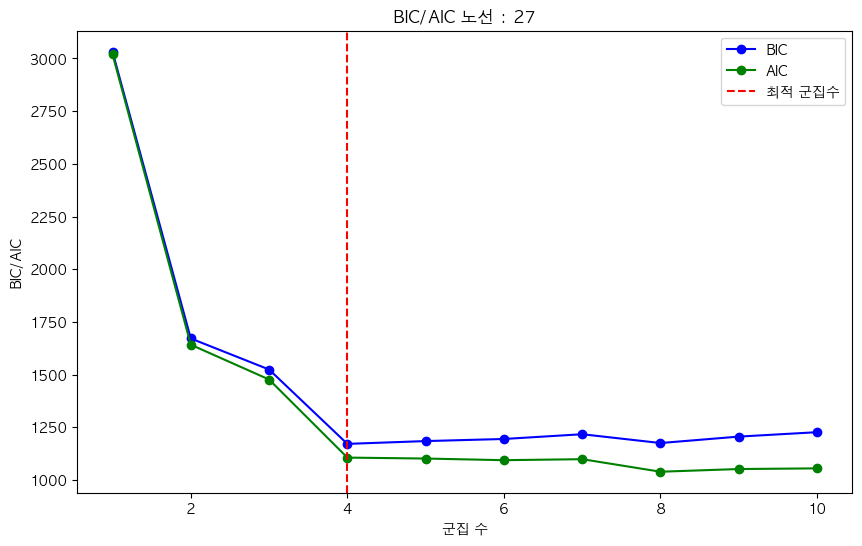

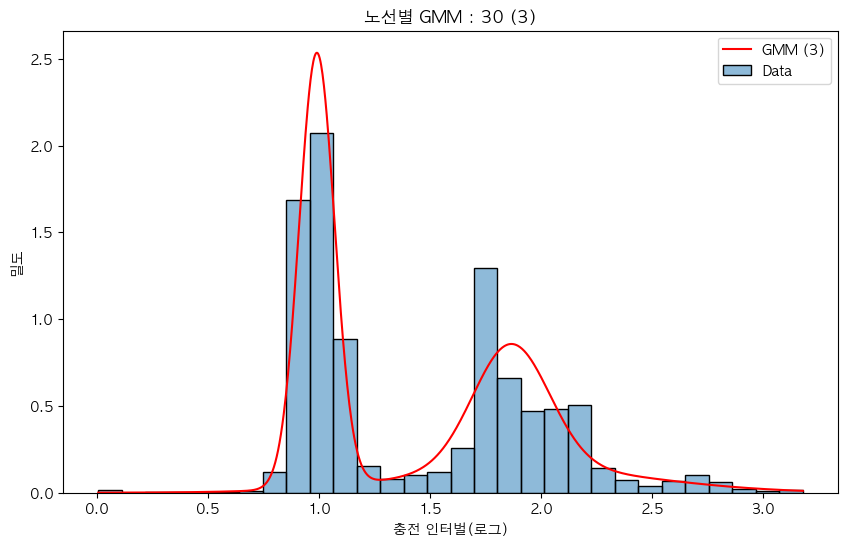

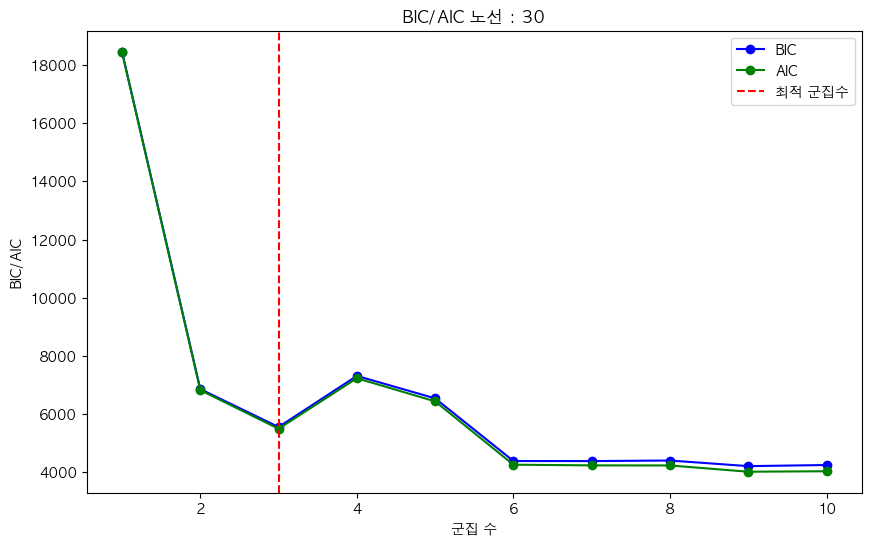

완료


In [31]:
gmm_df = df.copy()

gmm_df['충전 인터벌(시간)'] = pd.to_numeric(gmm_df['충전 인터벌(시간)'], errors='coerce')
gmm_df = gmm_df.dropna(subset=['노선명', '충전 인터벌(시간)'])
gmm_df['충전 인터벌(시간)'] = np.log(gmm_df['충전 인터벌(시간)'])

routes = gmm_df['노선명'].unique()

def fit_gmm_bic(route_name, gmm_df, rth=0.05):
    route_data = gmm_df[gmm_df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    ncr = range(1, 11)
    bics = []
    aics = []
    models = []
    
    for nc in ncr:
        gmm = GaussianMixture(n_components=nc, random_state=42)
        gmm.fit(route_data)
        bics.append(gmm.bic(route_data))
        aics.append(gmm.aic(route_data))
        models.append(gmm)
    
    bic_rr = np.diff(bics) / np.array(bics[:-1])
    onc = np.argmax(bic_rr > -rth)
    best = models[onc]
    
    x = np.linspace(min(route_data), max(route_data), 1000).reshape(-1, 1)
    logprob = best.score_samples(x)
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(route_data, kde=False, bins=30, stat='density', color='skyblue', label='Data')
    plt.plot(x, pdf, label=f'GMM ({onc+1})', color='red')
    plt.title(f'노선별 GMM : {route_name} ({onc + 1})')
    plt.xlabel('충전 인터벌(로그)')
    plt.ylabel('밀도')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ncr, bics, label='BIC', marker='o', color='blue')
    plt.plot(ncr, aics, label='AIC', marker='o', color='green')
    plt.axvline(x=onc + 1, color='red', linestyle='--', label='최적 군집수')
    plt.xlabel('군집 수')
    plt.ylabel('BIC/AIC')
    plt.title(f'BIC/AIC 노선 : {route_name}')
    plt.legend()
    plt.show()

for route in routes:
    fit_gmm_bic(route, gmm_df, rth=0.05)

print('완료')


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78928 entries, 0 to 80847
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   차량번호         78928 non-null  object        
 1   노선명          78928 non-null  object        
 2   충전기ID        78928 non-null  int64         
 3   OUTLET ID    78928 non-null  object        
 4   충전기ID_충전구    78928 non-null  object        
 5   충전시작시각       78928 non-null  datetime64[ns]
 6   충전종료시각       78928 non-null  datetime64[ns]
 7   충전전력량(kWh)   78928 non-null  float64       
 8   충전 요금(원)     78928 non-null  int64         
 9   충전시작 SOC(%)  78928 non-null  int64         
 10  충전종료 SOC(%)  78928 non-null  int64         
 11  충전 인터벌(시간)   74790 non-null  float64       
 12  충전소요시간_수정    78928 non-null  object        
 13  SOC종료-시작_수정  78928 non-null  int64         
 14  충전일자         78928 non-null  datetime64[ns]
 15  월            78928 non-null  int64         
 16  요일       

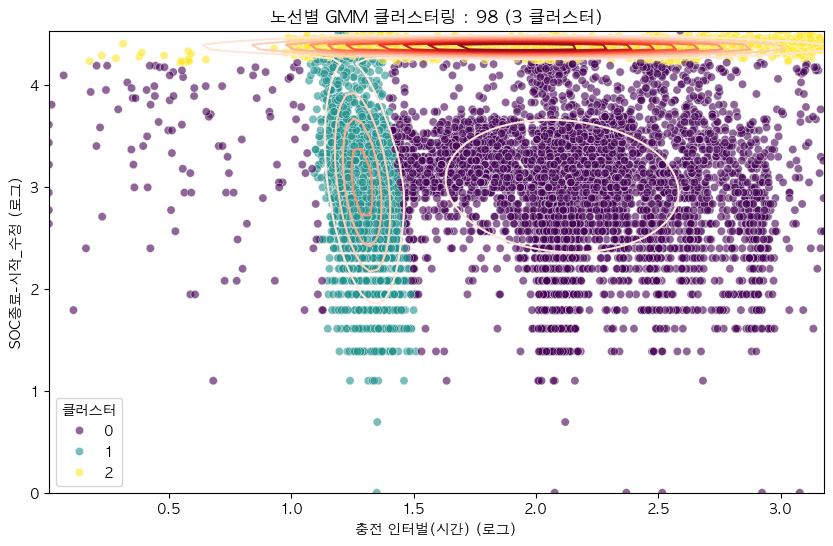

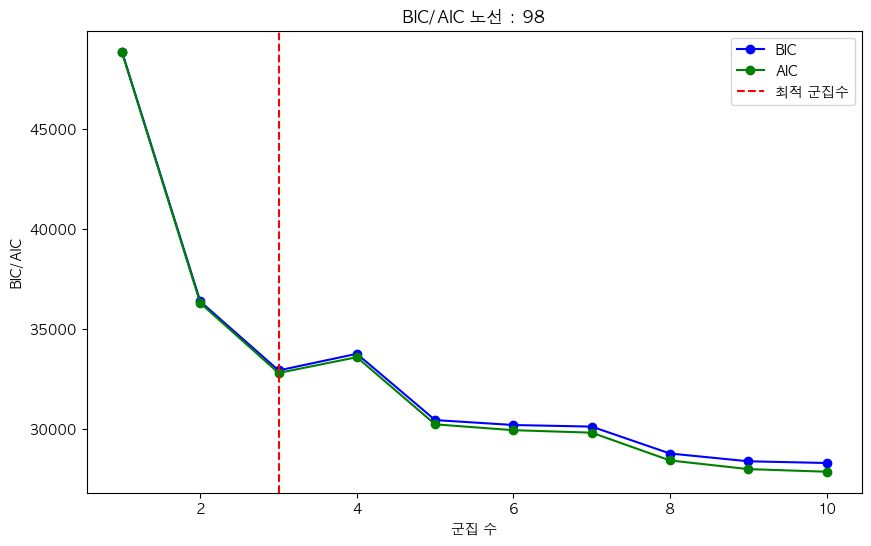

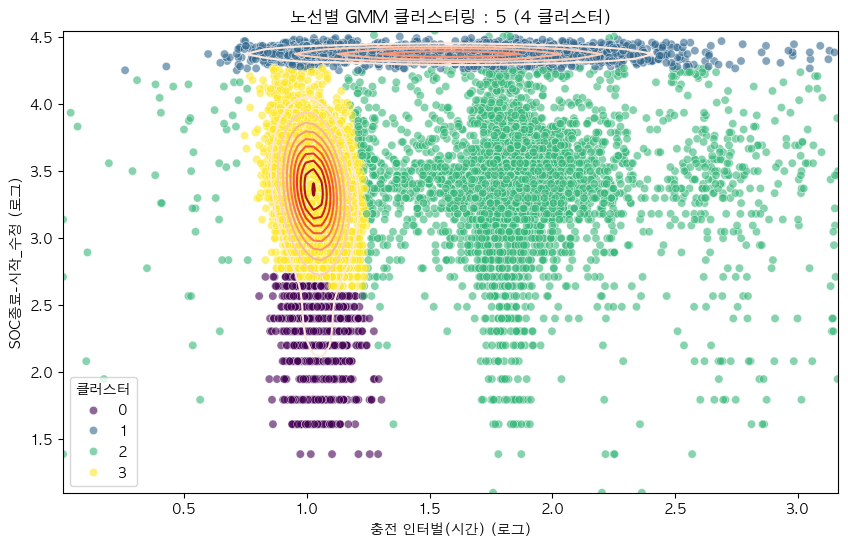

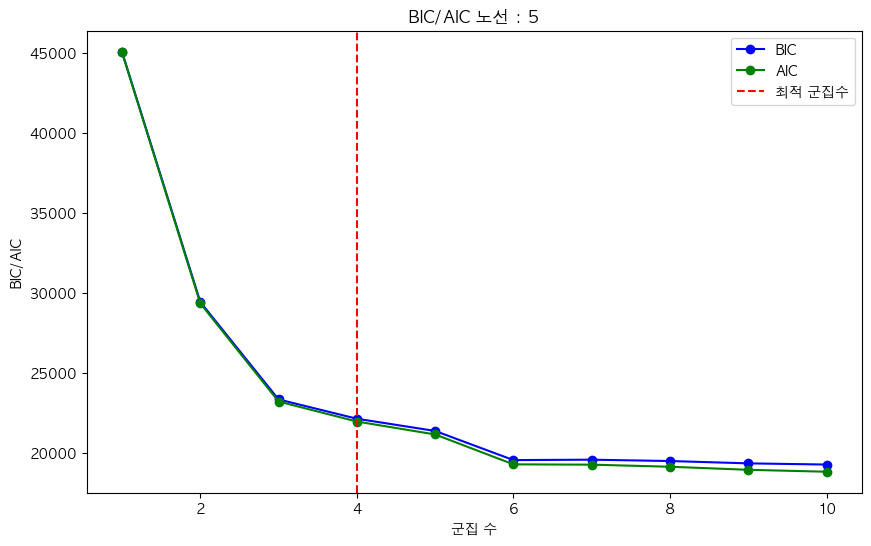

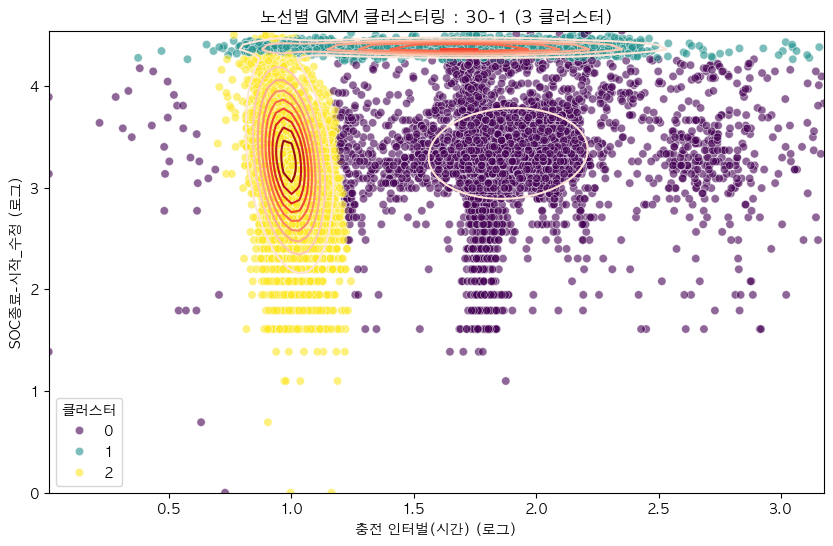

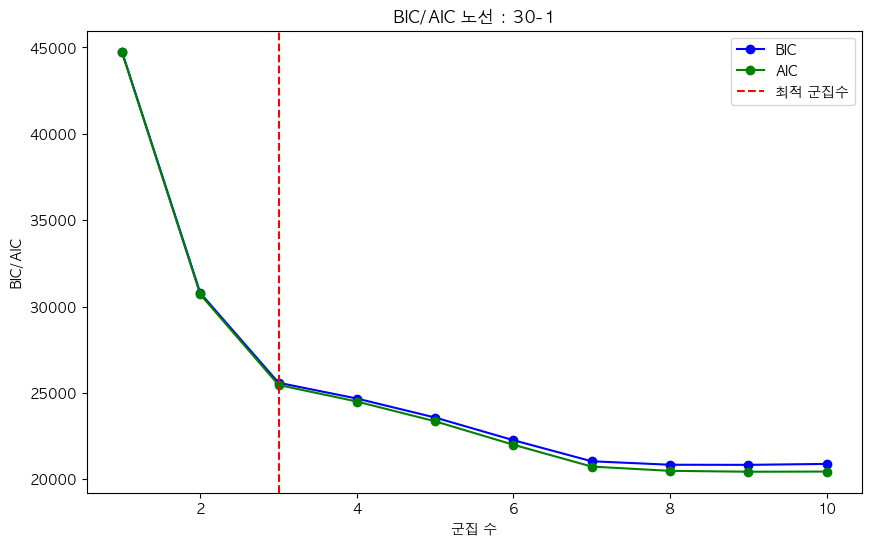

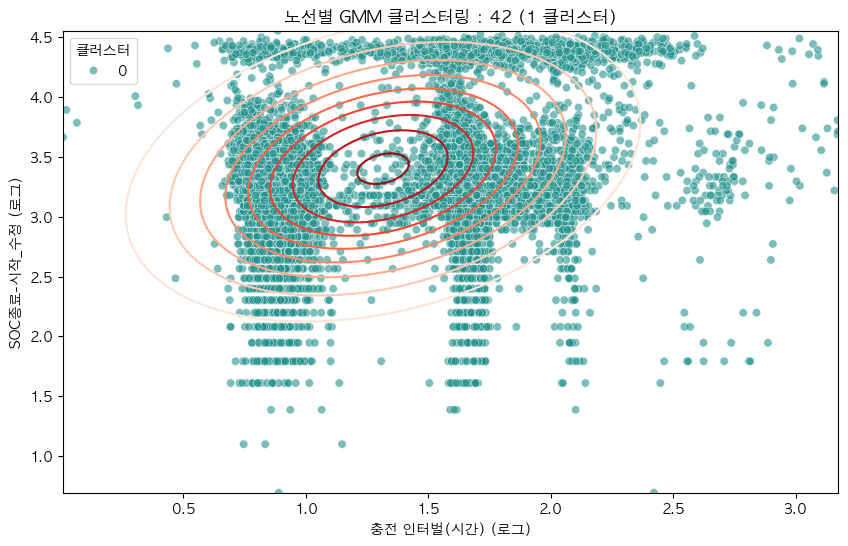

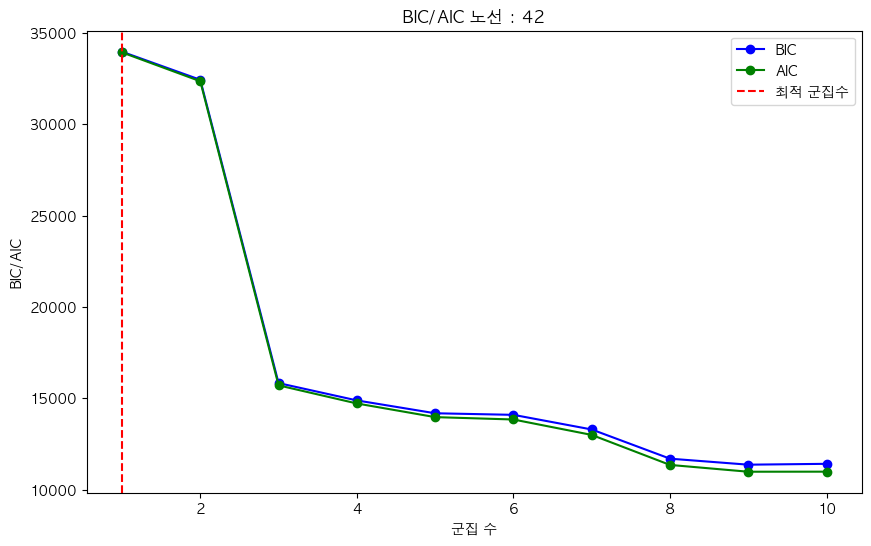

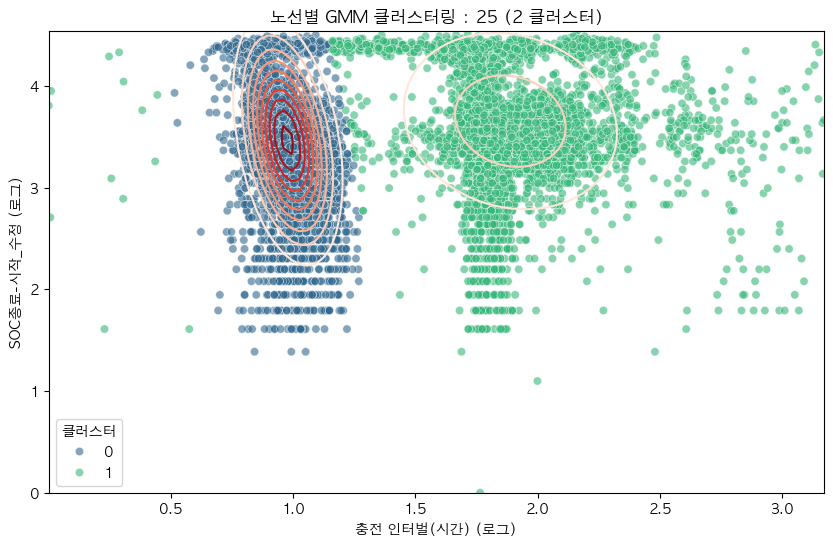

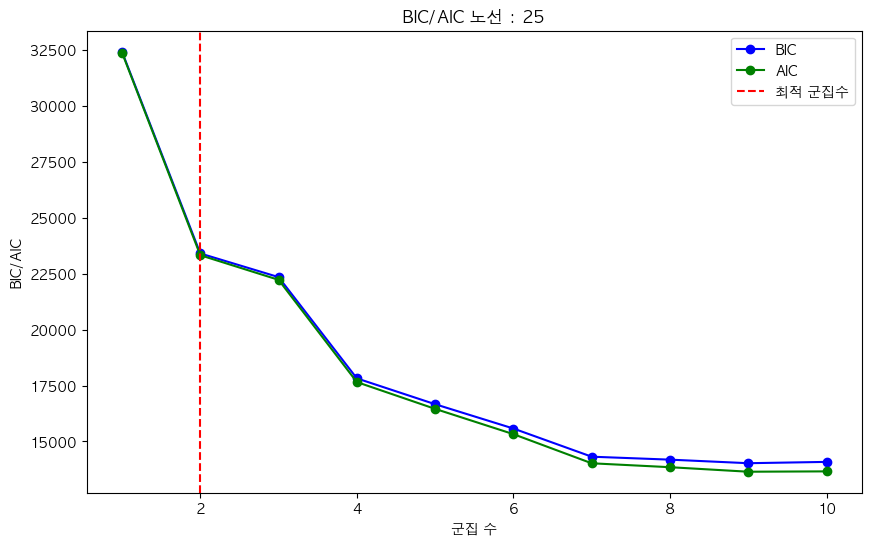

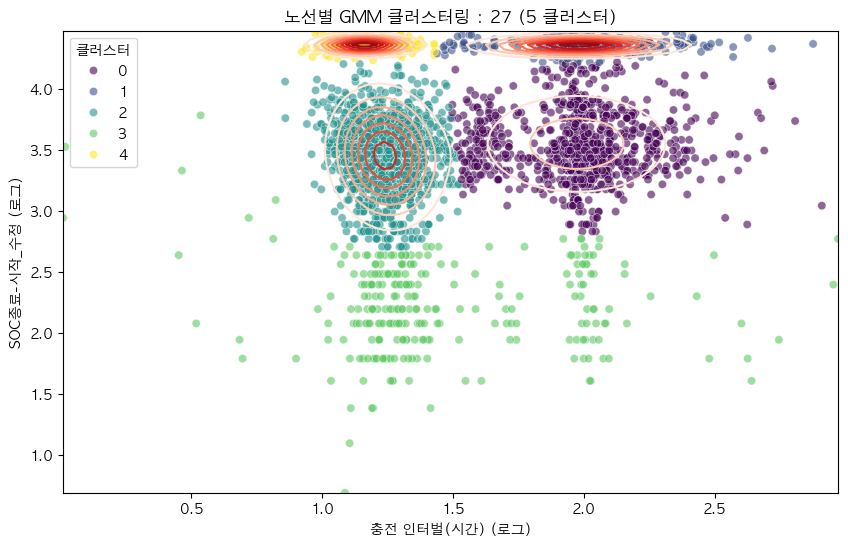

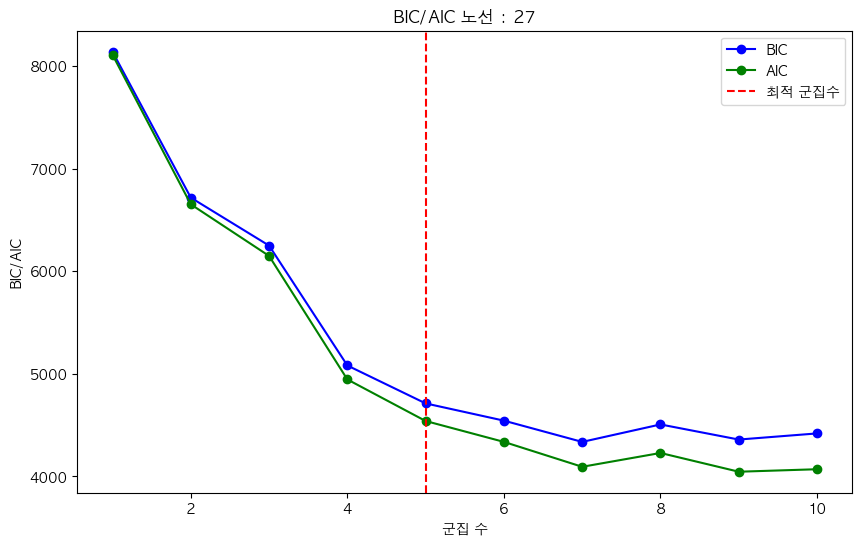

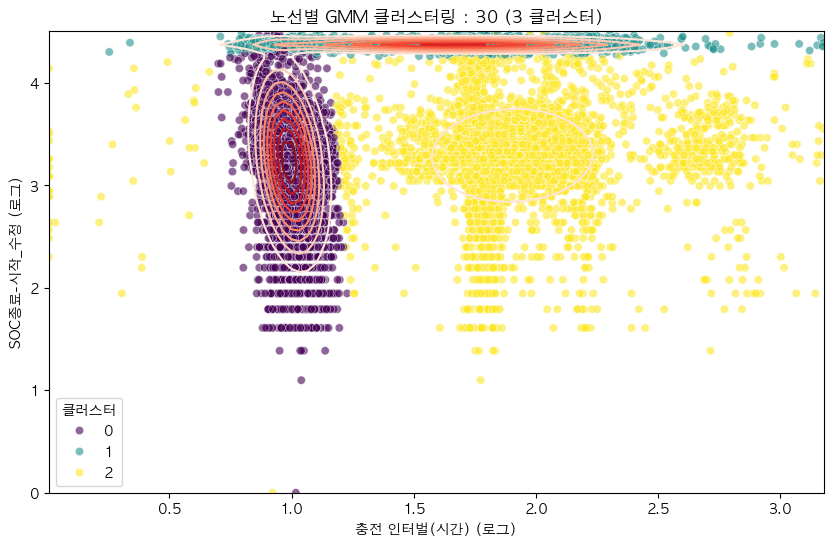

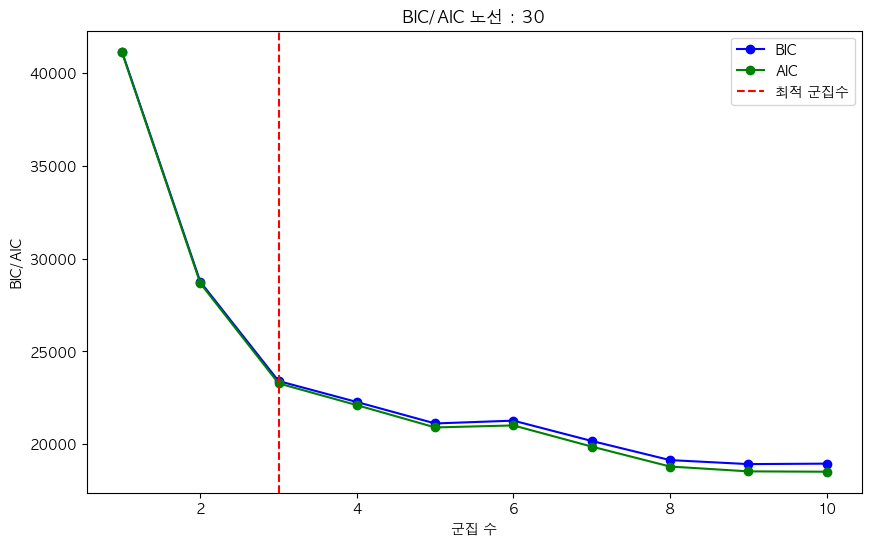

완료
            차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
5      경기70바1254  98     33         A      33_A 2023-01-04 15:42:40   
...          ...  ..    ...       ...       ...                 ...   
80842  경기70바1969  30      9         A       9_A 2023-12-27 11:34:54   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  충전 인터벌(시간)  \
1     2023-01-03 12:30:34       87.28      8510           60  .

In [44]:
gmm_df = df.copy()

gmm_df['충전 인터벌(시간)'] = pd.to_numeric(gmm_df['충전 인터벌(시간)'], errors='coerce')
gmm_df['SOC종료-시작_수정'] = pd.to_numeric(gmm_df['SOC종료-시작_수정'], errors='coerce')

gmm_df = gmm_df.dropna(subset=['노선명', '충전 인터벌(시간)', 'SOC종료-시작_수정'])

gmm_df = gmm_df[gmm_df['충전 인터벌(시간)'] > 0]
gmm_df = gmm_df[gmm_df['SOC종료-시작_수정'] > 0]
gmm_df['충전 인터벌(시간)'] = np.log(gmm_df['충전 인터벌(시간)'])
gmm_df['SOC종료-시작_수정'] = np.log(gmm_df['SOC종료-시작_수정'])

gmm_df.replace([np.inf, -np.inf], np.nan, inplace=True)
gmm_df.dropna(inplace=True)

routes = gmm_df['노선명'].unique()

def fit_gmm_bic(route_name, gmm_df, rth=0.05):
    route_data = gmm_df[gmm_df['노선명'] == route_name][['충전 인터벌(시간)', 'SOC종료-시작_수정']].values

    ncr = range(1, 11)
    bics = []
    aics = []
    models = []

    for nc in ncr:
        gmm = GaussianMixture(n_components=nc, random_state=42)
        gmm.fit(route_data)
        bics.append(gmm.bic(route_data))
        aics.append(gmm.aic(route_data))
        models.append(gmm)

    bic_rr = np.diff(bics) / np.array(bics[:-1])

    onc = np.argmax(bic_rr > -rth)
    best = models[onc]

    gmm_df.loc[gmm_df['노선명'] == route_name, '클러스터'] = best.predict(route_data).astype(int)

    # 2D 확률 밀도 함수 시각화 (컨투어 플롯)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=route_data[:, 0], y=route_data[:, 1], hue=best.predict(route_data), palette='viridis', legend='full', alpha=0.6)
    plt.title(f'노선별 GMM 클러스터링 : {route_name} ({onc + 1} 클러스터)')
    plt.xlabel('충전 인터벌(시간) (로그)')
    plt.ylabel('SOC종료-시작_수정 (로그)')

    x = np.linspace(route_data[:, 0].min(), route_data[:, 0].max(), 100)
    y = np.linspace(route_data[:, 1].min(), route_data[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = best.score_samples(XX)
    Z = Z.reshape(X.shape)

    plt.contour(X, Y, np.exp(Z), levels=10, cmap='Reds')
    plt.legend(title='클러스터')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(ncr, bics, label='BIC', marker='o', color='blue')
    plt.plot(ncr, aics, label='AIC', marker='o', color='green')
    plt.axvline(x=onc + 1, color='red', linestyle='--', label='최적 군집수')
    plt.xlabel('군집 수')
    plt.ylabel('BIC/AIC')
    plt.title(f'BIC/AIC 노선 : {route_name}')
    plt.legend()
    plt.show()

for route in routes:
    fit_gmm_bic(route, gmm_df, rth=0.05)

print('완료')
print(gmm_df)


In [5]:
gmm_df = df.copy()
gmm_df['충전 인터벌(시간)'] = pd.to_numeric(gmm_df['충전 인터벌(시간)'], errors='coerce')
gmm_df = gmm_df.dropna(subset=['노선명', '충전 인터벌(시간)'])
gmm_df['충전 인터벌(시간)'] = np.log(gmm_df['충전 인터벌(시간)'])

routes = gmm_df['노선명'].unique()

def fit_gmm_bic(route_name, gmm_df, rth=0.05):
    route_data = gmm_df[gmm_df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    ncr = range(1, 11)
    bics = []
    aics = []
    models = []
    
    for nc in ncr:
        gmm = GaussianMixture(n_components=nc, random_state=42)
        gmm.fit(route_data)
        bics.append(gmm.bic(route_data))
        aics.append(gmm.aic(route_data))
        models.append(gmm)
    
    bic_rr = np.diff(bics) / np.array(bics[:-1])
    onc = np.argmax(bic_rr > -rth)
    best = models[onc]
    
    gmm_df.loc[gmm_df['노선명'] == route_name, '클러스터'] = best.predict(route_data).astype(int)
    
    return best

for route in routes:
    fit_gmm_bic(route, gmm_df)

gmm_df


차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
5      경기70바1254  98     33         A      33_A 2023-01-04 15:42:40   
...          ...  ..    ...       ...       ...                 ...   
80842  경기70바1969  30      9         A       9_A 2023-12-27 11:34:54   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  충전 인터벌(시간)  \
1     2023-01-03 12:30:34       87.28      8510           60  ...    2.859451   
2     2023-01-03 16:25:15       28.24      4643           69  ...    1.307281   
3     2023-01-04 02:11:29      183.32     15986           19  ...    2.049304   
4     2023-01-04 12:12:15       72.00      9262           58  ...    2.264508   
5     2023-01-04 16:01:06       56.08      5692           59  ...    1.254745   
...                   ...         ...       ...          ...  ...         ...   
80842 2023-12-27 11:56:24       18.76         0           63  ...    2.884366   
80844 2023-12-29 07:35:58       44.16         0           62  ...    2.654552   
80845 2023-12-29 10:38:28       64.56         0           57  ...    0.979370   
80846 2023-12-29 16:40:36       21.08         0           63  ...    1.757475   
80847 2023-12-30 00:07:47      120.56         0           20  ...    1.805735   

       충전소요시간_수정 SOC종료-시작_수정       충전일자   월  요일 주중/주말 왕복운행거리  인가거리  클러스터  
1       00:29:58          35 2023-01-03   1   화    주중  50.90  50.9   1.0  
2       00:12:55          12 2023-01-03   1   화    주중  50.90  50.9   0.0  
3       02:00:29          76 2023-01-04   1   수    주중  50.90  50.9   1.0  
4       00:23:11          29 2023-01-04   1   수    주중  50.90  50.9   1.0  
5       00:18:26          22 2023-01-04   1   수    주중  50.90  50.9   0.0  
...          ...         ...        ...  ..  ..   ...    ...   ...   ...  
80842   00:21:30          32 2023-12-27  12   수    주중  43.63  43.6   2.0  
80844   00:15:06          26 2023-12-29  12   금    주중  43.63  43.6   2.0  
80845   00:22:44          38 2023-12-29  12   금    주중  43.63  43.6   0.0  
80846   00:14:16          24 2023-12-29  12   금    주중  43.63  43.6   1.0  
80847   01:22:07          75 2023-12-29  12   금    주중  43.63  43.6   1.0  

[74790 rows x 21 columns]

In [6]:
gmm_df.groupby(['노선명','클러스터'])['충전 인터벌(시간)'].mean()

노선명   클러스터
25    0.0     0.979222
      1.0     1.811955
      2.0     2.121854
27    0.0     1.981499
      1.0     1.526385
      2.0     2.323728
      3.0     1.218567
30    0.0     0.990384
      1.0     1.866593
      2.0     2.063593
30-1  0.0     1.865130
      1.0     0.990302
      2.0     2.043680
42    0.0     0.871677
      1.0     2.011256
      2.0     1.882397
      3.0     1.649463
5     0.0     1.030263
      1.0     1.925539
      2.0     1.833613
98    0.0     1.284075
      1.0     2.190209
Name: 충전 인터벌(시간), dtype: float64

In [7]:
gmm_df = df.copy()
gmm_df['원본 충전 인터벌(시간)'] = gmm_df['충전 인터벌(시간)']  # 로그 변환 전 원본 값 저장
gmm_df['충전 인터벌(시간)'] = pd.to_numeric(gmm_df['충전 인터벌(시간)'], errors='coerce')
gmm_df = gmm_df.dropna(subset=['노선명', '충전 인터벌(시간)'])
gmm_df['충전 인터벌(시간)'] = np.log(gmm_df['충전 인터벌(시간)'])

routes = gmm_df['노선명'].unique()

def fit_gmm_bic(route_name, gmm_df, rth=0.05):
    route_data = gmm_df[gmm_df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    ncr = range(1, 11)
    bics = []
    aics = []
    models = []
    
    for nc in ncr:
        gmm = GaussianMixture(n_components=nc, random_state=42)
        gmm.fit(route_data)
        bics.append(gmm.bic(route_data))
        aics.append(gmm.aic(route_data))
        models.append(gmm)
    
    bic_rr = np.diff(bics) / np.array(bics[:-1])
    onc = np.argmax(bic_rr > -rth)
    best = models[onc]
    
    gmm_df.loc[gmm_df['노선명'] == route_name, '클러스터'] = best.predict(route_data).astype(int)

    return best

for route in routes:
    fit_gmm_bic(route, gmm_df)

gmm_df

차량번호 노선명  충전기ID OUTLET ID 충전기ID_충전구              충전시작시각  \
1      경기70바1254  98      8         A       8_A 2023-01-03 12:00:36   
2      경기70바1254  98     41         B      41_B 2023-01-03 16:12:20   
3      경기70바1254  98     45         B      45_B 2023-01-04 00:11:00   
4      경기70바1254  98     21         A      21_A 2023-01-04 11:49:04   
5      경기70바1254  98     33         A      33_A 2023-01-04 15:42:40   
...          ...  ..    ...       ...       ...                 ...   
80842  경기70바1969  30      9         A       9_A 2023-12-27 11:34:54   
80844  경기70바1969  30     14         A      14_A 2023-12-29 07:20:52   
80845  경기70바1969  30     14         A      14_A 2023-12-29 10:15:44   
80846  경기70바1969  30      6         B       6_B 2023-12-29 16:26:20   
80847  경기70바1969  30      2         B       2_B 2023-12-29 22:45:40   

                   충전종료시각  충전전력량(kWh)  충전 요금(원)  충전시작 SOC(%)  ...  충전소요시간_수정  \
1     2023-01-03 12:30:34       87.28      8510           60  ...   00:29:58   
2     2023-01-03 16:25:15       28.24      4643           69  ...   00:12:55   
3     2023-01-04 02:11:29      183.32     15986           19  ...   02:00:29   
4     2023-01-04 12:12:15       72.00      9262           58  ...   00:23:11   
5     2023-01-04 16:01:06       56.08      5692           59  ...   00:18:26   
...                   ...         ...       ...          ...  ...        ...   
80842 2023-12-27 11:56:24       18.76         0           63  ...   00:21:30   
80844 2023-12-29 07:35:58       44.16         0           62  ...   00:15:06   
80845 2023-12-29 10:38:28       64.56         0           57  ...   00:22:44   
80846 2023-12-29 16:40:36       21.08         0           63  ...   00:14:16   
80847 2023-12-30 00:07:47      120.56         0           20  ...   01:22:07   

       SOC종료-시작_수정       충전일자   월 요일  주중/주말 왕복운행거리  인가거리  원본 충전 인터벌(시간)  클러스터  
1               35 2023-01-03   1  화     주중  50.90  50.9      17.451944   1.0  
2               12 2023-01-03   1  화     주중  50.90  50.9       3.696111   0.0  
3               76 2023-01-04   1  수     주중  50.90  50.9       7.762500   1.0  
4               29 2023-01-04   1  수     주중  50.90  50.9       9.626389   1.0  
5               22 2023-01-04   1  수     주중  50.90  50.9       3.506944   0.0  
...            ...        ...  .. ..    ...    ...   ...            ...   ...  
80842           32 2023-12-27  12  수     주중  43.63  43.6      17.892222   2.0  
80844           26 2023-12-29  12  금     주중  43.63  43.6      14.218611   2.0  
80845           38 2023-12-29  12  금     주중  43.63  43.6       2.662778   0.0  
80846           24 2023-12-29  12  금     주중  43.63  43.6       5.797778   1.0  
80847           75 2023-12-29  12  금     주중  43.63  43.6       6.084444   1.0  

[74790 rows x 22 columns]

In [9]:
gmm_df['클러스터'] = gmm_df['클러스터'].astype(int)

In [10]:
im = gmm_df.groupby(['노선명','클러스터'])['원본 충전 인터벌(시간)'].mean().reset_index()
im

노선명  클러스터  원본 충전 인터벌(시간)
0     25     0       2.677020
1     25     1       6.165923
2     25     2       9.090550
3     27     0       7.272107
4     27     1       4.718231
5     27     2      10.361960
6     27     3       3.398478
7     30     0       2.700913
8     30     1       6.548589
9     30     2       9.346443
10  30-1     0       6.555005
11  30-1     1       2.701831
12  30-1     2       9.490763
13    42     0       2.397651
14    42     1       7.502861
15    42     2       8.176020
16    42     3       5.225785
17     5     0       2.811630
18     5     1       8.085829
19     5     2       6.294175
20    98     0       3.624355
21    98     1       9.765932

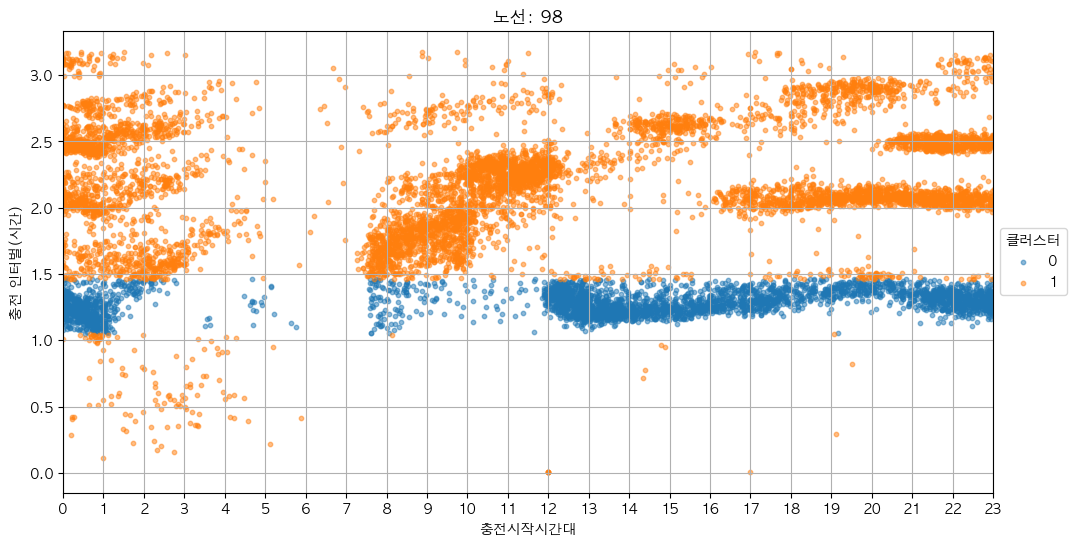

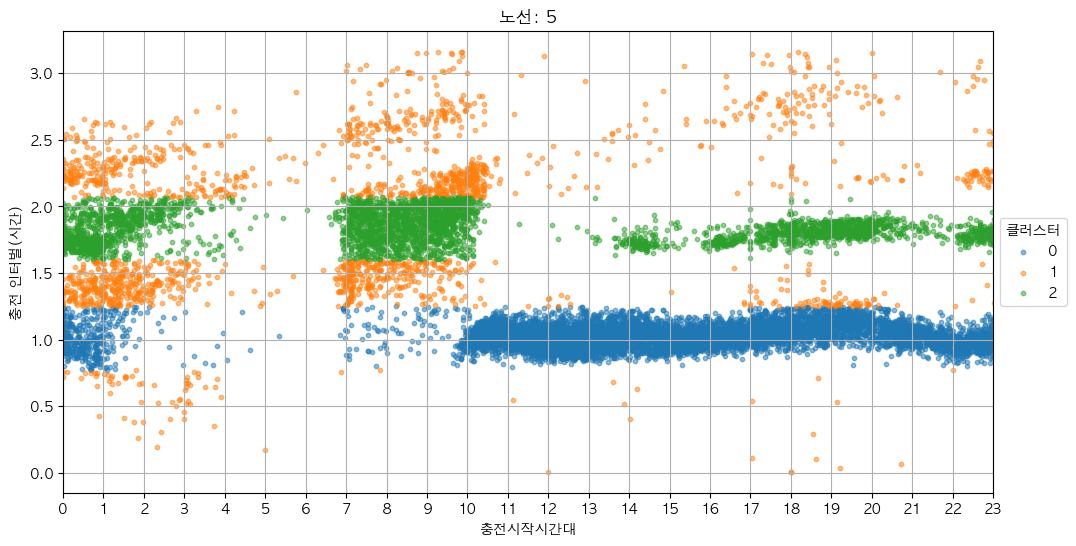

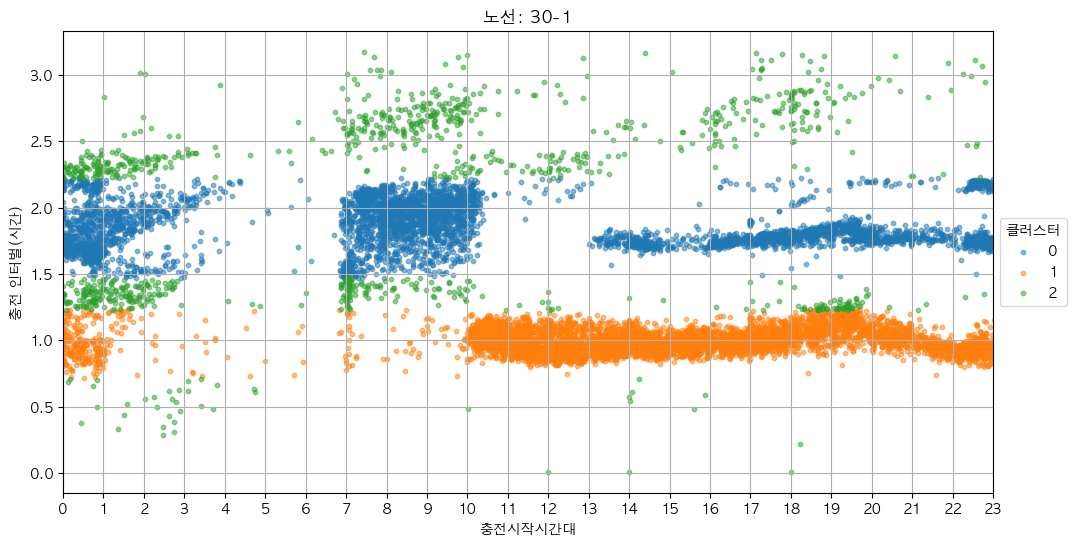

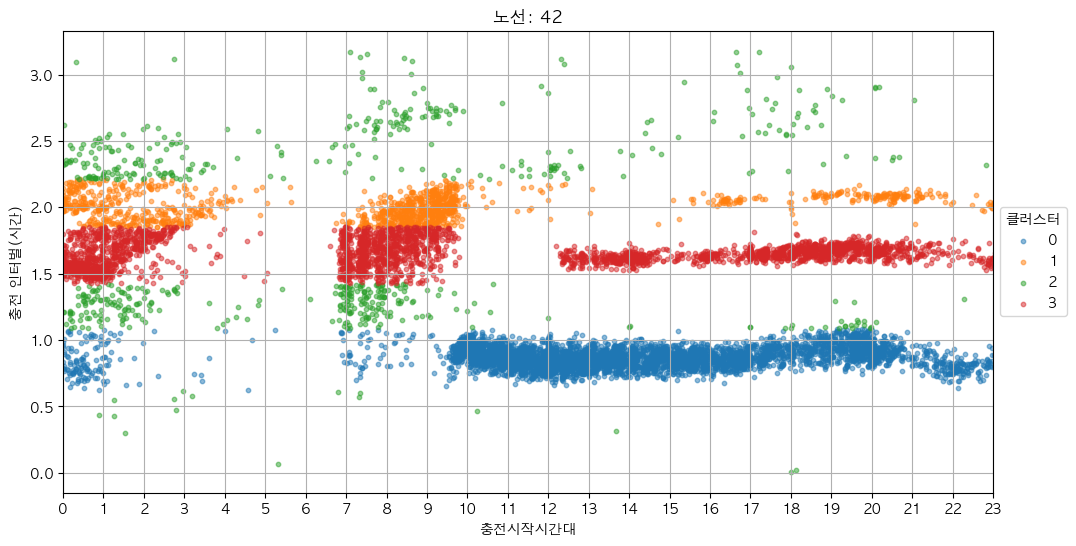

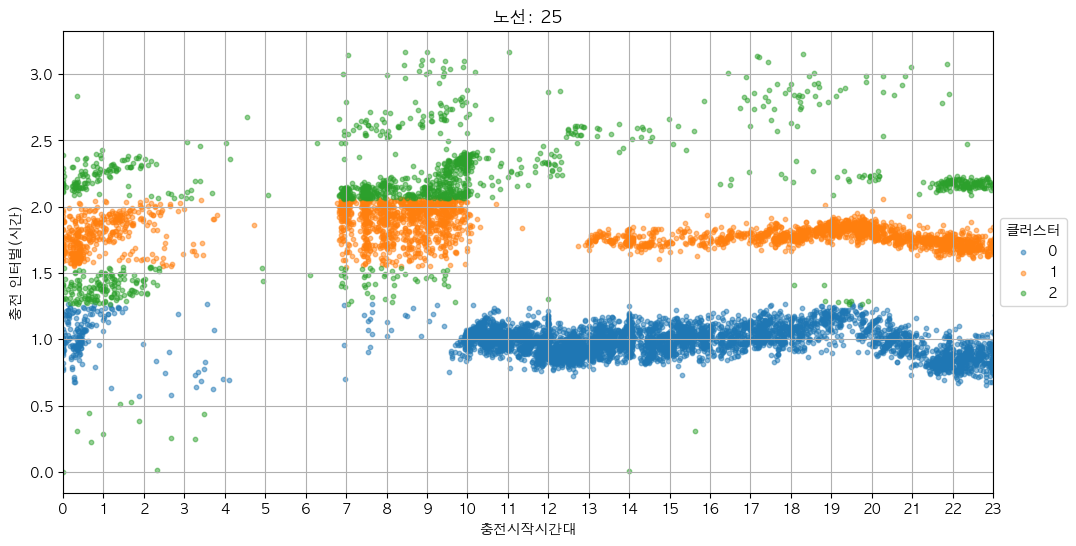

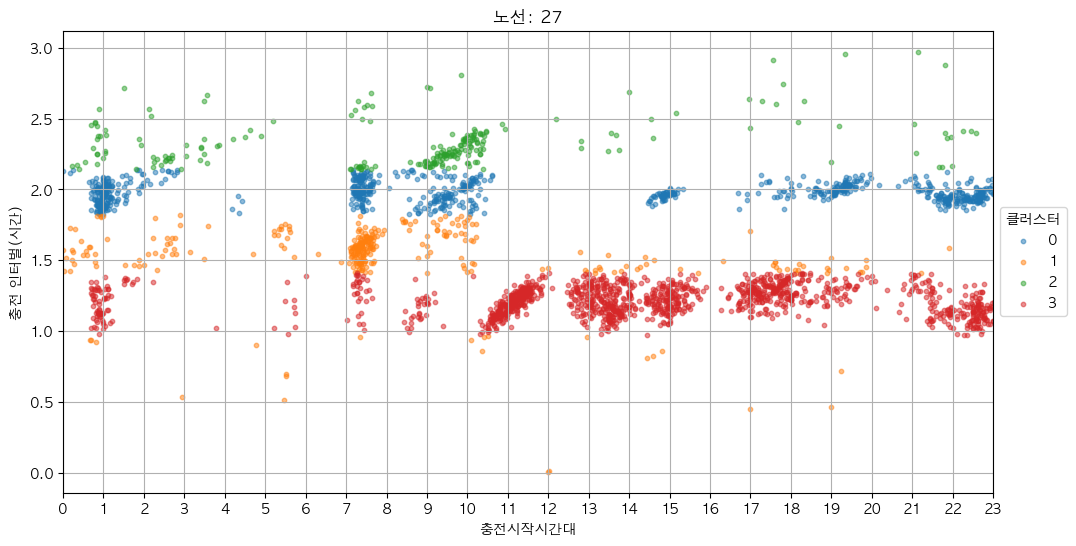

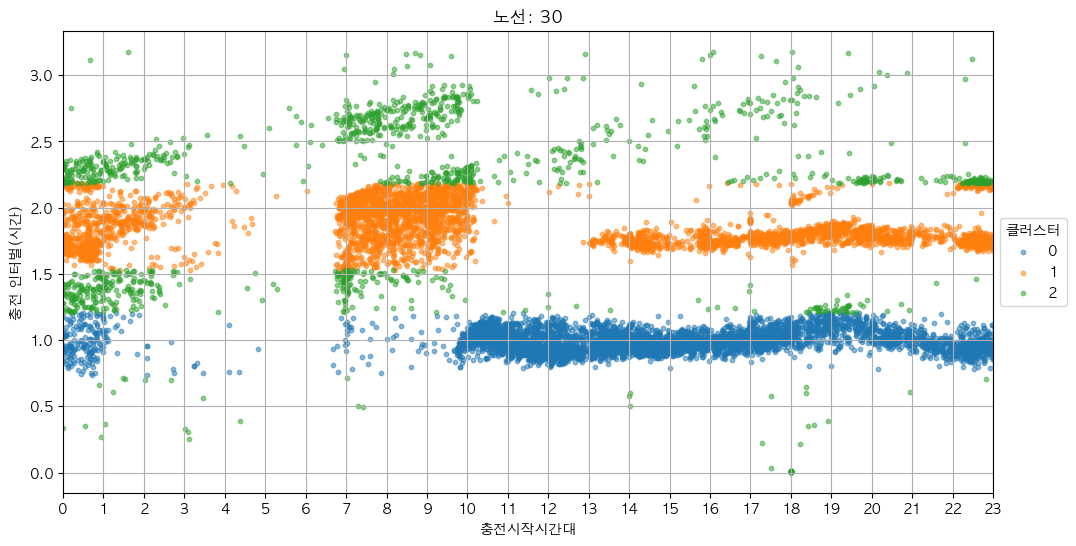

In [25]:
# 로그
gmm_df['시간대(24시간)'] = gmm_df['충전시작시각'].dt.hour + gmm_df['충전시작시각'].dt.minute / 60

unique_routes = gmm_df['노선명'].unique()

for route in unique_routes:
    route_data = gmm_df[gmm_df['노선명'] == route]
    plt.figure(figsize=(12, 6))
    
    for cluster in sorted(route_data['클러스터'].unique()):
        cluster_data = route_data[route_data['클러스터'] == cluster]
        plt.scatter(
            cluster_data['시간대(24시간)'],  
            cluster_data['충전 인터벌(시간)'], 
            label=f'{cluster}',
            alpha=0.5, 
            s=10  
        )
    plt.title(f'노선: {route}')
    plt.xlabel('충전시작시간대')
    plt.ylabel('충전 인터벌(시간)')
    plt.xticks(range(0, 24))
    plt.xlim(0, 23)
    plt.legend(title='클러스터', loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.grid(True)
    plt.show()


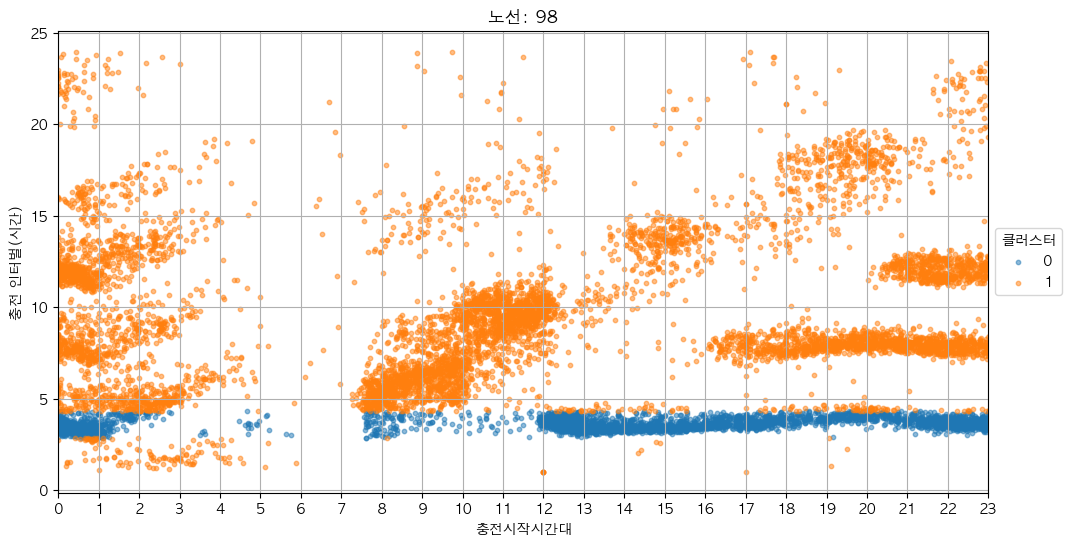

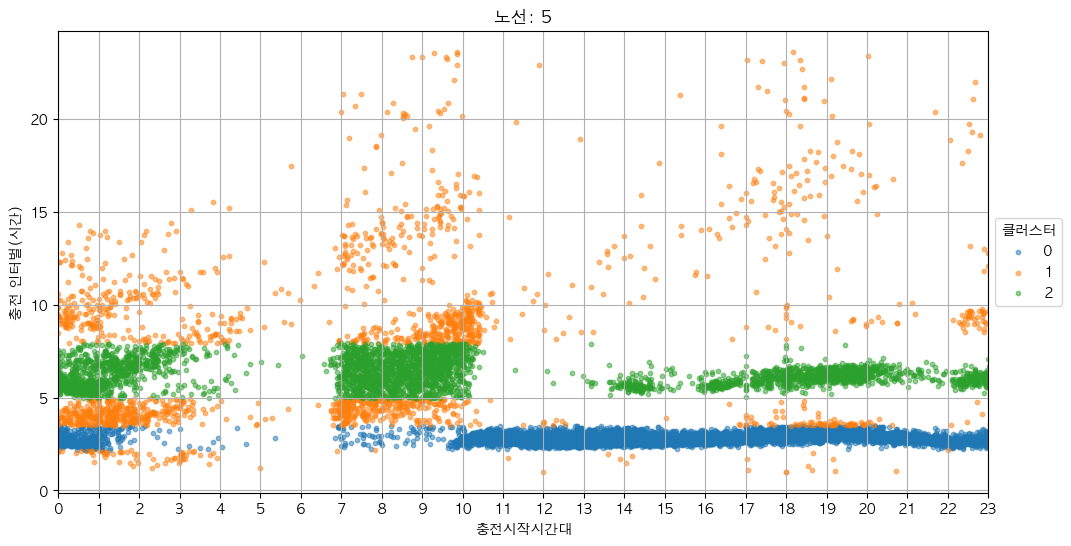

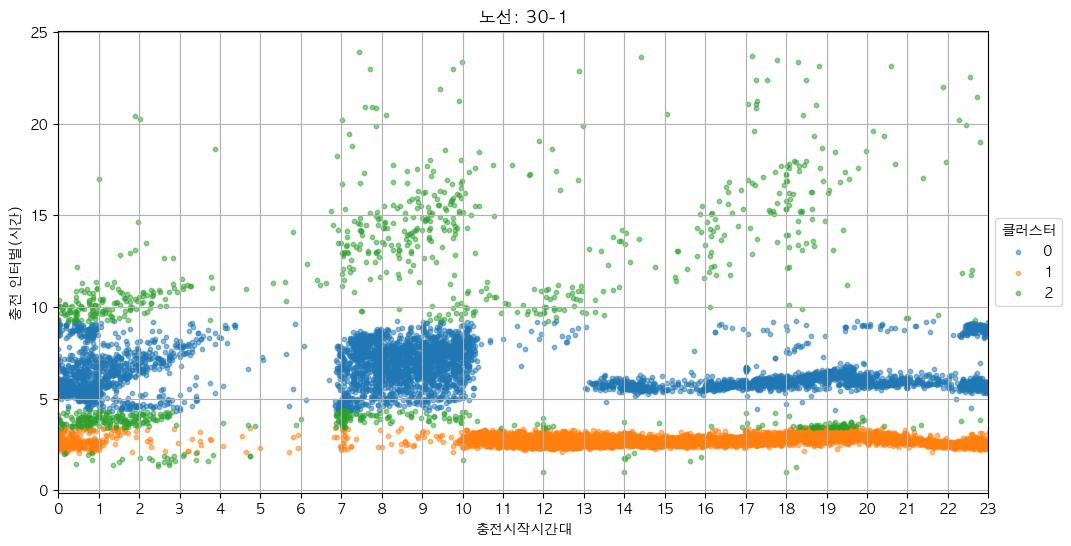

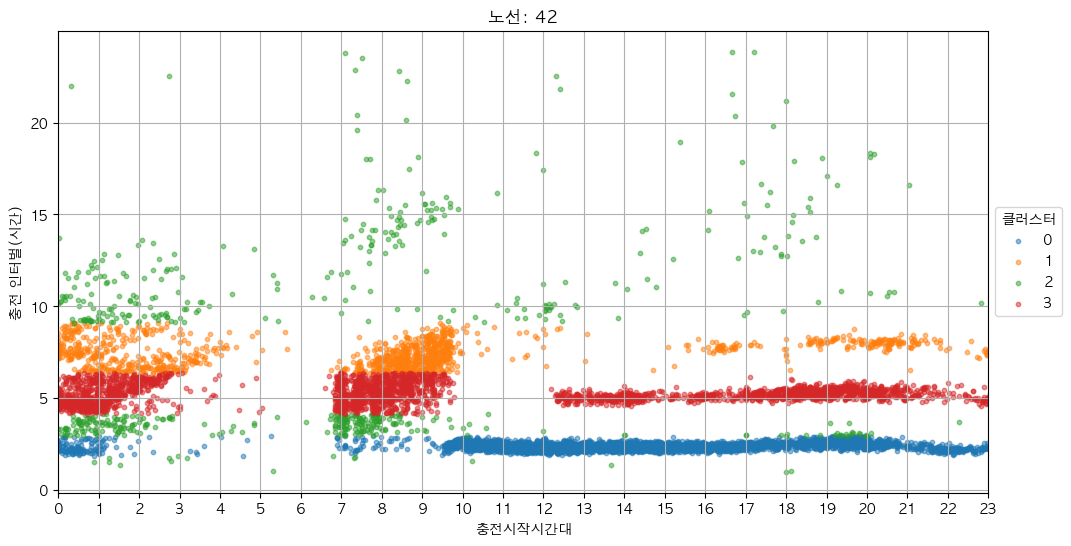

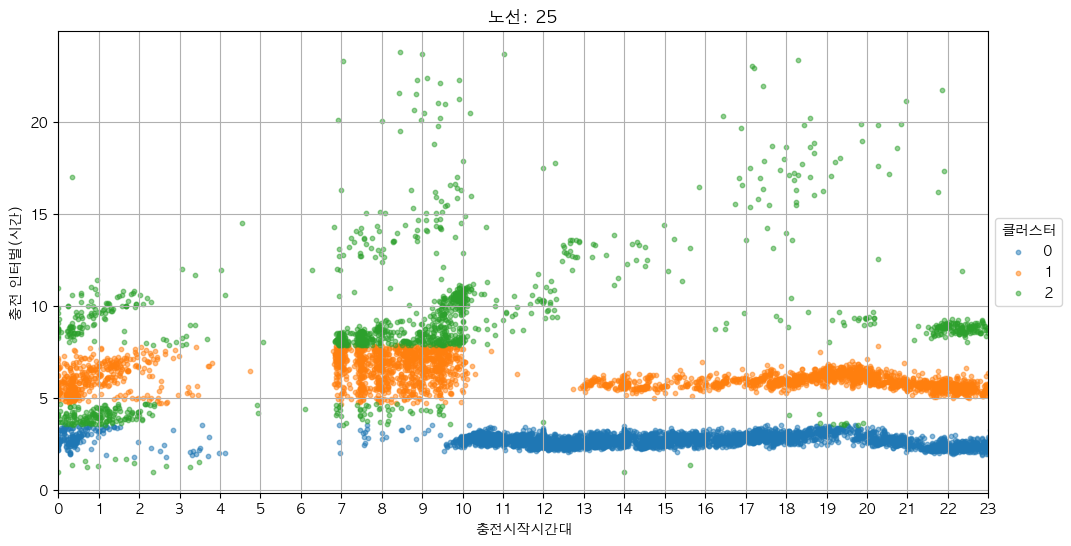

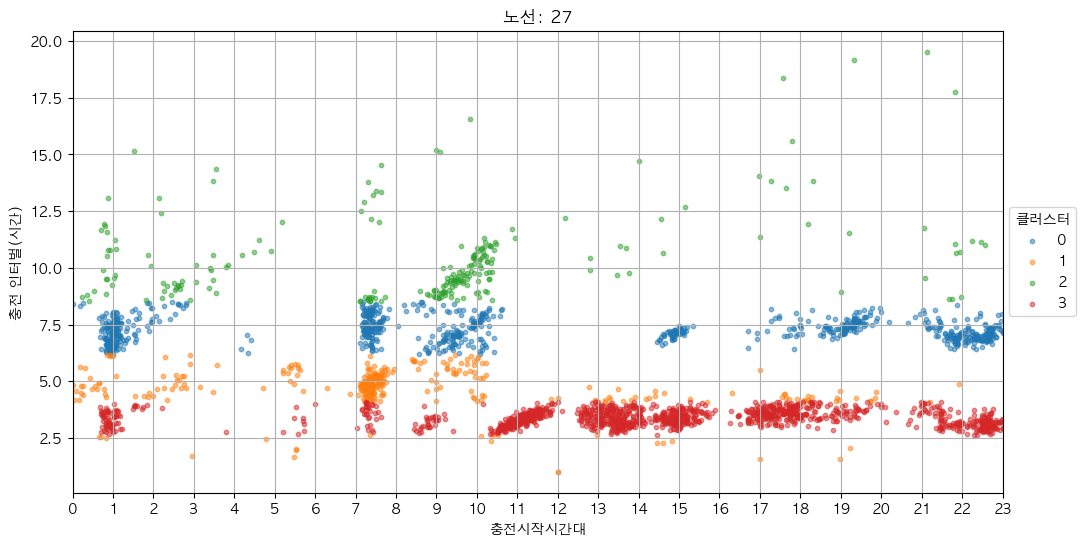

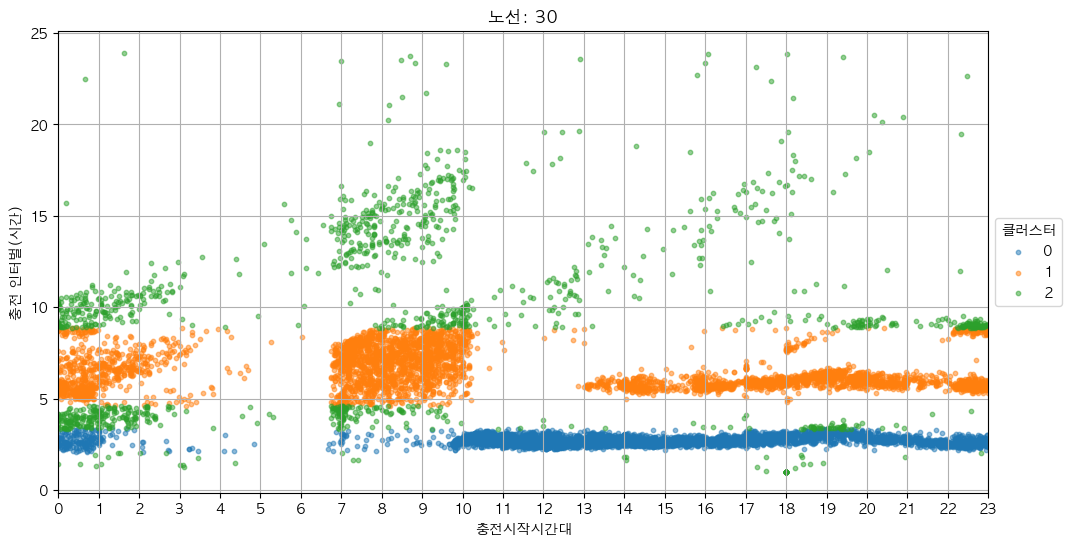

In [22]:
gmm_df['시간대(24시간)'] = gmm_df['충전시작시각'].dt.hour + gmm_df['충전시작시각'].dt.minute / 60

unique_routes = gmm_df['노선명'].unique()

for route in unique_routes:
    route_data = gmm_df[gmm_df['노선명'] == route]
    plt.figure(figsize=(12, 6))
    
    for cluster in sorted(route_data['클러스터'].unique()):
        cluster_data = route_data[route_data['클러스터'] == cluster]
        plt.scatter(
            cluster_data['시간대(24시간)'],  
            cluster_data['원본 충전 인터벌(시간)'], 
            label=f'{cluster}',
            alpha=0.5, 
            s=10  
        )
    plt.title(f'노선: {route}')
    plt.xlabel('충전시작시간대')
    plt.ylabel('충전 인터벌(시간)')
    plt.xticks(range(0, 24))
    plt.xlim(0, 23)
    plt.legend(title='클러스터', loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.grid(True)
    plt.show()


In [98]:
im.to_excel('클러스터별_충전인터벌평균.xlsx', index=False)

In [73]:
im2 = gmm_df.groupby(['노선명','클러스터'])['원본 충전 인터벌(시간)'].std().reset_index()
im2

노선명  클러스터  원본 충전 인터벌(시간)
0     25   0.0       0.281198
1     25   1.0       0.744222
2     25   2.0       3.657176
3     27   0.0       0.520517
4     27   1.0       0.878576
5     27   2.0       1.931438
6     27   3.0       0.329840
7     30   0.0       0.217745
8     30   1.0       1.065230
9     30   2.0       4.869186
10  30-1   0.0       1.155266
11  30-1   1.0       0.232545
12  30-1   2.0       5.488248
13    42   0.0       0.180697
14    42   1.0       0.673561
15    42   2.0       5.206118
16    42   3.0       0.477402
17     5   0.0       0.236276
18     5   1.0       4.598969
19     5   2.0       0.696055
20    98   0.0       0.307504
21    98   1.0       4.087717

In [90]:
gmm_df = df.copy()
gmm_df['충전 인터벌(시간)'] = pd.to_numeric(gmm_df['충전 인터벌(시간)'], errors='coerce')
gmm_df = gmm_df.dropna(subset=['노선명', '충전 인터벌(시간)', '충전시작시각', '충전종료시각','충전전력량(kWh)','SOC종료-시작_수정'])
gmm_df['충전 인터벌(시간)'] = np.log(gmm_df['충전 인터벌(시간)'])

routes = gmm_df['노선명'].unique()
gmm_df['클러스터'] = np.nan

def fit_gmm_and_label(route_name, gmm_df, rth=0.05):
    route_data = gmm_df[gmm_df['노선명'] == route_name]['충전 인터벌(시간)'].values.reshape(-1, 1)
    
    ncr = range(1, 11)
    bics = []
    models = []
    
    for nc in ncr:
        gmm = GaussianMixture(n_components=nc, random_state=42)
        gmm.fit(route_data)
        bics.append(gmm.bic(route_data))
        models.append(gmm)
    
    bic_rr = np.diff(bics) / np.array(bics[:-1])
    onc = np.argmax(bic_rr > -rth)
    best_model = models[onc]
    
    route_indices = gmm_df[gmm_df['노선명'] == route_name].index
    gmm_df.loc[route_indices, '클러스터'] = best_model.predict(route_data).astype(int)

for route in routes:
    fit_gmm_and_label(route, gmm_df, rth=0.05)

gmm_df['클러스터'] = gmm_df['클러스터'].astype(int)
a1 = gmm_df[['노선명', '충전 인터벌(시간)', '클러스터', '충전시작시각', '충전종료시각','충전전력량(kWh)','SOC종료-시작_수정']]
a1

노선명  충전 인터벌(시간)  클러스터              충전시작시각              충전종료시각  \
1      98    2.859451     1 2023-01-03 12:00:36 2023-01-03 12:30:34   
2      98    1.307281     0 2023-01-03 16:12:20 2023-01-03 16:25:15   
3      98    2.049304     1 2023-01-04 00:11:00 2023-01-04 02:11:29   
4      98    2.264508     1 2023-01-04 11:49:04 2023-01-04 12:12:15   
5      98    1.254745     0 2023-01-04 15:42:40 2023-01-04 16:01:06   
...    ..         ...   ...                 ...                 ...   
80842  30    2.884366     2 2023-12-27 11:34:54 2023-12-27 11:56:24   
80844  30    2.654552     2 2023-12-29 07:20:52 2023-12-29 07:35:58   
80845  30    0.979370     0 2023-12-29 10:15:44 2023-12-29 10:38:28   
80846  30    1.757475     1 2023-12-29 16:26:20 2023-12-29 16:40:36   
80847  30    1.805735     1 2023-12-29 22:45:40 2023-12-30 00:07:47   

       충전전력량(kWh)  SOC종료-시작_수정  
1           87.28           35  
2           28.24           12  
3          183.32           76  
4           72.00           29  
5           56.08           22  
...           ...          ...  
80842       18.76           32  
80844       44.16           26  
80845       64.56           38  
80846       21.08           24  
80847      120.56           75  

[74790 rows x 7 columns]

In [75]:
a1.groupby(['노선명','클러스터'])['충전전력량(kWh)'].mean()

노선명   클러스터
25    0        60.454329
      1        70.621439
      2        79.989069
27    0        82.681934
      1        64.165579
      2        75.606870
      3        60.418326
30    0        54.638648
      1        71.210470
      2        80.474431
30-1  0        73.632687
      1        53.426928
      2        81.700904
42    0        45.293477
      1        77.121378
      2        82.581724
      3        71.182883
5     0        53.937430
      1        86.913754
      2        75.370222
98    0       101.625212
      1       100.897472
Name: 충전전력량(kWh), dtype: float64

In [96]:
tm = a1.groupby(['노선명','클러스터'])[['충전시작시각','충전종료시각']].mean().reset_index()
tm['충전시작시각'] = tm['충전시작시각'].dt.time
tm['충전종료시각'] = tm['충전종료시각'].dt.time
tm

노선명  클러스터           충전시작시각           충전종료시각
0     25     0  08:45:12.733835  09:17:38.804284
1     25     1  20:30:34.534619  21:11:08.244704
2     25     2  04:12:50.481241  05:01:06.687590
3     27     0  00:25:00.555142  01:17:03.339529
4     27     1  10:33:50.762195  11:07:57.149390
5     27     2  12:34:08.995652  13:16:56.734782
6     27     3  07:04:57.689630  07:40:07.266135
7     30     0  20:47:16.397769  21:15:55.541072
8     30     1  03:04:20.396482  03:45:17.546527
9     30     2  21:14:25.288790  22:03:50.383815
10  30-1     0  07:19:06.421747  08:05:21.035728
11  30-1     1  21:24:41.985547  21:53:02.478877
12  30-1     2  13:01:17.992599  13:55:09.560591
13    42     0  07:12:12.195660  07:34:31.983493
14    42     1  23:12:49.291761  00:03:30.282690
15    42     2  14:29:19.206521  15:23:07.041925
16    42     3  06:51:50.565428  07:37:26.413876
17     5     0  15:38:22.700045  16:06:08.113129
18     5     1  21:53:13.635293  22:50:36.991815
19     5     2  14:34:07.739658  15:21:25.832471
20    98     0  07:18:08.674418  08:22:18.978723
21    98     1  01:47:38.802531  02:51:30.208575

- BIC 변화비율이 특정 임계값보다 크면 클러스터 수를 선택하도록 설정 되어있는데, 이 값은 모델의 복잡도를 제어하는 중요한 요소임. 클러스터간 BIC 점수 차이가 5% 미만으로 줄어들 때 모델 복잡도를 멈추는 기준으로 사용됨
- BIC 점수가 하락했다가 다시 상승하는 현상은 모델이 데이터를 지나치게 세분화하거나 적절하게 설명하지 못하는 과적합이나 부족한 설명력과 관련될 수 있음.
- BIC가 다시 상승하는 이유는 클러스터 수가 지나치게 많으면 모델이 잡음까지 설명하려고 함, 클러스터 수가 증가할수록 복잡도가 커진 경우이기 때문에 추가적인 클러스터가 데이터를 설명하는데 도움이 되지 않음

#### 상관관계분석

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78928 entries, 0 to 78927
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   차량번호         78928 non-null  object        
 1   노선명          78928 non-null  object        
 2   충전기ID        78928 non-null  int64         
 3   OUTLET ID    78928 non-null  object        
 4   충전기ID_충전구    78928 non-null  object        
 5   충전시작시각       78928 non-null  datetime64[ns]
 6   충전종료시각       78928 non-null  datetime64[ns]
 7   충전전력량(kWh)   78928 non-null  float64       
 8   충전 요금(원)     78928 non-null  int64         
 9   충전시작 SOC(%)  78928 non-null  int64         
 10  충전종료 SOC(%)  78928 non-null  int64         
 11  충전 인터벌(시간)   74790 non-null  float64       
 12  충전소요시간_수정    78928 non-null  object        
 13  SOC종료-시작_수정  78928 non-null  int64         
 14  충전일자         78928 non-null  datetime64[ns]
 15  월            78928 non-null  int64         
 16  요일  

충전 인터벌(시간)과의 상관관계:
충전 인터벌(시간)     1.000000
왕복운행거리         0.294679
인가거리           0.294323
충전전력량(kWh)     0.221230
충전 요금(원)       0.182411
SOC종료-시작_수정    0.152996
월              0.014254
충전종료 SOC(%)   -0.044330
충전기ID         -0.047714
충전시작 SOC(%)   -0.205482
주행거리          -0.288620
운행횟수          -0.334049
Name: 충전 인터벌(시간), dtype: float64


/var/folders/p9/jnvnv_cd4_x20zp1y216p6180000gn/T/ipykernel_21274/98866842.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


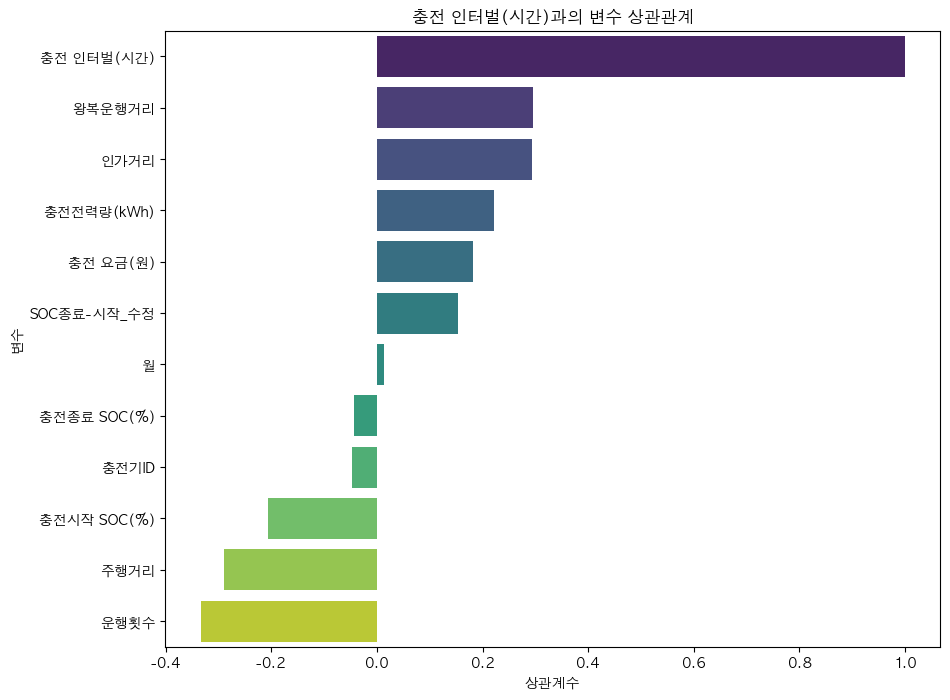

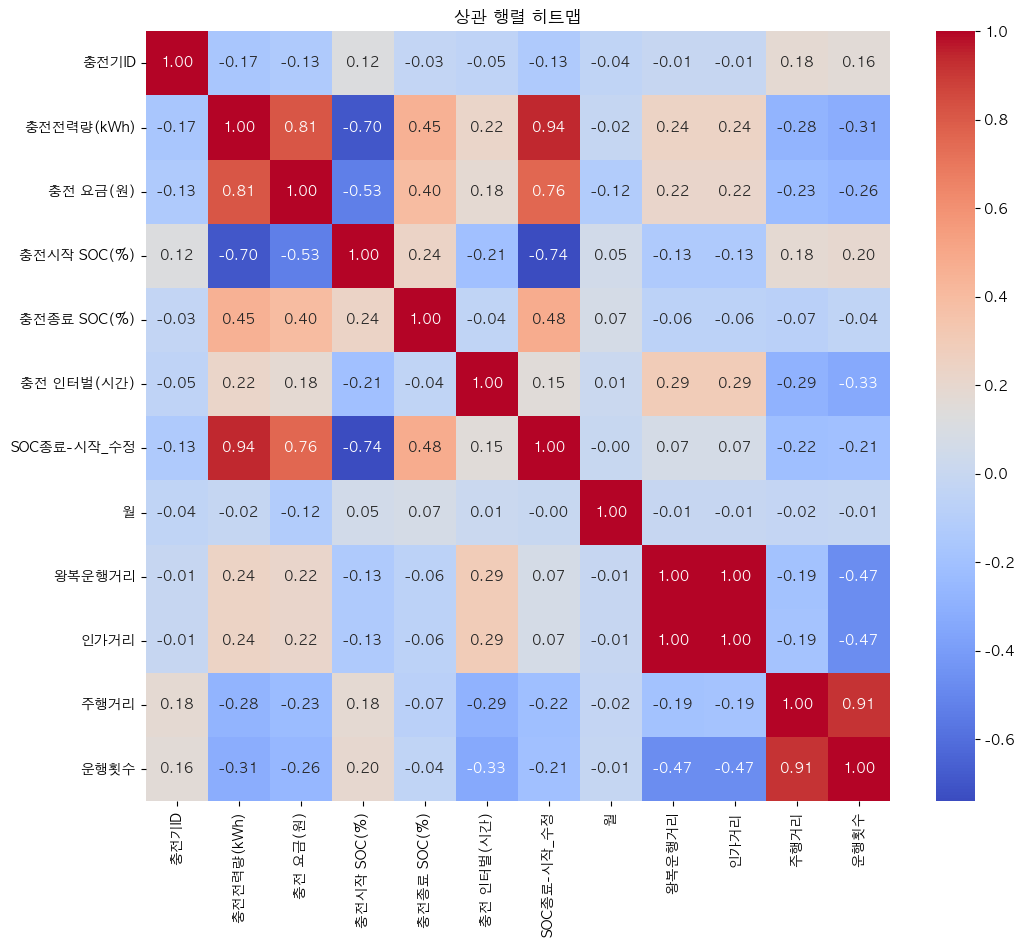

In [24]:
nucols = df.select_dtypes(include=['number']).columns

corr = df[nucols].corr()['충전 인터벌(시간)'].sort_values(ascending=False)

print("충전 인터벌(시간)과의 상관관계:")
print(corr)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr.values, y=corr.index, palette='viridis')
plt.title('충전 인터벌(시간)과의 변수 상관관계')
plt.xlabel('상관계수')
plt.ylabel('변수')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df[nucols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('상관 행렬 히트맵')
plt.show()


In [33]:
categorical_cols = ['차량번호', '노선명', '주중/주말', '요일', '월']  

binary_cols = ['주중/주말']
multicategorical_cols = ['요일', '월']

numerical_cols = ['충전 인터벌(시간)', '충전전력량(kWh)', '충전 요금(원)', 
                  '충전시작 SOC(%)', '충전종료 SOC(%)', 
                  'SOC종료-시작_수정', '왕복운행거리', '인가거리', '주행거리','운행횟수']

In [31]:
df.dtypes

차량번호                     object
노선명                      object
충전기ID                     int64
OUTLET ID                object
충전기ID_충전구                object
충전시작시각           datetime64[ns]
충전종료시각           datetime64[ns]
충전전력량(kWh)              float64
충전 요금(원)                  int64
충전시작 SOC(%)               int64
충전종료 SOC(%)               int64
충전 인터벌(시간)              float64
충전소요시간_수정                object
SOC종료-시작_수정               int64
충전일자             datetime64[ns]
월                         int64
요일                       object
주중/주말                    object
왕복운행거리                  float64
인가거리                    float64
주행거리                    float64
운행횟수                    float64
충전 인터벌(시간)_숫자            object
dtype: object